##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 1s

    16384/252872794 [..............................] - ETA: 47:52

    49152/252872794 [..............................] - ETA: 31:57

   106496/252872794 [..............................] - ETA: 21:28

   229376/252872794 [..............................] - ETA: 13:41

   466944/252872794 [..............................] - ETA: 8:15 

   942080/252872794 [..............................] - ETA: 4:54

  1900544/252872794 [..............................] - ETA: 2:50

  3809280/252872794 [..............................] - ETA: 1:36

  6938624/252872794 [..............................] - ETA: 58s 

 10067968/252872794 [>.............................] - ETA: 44s

 13205504/252872794 [>.............................] - ETA: 36s

 16326656/252872794 [>.............................] - ETA: 32s

 19365888/252872794 [=>............................] - ETA: 29s

 22487040/252872794 [=>............................] - ETA: 25s

 22511616/252872794 [=>............................] - ETA: 26s

 25583616/252872794 [==>...........................] - ETA: 23s

 25640960/252872794 [==>...........................] - ETA: 24s

 28696576/252872794 [==>...........................] - ETA: 22s

 28745728/252872794 [==>...........................] - ETA: 23s

 31825920/252872794 [==>...........................] - ETA: 21s

 31858688/252872794 [==>...........................] - ETA: 21s

 34906112/252872794 [===>..........................] - ETA: 20s

 34996224/252872794 [===>..........................] - ETA: 20s

 38027264/252872794 [===>..........................] - ETA: 19s

 38076416/252872794 [===>..........................] - ETA: 19s

 41156608/252872794 [===>..........................] - ETA: 18s

 41181184/252872794 [===>..........................] - ETA: 19s

 44302336/252872794 [====>.........................] - ETA: 17s

 44310528/252872794 [====>.........................] - ETA: 18s

 47423488/252872794 [====>.........................] - ETA: 17s

 47448064/252872794 [====>.........................] - ETA: 17s

 47464448/252872794 [====>.........................] - ETA: 17s

 50544640/252872794 [====>.........................] - ETA: 16s

 50577408/252872794 [=====>........................] - ETA: 16s

 50601984/252872794 [=====>........................] - ETA: 17s

 53657600/252872794 [=====>........................] - ETA: 16s

 53698560/252872794 [=====>........................] - ETA: 16s

 53739520/252872794 [=====>........................] - ETA: 16s

 56729600/252872794 [=====>........................] - ETA: 15s

 56819712/252872794 [=====>........................] - ETA: 15s

 56877056/252872794 [=====>........................] - ETA: 16s

 59867136/252872794 [======>.......................] - ETA: 15s

 59899904/252872794 [======>.......................] - ETA: 15s

 59998208/252872794 [======>.......................] - ETA: 15s

 63004672/252872794 [======>.......................] - ETA: 14s

 63037440/252872794 [======>.......................] - ETA: 14s

 63119360/252872794 [======>.......................] - ETA: 15s

 66142208/252872794 [======>.......................] - ETA: 14s

 66166784/252872794 [======>.......................] - ETA: 14s

 66199552/252872794 [======>.......................] - ETA: 14s

 69271552/252872794 [=======>......................] - ETA: 14s

 69304320/252872794 [=======>......................] - ETA: 14s

 69345280/252872794 [=======>......................] - ETA: 14s

 72343552/252872794 [=======>......................] - ETA: 13s

 72441856/252872794 [=======>......................] - ETA: 13s

 72482816/252872794 [=======>......................] - ETA: 13s

 75489280/252872794 [=======>......................] - ETA: 13s

 75530240/252872794 [=======>......................] - ETA: 13s

 75612160/252872794 [=======>......................] - ETA: 13s

 78618624/252872794 [========>.....................] - ETA: 12s

 78659584/252872794 [========>.....................] - ETA: 13s

 78749696/252872794 [========>.....................] - ETA: 13s

 81756160/252872794 [========>.....................] - ETA: 12s

 81788928/252872794 [========>.....................] - ETA: 12s

 81887232/252872794 [========>.....................] - ETA: 12s

 84860928/252872794 [=========>....................] - ETA: 12s

 84934656/252872794 [=========>....................] - ETA: 12s

 85000192/252872794 [=========>....................] - ETA: 12s

 87973888/252872794 [=========>....................] - ETA: 12s

 88064000/252872794 [=========>....................] - ETA: 12s

 88129536/252872794 [=========>....................] - ETA: 12s

 91111424/252872794 [=========>....................] - ETA: 11s

 91176960/252872794 [=========>....................] - ETA: 11s

 91267072/252872794 [=========>....................] - ETA: 11s

 94240768/252872794 [==========>...................] - ETA: 11s

 94289920/252872794 [==========>...................] - ETA: 11s

 94396416/252872794 [==========>...................] - ETA: 11s

 97370112/252872794 [==========>...................] - ETA: 11s

 97411072/252872794 [==========>...................] - ETA: 11s

 97533952/252872794 [==========>...................] - ETA: 11s

100499456/252872794 [==========>...................] - ETA: 10s

100540416/252872794 [==========>...................] - ETA: 10s

100646912/252872794 [==========>...................] - ETA: 11s

103636992/252872794 [===========>..................] - ETA: 10s

103669760/252872794 [===========>..................] - ETA: 10s

103768064/252872794 [===========>..................] - ETA: 10s

106774528/252872794 [===========>..................] - ETA: 10s

106799104/252872794 [===========>..................] - ETA: 10s

106881024/252872794 [===========>..................] - ETA: 10s

109912064/252872794 [============>.................] - ETA: 10s

109936640/252872794 [============>.................] - ETA: 10s

110002176/252872794 [============>.................] - ETA: 10s

113057792/252872794 [============>.................] - ETA: 9s 

113074176/252872794 [============>.................] - ETA: 9s

113123328/252872794 [============>.................] - ETA: 9s

116203520/252872794 [============>.................] - ETA: 9s

116211712/252872794 [============>.................] - ETA: 9s

116252672/252872794 [============>.................] - ETA: 9s

119332864/252872794 [=============>................] - ETA: 9s

119357440/252872794 [=============>................] - ETA: 9s

119390208/252872794 [=============>................] - ETA: 9s

122478592/252872794 [=============>................] - ETA: 9s

122503168/252872794 [=============>................] - ETA: 9s

124706816/252872794 [=============>................] - ETA: 8s

125624320/252872794 [=============>................] - ETA: 8s

125640704/252872794 [=============>................] - ETA: 8s

127836160/252872794 [==============>...............] - ETA: 8s

128753664/252872794 [==============>...............] - ETA: 8s

128778240/252872794 [==============>...............] - ETA: 8s

130965504/252872794 [==============>...............] - ETA: 8s

131891200/252872794 [==============>...............] - ETA: 8s

131915776/252872794 [==============>...............] - ETA: 8s

134094848/252872794 [==============>...............] - ETA: 8s

135028736/252872794 [===============>..............] - ETA: 8s

135053312/252872794 [===============>..............] - ETA: 8s

137207808/252872794 [===============>..............] - ETA: 7s

138166272/252872794 [===============>..............] - ETA: 7s

138190848/252872794 [===============>..............] - ETA: 7s

140345344/252872794 [===============>..............] - ETA: 7s

141303808/252872794 [===============>..............] - ETA: 7s

141320192/252872794 [===============>..............] - ETA: 7s

143466496/252872794 [================>.............] - ETA: 7s

144433152/252872794 [================>.............] - ETA: 7s

144457728/252872794 [================>.............] - ETA: 7s

146604032/252872794 [================>.............] - ETA: 7s

147546112/252872794 [================>.............] - ETA: 7s

147595264/252872794 [================>.............] - ETA: 7s

149733376/252872794 [================>.............] - ETA: 6s

150667264/252872794 [================>.............] - ETA: 6s

150732800/252872794 [================>.............] - ETA: 6s

152870912/252872794 [=================>............] - ETA: 6s

153804800/252872794 [=================>............] - ETA: 6s

153853952/252872794 [=================>............] - ETA: 6s

156008448/252872794 [=================>............] - ETA: 6s

156942336/252872794 [=================>............] - ETA: 6s

156975104/252872794 [=================>............] - ETA: 6s

159145984/252872794 [=================>............] - ETA: 6s

160079872/252872794 [=================>............] - ETA: 6s

160104448/252872794 [=================>............] - ETA: 6s

162283520/252872794 [==================>...........] - ETA: 6s

163192832/252872794 [==================>...........] - ETA: 6s

163241984/252872794 [==================>...........] - ETA: 6s

165429248/252872794 [==================>...........] - ETA: 5s

166322176/252872794 [==================>...........] - ETA: 5s

166371328/252872794 [==================>...........] - ETA: 5s

168566784/252872794 [==================>...........] - ETA: 5s

169451520/252872794 [===================>..........] - ETA: 5s

169500672/252872794 [===================>..........] - ETA: 5s

171704320/252872794 [===================>..........] - ETA: 5s

172589056/252872794 [===================>..........] - ETA: 5s

172630016/252872794 [===================>..........] - ETA: 5s

174825472/252872794 [===================>..........] - ETA: 5s

175718400/252872794 [===================>..........] - ETA: 5s

175759360/252872794 [===================>..........] - ETA: 5s

178503680/252872794 [====================>.........] - ETA: 4s

178831360/252872794 [====================>.........] - ETA: 4s

178888704/252872794 [====================>.........] - ETA: 4s

181641216/252872794 [====================>.........] - ETA: 4s

181952512/252872794 [====================>.........] - ETA: 4s

182018048/252872794 [====================>.........] - ETA: 4s

184778752/252872794 [====================>.........] - ETA: 4s

185032704/252872794 [====================>.........] - ETA: 4s

185139200/252872794 [====================>.........] - ETA: 4s

187908096/252872794 [=====================>........] - ETA: 4s

188071936/252872794 [=====================>........] - ETA: 4s

188268544/252872794 [=====================>........] - ETA: 4s

191021056/252872794 [=====================>........] - ETA: 4s

191143936/252872794 [=====================>........] - ETA: 4s

191365120/252872794 [=====================>........] - ETA: 4s

194150400/252872794 [======================>.......] - ETA: 3s

194240512/252872794 [======================>.......] - ETA: 3s

194420736/252872794 [======================>.......] - ETA: 3s

197296128/252872794 [======================>.......] - ETA: 3s

197369856/252872794 [======================>.......] - ETA: 3s

197541888/252872794 [======================>.......] - ETA: 3s

200425472/252872794 [======================>.......] - ETA: 3s

200491008/252872794 [======================>.......] - ETA: 3s

200638464/252872794 [======================>.......] - ETA: 3s

203571200/252872794 [=======================>......] - ETA: 3s

203612160/252872794 [=======================>......] - ETA: 3s

203743232/252872794 [=======================>......] - ETA: 3s

206692352/252872794 [=======================>......] - ETA: 3s

206749696/252872794 [=======================>......] - ETA: 3s

206823424/252872794 [=======================>......] - ETA: 3s

209821696/252872794 [=======================>......] - ETA: 2s

209879040/252872794 [=======================>......] - ETA: 2s

209928192/252872794 [=======================>......] - ETA: 2s

212967424/252872794 [========================>.....] - ETA: 2s

213016576/252872794 [========================>.....] - ETA: 2s

213057536/252872794 [========================>.....] - ETA: 2s

216096768/252872794 [========================>.....] - ETA: 2s

216145920/252872794 [========================>.....] - ETA: 2s

216195072/252872794 [========================>.....] - ETA: 2s

219242496/252872794 [=========================>....] - ETA: 2s

219283456/252872794 [=========================>....] - ETA: 2s

219324416/252872794 [=========================>....] - ETA: 2s

222380032/252872794 [=========================>....] - ETA: 1s

222420992/252872794 [=========================>....] - ETA: 1s

222453760/252872794 [=========================>....] - ETA: 1s

225517568/252872794 [=========================>....] - ETA: 1s

225550336/252872794 [=========================>....] - ETA: 1s

225591296/252872794 [=========================>....] - ETA: 1s

228646912/252872794 [==========================>...] - ETA: 1s

228687872/252872794 [==========================>...] - ETA: 1s

228728832/252872794 [==========================>...] - ETA: 1s

231792640/252872794 [==========================>...] - ETA: 1s

231817216/252872794 [==========================>...] - ETA: 1s

231858176/252872794 [==========================>...] - ETA: 1s

234938368/252872794 [==========================>...] - ETA: 1s

234971136/252872794 [==========================>...] - ETA: 1s

235003904/252872794 [==========================>...] - ETA: 1s

238084096/252872794 [===========================>..] - ETA: 0s

238116864/252872794 [===========================>..] - ETA: 0s

238141440/252872794 [===========================>..] - ETA: 0s

241213440/252872794 [===========================>..] - ETA: 0s

241246208/252872794 [===========================>..] - ETA: 0s

241270784/252872794 [===========================>..] - ETA: 0s

244350976/252872794 [===========================>..] - ETA: 0s

244383744/252872794 [===========================>..] - ETA: 0s

244408320/252872794 [===========================>..] - ETA: 0s

247496704/252872794 [============================>.] - ETA: 0s

247529472/252872794 [============================>.] - ETA: 0s

250634240/252872794 [============================>.] - ETA: 0s

250650624/252872794 [============================>.] - ETA: 0s

250683392/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 16s 0us/step


       8192/13510573713 [..............................] - ETA: 1:35

      16384/13510573713 [..............................] - ETA: 42:13:27

      49152/13510573713 [..............................] - ETA: 28:08:59

     106496/13510573713 [..............................] - ETA: 19:18:15

     204800/13510573713 [..............................] - ETA: 13:25:11

     425984/13510573713 [..............................] - ETA: 8:04:46 

     860160/13510573713 [..............................] - ETA: 4:48:22

    1728512/13510573713 [..............................] - ETA: 2:47:32

    3465216/13510573713 [..............................] - ETA: 1:35:33

    6602752/13510573713 [..............................] - ETA: 56:25  

    9428992/13510573713 [..............................] - ETA: 43:54

   12558336/13510573713 [..............................] - ETA: 36:15

   15671296/13510573713 [..............................] - ETA: 31:43

   18767872/13510573713 [..............................] - ETA: 28:41

   21880832/13510573713 [..............................] - ETA: 26:30

   24854528/13510573713 [..............................] - ETA: 24:59

   27967488/13510573713 [..............................] - ETA: 23:41

   31006720/13510573713 [..............................] - ETA: 22:41

   34086912/13510573713 [..............................] - ETA: 21:51

   37208064/13510573713 [..............................] - ETA: 21:08

   40345600/13510573713 [..............................] - ETA: 20:30

   43491328/13510573713 [..............................] - ETA: 19:58

   46612480/13510573713 [..............................] - ETA: 19:31

   49741824/13510573713 [..............................] - ETA: 19:07

   52805632/13510573713 [..............................] - ETA: 18:47

   55943168/13510573713 [..............................] - ETA: 18:28

   59072512/13510573713 [..............................] - ETA: 18:11

   62177280/13510573713 [..............................] - ETA: 17:56

   65290240/13510573713 [..............................] - ETA: 17:23

   65314816/13510573713 [..............................] - ETA: 17:42

   68419584/13510573713 [..............................] - ETA: 17:11

   68435968/13510573713 [..............................] - ETA: 17:30

   71557120/13510573713 [..............................] - ETA: 17:00

   71573504/13510573713 [..............................] - ETA: 17:18

   74686464/13510573713 [..............................] - ETA: 16:50

   74711040/13510573713 [..............................] - ETA: 17:08

   77824000/13510573713 [..............................] - ETA: 16:41

   77832192/13510573713 [..............................] - ETA: 16:58

   80953344/13510573713 [..............................] - ETA: 16:33

   80977920/13510573713 [..............................] - ETA: 16:49

   84074496/13510573713 [..............................] - ETA: 16:25

   84107264/13510573713 [..............................] - ETA: 16:41

   87179264/13510573713 [..............................] - ETA: 16:18

   87252992/13510573713 [..............................] - ETA: 16:34

   90308608/13510573713 [..............................] - ETA: 16:12

   90382336/13510573713 [..............................] - ETA: 16:26

   93372416/13510573713 [..............................] - ETA: 16:06

   93495296/13510573713 [..............................] - ETA: 16:19

   96493568/13510573713 [..............................] - ETA: 16:00

   96616448/13510573713 [..............................] - ETA: 16:13

   99606528/13510573713 [..............................] - ETA: 15:55

   99704832/13510573713 [..............................] - ETA: 16:07

  102744064/13510573713 [..............................] - ETA: 15:50

  102834176/13510573713 [..............................] - ETA: 16:02

  105873408/13510573713 [..............................] - ETA: 15:45

  105963520/13510573713 [..............................] - ETA: 15:56

  109002752/13510573713 [..............................] - ETA: 15:40

  109076480/13510573713 [..............................] - ETA: 15:52

  112140288/13510573713 [..............................] - ETA: 15:36

  112197632/13510573713 [..............................] - ETA: 15:47

  115269632/13510573713 [..............................] - ETA: 15:31

  115310592/13510573713 [..............................] - ETA: 15:43

  118382592/13510573713 [..............................] - ETA: 15:28

  118456320/13510573713 [..............................] - ETA: 15:38

  121520128/13510573713 [..............................] - ETA: 15:24

  121577472/13510573713 [..............................] - ETA: 15:34

  124657664/13510573713 [..............................] - ETA: 15:20

  124690432/13510573713 [..............................] - ETA: 15:31

  127803392/13510573713 [..............................] - ETA: 15:21

  127827968/13510573713 [..............................] - ETA: 15:27

  130932736/13510573713 [..............................] - ETA: 15:13

  130957312/13510573713 [..............................] - ETA: 15:23

  134053888/13510573713 [..............................] - ETA: 15:10

  134094848/13510573713 [..............................] - ETA: 15:19

  136445952/13510573713 [..............................] - ETA: 15:07

  137207808/13510573713 [..............................] - ETA: 15:11

  137240576/13510573713 [..............................] - ETA: 15:17

  140328960/13510573713 [..............................] - ETA: 15:04

  140361728/13510573713 [..............................] - ETA: 15:12

  142688256/13510573713 [..............................] - ETA: 15:02

  143474688/13510573713 [..............................] - ETA: 15:06

  143507456/13510573713 [..............................] - ETA: 15:10

  146612224/13510573713 [..............................] - ETA: 15:03

  146644992/13510573713 [..............................] - ETA: 15:08

  149749760/13510573713 [..............................] - ETA: 14:56

  149766144/13510573713 [..............................] - ETA: 15:04

  151969792/13510573713 [..............................] - ETA: 14:55

  152895488/13510573713 [..............................] - ETA: 14:57

  152911872/13510573713 [..............................] - ETA: 15:02

  156000256/13510573713 [..............................] - ETA: 14:51

  156041216/13510573713 [..............................] - ETA: 14:59

  158416896/13510573713 [..............................] - ETA: 14:49

  159154176/13510573713 [..............................] - ETA: 14:53

  159195136/13510573713 [..............................] - ETA: 14:58

  162217984/13510573713 [..............................] - ETA: 14:47

  162316288/13510573713 [..............................] - ETA: 14:54

  164593664/13510573713 [..............................] - ETA: 14:45

  165371904/13510573713 [..............................] - ETA: 14:49

  165462016/13510573713 [..............................] - ETA: 14:53

  168468480/13510573713 [..............................] - ETA: 14:43

  168591360/13510573713 [..............................] - ETA: 14:49

  170745856/13510573713 [..............................] - ETA: 14:42

  171630592/13510573713 [..............................] - ETA: 14:44

  171737088/13510573713 [..............................] - ETA: 14:48

  174743552/13510573713 [..............................] - ETA: 14:39

  174858240/13510573713 [..............................] - ETA: 14:45

  177004544/13510573713 [..............................] - ETA: 14:38

  177905664/13510573713 [..............................] - ETA: 14:40

  178012160/13510573713 [..............................] - ETA: 14:44

  181018624/13510573713 [..............................] - ETA: 14:36

  181108736/13510573713 [..............................] - ETA: 14:41

  183296000/13510573713 [..............................] - ETA: 14:34

  184172544/13510573713 [..............................] - ETA: 14:37

  184262656/13510573713 [..............................] - ETA: 14:40

  187301888/13510573713 [..............................] - ETA: 14:32

  187367424/13510573713 [..............................] - ETA: 14:38

  189587456/13510573713 [..............................] - ETA: 14:31

  190447616/13510573713 [..............................] - ETA: 14:33

  190513152/13510573713 [..............................] - ETA: 14:37

  193527808/13510573713 [..............................] - ETA: 14:29

  193650688/13510573713 [..............................] - ETA: 14:34

  195878912/13510573713 [..............................] - ETA: 14:28

  196689920/13510573713 [..............................] - ETA: 14:30

  196796416/13510573713 [..............................] - ETA: 14:33

  199802880/13510573713 [..............................] - ETA: 14:26

  199860224/13510573713 [..............................] - ETA: 14:31

  202162176/13510573713 [..............................] - ETA: 14:25

  202956800/13510573713 [..............................] - ETA: 14:27

  203022336/13510573713 [..............................] - ETA: 14:30

  206086144/13510573713 [..............................] - ETA: 14:23

  206110720/13510573713 [..............................] - ETA: 14:28

  207683584/13510573713 [..............................] - ETA: 14:25

  209231872/13510573713 [..............................] - ETA: 14:24

  209264640/13510573713 [..............................] - ETA: 14:28

  212361216/13510573713 [..............................] - ETA: 14:20

  212385792/13510573713 [..............................] - ETA: 14:25

  213770240/13510573713 [..............................] - ETA: 14:23

  215506944/13510573713 [..............................] - ETA: 14:21

  215539712/13510573713 [..............................] - ETA: 14:25

  218619904/13510573713 [..............................] - ETA: 14:18

  218669056/13510573713 [..............................] - ETA: 14:23

  219947008/13510573713 [..............................] - ETA: 14:20

  221773824/13510573713 [..............................] - ETA: 14:19

  221814784/13510573713 [..............................] - ETA: 14:22

  224272384/13510573713 [..............................] - ETA: 14:15

  224911360/13510573713 [..............................] - ETA: 14:17

  224952320/13510573713 [..............................] - ETA: 14:21

  227418112/13510573713 [..............................] - ETA: 14:14

  228040704/13510573713 [..............................] - ETA: 14:16

  228089856/13510573713 [..............................] - ETA: 14:19

  230506496/13510573713 [..............................] - ETA: 14:13

  231178240/13510573713 [..............................] - ETA: 14:15

  231219200/13510573713 [..............................] - ETA: 14:18

  233627648/13510573713 [..............................] - ETA: 14:12

  234315776/13510573713 [..............................] - ETA: 14:14

  234348544/13510573713 [..............................] - ETA: 14:17

  236773376/13510573713 [..............................] - ETA: 14:11

  237355008/13510573713 [..............................] - ETA: 14:13

  237477888/13510573713 [..............................] - ETA: 14:16

  239910912/13510573713 [..............................] - ETA: 14:10

  240459776/13510573713 [..............................] - ETA: 14:12

  240623616/13510573713 [..............................] - ETA: 14:14

  243032064/13510573713 [..............................] - ETA: 14:09

  243572736/13510573713 [..............................] - ETA: 14:11

  243761152/13510573713 [..............................] - ETA: 14:13

  246169600/13510573713 [..............................] - ETA: 14:08

  246693888/13510573713 [..............................] - ETA: 14:10

  246816768/13510573713 [..............................] - ETA: 14:12

  249307136/13510573713 [..............................] - ETA: 14:06

  249823232/13510573713 [..............................] - ETA: 14:09

  249896960/13510573713 [..............................] - ETA: 14:12

  252444672/13510573713 [..............................] - ETA: 14:05

  252952576/13510573713 [..............................] - ETA: 14:08

  253001728/13510573713 [..............................] - ETA: 14:11

  255590400/13510573713 [..............................] - ETA: 14:04

  256081920/13510573713 [..............................] - ETA: 14:07

  256131072/13510573713 [..............................] - ETA: 14:10

  258719744/13510573713 [..............................] - ETA: 14:03

  259194880/13510573713 [..............................] - ETA: 14:06

  259260416/13510573713 [..............................] - ETA: 14:08

  261857280/13510573713 [..............................] - ETA: 14:02

  262324224/13510573713 [..............................] - ETA: 14:05

  262389760/13510573713 [..............................] - ETA: 14:07

  264986624/13510573713 [..............................] - ETA: 14:02

  265453568/13510573713 [..............................] - ETA: 14:04

  265527296/13510573713 [..............................] - ETA: 14:06

  268132352/13510573713 [..............................] - ETA: 14:01

  268582912/13510573713 [..............................] - ETA: 14:03

  268664832/13510573713 [..............................] - ETA: 14:05

  271278080/13510573713 [..............................] - ETA: 14:00

  271720448/13510573713 [..............................] - ETA: 14:02

  271785984/13510573713 [..............................] - ETA: 14:05

  274415616/13510573713 [..............................] - ETA: 13:59

  274866176/13510573713 [..............................] - ETA: 14:01

  274923520/13510573713 [..............................] - ETA: 14:04

  277553152/13510573713 [..............................] - ETA: 13:58

  278003712/13510573713 [..............................] - ETA: 14:00

  278061056/13510573713 [..............................] - ETA: 14:03

  280690688/13510573713 [..............................] - ETA: 13:57

  281133056/13510573713 [..............................] - ETA: 13:59

  281198592/13510573713 [..............................] - ETA: 14:02

  283836416/13510573713 [..............................] - ETA: 13:56

  284237824/13510573713 [..............................] - ETA: 13:59

  284336128/13510573713 [..............................] - ETA: 14:01

  286973952/13510573713 [..............................] - ETA: 13:55

  287334400/13510573713 [..............................] - ETA: 13:58

  287449088/13510573713 [..............................] - ETA: 14:00

  290111488/13510573713 [..............................] - ETA: 13:54

  290463744/13510573713 [..............................] - ETA: 13:57

  290553856/13510573713 [..............................] - ETA: 13:59

  293249024/13510573713 [..............................] - ETA: 13:54

  293601280/13510573713 [..............................] - ETA: 13:56

  293658624/13510573713 [..............................] - ETA: 13:58

  296386560/13510573713 [..............................] - ETA: 13:53

  296738816/13510573713 [..............................] - ETA: 13:55

  296771584/13510573713 [..............................] - ETA: 13:58

  299524096/13510573713 [..............................] - ETA: 13:52

  299859968/13510573713 [..............................] - ETA: 13:55

  299900928/13510573713 [..............................] - ETA: 13:57

  302661632/13510573713 [..............................] - ETA: 13:51

  302964736/13510573713 [..............................] - ETA: 13:54

  303030272/13510573713 [..............................] - ETA: 13:56

  305799168/13510573713 [..............................] - ETA: 13:51

  306012160/13510573713 [..............................] - ETA: 13:53

  306167808/13510573713 [..............................] - ETA: 13:55

  308936704/13510573713 [..............................] - ETA: 13:50

  309125120/13510573713 [..............................] - ETA: 13:53

  309280768/13510573713 [..............................] - ETA: 13:55

  312082432/13510573713 [..............................] - ETA: 13:49

  312262656/13510573713 [..............................] - ETA: 13:52

  312352768/13510573713 [..............................] - ETA: 13:54

  315219968/13510573713 [..............................] - ETA: 13:48

  315400192/13510573713 [..............................] - ETA: 13:51

  315490304/13510573713 [..............................] - ETA: 13:53

  318357504/13510573713 [..............................] - ETA: 13:48

  318496768/13510573713 [..............................] - ETA: 13:51

  318586880/13510573713 [..............................] - ETA: 13:53

  321503232/13510573713 [..............................] - ETA: 13:47

  321617920/13510573713 [..............................] - ETA: 13:50

  321716224/13510573713 [..............................] - ETA: 13:52

  324648960/13510573713 [..............................] - ETA: 13:46

  324755456/13510573713 [..............................] - ETA: 13:49

  324820992/13510573713 [..............................] - ETA: 13:51

  327786496/13510573713 [..............................] - ETA: 13:45

  327884800/13510573713 [..............................] - ETA: 13:48

  327925760/13510573713 [..............................] - ETA: 13:50

  330924032/13510573713 [..............................] - ETA: 13:45

  330997760/13510573713 [..............................] - ETA: 13:48

  331055104/13510573713 [..............................] - ETA: 13:50

  334069760/13510573713 [..............................] - ETA: 13:44

  334110720/13510573713 [..............................] - ETA: 13:47

  334184448/13510573713 [..............................] - ETA: 13:49

  337215488/13510573713 [..............................] - ETA: 13:43

  337248256/13510573713 [..............................] - ETA: 13:46

  337305600/13510573713 [..............................] - ETA: 13:48

  340361216/13510573713 [..............................] - ETA: 13:43

  340385792/13510573713 [..............................] - ETA: 13:46

  340418560/13510573713 [..............................] - ETA: 13:48

  343498752/13510573713 [..............................] - ETA: 13:42

  343523328/13510573713 [..............................] - ETA: 13:45

  343547904/13510573713 [..............................] - ETA: 13:47

  346628096/13510573713 [..............................] - ETA: 13:41

  346669056/13510573713 [..............................] - ETA: 13:46

  348700672/13510573713 [..............................] - ETA: 13:43

  349806592/13510573713 [..............................] - ETA: 13:44

  349814784/13510573713 [..............................] - ETA: 13:46

  352903168/13510573713 [..............................] - ETA: 13:40

  352952320/13510573713 [..............................] - ETA: 13:43

  352960512/13510573713 [..............................] - ETA: 13:45

  356048896/13510573713 [..............................] - ETA: 13:40

  356089856/13510573713 [..............................] - ETA: 13:43

  356106240/13510573713 [..............................] - ETA: 13:45

  359219200/13510573713 [..............................] - ETA: 13:40

  359235584/13510573713 [..............................] - ETA: 13:43

  361275392/13510573713 [..............................] - ETA: 13:40

  362356736/13510573713 [..............................] - ETA: 13:40

  362373120/13510573713 [..............................] - ETA: 13:43

  364429312/13510573713 [..............................] - ETA: 13:40

  365494272/13510573713 [..............................] - ETA: 13:39

  365510656/13510573713 [..............................] - ETA: 13:42

  367558656/13510573713 [..............................] - ETA: 13:39

  368623616/13510573713 [..............................] - ETA: 13:39

  368648192/13510573713 [..............................] - ETA: 13:42

  370688000/13510573713 [..............................] - ETA: 13:39

  371752960/13510573713 [..............................] - ETA: 13:38

  371785728/13510573713 [..............................] - ETA: 13:41

  373825536/13510573713 [..............................] - ETA: 13:38

  374890496/13510573713 [..............................] - ETA: 13:37

  374923264/13510573713 [..............................] - ETA: 13:40

  376766464/13510573713 [..............................] - ETA: 13:38

  378028032/13510573713 [..............................] - ETA: 13:37

  378052608/13510573713 [..............................] - ETA: 13:40

  379789312/13510573713 [..............................] - ETA: 13:38

  381173760/13510573713 [..............................] - ETA: 13:38

  381206528/13510573713 [..............................] - ETA: 13:40

  384303104/13510573713 [..............................] - ETA: 13:36

  384327680/13510573713 [..............................] - ETA: 13:39

  385933312/13510573713 [..............................] - ETA: 13:37

  387440640/13510573713 [..............................] - ETA: 13:35

  387465216/13510573713 [..............................] - ETA: 13:38

  389079040/13510573713 [..............................] - ETA: 13:36

  390578176/13510573713 [..............................] - ETA: 13:35

  390602752/13510573713 [..............................] - ETA: 13:37

  392192000/13510573713 [..............................] - ETA: 13:36

  393699328/13510573713 [..............................] - ETA: 13:34

  393740288/13510573713 [..............................] - ETA: 13:37

  395345920/13510573713 [..............................] - ETA: 13:35

  396836864/13510573713 [..............................] - ETA: 13:34

  396877824/13510573713 [..............................] - ETA: 13:36

  398475264/13510573713 [..............................] - ETA: 13:35

  399974400/13510573713 [..............................] - ETA: 13:33

  399998976/13510573713 [..............................] - ETA: 13:36

  401580032/13510573713 [..............................] - ETA: 13:34

  403111936/13510573713 [..............................] - ETA: 13:33

  403136512/13510573713 [..............................] - ETA: 13:35

  404725760/13510573713 [..............................] - ETA: 13:34

  406233088/13510573713 [..............................] - ETA: 13:32

  406265856/13510573713 [..............................] - ETA: 13:35

  407683072/13510573713 [..............................] - ETA: 13:33

  409370624/13510573713 [..............................] - ETA: 13:32

  409403392/13510573713 [..............................] - ETA: 13:34

  410812416/13510573713 [..............................] - ETA: 13:33

  412508160/13510573713 [..............................] - ETA: 13:31

  412540928/13510573713 [..............................] - ETA: 13:34

  413933568/13510573713 [..............................] - ETA: 13:32

  415531008/13510573713 [..............................] - ETA: 13:31

  415670272/13510573713 [..............................] - ETA: 13:33

  417030144/13510573713 [..............................] - ETA: 13:32

  418668544/13510573713 [..............................] - ETA: 13:30

  418807808/13510573713 [..............................] - ETA: 13:33

  420175872/13510573713 [..............................] - ETA: 13:32

  421814272/13510573713 [..............................] - ETA: 13:30

  421879808/13510573713 [..............................] - ETA: 13:32

  423190528/13510573713 [..............................] - ETA: 13:31

  424927232/13510573713 [..............................] - ETA: 13:29

  424984576/13510573713 [..............................] - ETA: 13:32

  426336256/13510573713 [..............................] - ETA: 13:31

  428048384/13510573713 [..............................] - ETA: 13:29

  428113920/13510573713 [..............................] - ETA: 13:31

  429465600/13510573713 [..............................] - ETA: 13:30

  431185920/13510573713 [..............................] - ETA: 13:29

  431235072/13510573713 [..............................] - ETA: 13:31

  432201728/13510573713 [..............................] - ETA: 13:31

  434323456/13510573713 [..............................] - ETA: 13:28

  434356224/13510573713 [..............................] - ETA: 13:30

  435298304/13510573713 [..............................] - ETA: 13:30

  437460992/13510573713 [..............................] - ETA: 13:28

  437485568/13510573713 [..............................] - ETA: 13:30

  438452224/13510573713 [..............................] - ETA: 13:30

  440598528/13510573713 [..............................] - ETA: 13:27

  440614912/13510573713 [..............................] - ETA: 13:29

  441532416/13510573713 [..............................] - ETA: 13:29

  443736064/13510573713 [..............................] - ETA: 13:27

  443760640/13510573713 [..............................] - ETA: 13:29

  444678144/13510573713 [..............................] - ETA: 13:29

  446881792/13510573713 [..............................] - ETA: 13:27

  446906368/13510573713 [..............................] - ETA: 13:29

  449929216/13510573713 [..............................] - ETA: 13:26

  450035712/13510573713 [..............................] - ETA: 13:28

  450936832/13510573713 [>.............................] - ETA: 13:28

  453066752/13510573713 [>.............................] - ETA: 13:25

  453173248/13510573713 [>.............................] - ETA: 13:28

  454066176/13510573713 [>.............................] - ETA: 13:27

  456204288/13510573713 [>.............................] - ETA: 13:25

  456261632/13510573713 [>.............................] - ETA: 13:27

  457211904/13510573713 [>.............................] - ETA: 13:27

  459333632/13510573713 [>.............................] - ETA: 13:25

  459374592/13510573713 [>.............................] - ETA: 13:27

  460324864/13510573713 [>.............................] - ETA: 13:26

  462331904/13510573713 [>.............................] - ETA: 13:24

  462503936/13510573713 [>.............................] - ETA: 13:26

  463372288/13510573713 [>.............................] - ETA: 13:26

  465395712/13510573713 [>.............................] - ETA: 13:24

  465633280/13510573713 [>.............................] - ETA: 13:26

  466518016/13510573713 [>.............................] - ETA: 13:26

  468508672/13510573713 [>.............................] - ETA: 13:24

  468688896/13510573713 [>.............................] - ETA: 13:26

  469663744/13510573713 [>.............................] - ETA: 13:25

  471646208/13510573713 [>.............................] - ETA: 13:23

  471744512/13510573713 [>.............................] - ETA: 13:25

  472752128/13510573713 [>.............................] - ETA: 13:25

  474783744/13510573713 [>.............................] - ETA: 13:23

  474832896/13510573713 [>.............................] - ETA: 13:25

  475897856/13510573713 [>.............................] - ETA: 13:24

  477929472/13510573713 [>.............................] - ETA: 13:24

  478019584/13510573713 [>.............................] - ETA: 13:25

  480698368/13510573713 [>.............................] - ETA: 13:21

  481067008/13510573713 [>.............................] - ETA: 13:23

  481157120/13510573713 [>.............................] - ETA: 13:24

  483835904/13510573713 [>.............................] - ETA: 13:21

  484212736/13510573713 [>.............................] - ETA: 13:23

  484278272/13510573713 [>.............................] - ETA: 13:24

  486973440/13510573713 [>.............................] - ETA: 13:21

  487333888/13510573713 [>.............................] - ETA: 13:22

  487391232/13510573713 [>.............................] - ETA: 13:24

  490110976/13510573713 [>.............................] - ETA: 13:20

  490438656/13510573713 [>.............................] - ETA: 13:22

  490528768/13510573713 [>.............................] - ETA: 13:23

  493248512/13510573713 [>.............................] - ETA: 13:20

  493576192/13510573713 [>.............................] - ETA: 13:21

  493666304/13510573713 [>.............................] - ETA: 13:23

  496361472/13510573713 [>.............................] - ETA: 13:19

  496648192/13510573713 [>.............................] - ETA: 13:21

  496812032/13510573713 [>.............................] - ETA: 13:22

  499458048/13510573713 [>.............................] - ETA: 13:19

  499769344/13510573713 [>.............................] - ETA: 13:21

  499900416/13510573713 [>.............................] - ETA: 13:22

  502448128/13510573713 [>.............................] - ETA: 13:19

  502898688/13510573713 [>.............................] - ETA: 13:20

  503029760/13510573713 [>.............................] - ETA: 13:21

  505585664/13510573713 [>.............................] - ETA: 13:19

  505978880/13510573713 [>.............................] - ETA: 13:20

  506093568/13510573713 [>.............................] - ETA: 13:21

  508723200/13510573713 [>.............................] - ETA: 13:18

  509116416/13510573713 [>.............................] - ETA: 13:20

  509214720/13510573713 [>.............................] - ETA: 13:21

  511991808/13510573713 [>.............................] - ETA: 13:18

  512245760/13510573713 [>.............................] - ETA: 13:19

  512311296/13510573713 [>.............................] - ETA: 13:20

  515080192/13510573713 [>.............................] - ETA: 13:17

  515317760/13510573713 [>.............................] - ETA: 13:19

  515432448/13510573713 [>.............................] - ETA: 13:20

  518217728/13510573713 [>.............................] - ETA: 13:17

  518455296/13510573713 [>.............................] - ETA: 13:18

  518561792/13510573713 [>.............................] - ETA: 13:20

  521363456/13510573713 [>.............................] - ETA: 13:16

  521543680/13510573713 [>.............................] - ETA: 13:18

  521658368/13510573713 [>.............................] - ETA: 13:19

  524500992/13510573713 [>.............................] - ETA: 13:16

  524681216/13510573713 [>.............................] - ETA: 13:18

  524771328/13510573713 [>.............................] - ETA: 13:19

  527630336/13510573713 [>.............................] - ETA: 13:16

  527769600/13510573713 [>.............................] - ETA: 13:17

  527867904/13510573713 [>.............................] - ETA: 13:19

  530636800/13510573713 [>.............................] - ETA: 13:15

  530857984/13510573713 [>.............................] - ETA: 13:17

  530989056/13510573713 [>.............................] - ETA: 13:18

  533151744/13510573713 [>.............................] - ETA: 13:16

  533987328/13510573713 [>.............................] - ETA: 13:17

  534110208/13510573713 [>.............................] - ETA: 13:18

  536313856/13510573713 [>.............................] - ETA: 13:16

  537067520/13510573713 [>.............................] - ETA: 13:16

  537223168/13510573713 [>.............................] - ETA: 13:17

  539443200/13510573713 [>.............................] - ETA: 13:15

  539975680/13510573713 [>.............................] - ETA: 13:16

  540352512/13510573713 [>.............................] - ETA: 13:17

  542597120/13510573713 [>.............................] - ETA: 13:15

  543064064/13510573713 [>.............................] - ETA: 13:16

  543432704/13510573713 [>.............................] - ETA: 13:17

  545693696/13510573713 [>.............................] - ETA: 13:15

  546185216/13510573713 [>.............................] - ETA: 13:16

  546545664/13510573713 [>.............................] - ETA: 13:16

  548831232/13510573713 [>.............................] - ETA: 13:14

  549314560/13510573713 [>.............................] - ETA: 13:15

  549625856/13510573713 [>.............................] - ETA: 13:16

  551968768/13510573713 [>.............................] - ETA: 13:14

  552443904/13510573713 [>.............................] - ETA: 13:15

  552763392/13510573713 [>.............................] - ETA: 13:16

  555081728/13510573713 [>.............................] - ETA: 13:13

  555573248/13510573713 [>.............................] - ETA: 13:15

  555900928/13510573713 [>.............................] - ETA: 13:15

  558219264/13510573713 [>.............................] - ETA: 13:13

  558710784/13510573713 [>.............................] - ETA: 13:14

  559038464/13510573713 [>.............................] - ETA: 13:15

  561356800/13510573713 [>.............................] - ETA: 13:13

  561840128/13510573713 [>.............................] - ETA: 13:14

  562176000/13510573713 [>.............................] - ETA: 13:15

  564486144/13510573713 [>.............................] - ETA: 13:12

  564977664/13510573713 [>.............................] - ETA: 13:13

  565313536/13510573713 [>.............................] - ETA: 13:14

  567623680/13510573713 [>.............................] - ETA: 13:12

  568115200/13510573713 [>.............................] - ETA: 13:13

  568442880/13510573713 [>.............................] - ETA: 13:14

  570769408/13510573713 [>.............................] - ETA: 13:12

  571228160/13510573713 [>.............................] - ETA: 13:13

  571580416/13510573713 [>.............................] - ETA: 13:13

  573906944/13510573713 [>.............................] - ETA: 13:11

  574365696/13510573713 [>.............................] - ETA: 13:12

  574717952/13510573713 [>.............................] - ETA: 13:13

  577052672/13510573713 [>.............................] - ETA: 13:11

  577503232/13510573713 [>.............................] - ETA: 13:12

  577855488/13510573713 [>.............................] - ETA: 13:13

  580198400/13510573713 [>.............................] - ETA: 13:11

  580632576/13510573713 [>.............................] - ETA: 13:12

  580993024/13510573713 [>.............................] - ETA: 13:12

  583327744/13510573713 [>.............................] - ETA: 13:10

  583778304/13510573713 [>.............................] - ETA: 13:11

  584081408/13510573713 [>.............................] - ETA: 13:12

  586473472/13510573713 [>.............................] - ETA: 13:10

  586866688/13510573713 [>.............................] - ETA: 13:11

  587210752/13510573713 [>.............................] - ETA: 13:12

  589619200/13510573713 [>.............................] - ETA: 13:10

  590028800/13510573713 [>.............................] - ETA: 13:11

  590405632/13510573713 [>.............................] - ETA: 13:12

  592756736/13510573713 [>.............................] - ETA: 13:10

  593141760/13510573713 [>.............................] - ETA: 13:11

  593518592/13510573713 [>.............................] - ETA: 13:12

  595902464/13510573713 [>.............................] - ETA: 13:10

  596254720/13510573713 [>.............................] - ETA: 13:11

  596656128/13510573713 [>.............................] - ETA: 13:11

  599040000/13510573713 [>.............................] - ETA: 13:09

  599359488/13510573713 [>.............................] - ETA: 13:11

  599678976/13510573713 [>.............................] - ETA: 13:11

  602185728/13510573713 [>.............................] - ETA: 13:09

  602480640/13510573713 [>.............................] - ETA: 13:10

  602832896/13510573713 [>.............................] - ETA: 13:11

  605331456/13510573713 [>.............................] - ETA: 13:09

  605569024/13510573713 [>.............................] - ETA: 13:10

  605929472/13510573713 [>.............................] - ETA: 13:10

  608468992/13510573713 [>.............................] - ETA: 13:08

  608706560/13510573713 [>.............................] - ETA: 13:10

  609034240/13510573713 [>.............................] - ETA: 13:10

  611606528/13510573713 [>.............................] - ETA: 13:08

  611844096/13510573713 [>.............................] - ETA: 13:09

  612147200/13510573713 [>.............................] - ETA: 13:10

  614752256/13510573713 [>.............................] - ETA: 13:07

  614973440/13510573713 [>.............................] - ETA: 13:09

  615235584/13510573713 [>.............................] - ETA: 13:10

  617889792/13510573713 [>.............................] - ETA: 13:07

  618102784/13510573713 [>.............................] - ETA: 13:09

  618356736/13510573713 [>.............................] - ETA: 13:09

  621027328/13510573713 [>.............................] - ETA: 13:07

  621240320/13510573713 [>.............................] - ETA: 13:08

  621477888/13510573713 [>.............................] - ETA: 13:09

  624164864/13510573713 [>.............................] - ETA: 13:06

  624353280/13510573713 [>.............................] - ETA: 13:08

  624599040/13510573713 [>.............................] - ETA: 13:09

  627302400/13510573713 [>.............................] - ETA: 13:06

  627499008/13510573713 [>.............................] - ETA: 13:08

  627736576/13510573713 [>.............................] - ETA: 13:08

  630439936/13510573713 [>.............................] - ETA: 13:06

  630636544/13510573713 [>.............................] - ETA: 13:07

  630882304/13510573713 [>.............................] - ETA: 13:08

  633577472/13510573713 [>.............................] - ETA: 13:05

  633774080/13510573713 [>.............................] - ETA: 13:07

  633962496/13510573713 [>.............................] - ETA: 13:08

  636723200/13510573713 [>.............................] - ETA: 13:05

  636911616/13510573713 [>.............................] - ETA: 13:06

  636968960/13510573713 [>.............................] - ETA: 13:07

  639852544/13510573713 [>.............................] - ETA: 13:05

  640040960/13510573713 [>.............................] - ETA: 13:06

  640073728/13510573713 [>.............................] - ETA: 13:07

  642990080/13510573713 [>.............................] - ETA: 13:04

  643186688/13510573713 [>.............................] - ETA: 13:06

  643203072/13510573713 [>.............................] - ETA: 13:07

  646135808/13510573713 [>.............................] - ETA: 13:04

  646324224/13510573713 [>.............................] - ETA: 13:05

  646340608/13510573713 [>.............................] - ETA: 13:06

  649256960/13510573713 [>.............................] - ETA: 13:04

  649404416/13510573713 [>.............................] - ETA: 13:05

  649478144/13510573713 [>.............................] - ETA: 13:06

  652378112/13510573713 [>.............................] - ETA: 13:03

  652550144/13510573713 [>.............................] - ETA: 13:05

  652615680/13510573713 [>.............................] - ETA: 13:06

  655515648/13510573713 [>.............................] - ETA: 13:03

  655679488/13510573713 [>.............................] - ETA: 13:05

  655728640/13510573713 [>.............................] - ETA: 13:05

  658653184/13510573713 [>.............................] - ETA: 13:03

  658817024/13510573713 [>.............................] - ETA: 13:04

  658857984/13510573713 [>.............................] - ETA: 13:05

  661782528/13510573713 [>.............................] - ETA: 13:03

  661929984/13510573713 [>.............................] - ETA: 13:04

  661995520/13510573713 [>.............................] - ETA: 13:05

  664928256/13510573713 [>.............................] - ETA: 13:02

  664977408/13510573713 [>.............................] - ETA: 13:04

  665133056/13510573713 [>.............................] - ETA: 13:05

  668065792/13510573713 [>.............................] - ETA: 13:02

  668090368/13510573713 [>.............................] - ETA: 13:03

  668246016/13510573713 [>.............................] - ETA: 13:04

  671170560/13510573713 [>.............................] - ETA: 13:02

  671219712/13510573713 [>.............................] - ETA: 13:03

  671318016/13510573713 [>.............................] - ETA: 13:04

  674267136/13510573713 [>.............................] - ETA: 13:01

  674357248/13510573713 [>.............................] - ETA: 13:03

  674414592/13510573713 [>.............................] - ETA: 13:04

  677396480/13510573713 [>.............................] - ETA: 13:01

  677486592/13510573713 [>.............................] - ETA: 13:02

  677527552/13510573713 [>.............................] - ETA: 13:03

  680534016/13510573713 [>.............................] - ETA: 13:01

  680591360/13510573713 [>.............................] - ETA: 13:02

  680665088/13510573713 [>.............................] - ETA: 13:03

  683671552/13510573713 [>.............................] - ETA: 13:00

  683704320/13510573713 [>.............................] - ETA: 13:02

  683786240/13510573713 [>.............................] - ETA: 13:03

  686809088/13510573713 [>.............................] - ETA: 13:00

  686841856/13510573713 [>.............................] - ETA: 13:02

  686899200/13510573713 [>.............................] - ETA: 13:02

  689938432/13510573713 [>.............................] - ETA: 13:00

  689979392/13510573713 [>.............................] - ETA: 13:01

  690012160/13510573713 [>.............................] - ETA: 13:02

  693075968/13510573713 [>.............................] - ETA: 13:00

  693116928/13510573713 [>.............................] - ETA: 13:01

  693141504/13510573713 [>.............................] - ETA: 13:02

  696213504/13510573713 [>.............................] - ETA: 12:59

  696246272/13510573713 [>.............................] - ETA: 13:01

  696295424/13510573713 [>.............................] - ETA: 13:02

  699285504/13510573713 [>.............................] - ETA: 12:59

  699375616/13510573713 [>.............................] - ETA: 13:00

  699424768/13510573713 [>.............................] - ETA: 13:01

  702210048/13510573713 [>.............................] - ETA: 12:59

  702513152/13510573713 [>.............................] - ETA: 13:00

  702545920/13510573713 [>.............................] - ETA: 13:01

  705347584/13510573713 [>.............................] - ETA: 12:59

  705609728/13510573713 [>.............................] - ETA: 13:00

  705691648/13510573713 [>.............................] - ETA: 13:01

  708460544/13510573713 [>.............................] - ETA: 12:58

  708624384/13510573713 [>.............................] - ETA: 13:00

  708829184/13510573713 [>.............................] - ETA: 13:00

  711606272/13510573713 [>.............................] - ETA: 12:58

  711688192/13510573713 [>.............................] - ETA: 12:59

  711974912/13510573713 [>.............................] - ETA: 13:00

  714735616/13510573713 [>.............................] - ETA: 12:58

  714784768/13510573713 [>.............................] - ETA: 12:59

  715120640/13510573713 [>.............................] - ETA: 13:00

  717856768/13510573713 [>.............................] - ETA: 12:58

  717905920/13510573713 [>.............................] - ETA: 12:59

  718864384/13510573713 [>.............................] - ETA: 12:59

  720994304/13510573713 [>.............................] - ETA: 12:57

  721035264/13510573713 [>.............................] - ETA: 12:59

  721887232/13510573713 [>.............................] - ETA: 12:59

  724099072/13510573713 [>.............................] - ETA: 12:57

  724164608/13510573713 [>.............................] - ETA: 12:58

  725057536/13510573713 [>.............................] - ETA: 12:58

  727220224/13510573713 [>.............................] - ETA: 12:57

  727293952/13510573713 [>.............................] - ETA: 12:58

  728203264/13510573713 [>.............................] - ETA: 12:58

  730349568/13510573713 [>.............................] - ETA: 12:56

  730406912/13510573713 [>.............................] - ETA: 12:58

  731103232/13510573713 [>.............................] - ETA: 12:58

  733446144/13510573713 [>.............................] - ETA: 12:56

  733528064/13510573713 [>.............................] - ETA: 12:57

  734248960/13510573713 [>.............................] - ETA: 12:58

  736583680/13510573713 [>.............................] - ETA: 12:56

  736649216/13510573713 [>.............................] - ETA: 12:57

  737402880/13510573713 [>.............................] - ETA: 12:57

  739713024/13510573713 [>.............................] - ETA: 12:56

  739762176/13510573713 [>.............................] - ETA: 12:57

  740540416/13510573713 [>.............................] - ETA: 12:57

  742842368/13510573713 [>.............................] - ETA: 12:55

  742891520/13510573713 [>.............................] - ETA: 12:57

  743686144/13510573713 [>.............................] - ETA: 12:57

  745971712/13510573713 [>.............................] - ETA: 12:55

  746012672/13510573713 [>.............................] - ETA: 12:56

  746831872/13510573713 [>.............................] - ETA: 12:56

  749109248/13510573713 [>.............................] - ETA: 12:55

  749158400/13510573713 [>.............................] - ETA: 12:56

  749969408/13510573713 [>.............................] - ETA: 12:56

  752246784/13510573713 [>.............................] - ETA: 12:54

  752287744/13510573713 [>.............................] - ETA: 12:56

  753106944/13510573713 [>.............................] - ETA: 12:56

  755392512/13510573713 [>.............................] - ETA: 12:55

  755441664/13510573713 [>.............................] - ETA: 12:56

  757784576/13510573713 [>.............................] - ETA: 12:54

  758538240/13510573713 [>.............................] - ETA: 12:55

  759398400/13510573713 [>.............................] - ETA: 12:55

  761659392/13510573713 [>.............................] - ETA: 12:54

  761683968/13510573713 [>.............................] - ETA: 12:55

  762535936/13510573713 [>.............................] - ETA: 12:55

  764796928/13510573713 [>.............................] - ETA: 12:53

  764821504/13510573713 [>.............................] - ETA: 12:55

  765681664/13510573713 [>.............................] - ETA: 12:55

  767909888/13510573713 [>.............................] - ETA: 12:53

  767959040/13510573713 [>.............................] - ETA: 12:54

  768827392/13510573713 [>.............................] - ETA: 12:54

  771039232/13510573713 [>.............................] - ETA: 12:53

  771096576/13510573713 [>.............................] - ETA: 12:54

  771964928/13510573713 [>.............................] - ETA: 12:54

  774152192/13510573713 [>.............................] - ETA: 12:53

  774217728/13510573713 [>.............................] - ETA: 12:54

  775110656/13510573713 [>.............................] - ETA: 12:54

  777273344/13510573713 [>.............................] - ETA: 12:52

  777347072/13510573713 [>.............................] - ETA: 12:53

  778125312/13510573713 [>.............................] - ETA: 12:53

  780410880/13510573713 [>.............................] - ETA: 12:52

  780460032/13510573713 [>.............................] - ETA: 12:53

  781271040/13510573713 [>.............................] - ETA: 12:53

  783523840/13510573713 [>.............................] - ETA: 12:52

  783581184/13510573713 [>.............................] - ETA: 12:53

  784416768/13510573713 [>.............................] - ETA: 12:53

  786653184/13510573713 [>.............................] - ETA: 12:51

  786710528/13510573713 [>.............................] - ETA: 12:53

  787554304/13510573713 [>.............................] - ETA: 12:53

  789782528/13510573713 [>.............................] - ETA: 12:51

  789831680/13510573713 [>.............................] - ETA: 12:52

  790700032/13510573713 [>.............................] - ETA: 12:52

  792911872/13510573713 [>.............................] - ETA: 12:51

  792969216/13510573713 [>.............................] - ETA: 12:52

  793837568/13510573713 [>.............................] - ETA: 12:52

  796049408/13510573713 [>.............................] - ETA: 12:51

  796090368/13510573713 [>.............................] - ETA: 12:52

  796966912/13510573713 [>.............................] - ETA: 12:52

  799178752/13510573713 [>.............................] - ETA: 12:50

  799211520/13510573713 [>.............................] - ETA: 12:52

  800112640/13510573713 [>.............................] - ETA: 12:51

  802308096/13510573713 [>.............................] - ETA: 12:50

  802349056/13510573713 [>.............................] - ETA: 12:51

  803258368/13510573713 [>.............................] - ETA: 12:51

  805453824/13510573713 [>.............................] - ETA: 12:50

  805478400/13510573713 [>.............................] - ETA: 12:51

  806404096/13510573713 [>.............................] - ETA: 12:51

  808583168/13510573713 [>.............................] - ETA: 12:49

  808607744/13510573713 [>.............................] - ETA: 12:51

  809541632/13510573713 [>.............................] - ETA: 12:51

  811720704/13510573713 [>.............................] - ETA: 12:49

  811745280/13510573713 [>.............................] - ETA: 12:50

  812687360/13510573713 [>.............................] - ETA: 12:50

  814850048/13510573713 [>.............................] - ETA: 12:49

  814882816/13510573713 [>.............................] - ETA: 12:50

  815841280/13510573713 [>.............................] - ETA: 12:50

  818003968/13510573713 [>.............................] - ETA: 12:49

  818028544/13510573713 [>.............................] - ETA: 12:50

  819970048/13510573713 [>.............................] - ETA: 12:49

  821141504/13510573713 [>.............................] - ETA: 12:49

  821166080/13510573713 [>.............................] - ETA: 12:50

  823115776/13510573713 [>.............................] - ETA: 12:49

  824279040/13510573713 [>.............................] - ETA: 12:49

  824295424/13510573713 [>.............................] - ETA: 12:50

  826195968/13510573713 [>.............................] - ETA: 12:48

  827416576/13510573713 [>.............................] - ETA: 12:48

  827432960/13510573713 [>.............................] - ETA: 12:49

  829112320/13510573713 [>.............................] - ETA: 12:48

  830554112/13510573713 [>.............................] - ETA: 12:48

  830570496/13510573713 [>.............................] - ETA: 12:49

  832258048/13510573713 [>.............................] - ETA: 12:48

  833691648/13510573713 [>.............................] - ETA: 12:48

  833708032/13510573713 [>.............................] - ETA: 12:49

  835403776/13510573713 [>.............................] - ETA: 12:48

  836837376/13510573713 [>.............................] - ETA: 12:48

  837820416/13510573713 [>.............................] - ETA: 12:48

  839974912/13510573713 [>.............................] - ETA: 12:47

  839983104/13510573713 [>.............................] - ETA: 12:48

  841687040/13510573713 [>.............................] - ETA: 12:47

  843112448/13510573713 [>.............................] - ETA: 12:47

  843128832/13510573713 [>.............................] - ETA: 12:48

  846233600/13510573713 [>.............................] - ETA: 12:46

  846258176/13510573713 [>.............................] - ETA: 12:47

  847208448/13510573713 [>.............................] - ETA: 12:47

  849387520/13510573713 [>.............................] - ETA: 12:46

  849403904/13510573713 [>.............................] - ETA: 12:47

  851124224/13510573713 [>.............................] - ETA: 12:46

  852525056/13510573713 [>.............................] - ETA: 12:46

  852541440/13510573713 [>.............................] - ETA: 12:47

  854261760/13510573713 [>.............................] - ETA: 12:46

  855662592/13510573713 [>.............................] - ETA: 12:46

  855678976/13510573713 [>.............................] - ETA: 12:47

  857292800/13510573713 [>.............................] - ETA: 12:46

  858800128/13510573713 [>.............................] - ETA: 12:46

  858816512/13510573713 [>.............................] - ETA: 12:46

  860438528/13510573713 [>.............................] - ETA: 12:46

  861937664/13510573713 [>.............................] - ETA: 12:45

  861954048/13510573713 [>.............................] - ETA: 12:46

  863576064/13510573713 [>.............................] - ETA: 12:45

  865075200/13510573713 [>.............................] - ETA: 12:45

  865091584/13510573713 [>.............................] - ETA: 12:46

  866246656/13510573713 [>.............................] - ETA: 12:46

  868212736/13510573713 [>.............................] - ETA: 12:45

  868229120/13510573713 [>.............................] - ETA: 12:46

  869392384/13510573713 [>.............................] - ETA: 12:45

  871342080/13510573713 [>.............................] - ETA: 12:45

  871366656/13510573713 [>.............................] - ETA: 12:45

  872529920/13510573713 [>.............................] - ETA: 12:45

  874471424/13510573713 [>.............................] - ETA: 12:44

  874504192/13510573713 [>.............................] - ETA: 12:45

  875675648/13510573713 [>.............................] - ETA: 12:45

  877608960/13510573713 [>.............................] - ETA: 12:44

  877641728/13510573713 [>.............................] - ETA: 12:45

  878813184/13510573713 [>.............................] - ETA: 12:44

  880738304/13510573713 [>.............................] - ETA: 12:44

  880771072/13510573713 [>.............................] - ETA: 12:45

  881942528/13510573713 [>.............................] - ETA: 12:44

  883875840/13510573713 [>.............................] - ETA: 12:44

  883908608/13510573713 [>.............................] - ETA: 12:44

  885030912/13510573713 [>.............................] - ETA: 12:44

  887013376/13510573713 [>.............................] - ETA: 12:43

  887037952/13510573713 [>.............................] - ETA: 12:44

  888184832/13510573713 [>.............................] - ETA: 12:44

  890159104/13510573713 [>.............................] - ETA: 12:43

  890175488/13510573713 [>.............................] - ETA: 12:44

  891322368/13510573713 [>.............................] - ETA: 12:43

  893288448/13510573713 [>.............................] - ETA: 12:43

  893313024/13510573713 [>.............................] - ETA: 12:44

  894459904/13510573713 [>.............................] - ETA: 12:43

  896425984/13510573713 [>.............................] - ETA: 12:42

  896450560/13510573713 [>.............................] - ETA: 12:43

  897597440/13510573713 [>.............................] - ETA: 12:43

  899563520/13510573713 [>.............................] - ETA: 12:42

  899588096/13510573713 [>.............................] - ETA: 12:43

  900734976/13510573713 [=>............................] - ETA: 12:43

  902701056/13510573713 [=>............................] - ETA: 12:42

  902725632/13510573713 [=>............................] - ETA: 12:43

  903880704/13510573713 [=>............................] - ETA: 12:42

  905838592/13510573713 [=>............................] - ETA: 12:42

  905871360/13510573713 [=>............................] - ETA: 12:43

  908935168/13510573713 [=>............................] - ETA: 12:41

  908992512/13510573713 [=>............................] - ETA: 12:42

  909877248/13510573713 [=>............................] - ETA: 12:42

  912089088/13510573713 [=>............................] - ETA: 12:41

  912146432/13510573713 [=>............................] - ETA: 12:42

  913113088/13510573713 [=>............................] - ETA: 12:42

  915202048/13510573713 [=>............................] - ETA: 12:41

  915283968/13510573713 [=>............................] - ETA: 12:42

  916242432/13510573713 [=>............................] - ETA: 12:42

  918315008/13510573713 [=>............................] - ETA: 12:41

  918405120/13510573713 [=>............................] - ETA: 12:41

  919379968/13510573713 [=>............................] - ETA: 12:41

  921427968/13510573713 [=>............................] - ETA: 12:41

  921518080/13510573713 [=>............................] - ETA: 12:41

  922509312/13510573713 [=>............................] - ETA: 12:41

  924557312/13510573713 [=>............................] - ETA: 12:40

  924631040/13510573713 [=>............................] - ETA: 12:41

  925655040/13510573713 [=>............................] - ETA: 12:41

  927694848/13510573713 [=>............................] - ETA: 12:40

  927744000/13510573713 [=>............................] - ETA: 12:41

  928800768/13510573713 [=>............................] - ETA: 12:40

  930840576/13510573713 [=>............................] - ETA: 12:40

  930865152/13510573713 [=>............................] - ETA: 12:40

  931938304/13510573713 [=>............................] - ETA: 12:40

  933953536/13510573713 [=>............................] - ETA: 12:39

  933994496/13510573713 [=>............................] - ETA: 12:40

  935084032/13510573713 [=>............................] - ETA: 12:40

  937091072/13510573713 [=>............................] - ETA: 12:39

  937132032/13510573713 [=>............................] - ETA: 12:40

  938229760/13510573713 [=>............................] - ETA: 12:40

  940220416/13510573713 [=>............................] - ETA: 12:39

  940261376/13510573713 [=>............................] - ETA: 12:40

  941375488/13510573713 [=>............................] - ETA: 12:39

  943357952/13510573713 [=>............................] - ETA: 12:39

  943390720/13510573713 [=>............................] - ETA: 12:39

  944513024/13510573713 [=>............................] - ETA: 12:39

  946495488/13510573713 [=>............................] - ETA: 12:38

  946520064/13510573713 [=>............................] - ETA: 12:39

  947650560/13510573713 [=>............................] - ETA: 12:39

  949616640/13510573713 [=>............................] - ETA: 12:38

  949657600/13510573713 [=>............................] - ETA: 12:39

  950788096/13510573713 [=>............................] - ETA: 12:39

  952737792/13510573713 [=>............................] - ETA: 12:38

  952795136/13510573713 [=>............................] - ETA: 12:39

  953933824/13510573713 [=>............................] - ETA: 12:38

  955867136/13510573713 [=>............................] - ETA: 12:38

  955916288/13510573713 [=>............................] - ETA: 12:38

  957063168/13510573713 [=>............................] - ETA: 12:38

  958996480/13510573713 [=>............................] - ETA: 12:38

  959045632/13510573713 [=>............................] - ETA: 12:38

  960200704/13510573713 [=>............................] - ETA: 12:38

  962134016/13510573713 [=>............................] - ETA: 12:37

  962166784/13510573713 [=>............................] - ETA: 12:38

  963330048/13510573713 [=>............................] - ETA: 12:38

  965271552/13510573713 [=>............................] - ETA: 12:37

  965296128/13510573713 [=>............................] - ETA: 12:38

  966451200/13510573713 [=>............................] - ETA: 12:37

  968409088/13510573713 [=>............................] - ETA: 12:37

  968433664/13510573713 [=>............................] - ETA: 12:37

  969555968/13510573713 [=>............................] - ETA: 12:37

  971554816/13510573713 [=>............................] - ETA: 12:37

  972603392/13510573713 [=>............................] - ETA: 12:37

  974692352/13510573713 [=>............................] - ETA: 12:36

  974708736/13510573713 [=>............................] - ETA: 12:37

  975773696/13510573713 [=>............................] - ETA: 12:37

  977821696/13510573713 [=>............................] - ETA: 12:36

  977846272/13510573713 [=>............................] - ETA: 12:37

  978919424/13510573713 [=>............................] - ETA: 12:36

  980959232/13510573713 [=>............................] - ETA: 12:36

  980992000/13510573713 [=>............................] - ETA: 12:37

  984088576/13510573713 [=>............................] - ETA: 12:35

  984104960/13510573713 [=>............................] - ETA: 12:36

  984989696/13510573713 [=>............................] - ETA: 12:36

  987234304/13510573713 [=>............................] - ETA: 12:35

  987258880/13510573713 [=>............................] - ETA: 12:36

  988168192/13510573713 [=>............................] - ETA: 12:36

  990371840/13510573713 [=>............................] - ETA: 12:35

  990388224/13510573713 [=>............................] - ETA: 12:36

  991297536/13510573713 [=>............................] - ETA: 12:36

  993509376/13510573713 [=>............................] - ETA: 12:35

  993525760/13510573713 [=>............................] - ETA: 12:35

  994426880/13510573713 [=>............................] - ETA: 12:35

  996646912/13510573713 [=>............................] - ETA: 12:34

  996663296/13510573713 [=>............................] - ETA: 12:35

  997548032/13510573713 [=>............................] - ETA: 12:35

  999784448/13510573713 [=>............................] - ETA: 12:34

  999800832/13510573713 [=>............................] - ETA: 12:35

 1000701952/13510573713 [=>............................] - ETA: 12:35

 1002921984/13510573713 [=>............................] - ETA: 12:34

 1002938368/13510573713 [=>............................] - ETA: 12:35

 1003839488/13510573713 [=>............................] - ETA: 12:35

 1006018560/13510573713 [=>............................] - ETA: 12:34

 1006075904/13510573713 [=>............................] - ETA: 12:34

 1006944256/13510573713 [=>............................] - ETA: 12:34

 1009123328/13510573713 [=>............................] - ETA: 12:34

 1009221632/13510573713 [=>............................] - ETA: 12:34

 1010065408/13510573713 [=>............................] - ETA: 12:34

 1012236288/13510573713 [=>............................] - ETA: 12:33

 1012334592/13510573713 [=>............................] - ETA: 12:34

 1013202944/13510573713 [=>............................] - ETA: 12:34

 1015373824/13510573713 [=>............................] - ETA: 12:33

 1015439360/13510573713 [=>............................] - ETA: 12:34

 1016348672/13510573713 [=>............................] - ETA: 12:34

 1018511360/13510573713 [=>............................] - ETA: 12:33

 1018552320/13510573713 [=>............................] - ETA: 12:33

 1019486208/13510573713 [=>............................] - ETA: 12:33

 1021648896/13510573713 [=>............................] - ETA: 12:33

 1021673472/13510573713 [=>............................] - ETA: 12:33

 1022623744/13510573713 [=>............................] - ETA: 12:33

 1024786432/13510573713 [=>............................] - ETA: 12:32

 1024811008/13510573713 [=>............................] - ETA: 12:33

 1025761280/13510573713 [=>............................] - ETA: 12:33

 1027907584/13510573713 [=>............................] - ETA: 12:32

 1027940352/13510573713 [=>............................] - ETA: 12:33

 1028874240/13510573713 [=>............................] - ETA: 12:33

 1031036928/13510573713 [=>............................] - ETA: 12:32

 1031077888/13510573713 [=>............................] - ETA: 12:33

 1032019968/13510573713 [=>............................] - ETA: 12:32

 1034149888/13510573713 [=>............................] - ETA: 12:32

 1034207232/13510573713 [=>............................] - ETA: 12:32

 1035157504/13510573713 [=>............................] - ETA: 12:32

 1037279232/13510573713 [=>............................] - ETA: 12:31

 1037336576/13510573713 [=>............................] - ETA: 12:32

 1038286848/13510573713 [=>............................] - ETA: 12:32

 1040416768/13510573713 [=>............................] - ETA: 12:31

 1040457728/13510573713 [=>............................] - ETA: 12:32

 1041432576/13510573713 [=>............................] - ETA: 12:32

 1043546112/13510573713 [=>............................] - ETA: 12:31

 1043595264/13510573713 [=>............................] - ETA: 12:32

 1044570112/13510573713 [=>............................] - ETA: 12:31

 1046675456/13510573713 [=>............................] - ETA: 12:31

 1046716416/13510573713 [=>............................] - ETA: 12:31

 1047707648/13510573713 [=>............................] - ETA: 12:31

 1049812992/13510573713 [=>............................] - ETA: 12:30

 1049845760/13510573713 [=>............................] - ETA: 12:31

 1050820608/13510573713 [=>............................] - ETA: 12:31

 1052950528/13510573713 [=>............................] - ETA: 12:30

 1052975104/13510573713 [=>............................] - ETA: 12:31

 1053958144/13510573713 [=>............................] - ETA: 12:31

 1056047104/13510573713 [=>............................] - ETA: 12:30

 1056112640/13510573713 [=>............................] - ETA: 12:31

 1057087488/13510573713 [=>............................] - ETA: 12:30

 1059168256/13510573713 [=>............................] - ETA: 12:30

 1059241984/13510573713 [=>............................] - ETA: 12:30

 1060233216/13510573713 [=>............................] - ETA: 12:30

 1062297600/13510573713 [=>............................] - ETA: 12:30

 1062363136/13510573713 [=>............................] - ETA: 12:30

 1063370752/13510573713 [=>............................] - ETA: 12:30

 1065435136/13510573713 [=>............................] - ETA: 12:29

 1065484288/13510573713 [=>............................] - ETA: 12:30

 1066508288/13510573713 [=>............................] - ETA: 12:30

 1068580864/13510573713 [=>............................] - ETA: 12:29

 1068605440/13510573713 [=>............................] - ETA: 12:30

 1069645824/13510573713 [=>............................] - ETA: 12:29

 1071718400/13510573713 [=>............................] - ETA: 12:29

 1071734784/13510573713 [=>............................] - ETA: 12:29

 1072750592/13510573713 [=>............................] - ETA: 12:29

 1074839552/13510573713 [=>............................] - ETA: 12:29

 1074872320/13510573713 [=>............................] - ETA: 12:29

 1075822592/13510573713 [=>............................] - ETA: 12:29

 1077977088/13510573713 [=>............................] - ETA: 12:28

 1078009856/13510573713 [=>............................] - ETA: 12:29

 1078902784/13510573713 [=>............................] - ETA: 12:29

 1081114624/13510573713 [=>............................] - ETA: 12:28

 1081139200/13510573713 [=>............................] - ETA: 12:29

 1081974784/13510573713 [=>............................] - ETA: 12:29

 1084260352/13510573713 [=>............................] - ETA: 12:28

 1085005824/13510573713 [=>............................] - ETA: 12:28

 1087397888/13510573713 [=>............................] - ETA: 12:28

 1087414272/13510573713 [=>............................] - ETA: 12:28

 1088110592/13510573713 [=>............................] - ETA: 12:28

 1090379776/13510573713 [=>............................] - ETA: 12:28

 1090576384/13510573713 [=>............................] - ETA: 12:28

 1093525504/13510573713 [=>............................] - ETA: 12:27

 1093558272/13510573713 [=>............................] - ETA: 12:28

 1093713920/13510573713 [=>............................] - ETA: 12:28

 1096663040/13510573713 [=>............................] - ETA: 12:27

 1096687616/13510573713 [=>............................] - ETA: 12:27

 1096851456/13510573713 [=>............................] - ETA: 12:28

 1099784192/13510573713 [=>............................] - ETA: 12:26

 1099825152/13510573713 [=>............................] - ETA: 12:27

 1099988992/13510573713 [=>............................] - ETA: 12:28

 1102929920/13510573713 [=>............................] - ETA: 12:26

 1102938112/13510573713 [=>............................] - ETA: 12:27

 1103110144/13510573713 [=>............................] - ETA: 12:27

 1106067456/13510573713 [=>............................] - ETA: 12:26

 1106083840/13510573713 [=>............................] - ETA: 12:27

 1106223104/13510573713 [=>............................] - ETA: 12:27

 1109213184/13510573713 [=>............................] - ETA: 12:26

 1109360640/13510573713 [=>............................] - ETA: 12:27

 1112342528/13510573713 [=>............................] - ETA: 12:25

 1112358912/13510573713 [=>............................] - ETA: 12:26

 1112498176/13510573713 [=>............................] - ETA: 12:27

 1115480064/13510573713 [=>............................] - ETA: 12:25

 1115496448/13510573713 [=>............................] - ETA: 12:26

 1115619328/13510573713 [=>............................] - ETA: 12:26

 1118625792/13510573713 [=>............................] - ETA: 12:25

 1118633984/13510573713 [=>............................] - ETA: 12:26

 1118765056/13510573713 [=>............................] - ETA: 12:26

 1121763328/13510573713 [=>............................] - ETA: 12:25

 1121771520/13510573713 [=>............................] - ETA: 12:25

 1121878016/13510573713 [=>............................] - ETA: 12:26

 1124900864/13510573713 [=>............................] - ETA: 12:24

 1124909056/13510573713 [=>............................] - ETA: 12:25

 1125007360/13510573713 [=>............................] - ETA: 12:26

 1128038400/13510573713 [=>............................] - ETA: 12:24

 1128046592/13510573713 [=>............................] - ETA: 12:25

 1128128512/13510573713 [=>............................] - ETA: 12:26

 1131151360/13510573713 [=>............................] - ETA: 12:24

 1131184128/13510573713 [=>............................] - ETA: 12:25

 1131233280/13510573713 [=>............................] - ETA: 12:25

 1134288896/13510573713 [=>............................] - ETA: 12:24

 1134305280/13510573713 [=>............................] - ETA: 12:25

 1134362624/13510573713 [=>............................] - ETA: 12:25

 1137418240/13510573713 [=>............................] - ETA: 12:24

 1137434624/13510573713 [=>............................] - ETA: 12:24

 1137500160/13510573713 [=>............................] - ETA: 12:25

 1140555776/13510573713 [=>............................] - ETA: 12:23

 1140572160/13510573713 [=>............................] - ETA: 12:24

 1140637696/13510573713 [=>............................] - ETA: 12:25

 1143693312/13510573713 [=>............................] - ETA: 12:23

 1143701504/13510573713 [=>............................] - ETA: 12:24

 1143775232/13510573713 [=>............................] - ETA: 12:24

 1146830848/13510573713 [=>............................] - ETA: 12:23

 1146839040/13510573713 [=>............................] - ETA: 12:24

 1146904576/13510573713 [=>............................] - ETA: 12:24

 1149960192/13510573713 [=>............................] - ETA: 12:23

 1149976576/13510573713 [=>............................] - ETA: 12:23

 1150042112/13510573713 [=>............................] - ETA: 12:24

 1153097728/13510573713 [=>............................] - ETA: 12:22

 1153105920/13510573713 [=>............................] - ETA: 12:23

 1153171456/13510573713 [=>............................] - ETA: 12:24

 1156235264/13510573713 [=>............................] - ETA: 12:22

 1156243456/13510573713 [=>............................] - ETA: 12:23

 1156300800/13510573713 [=>............................] - ETA: 12:23

 1159372800/13510573713 [=>............................] - ETA: 12:22

 1159380992/13510573713 [=>............................] - ETA: 12:23

 1159438336/13510573713 [=>............................] - ETA: 12:23

 1162510336/13510573713 [=>............................] - ETA: 12:22

 1162518528/13510573713 [=>............................] - ETA: 12:22

 1162567680/13510573713 [=>............................] - ETA: 12:23

 1165656064/13510573713 [=>............................] - ETA: 12:22

 1165705216/13510573713 [=>............................] - ETA: 12:23

 1168793600/13510573713 [=>............................] - ETA: 12:21

 1168801792/13510573713 [=>............................] - ETA: 12:22

 1168834560/13510573713 [=>............................] - ETA: 12:23

 1171931136/13510573713 [=>............................] - ETA: 12:21

 1171939328/13510573713 [=>............................] - ETA: 12:22

 1171972096/13510573713 [=>............................] - ETA: 12:22

 1175035904/13510573713 [=>............................] - ETA: 12:21

 1175076864/13510573713 [=>............................] - ETA: 12:22

 1175109632/13510573713 [=>............................] - ETA: 12:22

 1178140672/13510573713 [=>............................] - ETA: 12:21

 1178189824/13510573713 [=>............................] - ETA: 12:21

 1178247168/13510573713 [=>............................] - ETA: 12:22

 1181270016/13510573713 [=>............................] - ETA: 12:20

 1181302784/13510573713 [=>............................] - ETA: 12:21

 1181384704/13510573713 [=>............................] - ETA: 12:22

 1184407552/13510573713 [=>............................] - ETA: 12:20

 1184423936/13510573713 [=>............................] - ETA: 12:21

 1184530432/13510573713 [=>............................] - ETA: 12:21

 1187536896/13510573713 [=>............................] - ETA: 12:20

 1187553280/13510573713 [=>............................] - ETA: 12:21

 1187667968/13510573713 [=>............................] - ETA: 12:21

 1190674432/13510573713 [=>............................] - ETA: 12:20

 1190690816/13510573713 [=>............................] - ETA: 12:20

 1190797312/13510573713 [=>............................] - ETA: 12:21

 1193820160/13510573713 [=>............................] - ETA: 12:19

 1193828352/13510573713 [=>............................] - ETA: 12:20

 1193918464/13510573713 [=>............................] - ETA: 12:21

 1196957696/13510573713 [=>............................] - ETA: 12:19

 1196965888/13510573713 [=>............................] - ETA: 12:20

 1197039616/13510573713 [=>............................] - ETA: 12:20

 1200103424/13510573713 [=>............................] - ETA: 12:20

 1200160768/13510573713 [=>............................] - ETA: 12:20

 1203240960/13510573713 [=>............................] - ETA: 12:19

 1203249152/13510573713 [=>............................] - ETA: 12:20

 1203298304/13510573713 [=>............................] - ETA: 12:20

 1206386688/13510573713 [=>............................] - ETA: 12:19

 1206427648/13510573713 [=>............................] - ETA: 12:20

 1209507840/13510573713 [=>............................] - ETA: 12:18

 1209532416/13510573713 [=>............................] - ETA: 12:19

 1209565184/13510573713 [=>............................] - ETA: 12:20

 1212637184/13510573713 [=>............................] - ETA: 12:18

 1212661760/13510573713 [=>............................] - ETA: 12:19

 1212702720/13510573713 [=>............................] - ETA: 12:19

 1215758336/13510573713 [=>............................] - ETA: 12:18

 1215782912/13510573713 [=>............................] - ETA: 12:19

 1215840256/13510573713 [=>............................] - ETA: 12:19

 1218879488/13510573713 [=>............................] - ETA: 12:18

 1218912256/13510573713 [=>............................] - ETA: 12:18

 1218977792/13510573713 [=>............................] - ETA: 12:19

 1221976064/13510573713 [=>............................] - ETA: 12:17

 1222033408/13510573713 [=>............................] - ETA: 12:18

 1222123520/13510573713 [=>............................] - ETA: 12:19

 1225113600/13510573713 [=>............................] - ETA: 12:17

 1225138176/13510573713 [=>............................] - ETA: 12:18

 1225252864/13510573713 [=>............................] - ETA: 12:18

 1228251136/13510573713 [=>............................] - ETA: 12:17

 1228267520/13510573713 [=>............................] - ETA: 12:18

 1228390400/13510573713 [=>............................] - ETA: 12:18

 1231388672/13510573713 [=>............................] - ETA: 12:17

 1231405056/13510573713 [=>............................] - ETA: 12:18

 1231519744/13510573713 [=>............................] - ETA: 12:18

 1234509824/13510573713 [=>............................] - ETA: 12:17

 1234542592/13510573713 [=>............................] - ETA: 12:17

 1234640896/13510573713 [=>............................] - ETA: 12:18

 1237647360/13510573713 [=>............................] - ETA: 12:16

 1237671936/13510573713 [=>............................] - ETA: 12:17

 1237762048/13510573713 [=>............................] - ETA: 12:18

 1240776704/13510573713 [=>............................] - ETA: 12:16

 1240801280/13510573713 [=>............................] - ETA: 12:17

 1240883200/13510573713 [=>............................] - ETA: 12:17

 1243914240/13510573713 [=>............................] - ETA: 12:16

 1243938816/13510573713 [=>............................] - ETA: 12:17

 1244012544/13510573713 [=>............................] - ETA: 12:17

 1247027200/13510573713 [=>............................] - ETA: 12:16

 1247076352/13510573713 [=>............................] - ETA: 12:16

 1247141888/13510573713 [=>............................] - ETA: 12:17

 1250156544/13510573713 [=>............................] - ETA: 12:15

 1250213888/13510573713 [=>............................] - ETA: 12:16

 1250279424/13510573713 [=>............................] - ETA: 12:17

 1253277696/13510573713 [=>............................] - ETA: 12:15

 1253335040/13510573713 [=>............................] - ETA: 12:16

 1253416960/13510573713 [=>............................] - ETA: 12:16

 1256407040/13510573713 [=>............................] - ETA: 12:15

 1256456192/13510573713 [=>............................] - ETA: 12:16

 1256538112/13510573713 [=>............................] - ETA: 12:16

 1259544576/13510573713 [=>............................] - ETA: 12:15

 1259577344/13510573713 [=>............................] - ETA: 12:16

 1259667456/13510573713 [=>............................] - ETA: 12:16

 1262673920/13510573713 [=>............................] - ETA: 12:15

 1262706688/13510573713 [=>............................] - ETA: 12:15

 1262804992/13510573713 [=>............................] - ETA: 12:16

 1265819648/13510573713 [=>............................] - ETA: 12:14

 1265844224/13510573713 [=>............................] - ETA: 12:15

 1265950720/13510573713 [=>............................] - ETA: 12:15

 1268957184/13510573713 [=>............................] - ETA: 12:14

 1268973568/13510573713 [=>............................] - ETA: 12:15

 1269071872/13510573713 [=>............................] - ETA: 12:15

 1272094720/13510573713 [=>............................] - ETA: 12:14

 1272111104/13510573713 [=>............................] - ETA: 12:15

 1272193024/13510573713 [=>............................] - ETA: 12:15

 1275232256/13510573713 [=>............................] - ETA: 12:14

 1275256832/13510573713 [=>............................] - ETA: 12:14

 1275314176/13510573713 [=>............................] - ETA: 12:15

 1278345216/13510573713 [=>............................] - ETA: 12:13

 1278394368/13510573713 [=>............................] - ETA: 12:14

 1278443520/13510573713 [=>............................] - ETA: 12:15

 1281490944/13510573713 [=>............................] - ETA: 12:13

 1281531904/13510573713 [=>............................] - ETA: 12:14

 1281581056/13510573713 [=>............................] - ETA: 12:14

 1284628480/13510573713 [=>............................] - ETA: 12:13

 1284653056/13510573713 [=>............................] - ETA: 12:14

 1284710400/13510573713 [=>............................] - ETA: 12:14

 1287725056/13510573713 [=>............................] - ETA: 12:13

 1287782400/13510573713 [=>............................] - ETA: 12:13

 1287847936/13510573713 [=>............................] - ETA: 12:14

 1290862592/13510573713 [=>............................] - ETA: 12:13

 1290919936/13510573713 [=>............................] - ETA: 12:13

 1290985472/13510573713 [=>............................] - ETA: 12:14

 1293950976/13510573713 [=>............................] - ETA: 12:12

 1294032896/13510573713 [=>............................] - ETA: 12:13

 1294123008/13510573713 [=>............................] - ETA: 12:13

 1297055744/13510573713 [=>............................] - ETA: 12:12

 1297162240/13510573713 [=>............................] - ETA: 12:13

 1297260544/13510573713 [=>............................] - ETA: 12:13

 1300168704/13510573713 [=>............................] - ETA: 12:12

 1300275200/13510573713 [=>............................] - ETA: 12:13

 1300398080/13510573713 [=>............................] - ETA: 12:13

 1303273472/13510573713 [=>............................] - ETA: 12:12

 1303371776/13510573713 [=>............................] - ETA: 12:12

 1303527424/13510573713 [=>............................] - ETA: 12:13

 1306411008/13510573713 [=>............................] - ETA: 12:12

 1306484736/13510573713 [=>............................] - ETA: 12:12

 1306632192/13510573713 [=>............................] - ETA: 12:13

 1309548544/13510573713 [=>............................] - ETA: 12:11

 1309597696/13510573713 [=>............................] - ETA: 12:12

 1309736960/13510573713 [=>............................] - ETA: 12:12

 1312694272/13510573713 [=>............................] - ETA: 12:11

 1312727040/13510573713 [=>............................] - ETA: 12:12

 1312849920/13510573713 [=>............................] - ETA: 12:12

 1315823616/13510573713 [=>............................] - ETA: 12:11

 1315856384/13510573713 [=>............................] - ETA: 12:12

 1315954688/13510573713 [=>............................] - ETA: 12:12

 1318936576/13510573713 [=>............................] - ETA: 12:11

 1318993920/13510573713 [=>............................] - ETA: 12:11

 1319067648/13510573713 [=>............................] - ETA: 12:12

 1322074112/13510573713 [=>............................] - ETA: 12:10

 1322123264/13510573713 [=>............................] - ETA: 12:11

 1322188800/13510573713 [=>............................] - ETA: 12:12

 1325211648/13510573713 [=>............................] - ETA: 12:10

 1325244416/13510573713 [=>............................] - ETA: 12:11

 1325309952/13510573713 [=>............................] - ETA: 12:11

 1328349184/13510573713 [=>............................] - ETA: 12:10

 1328381952/13510573713 [=>............................] - ETA: 12:11

 1328447488/13510573713 [=>............................] - ETA: 12:11

 1331478528/13510573713 [=>............................] - ETA: 12:10

 1331511296/13510573713 [=>............................] - ETA: 12:10

 1331576832/13510573713 [=>............................] - ETA: 12:11

 1334616064/13510573713 [=>............................] - ETA: 12:10

 1334657024/13510573713 [=>............................] - ETA: 12:10

 1334706176/13510573713 [=>............................] - ETA: 12:11

 1337761792/13510573713 [=>............................] - ETA: 12:09

 1337786368/13510573713 [=>............................] - ETA: 12:10

 1337835520/13510573713 [=>............................] - ETA: 12:10

 1340891136/13510573713 [=>............................] - ETA: 12:09

 1340923904/13510573713 [=>............................] - ETA: 12:10

 1340964864/13510573713 [=>............................] - ETA: 12:10

 1344028672/13510573713 [=>............................] - ETA: 12:09

 1344061440/13510573713 [=>............................] - ETA: 12:10

 1344094208/13510573713 [=>............................] - ETA: 12:10

 1347174400/13510573713 [=>............................] - ETA: 12:09

 1347231744/13510573713 [=>............................] - ETA: 12:10

 1350303744/13510573713 [=>............................] - ETA: 12:08

 1350328320/13510573713 [=>............................] - ETA: 12:09

 1350369280/13510573713 [=>............................] - ETA: 12:10

 1353433088/13510573713 [==>...........................] - ETA: 12:08

 1353474048/13510573713 [==>...........................] - ETA: 12:09

 1353506816/13510573713 [==>...........................] - ETA: 12:09

 1356570624/13510573713 [==>...........................] - ETA: 12:08

 1356611584/13510573713 [==>...........................] - ETA: 12:09

 1356636160/13510573713 [==>...........................] - ETA: 12:09

 1359708160/13510573713 [==>...........................] - ETA: 12:08

 1359749120/13510573713 [==>...........................] - ETA: 12:08

 1359773696/13510573713 [==>...........................] - ETA: 12:09

 1362845696/13510573713 [==>...........................] - ETA: 12:08

 1362886656/13510573713 [==>...........................] - ETA: 12:08

 1362911232/13510573713 [==>...........................] - ETA: 12:09

 1365950464/13510573713 [==>...........................] - ETA: 12:07

 1366024192/13510573713 [==>...........................] - ETA: 12:08

 1366048768/13510573713 [==>...........................] - ETA: 12:09

 1369079808/13510573713 [==>...........................] - ETA: 12:07

 1369161728/13510573713 [==>...........................] - ETA: 12:08

 1369194496/13510573713 [==>...........................] - ETA: 12:08

 1372225536/13510573713 [==>...........................] - ETA: 12:07

 1372299264/13510573713 [==>...........................] - ETA: 12:08

 1372332032/13510573713 [==>...........................] - ETA: 12:08

 1375363072/13510573713 [==>...........................] - ETA: 12:07

 1375436800/13510573713 [==>...........................] - ETA: 12:07

 1375469568/13510573713 [==>...........................] - ETA: 12:08

 1378508800/13510573713 [==>...........................] - ETA: 12:07

 1378607104/13510573713 [==>...........................] - ETA: 12:08

 1381638144/13510573713 [==>...........................] - ETA: 12:06

 1381687296/13510573713 [==>...........................] - ETA: 12:07

 1381744640/13510573713 [==>...........................] - ETA: 12:07

 1384759296/13510573713 [==>...........................] - ETA: 12:06

 1384824832/13510573713 [==>...........................] - ETA: 12:07

 1384882176/13510573713 [==>...........................] - ETA: 12:07

 1387905024/13510573713 [==>...........................] - ETA: 12:06

 1387954176/13510573713 [==>...........................] - ETA: 12:07

 1388011520/13510573713 [==>...........................] - ETA: 12:07

 1391042560/13510573713 [==>...........................] - ETA: 12:06

 1391091712/13510573713 [==>...........................] - ETA: 12:06

 1391140864/13510573713 [==>...........................] - ETA: 12:07

 1394171904/13510573713 [==>...........................] - ETA: 12:05

 1394229248/13510573713 [==>...........................] - ETA: 12:06

 1394270208/13510573713 [==>...........................] - ETA: 12:07

 1397301248/13510573713 [==>...........................] - ETA: 12:05

 1397366784/13510573713 [==>...........................] - ETA: 12:06

 1397407744/13510573713 [==>...........................] - ETA: 12:06

 1400438784/13510573713 [==>...........................] - ETA: 12:05

 1400496128/13510573713 [==>...........................] - ETA: 12:06

 1400537088/13510573713 [==>...........................] - ETA: 12:06

 1403576320/13510573713 [==>...........................] - ETA: 12:05

 1403641856/13510573713 [==>...........................] - ETA: 12:05

 1403772928/13510573713 [==>...........................] - ETA: 12:06

 1406722048/13510573713 [==>...........................] - ETA: 12:05

 1406803968/13510573713 [==>...........................] - ETA: 12:06

 1409851392/13510573713 [==>...........................] - ETA: 12:04

 1409884160/13510573713 [==>...........................] - ETA: 12:05

 1409941504/13510573713 [==>...........................] - ETA: 12:05

 1412997120/13510573713 [==>...........................] - ETA: 12:05

 1413079040/13510573713 [==>...........................] - ETA: 12:05

 1416134656/13510573713 [==>...........................] - ETA: 12:04

 1416151040/13510573713 [==>...........................] - ETA: 12:05

 1416216576/13510573713 [==>...........................] - ETA: 12:05

 1419280384/13510573713 [==>...........................] - ETA: 12:04

 1419337728/13510573713 [==>...........................] - ETA: 12:05

 1422409728/13510573713 [==>...........................] - ETA: 12:04

 1422434304/13510573713 [==>...........................] - ETA: 12:04

 1422475264/13510573713 [==>...........................] - ETA: 12:05

 1425555456/13510573713 [==>...........................] - ETA: 12:04

 1425604608/13510573713 [==>...........................] - ETA: 12:04

 1428684800/13510573713 [==>...........................] - ETA: 12:03

 1428709376/13510573713 [==>...........................] - ETA: 12:04

 1428742144/13510573713 [==>...........................] - ETA: 12:04

 1431822336/13510573713 [==>...........................] - ETA: 12:03

 1431846912/13510573713 [==>...........................] - ETA: 12:03

 1431871488/13510573713 [==>...........................] - ETA: 12:04

 1434968064/13510573713 [==>...........................] - ETA: 12:03

 1434984448/13510573713 [==>...........................] - ETA: 12:03

 1435009024/13510573713 [==>...........................] - ETA: 12:04

 1438105600/13510573713 [==>...........................] - ETA: 12:02

 1438121984/13510573713 [==>...........................] - ETA: 12:03

 1438146560/13510573713 [==>...........................] - ETA: 12:03

 1441251328/13510573713 [==>...........................] - ETA: 12:03

 1441284096/13510573713 [==>...........................] - ETA: 12:03

 1444388864/13510573713 [==>...........................] - ETA: 12:02

 1444397056/13510573713 [==>...........................] - ETA: 12:03

 1444429824/13510573713 [==>...........................] - ETA: 12:03

 1447526400/13510573713 [==>...........................] - ETA: 12:02

 1447542784/13510573713 [==>...........................] - ETA: 12:02

 1447575552/13510573713 [==>...........................] - ETA: 12:03

 1450672128/13510573713 [==>...........................] - ETA: 12:02

 1450704896/13510573713 [==>...........................] - ETA: 12:03

 1453785088/13510573713 [==>...........................] - ETA: 12:01

 1453826048/13510573713 [==>...........................] - ETA: 12:02

 1453850624/13510573713 [==>...........................] - ETA: 12:03

 1456939008/13510573713 [==>...........................] - ETA: 12:02

 1456979968/13510573713 [==>...........................] - ETA: 12:02

 1460060160/13510573713 [==>...........................] - ETA: 12:01

 1460084736/13510573713 [==>...........................] - ETA: 12:02

 1460125696/13510573713 [==>...........................] - ETA: 12:02

 1463205888/13510573713 [==>...........................] - ETA: 12:01

 1463263232/13510573713 [==>...........................] - ETA: 12:02

 1466310656/13510573713 [==>...........................] - ETA: 12:01

 1466359808/13510573713 [==>...........................] - ETA: 12:01

 1466400768/13510573713 [==>...........................] - ETA: 12:02

 1469456384/13510573713 [==>...........................] - ETA: 12:00

 1469489152/13510573713 [==>...........................] - ETA: 12:01

 1469538304/13510573713 [==>...........................] - ETA: 12:01

 1472593920/13510573713 [==>...........................] - ETA: 12:00

 1472618496/13510573713 [==>...........................] - ETA: 12:01

 1472675840/13510573713 [==>...........................] - ETA: 12:01

 1475731456/13510573713 [==>...........................] - ETA: 12:00

 1475747840/13510573713 [==>...........................] - ETA: 12:00

 1475805184/13510573713 [==>...........................] - ETA: 12:01

 1478877184/13510573713 [==>...........................] - ETA: 12:00

 1478893568/13510573713 [==>...........................] - ETA: 12:00

 1478934528/13510573713 [==>...........................] - ETA: 12:01

 1482014720/13510573713 [==>...........................] - ETA: 11:59

 1482031104/13510573713 [==>...........................] - ETA: 12:00

 1482072064/13510573713 [==>...........................] - ETA: 12:00

 1485135872/13510573713 [==>...........................] - ETA: 11:59

 1485168640/13510573713 [==>...........................] - ETA: 12:00

 1485201408/13510573713 [==>...........................] - ETA: 12:00

 1488273408/13510573713 [==>...........................] - ETA: 11:59

 1488306176/13510573713 [==>...........................] - ETA: 12:00

 1488330752/13510573713 [==>...........................] - ETA: 12:00

 1491419136/13510573713 [==>...........................] - ETA: 11:59

 1491435520/13510573713 [==>...........................] - ETA: 11:59

 1491468288/13510573713 [==>...........................] - ETA: 12:00

 1494556672/13510573713 [==>...........................] - ETA: 11:59

 1494573056/13510573713 [==>...........................] - ETA: 11:59

 1494605824/13510573713 [==>...........................] - ETA: 12:00

 1497694208/13510573713 [==>...........................] - ETA: 11:58

 1497710592/13510573713 [==>...........................] - ETA: 11:59

 1497751552/13510573713 [==>...........................] - ETA: 11:59

 1500839936/13510573713 [==>...........................] - ETA: 11:58

 1500848128/13510573713 [==>...........................] - ETA: 11:59

 1500880896/13510573713 [==>...........................] - ETA: 11:59

 1503977472/13510573713 [==>...........................] - ETA: 11:58

 1503993856/13510573713 [==>...........................] - ETA: 11:59

 1504034816/13510573713 [==>...........................] - ETA: 11:59

 1507123200/13510573713 [==>...........................] - ETA: 11:58

 1507155968/13510573713 [==>...........................] - ETA: 11:59

 1510260736/13510573713 [==>...........................] - ETA: 11:58

 1510277120/13510573713 [==>...........................] - ETA: 11:58

 1510301696/13510573713 [==>...........................] - ETA: 11:59

 1513406464/13510573713 [==>...........................] - ETA: 11:58

 1513431040/13510573713 [==>...........................] - ETA: 11:58

 1516527616/13510573713 [==>...........................] - ETA: 11:57

 1516552192/13510573713 [==>...........................] - ETA: 11:58

 1516576768/13510573713 [==>...........................] - ETA: 11:58

 1519681536/13510573713 [==>...........................] - ETA: 11:57

 1519714304/13510573713 [==>...........................] - ETA: 11:58

 1522802688/13510573713 [==>...........................] - ETA: 11:57

 1522827264/13510573713 [==>...........................] - ETA: 11:57

 1522860032/13510573713 [==>...........................] - ETA: 11:58

 1525948416/13510573713 [==>...........................] - ETA: 11:57

 1525997568/13510573713 [==>...........................] - ETA: 11:57

 1529077760/13510573713 [==>...........................] - ETA: 11:56

 1529102336/13510573713 [==>...........................] - ETA: 11:57

 1529135104/13510573713 [==>...........................] - ETA: 11:57

 1532207104/13510573713 [==>...........................] - ETA: 11:56

 1532239872/13510573713 [==>...........................] - ETA: 11:57

 1532272640/13510573713 [==>...........................] - ETA: 11:57

 1535344640/13510573713 [==>...........................] - ETA: 11:56

 1535361024/13510573713 [==>...........................] - ETA: 11:56

 1535410176/13510573713 [==>...........................] - ETA: 11:57

 1538473984/13510573713 [==>...........................] - ETA: 11:56

 1538490368/13510573713 [==>...........................] - ETA: 11:56

 1538555904/13510573713 [==>...........................] - ETA: 11:57

 1541627904/13510573713 [==>...........................] - ETA: 11:56

 1541701632/13510573713 [==>...........................] - ETA: 11:56

 1544757248/13510573713 [==>...........................] - ETA: 11:56

 1544839168/13510573713 [==>...........................] - ETA: 11:56

 1547894784/13510573713 [==>...........................] - ETA: 11:55

 1547976704/13510573713 [==>...........................] - ETA: 11:56

 1551032320/13510573713 [==>...........................] - ETA: 11:55

 1551040512/13510573713 [==>...........................] - ETA: 11:55

 1551122432/13510573713 [==>...........................] - ETA: 11:56

 1554178048/13510573713 [==>...........................] - ETA: 11:55

 1554235392/13510573713 [==>...........................] - ETA: 11:56

 1557061632/13510573713 [==>...........................] - ETA: 11:54

 1557315584/13510573713 [==>...........................] - ETA: 11:55

 1557364736/13510573713 [==>...........................] - ETA: 11:55

 1560199168/13510573713 [==>...........................] - ETA: 11:54

 1560453120/13510573713 [==>...........................] - ETA: 11:55

 1560494080/13510573713 [==>...........................] - ETA: 11:55

 1563336704/13510573713 [==>...........................] - ETA: 11:54

 1563590656/13510573713 [==>...........................] - ETA: 11:54

 1563631616/13510573713 [==>...........................] - ETA: 11:55

 1565892608/13510573713 [==>...........................] - ETA: 11:54

 1566556160/13510573713 [==>...........................] - ETA: 11:54

 1566769152/13510573713 [==>...........................] - ETA: 11:55

 1569038336/13510573713 [==>...........................] - ETA: 11:54

 1569693696/13510573713 [==>...........................] - ETA: 11:54

 1569906688/13510573713 [==>...........................] - ETA: 11:54

 1572159488/13510573713 [==>...........................] - ETA: 11:54

 1572831232/13510573713 [==>...........................] - ETA: 11:54

 1573044224/13510573713 [==>...........................] - ETA: 11:54

 1575305216/13510573713 [==>...........................] - ETA: 11:53

 1575968768/13510573713 [==>...........................] - ETA: 11:54

 1576181760/13510573713 [==>...........................] - ETA: 11:54

 1578450944/13510573713 [==>...........................] - ETA: 11:53

 1579106304/13510573713 [==>...........................] - ETA: 11:53

 1579319296/13510573713 [==>...........................] - ETA: 11:54

 1581596672/13510573713 [==>...........................] - ETA: 11:53

 1582243840/13510573713 [==>...........................] - ETA: 11:53

 1582415872/13510573713 [==>...........................] - ETA: 11:54

 1584734208/13510573713 [==>...........................] - ETA: 11:53

 1585389568/13510573713 [==>...........................] - ETA: 11:53

 1585496064/13510573713 [==>...........................] - ETA: 11:53

 1587871744/13510573713 [==>...........................] - ETA: 11:53

 1588527104/13510573713 [==>...........................] - ETA: 11:53

 1588609024/13510573713 [==>...........................] - ETA: 11:53

 1591017472/13510573713 [==>...........................] - ETA: 11:52

 1591664640/13510573713 [==>...........................] - ETA: 11:52

 1591738368/13510573713 [==>...........................] - ETA: 11:53

 1594155008/13510573713 [==>...........................] - ETA: 11:52

 1594802176/13510573713 [==>...........................] - ETA: 11:52

 1594851328/13510573713 [==>...........................] - ETA: 11:53

 1597300736/13510573713 [==>...........................] - ETA: 11:52

 1597939712/13510573713 [==>...........................] - ETA: 11:52

 1597980672/13510573713 [==>...........................] - ETA: 11:53

 1600438272/13510573713 [==>...........................] - ETA: 11:52

 1601069056/13510573713 [==>...........................] - ETA: 11:52

 1601118208/13510573713 [==>...........................] - ETA: 11:52

 1603575808/13510573713 [==>...........................] - ETA: 11:52

 1604190208/13510573713 [==>...........................] - ETA: 11:52

 1604263936/13510573713 [==>...........................] - ETA: 11:52

 1606713344/13510573713 [==>...........................] - ETA: 11:51

 1607335936/13510573713 [==>...........................] - ETA: 11:51

 1607401472/13510573713 [==>...........................] - ETA: 11:52

 1609850880/13510573713 [==>...........................] - ETA: 11:51

 1610473472/13510573713 [==>...........................] - ETA: 11:51

 1610539008/13510573713 [==>...........................] - ETA: 11:52

 1612972032/13510573713 [==>...........................] - ETA: 11:51

 1613611008/13510573713 [==>...........................] - ETA: 11:51

 1613676544/13510573713 [==>...........................] - ETA: 11:52

 1616109568/13510573713 [==>...........................] - ETA: 11:51

 1616756736/13510573713 [==>...........................] - ETA: 11:51

 1616814080/13510573713 [==>...........................] - ETA: 11:51

 1619255296/13510573713 [==>...........................] - ETA: 11:51

 1619894272/13510573713 [==>...........................] - ETA: 11:51

 1619943424/13510573713 [==>...........................] - ETA: 11:51

 1622392832/13510573713 [==>...........................] - ETA: 11:50

 1623023616/13510573713 [==>...........................] - ETA: 11:50

 1623080960/13510573713 [==>...........................] - ETA: 11:51

 1625530368/13510573713 [==>...........................] - ETA: 11:50

 1626169344/13510573713 [==>...........................] - ETA: 11:50

 1626218496/13510573713 [==>...........................] - ETA: 11:51

 1628676096/13510573713 [==>...........................] - ETA: 11:50

 1629298688/13510573713 [==>...........................] - ETA: 11:50

 1629356032/13510573713 [==>...........................] - ETA: 11:51

 1631821824/13510573713 [==>...........................] - ETA: 11:50

 1632428032/13510573713 [==>...........................] - ETA: 11:50

 1632493568/13510573713 [==>...........................] - ETA: 11:50

 1634959360/13510573713 [==>...........................] - ETA: 11:49

 1635565568/13510573713 [==>...........................] - ETA: 11:50

 1635639296/13510573713 [==>...........................] - ETA: 11:50

 1638105088/13510573713 [==>...........................] - ETA: 11:49

 1638711296/13510573713 [==>...........................] - ETA: 11:49

 1638776832/13510573713 [==>...........................] - ETA: 11:50

 1641242624/13510573713 [==>...........................] - ETA: 11:49

 1641840640/13510573713 [==>...........................] - ETA: 11:49

 1641914368/13510573713 [==>...........................] - ETA: 11:50

 1644380160/13510573713 [==>...........................] - ETA: 11:49

 1644969984/13510573713 [==>...........................] - ETA: 11:49

 1645043712/13510573713 [==>...........................] - ETA: 11:49

 1647525888/13510573713 [==>...........................] - ETA: 11:49

 1648123904/13510573713 [==>...........................] - ETA: 11:49

 1648181248/13510573713 [==>...........................] - ETA: 11:49

 1650663424/13510573713 [==>...........................] - ETA: 11:48

 1651245056/13510573713 [==>...........................] - ETA: 11:49

 1651318784/13510573713 [==>...........................] - ETA: 11:49

 1653809152/13510573713 [==>...........................] - ETA: 11:48

 1654390784/13510573713 [==>...........................] - ETA: 11:48

 1654456320/13510573713 [==>...........................] - ETA: 11:49

 1656938496/13510573713 [==>...........................] - ETA: 11:48

 1657528320/13510573713 [==>...........................] - ETA: 11:48

 1657593856/13510573713 [==>...........................] - ETA: 11:49

 1660076032/13510573713 [==>...........................] - ETA: 11:48

 1660665856/13510573713 [==>...........................] - ETA: 11:48

 1660723200/13510573713 [==>...........................] - ETA: 11:48

 1663213568/13510573713 [==>...........................] - ETA: 11:48

 1663803392/13510573713 [==>...........................] - ETA: 11:48

 1663860736/13510573713 [==>...........................] - ETA: 11:48

 1666359296/13510573713 [==>...........................] - ETA: 11:47

 1666940928/13510573713 [==>...........................] - ETA: 11:47

 1666998272/13510573713 [==>...........................] - ETA: 11:48

 1669496832/13510573713 [==>...........................] - ETA: 11:47

 1670078464/13510573713 [==>...........................] - ETA: 11:47

 1670144000/13510573713 [==>...........................] - ETA: 11:48

 1673224192/13510573713 [==>...........................] - ETA: 11:47

 1673281536/13510573713 [==>...........................] - ETA: 11:48

 1675771904/13510573713 [==>...........................] - ETA: 11:47

 1676353536/13510573713 [==>...........................] - ETA: 11:47

 1676419072/13510573713 [==>...........................] - ETA: 11:47

 1678917632/13510573713 [==>...........................] - ETA: 11:47

 1679491072/13510573713 [==>...........................] - ETA: 11:47

 1679556608/13510573713 [==>...........................] - ETA: 11:47

 1682063360/13510573713 [==>...........................] - ETA: 11:46

 1682628608/13510573713 [==>...........................] - ETA: 11:46

 1682694144/13510573713 [==>...........................] - ETA: 11:47

 1685200896/13510573713 [==>...........................] - ETA: 11:46

 1685766144/13510573713 [==>...........................] - ETA: 11:46

 1685831680/13510573713 [==>...........................] - ETA: 11:47

 1688346624/13510573713 [==>...........................] - ETA: 11:46

 1688911872/13510573713 [==>...........................] - ETA: 11:46

 1688969216/13510573713 [==>...........................] - ETA: 11:47

 1691492352/13510573713 [==>...........................] - ETA: 11:46

 1692049408/13510573713 [==>...........................] - ETA: 11:46

 1692106752/13510573713 [==>...........................] - ETA: 11:46

 1694629888/13510573713 [==>...........................] - ETA: 11:45

 1695186944/13510573713 [==>...........................] - ETA: 11:46

 1695244288/13510573713 [==>...........................] - ETA: 11:46

 1697775616/13510573713 [==>...........................] - ETA: 11:45

 1698332672/13510573713 [==>...........................] - ETA: 11:45

 1698381824/13510573713 [==>...........................] - ETA: 11:46

 1700913152/13510573713 [==>...........................] - ETA: 11:45

 1701470208/13510573713 [==>...........................] - ETA: 11:45

 1701519360/13510573713 [==>...........................] - ETA: 11:46

 1704067072/13510573713 [==>...........................] - ETA: 11:45

 1704599552/13510573713 [==>...........................] - ETA: 11:45

 1704656896/13510573713 [==>...........................] - ETA: 11:46

 1707204608/13510573713 [==>...........................] - ETA: 11:45

 1707745280/13510573713 [==>...........................] - ETA: 11:45

 1707802624/13510573713 [==>...........................] - ETA: 11:45

 1710751744/13510573713 [==>...........................] - ETA: 11:45

 1710931968/13510573713 [==>...........................] - ETA: 11:45

 1710948352/13510573713 [==>...........................] - ETA: 11:45

 1713856512/13510573713 [==>...........................] - ETA: 11:44

 1714077696/13510573713 [==>...........................] - ETA: 11:45

 1716625408/13510573713 [==>...........................] - ETA: 11:44

 1717018624/13510573713 [==>...........................] - ETA: 11:44

 1717215232/13510573713 [==>...........................] - ETA: 11:45

 1719771136/13510573713 [==>...........................] - ETA: 11:44

 1720156160/13510573713 [==>...........................] - ETA: 11:44

 1720352768/13510573713 [==>...........................] - ETA: 11:44

 1722908672/13510573713 [==>...........................] - ETA: 11:44

 1723260928/13510573713 [==>...........................] - ETA: 11:44

 1723490304/13510573713 [==>...........................] - ETA: 11:44

 1726054400/13510573713 [==>...........................] - ETA: 11:43

 1726390272/13510573713 [==>...........................] - ETA: 11:44

 1726627840/13510573713 [==>...........................] - ETA: 11:44

 1729191936/13510573713 [==>...........................] - ETA: 11:43

 1729536000/13510573713 [==>...........................] - ETA: 11:43

 1729748992/13510573713 [==>...........................] - ETA: 11:44

 1732337664/13510573713 [==>...........................] - ETA: 11:43

 1732599808/13510573713 [==>...........................] - ETA: 11:43

 1732837376/13510573713 [==>...........................] - ETA: 11:44

 1735483392/13510573713 [==>...........................] - ETA: 11:43

 1735720960/13510573713 [==>...........................] - ETA: 11:43

 1735950336/13510573713 [==>...........................] - ETA: 11:43

 1738629120/13510573713 [==>...........................] - ETA: 11:43

 1738866688/13510573713 [==>...........................] - ETA: 11:43

 1739071488/13510573713 [==>...........................] - ETA: 11:43

 1741774848/13510573713 [==>...........................] - ETA: 11:42

 1741979648/13510573713 [==>...........................] - ETA: 11:43

 1742168064/13510573713 [==>...........................] - ETA: 11:43

 1744912384/13510573713 [==>...........................] - ETA: 11:42

 1745084416/13510573713 [==>...........................] - ETA: 11:42

 1745264640/13510573713 [==>...........................] - ETA: 11:43

 1748058112/13510573713 [==>...........................] - ETA: 11:42

 1748221952/13510573713 [==>...........................] - ETA: 11:42

 1748361216/13510573713 [==>...........................] - ETA: 11:43

 1751203840/13510573713 [==>...........................] - ETA: 11:42

 1751359488/13510573713 [==>...........................] - ETA: 11:42

 1751482368/13510573713 [==>...........................] - ETA: 11:42

 1754341376/13510573713 [==>...........................] - ETA: 11:42

 1754497024/13510573713 [==>...........................] - ETA: 11:42

 1754595328/13510573713 [==>...........................] - ETA: 11:42

 1757478912/13510573713 [==>...........................] - ETA: 11:41

 1757626368/13510573713 [==>...........................] - ETA: 11:42

 1757716480/13510573713 [==>...........................] - ETA: 11:42

 1760616448/13510573713 [==>...........................] - ETA: 11:41

 1760772096/13510573713 [==>...........................] - ETA: 11:41

 1760837632/13510573713 [==>...........................] - ETA: 11:42

 1763762176/13510573713 [==>...........................] - ETA: 11:41

 1763909632/13510573713 [==>...........................] - ETA: 11:41

 1763958784/13510573713 [==>...........................] - ETA: 11:42

 1766899712/13510573713 [==>...........................] - ETA: 11:41

 1767055360/13510573713 [==>...........................] - ETA: 11:41

 1767088128/13510573713 [==>...........................] - ETA: 11:41

 1770037248/13510573713 [==>...........................] - ETA: 11:40

 1770192896/13510573713 [==>...........................] - ETA: 11:41

 1770225664/13510573713 [==>...........................] - ETA: 11:41

 1773182976/13510573713 [==>...........................] - ETA: 11:40

 1773330432/13510573713 [==>...........................] - ETA: 11:41

 1773363200/13510573713 [==>...........................] - ETA: 11:41

 1776336896/13510573713 [==>...........................] - ETA: 11:40

 1776467968/13510573713 [==>...........................] - ETA: 11:40

 1776500736/13510573713 [==>...........................] - ETA: 11:41

 1779474432/13510573713 [==>...........................] - ETA: 11:40

 1779605504/13510573713 [==>...........................] - ETA: 11:40

 1779638272/13510573713 [==>...........................] - ETA: 11:41

 1782611968/13510573713 [==>...........................] - ETA: 11:40

 1782734848/13510573713 [==>...........................] - ETA: 11:40

 1782784000/13510573713 [==>...........................] - ETA: 11:40

 1785757696/13510573713 [==>...........................] - ETA: 11:39

 1785864192/13510573713 [==>...........................] - ETA: 11:40

 1785921536/13510573713 [==>...........................] - ETA: 11:40

 1788895232/13510573713 [==>...........................] - ETA: 11:39

 1789001728/13510573713 [==>...........................] - ETA: 11:40

 1789059072/13510573713 [==>...........................] - ETA: 11:40

 1792040960/13510573713 [==>...........................] - ETA: 11:39

 1792139264/13510573713 [==>...........................] - ETA: 11:39

 1792196608/13510573713 [==>...........................] - ETA: 11:40

 1795170304/13510573713 [==>...........................] - ETA: 11:39

 1795268608/13510573713 [==>...........................] - ETA: 11:39

 1795325952/13510573713 [==>...........................] - ETA: 11:40

 1798299648/13510573713 [==>...........................] - ETA: 11:39

 1798389760/13510573713 [==>...........................] - ETA: 11:39

 1798463488/13510573713 [==>...........................] - ETA: 11:39

 1801469952/13510573713 [===>..........................] - ETA: 11:38

 1801494528/13510573713 [===>..........................] - ETA: 11:39

 1801601024/13510573713 [===>..........................] - ETA: 11:39

 1804607488/13510573713 [===>..........................] - ETA: 11:38

 1804632064/13510573713 [===>..........................] - ETA: 11:39

 1804730368/13510573713 [===>..........................] - ETA: 11:39

 1807761408/13510573713 [===>..........................] - ETA: 11:38

 1807843328/13510573713 [===>..........................] - ETA: 11:39

 1807884288/13510573713 [===>..........................] - ETA: 11:39

 1810898944/13510573713 [===>..........................] - ETA: 11:38

 1810964480/13510573713 [===>..........................] - ETA: 11:38

 1811013632/13510573713 [===>..........................] - ETA: 11:39

 1814036480/13510573713 [===>..........................] - ETA: 11:38

 1814085632/13510573713 [===>..........................] - ETA: 11:38

 1814142976/13510573713 [===>..........................] - ETA: 11:38

 1817182208/13510573713 [===>..........................] - ETA: 11:38

 1817239552/13510573713 [===>..........................] - ETA: 11:38

 1820303360/13510573713 [===>..........................] - ETA: 11:37

 1820352512/13510573713 [===>..........................] - ETA: 11:38

 1820393472/13510573713 [===>..........................] - ETA: 11:38

 1823440896/13510573713 [===>..........................] - ETA: 11:37

 1823490048/13510573713 [===>..........................] - ETA: 11:38

 1823514624/13510573713 [===>..........................] - ETA: 11:38

 1826578432/13510573713 [===>..........................] - ETA: 11:37

 1826627584/13510573713 [===>..........................] - ETA: 11:37

 1826652160/13510573713 [===>..........................] - ETA: 11:38

 1829715968/13510573713 [===>..........................] - ETA: 11:37

 1829765120/13510573713 [===>..........................] - ETA: 11:37

 1829781504/13510573713 [===>..........................] - ETA: 11:37

 1832853504/13510573713 [===>..........................] - ETA: 11:37

 1832902656/13510573713 [===>..........................] - ETA: 11:37

 1832919040/13510573713 [===>..........................] - ETA: 11:37

 1835991040/13510573713 [===>..........................] - ETA: 11:36

 1836032000/13510573713 [===>..........................] - ETA: 11:37

 1836056576/13510573713 [===>..........................] - ETA: 11:37

 1839128576/13510573713 [===>..........................] - ETA: 11:36

 1839169536/13510573713 [===>..........................] - ETA: 11:37

 1839194112/13510573713 [===>..........................] - ETA: 11:37

 1842274304/13510573713 [===>..........................] - ETA: 11:36

 1842315264/13510573713 [===>..........................] - ETA: 11:37

 1845411840/13510573713 [===>..........................] - ETA: 11:36

 1845444608/13510573713 [===>..........................] - ETA: 11:36

 1845469184/13510573713 [===>..........................] - ETA: 11:36

 1848549376/13510573713 [===>..........................] - ETA: 11:36

 1848582144/13510573713 [===>..........................] - ETA: 11:36

 1848606720/13510573713 [===>..........................] - ETA: 11:36

 1851678720/13510573713 [===>..........................] - ETA: 11:35

 1851719680/13510573713 [===>..........................] - ETA: 11:36

 1851744256/13510573713 [===>..........................] - ETA: 11:36

 1854816256/13510573713 [===>..........................] - ETA: 11:35

 1854857216/13510573713 [===>..........................] - ETA: 11:36

 1854873600/13510573713 [===>..........................] - ETA: 11:36

 1857945600/13510573713 [===>..........................] - ETA: 11:35

 1857994752/13510573713 [===>..........................] - ETA: 11:35

 1858011136/13510573713 [===>..........................] - ETA: 11:36

 1861083136/13510573713 [===>..........................] - ETA: 11:35

 1861132288/13510573713 [===>..........................] - ETA: 11:35

 1861148672/13510573713 [===>..........................] - ETA: 11:35

 1864220672/13510573713 [===>..........................] - ETA: 11:35

 1864269824/13510573713 [===>..........................] - ETA: 11:35

 1864294400/13510573713 [===>..........................] - ETA: 11:35

 1867333632/13510573713 [===>..........................] - ETA: 11:34

 1867407360/13510573713 [===>..........................] - ETA: 11:35

 1867431936/13510573713 [===>..........................] - ETA: 11:35

 1870462976/13510573713 [===>..........................] - ETA: 11:34

 1870544896/13510573713 [===>..........................] - ETA: 11:34

 1870569472/13510573713 [===>..........................] - ETA: 11:35

 1873592320/13510573713 [===>..........................] - ETA: 11:34

 1873674240/13510573713 [===>..........................] - ETA: 11:34

 1873707008/13510573713 [===>..........................] - ETA: 11:35

 1876729856/13510573713 [===>..........................] - ETA: 11:34

 1876811776/13510573713 [===>..........................] - ETA: 11:34

 1876836352/13510573713 [===>..........................] - ETA: 11:34

 1879867392/13510573713 [===>..........................] - ETA: 11:34

 1879957504/13510573713 [===>..........................] - ETA: 11:34

 1879973888/13510573713 [===>..........................] - ETA: 11:34

 1883004928/13510573713 [===>..........................] - ETA: 11:33

 1883086848/13510573713 [===>..........................] - ETA: 11:34

 1883111424/13510573713 [===>..........................] - ETA: 11:34

 1886142464/13510573713 [===>..........................] - ETA: 11:33

 1886216192/13510573713 [===>..........................] - ETA: 11:33

 1886248960/13510573713 [===>..........................] - ETA: 11:34

 1889263616/13510573713 [===>..........................] - ETA: 11:33

 1889345536/13510573713 [===>..........................] - ETA: 11:33

 1889378304/13510573713 [===>..........................] - ETA: 11:34

 1892392960/13510573713 [===>..........................] - ETA: 11:33

 1892483072/13510573713 [===>..........................] - ETA: 11:33

 1892515840/13510573713 [===>..........................] - ETA: 11:33

 1895514112/13510573713 [===>..........................] - ETA: 11:33

 1895612416/13510573713 [===>..........................] - ETA: 11:33

 1895645184/13510573713 [===>..........................] - ETA: 11:33

 1898651648/13510573713 [===>..........................] - ETA: 11:32

 1898741760/13510573713 [===>..........................] - ETA: 11:33

 1898782720/13510573713 [===>..........................] - ETA: 11:33

 1901797376/13510573713 [===>..........................] - ETA: 11:32

 1901879296/13510573713 [===>..........................] - ETA: 11:32

 1901912064/13510573713 [===>..........................] - ETA: 11:33

 1904934912/13510573713 [===>..........................] - ETA: 11:32

 1905016832/13510573713 [===>..........................] - ETA: 11:32

 1905041408/13510573713 [===>..........................] - ETA: 11:33

 1908064256/13510573713 [===>..........................] - ETA: 11:32

 1908146176/13510573713 [===>..........................] - ETA: 11:32

 1908178944/13510573713 [===>..........................] - ETA: 11:32

 1911201792/13510573713 [===>..........................] - ETA: 11:32

 1911275520/13510573713 [===>..........................] - ETA: 11:32

 1911316480/13510573713 [===>..........................] - ETA: 11:32

 1914281984/13510573713 [===>..........................] - ETA: 11:31

 1914413056/13510573713 [===>..........................] - ETA: 11:32

 1914445824/13510573713 [===>..........................] - ETA: 11:32

 1917419520/13510573713 [===>..........................] - ETA: 11:31

 1917534208/13510573713 [===>..........................] - ETA: 11:31

 1917575168/13510573713 [===>..........................] - ETA: 11:32

 1920557056/13510573713 [===>..........................] - ETA: 11:31

 1920671744/13510573713 [===>..........................] - ETA: 11:31

 1920712704/13510573713 [===>..........................] - ETA: 11:32

 1923694592/13510573713 [===>..........................] - ETA: 11:31

 1923809280/13510573713 [===>..........................] - ETA: 11:31

 1923842048/13510573713 [===>..........................] - ETA: 11:31

 1926832128/13510573713 [===>..........................] - ETA: 11:31

 1926946816/13510573713 [===>..........................] - ETA: 11:31

 1926971392/13510573713 [===>..........................] - ETA: 11:31

 1929977856/13510573713 [===>..........................] - ETA: 11:30

 1930084352/13510573713 [===>..........................] - ETA: 11:31

 1930108928/13510573713 [===>..........................] - ETA: 11:31

 1933115392/13510573713 [===>..........................] - ETA: 11:30

 1933221888/13510573713 [===>..........................] - ETA: 11:30

 1933246464/13510573713 [===>..........................] - ETA: 11:31

 1936261120/13510573713 [===>..........................] - ETA: 11:30

 1936343040/13510573713 [===>..........................] - ETA: 11:30

 1936375808/13510573713 [===>..........................] - ETA: 11:31

 1939390464/13510573713 [===>..........................] - ETA: 11:30

 1939464192/13510573713 [===>..........................] - ETA: 11:30

 1939513344/13510573713 [===>..........................] - ETA: 11:30

 1942528000/13510573713 [===>..........................] - ETA: 11:30

 1942593536/13510573713 [===>..........................] - ETA: 11:30

 1942642688/13510573713 [===>..........................] - ETA: 11:30

 1945657344/13510573713 [===>..........................] - ETA: 11:29

 1945722880/13510573713 [===>..........................] - ETA: 11:30

 1945772032/13510573713 [===>..........................] - ETA: 11:30

 1948778496/13510573713 [===>..........................] - ETA: 11:29

 1948860416/13510573713 [===>..........................] - ETA: 11:29

 1948893184/13510573713 [===>..........................] - ETA: 11:30

 1951916032/13510573713 [===>..........................] - ETA: 11:29

 1951997952/13510573713 [===>..........................] - ETA: 11:29

 1952030720/13510573713 [===>..........................] - ETA: 11:30

 1955053568/13510573713 [===>..........................] - ETA: 11:29

 1955135488/13510573713 [===>..........................] - ETA: 11:29

 1955160064/13510573713 [===>..........................] - ETA: 11:29

 1958191104/13510573713 [===>..........................] - ETA: 11:29

 1958273024/13510573713 [===>..........................] - ETA: 11:29

 1958297600/13510573713 [===>..........................] - ETA: 11:29

 1961328640/13510573713 [===>..........................] - ETA: 11:28

 1961402368/13510573713 [===>..........................] - ETA: 11:29

 1961435136/13510573713 [===>..........................] - ETA: 11:29

 1964466176/13510573713 [===>..........................] - ETA: 11:28

 1964531712/13510573713 [===>..........................] - ETA: 11:28

 1964580864/13510573713 [===>..........................] - ETA: 11:29

 1967611904/13510573713 [===>..........................] - ETA: 11:28

 1967661056/13510573713 [===>..........................] - ETA: 11:28

 1967710208/13510573713 [===>..........................] - ETA: 11:29

 1970749440/13510573713 [===>..........................] - ETA: 11:28

 1970798592/13510573713 [===>..........................] - ETA: 11:28

 1970839552/13510573713 [===>..........................] - ETA: 11:28

 1973886976/13510573713 [===>..........................] - ETA: 11:28

 1973927936/13510573713 [===>..........................] - ETA: 11:28

 1973960704/13510573713 [===>..........................] - ETA: 11:28

 1977016320/13510573713 [===>..........................] - ETA: 11:27

 1977065472/13510573713 [===>..........................] - ETA: 11:28

 1977098240/13510573713 [===>..........................] - ETA: 11:28

 1980162048/13510573713 [===>..........................] - ETA: 11:27

 1980211200/13510573713 [===>..........................] - ETA: 11:27

 1980227584/13510573713 [===>..........................] - ETA: 11:28

 1983299584/13510573713 [===>..........................] - ETA: 11:27

 1983348736/13510573713 [===>..........................] - ETA: 11:27

 1983365120/13510573713 [===>..........................] - ETA: 11:28

 1986437120/13510573713 [===>..........................] - ETA: 11:27

 1986494464/13510573713 [===>..........................] - ETA: 11:27

 1989566464/13510573713 [===>..........................] - ETA: 11:27

 1989623808/13510573713 [===>..........................] - ETA: 11:27

 1989640192/13510573713 [===>..........................] - ETA: 11:27

 1992704000/13510573713 [===>..........................] - ETA: 11:26

 1992761344/13510573713 [===>..........................] - ETA: 11:27

 1992785920/13510573713 [===>..........................] - ETA: 11:27

 1995825152/13510573713 [===>..........................] - ETA: 11:26

 1995898880/13510573713 [===>..........................] - ETA: 11:26

 1995923456/13510573713 [===>..........................] - ETA: 11:27

 1998905344/13510573713 [===>..........................] - ETA: 11:26

 1999036416/13510573713 [===>..........................] - ETA: 11:26

 1999060992/13510573713 [===>..........................] - ETA: 11:27

 2002026496/13510573713 [===>..........................] - ETA: 11:26

 2002173952/13510573713 [===>..........................] - ETA: 11:26

 2002198528/13510573713 [===>..........................] - ETA: 11:26

 2005164032/13510573713 [===>..........................] - ETA: 11:26

 2005303296/13510573713 [===>..........................] - ETA: 11:26

 2005336064/13510573713 [===>..........................] - ETA: 11:26

 2008276992/13510573713 [===>..........................] - ETA: 11:25

 2008432640/13510573713 [===>..........................] - ETA: 11:26

 2008465408/13510573713 [===>..........................] - ETA: 11:26

 2011398144/13510573713 [===>..........................] - ETA: 11:25

 2011553792/13510573713 [===>..........................] - ETA: 11:25

 2011602944/13510573713 [===>..........................] - ETA: 11:26

 2014535680/13510573713 [===>..........................] - ETA: 11:25

 2014658560/13510573713 [===>..........................] - ETA: 11:25

 2014732288/13510573713 [===>..........................] - ETA: 11:25

 2017681408/13510573713 [===>..........................] - ETA: 11:25

 2017771520/13510573713 [===>..........................] - ETA: 11:25

 2017861632/13510573713 [===>..........................] - ETA: 11:25

 2020794368/13510573713 [===>..........................] - ETA: 11:25

 2020892672/13510573713 [===>..........................] - ETA: 11:25

 2020974592/13510573713 [===>..........................] - ETA: 11:25

 2023907328/13510573713 [===>..........................] - ETA: 11:24

 2024013824/13510573713 [===>..........................] - ETA: 11:25

 2024087552/13510573713 [===>..........................] - ETA: 11:25

 2027053056/13510573713 [===>..........................] - ETA: 11:24

 2027143168/13510573713 [===>..........................] - ETA: 11:24

 2027200512/13510573713 [===>..........................] - ETA: 11:25

 2030166016/13510573713 [===>..........................] - ETA: 11:24

 2030272512/13510573713 [===>..........................] - ETA: 11:24

 2030321664/13510573713 [===>..........................] - ETA: 11:25

 2033303552/13510573713 [===>..........................] - ETA: 11:24

 2033401856/13510573713 [===>..........................] - ETA: 11:24

 2033451008/13510573713 [===>..........................] - ETA: 11:24

 2036424704/13510573713 [===>..........................] - ETA: 11:24

 2036523008/13510573713 [===>..........................] - ETA: 11:24

 2036572160/13510573713 [===>..........................] - ETA: 11:24

 2039570432/13510573713 [===>..........................] - ETA: 11:23

 2039652352/13510573713 [===>..........................] - ETA: 11:24

 2039701504/13510573713 [===>..........................] - ETA: 11:24

 2042404864/13510573713 [===>..........................] - ETA: 11:23

 2042781696/13510573713 [===>..........................] - ETA: 11:23

 2042830848/13510573713 [===>..........................] - ETA: 11:24

 2045517824/13510573713 [===>..........................] - ETA: 11:23

 2045902848/13510573713 [===>..........................] - ETA: 11:23

 2045952000/13510573713 [===>..........................] - ETA: 11:24

 2048598016/13510573713 [===>..........................] - ETA: 11:23

 2049032192/13510573713 [===>..........................] - ETA: 11:23

 2049089536/13510573713 [===>..........................] - ETA: 11:23

 2051702784/13510573713 [===>..........................] - ETA: 11:23

 2052169728/13510573713 [===>..........................] - ETA: 11:23

 2052227072/13510573713 [===>..........................] - ETA: 11:23

 2054832128/13510573713 [===>..........................] - ETA: 11:23

 2055249920/13510573713 [===>..........................] - ETA: 11:23

 2055340032/13510573713 [===>..........................] - ETA: 11:23

 2057961472/13510573713 [===>..........................] - ETA: 11:22

 2058338304/13510573713 [===>..........................] - ETA: 11:23

 2058469376/13510573713 [===>..........................] - ETA: 11:23

 2061090816/13510573713 [===>..........................] - ETA: 11:22

 2061451264/13510573713 [===>..........................] - ETA: 11:22

 2061582336/13510573713 [===>..........................] - ETA: 11:23

 2064236544/13510573713 [===>..........................] - ETA: 11:22

 2064556032/13510573713 [===>..........................] - ETA: 11:22

 2064670720/13510573713 [===>..........................] - ETA: 11:22

 2067357696/13510573713 [===>..........................] - ETA: 11:22

 2067636224/13510573713 [===>..........................] - ETA: 11:22

 2067775488/13510573713 [===>..........................] - ETA: 11:22

 2070454272/13510573713 [===>..........................] - ETA: 11:22

 2070724608/13510573713 [===>..........................] - ETA: 11:22

 2070904832/13510573713 [===>..........................] - ETA: 11:22

 2073575424/13510573713 [===>..........................] - ETA: 11:21

 2073821184/13510573713 [===>..........................] - ETA: 11:22

 2074017792/13510573713 [===>..........................] - ETA: 11:22

 2076704768/13510573713 [===>..........................] - ETA: 11:21

 2076934144/13510573713 [===>..........................] - ETA: 11:21

 2077081600/13510573713 [===>..........................] - ETA: 11:22

 2079842304/13510573713 [===>..........................] - ETA: 11:21

 2080063488/13510573713 [===>..........................] - ETA: 11:21

 2080186368/13510573713 [===>..........................] - ETA: 11:21

 2082979840/13510573713 [===>..........................] - ETA: 11:21

 2083201024/13510573713 [===>..........................] - ETA: 11:21

 2083282944/13510573713 [===>..........................] - ETA: 11:21

 2086125568/13510573713 [===>..........................] - ETA: 11:21

 2086354944/13510573713 [===>..........................] - ETA: 11:21

 2089263104/13510573713 [===>..........................] - ETA: 11:20

 2089394176/13510573713 [===>..........................] - ETA: 11:21

 2089508864/13510573713 [===>..........................] - ETA: 11:21

 2092384256/13510573713 [===>..........................] - ETA: 11:20

 2092482560/13510573713 [===>..........................] - ETA: 11:20

 2092646400/13510573713 [===>..........................] - ETA: 11:21

 2095513600/13510573713 [===>..........................] - ETA: 11:20

 2095587328/13510573713 [===>..........................] - ETA: 11:20

 2095734784/13510573713 [===>..........................] - ETA: 11:20

 2098651136/13510573713 [===>..........................] - ETA: 11:20

 2098716672/13510573713 [===>..........................] - ETA: 11:20

 2098814976/13510573713 [===>..........................] - ETA: 11:20

 2101788672/13510573713 [===>..........................] - ETA: 11:20

 2101854208/13510573713 [===>..........................] - ETA: 11:20

 2101911552/13510573713 [===>..........................] - ETA: 11:20

 2104918016/13510573713 [===>..........................] - ETA: 11:19

 2104983552/13510573713 [===>..........................] - ETA: 11:20

 2105024512/13510573713 [===>..........................] - ETA: 11:20

 2108055552/13510573713 [===>..........................] - ETA: 11:19

 2108112896/13510573713 [===>..........................] - ETA: 11:19

 2108153856/13510573713 [===>..........................] - ETA: 11:20

 2111193088/13510573713 [===>..........................] - ETA: 11:19

 2111250432/13510573713 [===>..........................] - ETA: 11:19

 2111283200/13510573713 [===>..........................] - ETA: 11:20

 2114330624/13510573713 [===>..........................] - ETA: 11:19

 2114379776/13510573713 [===>..........................] - ETA: 11:19

 2114412544/13510573713 [===>..........................] - ETA: 11:19

 2117468160/13510573713 [===>..........................] - ETA: 11:19

 2117517312/13510573713 [===>..........................] - ETA: 11:19

 2117550080/13510573713 [===>..........................] - ETA: 11:19

 2120605696/13510573713 [===>..........................] - ETA: 11:18

 2120646656/13510573713 [===>..........................] - ETA: 11:19

 2120679424/13510573713 [===>..........................] - ETA: 11:19

 2123751424/13510573713 [===>..........................] - ETA: 11:18

 2123784192/13510573713 [===>..........................] - ETA: 11:18

 2123816960/13510573713 [===>..........................] - ETA: 11:19

 2126888960/13510573713 [===>..........................] - ETA: 11:18

 2126921728/13510573713 [===>..........................] - ETA: 11:18

 2126946304/13510573713 [===>..........................] - ETA: 11:19

 2130026496/13510573713 [===>..........................] - ETA: 11:18

 2130059264/13510573713 [===>..........................] - ETA: 11:18

 2130083840/13510573713 [===>..........................] - ETA: 11:18

 2133172224/13510573713 [===>..........................] - ETA: 11:18

 2133204992/13510573713 [===>..........................] - ETA: 11:18

 2136309760/13510573713 [===>..........................] - ETA: 11:17

 2136334336/13510573713 [===>..........................] - ETA: 11:18

 2136350720/13510573713 [===>..........................] - ETA: 11:18

 2139447296/13510573713 [===>..........................] - ETA: 11:17

 2139471872/13510573713 [===>..........................] - ETA: 11:17

 2139488256/13510573713 [===>..........................] - ETA: 11:18

 2142584832/13510573713 [===>..........................] - ETA: 11:17

 2142617600/13510573713 [===>..........................] - ETA: 11:17

 2145722368/13510573713 [===>..........................] - ETA: 11:17

 2145755136/13510573713 [===>..........................] - ETA: 11:17

 2145771520/13510573713 [===>..........................] - ETA: 11:17

 2148851712/13510573713 [===>..........................] - ETA: 11:17

 2148892672/13510573713 [===>..........................] - ETA: 11:17

 2148909056/13510573713 [===>..........................] - ETA: 11:17

 2151997440/13510573713 [===>..........................] - ETA: 11:16

 2152038400/13510573713 [===>..........................] - ETA: 11:17

 2152054784/13510573713 [===>..........................] - ETA: 11:17

 2155126784/13510573713 [===>..........................] - ETA: 11:16

 2155175936/13510573713 [===>..........................] - ETA: 11:16

 2155192320/13510573713 [===>..........................] - ETA: 11:17

 2158264320/13510573713 [===>..........................] - ETA: 11:16

 2158313472/13510573713 [===>..........................] - ETA: 11:16

 2158329856/13510573713 [===>..........................] - ETA: 11:17

 2161410048/13510573713 [===>..........................] - ETA: 11:16

 2161459200/13510573713 [===>..........................] - ETA: 11:16

 2164539392/13510573713 [===>..........................] - ETA: 11:15

 2164555776/13510573713 [===>..........................] - ETA: 11:16

 2164596736/13510573713 [===>..........................] - ETA: 11:16

 2167619584/13510573713 [===>..........................] - ETA: 11:15

 2167693312/13510573713 [===>..........................] - ETA: 11:15

 2167734272/13510573713 [===>..........................] - ETA: 11:16

 2170757120/13510573713 [===>..........................] - ETA: 11:15

 2170830848/13510573713 [===>..........................] - ETA: 11:15

 2170863616/13510573713 [===>..........................] - ETA: 11:16

 2173902848/13510573713 [===>..........................] - ETA: 11:15

 2173935616/13510573713 [===>..........................] - ETA: 11:15

 2174001152/13510573713 [===>..........................] - ETA: 11:15

 2177032192/13510573713 [===>..........................] - ETA: 11:15

 2177064960/13510573713 [===>..........................] - ETA: 11:15

 2177138688/13510573713 [===>..........................] - ETA: 11:15

 2180169728/13510573713 [===>..........................] - ETA: 11:14

 2180202496/13510573713 [===>..........................] - ETA: 11:15

 2180284416/13510573713 [===>..........................] - ETA: 11:15

 2183307264/13510573713 [===>..........................] - ETA: 11:14

 2183331840/13510573713 [===>..........................] - ETA: 11:14

 2183421952/13510573713 [===>..........................] - ETA: 11:15

 2186452992/13510573713 [===>..........................] - ETA: 11:14

 2186518528/13510573713 [===>..........................] - ETA: 11:14

 2186567680/13510573713 [===>..........................] - ETA: 11:15

 2189598720/13510573713 [===>..........................] - ETA: 11:14

 2189647872/13510573713 [===>..........................] - ETA: 11:14

 2189697024/13510573713 [===>..........................] - ETA: 11:15

 2192719872/13510573713 [===>..........................] - ETA: 11:14

 2192777216/13510573713 [===>..........................] - ETA: 11:14

 2192826368/13510573713 [===>..........................] - ETA: 11:14

 2195857408/13510573713 [===>..........................] - ETA: 11:14

 2195931136/13510573713 [===>..........................] - ETA: 11:14

 2198986752/13510573713 [===>..........................] - ETA: 11:13

 2199011328/13510573713 [===>..........................] - ETA: 11:14

 2199068672/13510573713 [===>..........................] - ETA: 11:14

 2202132480/13510573713 [===>..........................] - ETA: 11:13

 2202181632/13510573713 [===>..........................] - ETA: 11:13

 2202214400/13510573713 [===>..........................] - ETA: 11:14

 2205278208/13510573713 [===>..........................] - ETA: 11:13

 2205310976/13510573713 [===>..........................] - ETA: 11:13

 2205351936/13510573713 [===>..........................] - ETA: 11:14

 2208415744/13510573713 [===>..........................] - ETA: 11:13

 2208448512/13510573713 [===>..........................] - ETA: 11:13

 2208489472/13510573713 [===>..........................] - ETA: 11:13

 2211561472/13510573713 [===>..........................] - ETA: 11:13

 2211602432/13510573713 [===>..........................] - ETA: 11:13

 2214699008/13510573713 [===>..........................] - ETA: 11:12

 2214731776/13510573713 [===>..........................] - ETA: 11:13

 2214764544/13510573713 [===>..........................] - ETA: 11:13

 2217844736/13510573713 [===>..........................] - ETA: 11:12

 2217877504/13510573713 [===>..........................] - ETA: 11:13

 2220802048/13510573713 [===>..........................] - ETA: 11:12

 2220990464/13510573713 [===>..........................] - ETA: 11:12

 2221006848/13510573713 [===>..........................] - ETA: 11:12

 2223841280/13510573713 [===>..........................] - ETA: 11:12

 2224128000/13510573713 [===>..........................] - ETA: 11:12

 2224144384/13510573713 [===>..........................] - ETA: 11:12

 2227036160/13510573713 [===>..........................] - ETA: 11:12

 2227216384/13510573713 [===>..........................] - ETA: 11:12

 2227290112/13510573713 [===>..........................] - ETA: 11:12

 2230198272/13510573713 [===>..........................] - ETA: 11:12

 2230427648/13510573713 [===>..........................] - ETA: 11:12

 2233319424/13510573713 [===>..........................] - ETA: 11:11

 2233368576/13510573713 [===>..........................] - ETA: 11:11

 2233573376/13510573713 [===>..........................] - ETA: 11:12

 2236473344/13510573713 [===>..........................] - ETA: 11:11

 2236702720/13510573713 [===>..........................] - ETA: 11:11

 2239594496/13510573713 [===>..........................] - ETA: 11:11

 2239627264/13510573713 [===>..........................] - ETA: 11:11

 2239791104/13510573713 [===>..........................] - ETA: 11:11

 2242576384/13510573713 [===>..........................] - ETA: 11:11

 2242764800/13510573713 [===>..........................] - ETA: 11:11

 2242871296/13510573713 [===>..........................] - ETA: 11:11

 2245730304/13510573713 [===>..........................] - ETA: 11:10

 2245910528/13510573713 [===>..........................] - ETA: 11:11

 2245976064/13510573713 [===>..........................] - ETA: 11:11

 2248867840/13510573713 [===>..........................] - ETA: 11:10

 2249048064/13510573713 [===>..........................] - ETA: 11:10

 2249089024/13510573713 [===>..........................] - ETA: 11:11

 2252013568/13510573713 [====>.........................] - ETA: 11:10

 2252169216/13510573713 [====>.........................] - ETA: 11:10

 2252218368/13510573713 [====>.........................] - ETA: 11:11

 2255159296/13510573713 [====>.........................] - ETA: 11:10

 2255257600/13510573713 [====>.........................] - ETA: 11:10

 2255347712/13510573713 [====>.........................] - ETA: 11:10

 2258305024/13510573713 [====>.........................] - ETA: 11:10

 2258386944/13510573713 [====>.........................] - ETA: 11:10

 2258493440/13510573713 [====>.........................] - ETA: 11:10

 2261450752/13510573713 [====>.........................] - ETA: 11:10

 2261622784/13510573713 [====>.........................] - ETA: 11:10

 2264596480/13510573713 [====>.........................] - ETA: 11:09

 2264735744/13510573713 [====>.........................] - ETA: 11:10

 2267734016/13510573713 [====>.........................] - ETA: 11:09

 2267873280/13510573713 [====>.........................] - ETA: 11:10

 2270871552/13510573713 [====>.........................] - ETA: 11:09

 2270961664/13510573713 [====>.........................] - ETA: 11:09

 2274017280/13510573713 [====>.........................] - ETA: 11:09

 2274082816/13510573713 [====>.........................] - ETA: 11:09

 2277163008/13510573713 [====>.........................] - ETA: 11:09

 2277203968/13510573713 [====>.........................] - ETA: 11:09

 2280300544/13510573713 [====>.........................] - ETA: 11:08

 2280333312/13510573713 [====>.........................] - ETA: 11:09

 2283446272/13510573713 [====>.........................] - ETA: 11:08

 2283470848/13510573713 [====>.........................] - ETA: 11:09

 2286567424/13510573713 [====>.........................] - ETA: 11:08

 2286608384/13510573713 [====>.........................] - ETA: 11:08

 2289696768/13510573713 [====>.........................] - ETA: 11:08

 2289737728/13510573713 [====>.........................] - ETA: 11:08

 2292817920/13510573713 [====>.........................] - ETA: 11:08

 2292883456/13510573713 [====>.........................] - ETA: 11:08

 2295939072/13510573713 [====>.........................] - ETA: 11:07

 2296020992/13510573713 [====>.........................] - ETA: 11:08

 2299076608/13510573713 [====>.........................] - ETA: 11:07

 2299150336/13510573713 [====>.........................] - ETA: 11:08

 2302222336/13510573713 [====>.........................] - ETA: 11:07

 2302271488/13510573713 [====>.........................] - ETA: 11:07

 2305359872/13510573713 [====>.........................] - ETA: 11:07

 2305392640/13510573713 [====>.........................] - ETA: 11:07

 2308497408/13510573713 [====>.........................] - ETA: 11:07

 2308521984/13510573713 [====>.........................] - ETA: 11:07

 2311634944/13510573713 [====>.........................] - ETA: 11:06

 2311659520/13510573713 [====>.........................] - ETA: 11:07

 2314780672/13510573713 [====>.........................] - ETA: 11:06

 2314805248/13510573713 [====>.........................] - ETA: 11:07

 2317918208/13510573713 [====>.........................] - ETA: 11:06

 2317942784/13510573713 [====>.........................] - ETA: 11:06

 2321047552/13510573713 [====>.........................] - ETA: 11:06

 2321080320/13510573713 [====>.........................] - ETA: 11:06

 2324168704/13510573713 [====>.........................] - ETA: 11:06

 2324217856/13510573713 [====>.........................] - ETA: 11:06

 2327314432/13510573713 [====>.........................] - ETA: 11:05

 2327363584/13510573713 [====>.........................] - ETA: 11:06

 2330451968/13510573713 [====>.........................] - ETA: 11:05

 2330501120/13510573713 [====>.........................] - ETA: 11:06

 2333589504/13510573713 [====>.........................] - ETA: 11:05

 2333638656/13510573713 [====>.........................] - ETA: 11:05

 2336727040/13510573713 [====>.........................] - ETA: 11:05

 2336776192/13510573713 [====>.........................] - ETA: 11:05

 2339864576/13510573713 [====>.........................] - ETA: 11:05

 2339905536/13510573713 [====>.........................] - ETA: 11:05

 2343010304/13510573713 [====>.........................] - ETA: 11:05

 2343043072/13510573713 [====>.........................] - ETA: 11:05

 2346156032/13510573713 [====>.........................] - ETA: 11:04

 2346180608/13510573713 [====>.........................] - ETA: 11:05

 2349293568/13510573713 [====>.........................] - ETA: 11:04

 2349318144/13510573713 [====>.........................] - ETA: 11:04

 2352439296/13510573713 [====>.........................] - ETA: 11:04

 2352455680/13510573713 [====>.........................] - ETA: 11:04

 2355576832/13510573713 [====>.........................] - ETA: 11:04

 2355593216/13510573713 [====>.........................] - ETA: 11:04

 2358722560/13510573713 [====>.........................] - ETA: 11:04

 2358738944/13510573713 [====>.........................] - ETA: 11:04

 2361868288/13510573713 [====>.........................] - ETA: 11:03

 2361884672/13510573713 [====>.........................] - ETA: 11:04

 2365005824/13510573713 [====>.........................] - ETA: 11:03

 2365022208/13510573713 [====>.........................] - ETA: 11:03

 2368151552/13510573713 [====>.........................] - ETA: 11:03

 2368167936/13510573713 [====>.........................] - ETA: 11:03

 2371280896/13510573713 [====>.........................] - ETA: 11:03

 2371305472/13510573713 [====>.........................] - ETA: 11:03

 2374426624/13510573713 [====>.........................] - ETA: 11:02

 2374451200/13510573713 [====>.........................] - ETA: 11:03

 2377564160/13510573713 [====>.........................] - ETA: 11:02

 2377588736/13510573713 [====>.........................] - ETA: 11:03

 2380701696/13510573713 [====>.........................] - ETA: 11:02

 2380726272/13510573713 [====>.........................] - ETA: 11:02

 2383847424/13510573713 [====>.........................] - ETA: 11:02

 2383863808/13510573713 [====>.........................] - ETA: 11:02

 2386984960/13510573713 [====>.........................] - ETA: 11:02

 2387009536/13510573713 [====>.........................] - ETA: 11:02

 2390122496/13510573713 [====>.........................] - ETA: 11:01

 2390147072/13510573713 [====>.........................] - ETA: 11:02

 2393243648/13510573713 [====>.........................] - ETA: 11:01

 2393284608/13510573713 [====>.........................] - ETA: 11:02

 2396348416/13510573713 [====>.........................] - ETA: 11:01

 2396422144/13510573713 [====>.........................] - ETA: 11:01

 2399485952/13510573713 [====>.........................] - ETA: 11:01

 2399567872/13510573713 [====>.........................] - ETA: 11:01

 2402615296/13510573713 [====>.........................] - ETA: 11:01

 2402697216/13510573713 [====>.........................] - ETA: 11:01

 2405752832/13510573713 [====>.........................] - ETA: 11:00

 2405818368/13510573713 [====>.........................] - ETA: 11:01

 2408890368/13510573713 [====>.........................] - ETA: 11:00

 2408947712/13510573713 [====>.........................] - ETA: 11:01

 2412027904/13510573713 [====>.........................] - ETA: 11:00

 2412077056/13510573713 [====>.........................] - ETA: 11:01

 2415173632/13510573713 [====>.........................] - ETA: 11:00

 2415206400/13510573713 [====>.........................] - ETA: 11:00

 2418311168/13510573713 [====>.........................] - ETA: 11:00

 2418335744/13510573713 [====>.........................] - ETA: 11:00

 2421456896/13510573713 [====>.........................] - ETA: 11:00

 2421473280/13510573713 [====>.........................] - ETA: 11:00

 2424586240/13510573713 [====>.........................] - ETA: 10:59

 2424610816/13510573713 [====>.........................] - ETA: 11:00

 2427723776/13510573713 [====>.........................] - ETA: 10:59

 2427756544/13510573713 [====>.........................] - ETA: 11:00

 2430861312/13510573713 [====>.........................] - ETA: 10:59

 2430894080/13510573713 [====>.........................] - ETA: 10:59

 2433933312/13510573713 [====>.........................] - ETA: 10:59

 2434007040/13510573713 [====>.........................] - ETA: 10:59

 2434031616/13510573713 [====>.........................] - ETA: 10:59

 2437103616/13510573713 [====>.........................] - ETA: 10:59

 2437169152/13510573713 [====>.........................] - ETA: 10:59

 2440232960/13510573713 [====>.........................] - ETA: 10:58

 2440306688/13510573713 [====>.........................] - ETA: 10:59

 2443378688/13510573713 [====>.........................] - ETA: 10:58

 2443444224/13510573713 [====>.........................] - ETA: 10:59

 2445688832/13510573713 [====>.........................] - ETA: 10:58

 2446524416/13510573713 [====>.........................] - ETA: 10:58

 2446589952/13510573713 [====>.........................] - ETA: 10:58

 2449653760/13510573713 [====>.........................] - ETA: 10:58

 2449686528/13510573713 [====>.........................] - ETA: 10:58

 2451963904/13510573713 [====>.........................] - ETA: 10:58

 2452799488/13510573713 [====>.........................] - ETA: 10:58

 2452840448/13510573713 [====>.........................] - ETA: 10:58

 2455928832/13510573713 [====>.........................] - ETA: 10:57

 2455961600/13510573713 [====>.........................] - ETA: 10:58

 2458255360/13510573713 [====>.........................] - ETA: 10:57

 2459074560/13510573713 [====>.........................] - ETA: 10:57

 2459115520/13510573713 [====>.........................] - ETA: 10:58

 2462203904/13510573713 [====>.........................] - ETA: 10:57

 2462236672/13510573713 [====>.........................] - ETA: 10:57

 2464538624/13510573713 [====>.........................] - ETA: 10:57

 2465349632/13510573713 [====>.........................] - ETA: 10:57

 2465390592/13510573713 [====>.........................] - ETA: 10:57

 2468487168/13510573713 [====>.........................] - ETA: 10:57

 2468528128/13510573713 [====>.........................] - ETA: 10:57

 2471616512/13510573713 [====>.........................] - ETA: 10:56

 2471641088/13510573713 [====>.........................] - ETA: 10:57

 2473967616/13510573713 [====>.........................] - ETA: 10:56

 2474770432/13510573713 [====>.........................] - ETA: 10:56

 2474803200/13510573713 [====>.........................] - ETA: 10:57

 2477899776/13510573713 [====>.........................] - ETA: 10:56

 2477924352/13510573713 [====>.........................] - ETA: 10:56

 2480259072/13510573713 [====>.........................] - ETA: 10:56

 2481045504/13510573713 [====>.........................] - ETA: 10:56

 2481078272/13510573713 [====>.........................] - ETA: 10:56

 2484183040/13510573713 [====>.........................] - ETA: 10:56

 2484199424/13510573713 [====>.........................] - ETA: 10:56

 2486550528/13510573713 [====>.........................] - ETA: 10:55

 2487336960/13510573713 [====>.........................] - ETA: 10:56

 2487353344/13510573713 [====>.........................] - ETA: 10:56

 2490458112/13510573713 [====>.........................] - ETA: 10:55

 2490482688/13510573713 [====>.........................] - ETA: 10:56

 2492833792/13510573713 [====>.........................] - ETA: 10:55

 2493603840/13510573713 [====>.........................] - ETA: 10:55

 2493636608/13510573713 [====>.........................] - ETA: 10:55

 2496733184/13510573713 [====>.........................] - ETA: 10:55

 2496765952/13510573713 [====>.........................] - ETA: 10:55

 2499117056/13510573713 [====>.........................] - ETA: 10:55

 2499878912/13510573713 [====>.........................] - ETA: 10:55

 2499911680/13510573713 [====>.........................] - ETA: 10:55

 2503008256/13510573713 [====>.........................] - ETA: 10:54

 2503041024/13510573713 [====>.........................] - ETA: 10:55

 2505400320/13510573713 [====>.........................] - ETA: 10:54

 2506153984/13510573713 [====>.........................] - ETA: 10:54

 2506186752/13510573713 [====>.........................] - ETA: 10:55

 2509275136/13510573713 [====>.........................] - ETA: 10:54

 2509316096/13510573713 [====>.........................] - ETA: 10:54

 2511683584/13510573713 [====>.........................] - ETA: 10:54

 2512429056/13510573713 [====>.........................] - ETA: 10:54

 2512461824/13510573713 [====>.........................] - ETA: 10:54

 2515558400/13510573713 [====>.........................] - ETA: 10:54

 2515591168/13510573713 [====>.........................] - ETA: 10:54

 2517966848/13510573713 [====>.........................] - ETA: 10:53

 2518704128/13510573713 [====>.........................] - ETA: 10:54

 2518736896/13510573713 [====>.........................] - ETA: 10:54

 2521833472/13510573713 [====>.........................] - ETA: 10:53

 2521858048/13510573713 [====>.........................] - ETA: 10:54

 2524258304/13510573713 [====>.........................] - ETA: 10:53

 2524979200/13510573713 [====>.........................] - ETA: 10:53

 2525011968/13510573713 [====>.........................] - ETA: 10:53

 2528092160/13510573713 [====>.........................] - ETA: 10:53

 2528141312/13510573713 [====>.........................] - ETA: 10:53

 2530541568/13510573713 [====>.........................] - ETA: 10:53

 2531237888/13510573713 [====>.........................] - ETA: 10:53

 2531287040/13510573713 [====>.........................] - ETA: 10:53

 2534375424/13510573713 [====>.........................] - ETA: 10:53

 2534424576/13510573713 [====>.........................] - ETA: 10:53

 2537521152/13510573713 [====>.........................] - ETA: 10:52

 2537553920/13510573713 [====>.........................] - ETA: 10:53

 2540658688/13510573713 [====>.........................] - ETA: 10:52

 2540675072/13510573713 [====>.........................] - ETA: 10:52

 2543116288/13510573713 [====>.........................] - ETA: 10:52

 2543804416/13510573713 [====>.........................] - ETA: 10:52

 2543820800/13510573713 [====>.........................] - ETA: 10:52

 2546933760/13510573713 [====>.........................] - ETA: 10:52

 2546958336/13510573713 [====>.........................] - ETA: 10:52

 2549407744/13510573713 [====>.........................] - ETA: 10:51

 2550087680/13510573713 [====>.........................] - ETA: 10:52

 2550104064/13510573713 [====>.........................] - ETA: 10:52

 2553110528/13510573713 [====>.........................] - ETA: 10:51

 2553225216/13510573713 [====>.........................] - ETA: 10:51

 2553249792/13510573713 [====>.........................] - ETA: 10:52

 2556297216/13510573713 [====>.........................] - ETA: 10:51

 2556379136/13510573713 [====>.........................] - ETA: 10:51

 2558803968/13510573713 [====>.........................] - ETA: 10:51

 2559467520/13510573713 [====>.........................] - ETA: 10:51

 2559533056/13510573713 [====>.........................] - ETA: 10:51

 2562580480/13510573713 [====>.........................] - ETA: 10:51

 2562662400/13510573713 [====>.........................] - ETA: 10:51

 2565087232/13510573713 [====>.........................] - ETA: 10:51

 2565734400/13510573713 [====>.........................] - ETA: 10:51

 2565816320/13510573713 [====>.........................] - ETA: 10:51

 2568863744/13510573713 [====>.........................] - ETA: 10:50

 2568921088/13510573713 [====>.........................] - ETA: 10:51

 2571370496/13510573713 [====>.........................] - ETA: 10:50

 2572009472/13510573713 [====>.........................] - ETA: 10:50

 2572083200/13510573713 [====>.........................] - ETA: 10:51

 2574811136/13510573713 [====>.........................] - ETA: 10:50

 2575155200/13510573713 [====>.........................] - ETA: 10:50

 2575220736/13510573713 [====>.........................] - ETA: 10:50

 2577948672/13510573713 [====>.........................] - ETA: 10:50

 2578259968/13510573713 [====>.........................] - ETA: 10:50

 2578350080/13510573713 [====>.........................] - ETA: 10:50

 2581086208/13510573713 [====>.........................] - ETA: 10:49

 2581323776/13510573713 [====>.........................] - ETA: 10:50

 2581479424/13510573713 [====>.........................] - ETA: 10:50

 2584231936/13510573713 [====>.........................] - ETA: 10:49

 2584436736/13510573713 [====>.........................] - ETA: 10:50

 2584616960/13510573713 [====>.........................] - ETA: 10:50

 2587369472/13510573713 [====>.........................] - ETA: 10:49

 2587566080/13510573713 [====>.........................] - ETA: 10:49

 2587762688/13510573713 [====>.........................] - ETA: 10:50

 2590605312/13510573713 [====>.........................] - ETA: 10:49

 2590744576/13510573713 [====>.........................] - ETA: 10:49

 2593382400/13510573713 [====>.........................] - ETA: 10:49

 2593759232/13510573713 [====>.........................] - ETA: 10:49

 2593947648/13510573713 [====>.........................] - ETA: 10:49

 2596790272/13510573713 [====>.........................] - ETA: 10:48

 2596896768/13510573713 [====>.........................] - ETA: 10:49

 2597060608/13510573713 [====>.........................] - ETA: 10:49

 2599919616/13510573713 [====>.........................] - ETA: 10:48

 2600034304/13510573713 [====>.........................] - ETA: 10:49

 2600181760/13510573713 [====>.........................] - ETA: 10:49

 2603057152/13510573713 [====>.........................] - ETA: 10:48

 2603171840/13510573713 [====>.........................] - ETA: 10:48

 2603294720/13510573713 [====>.........................] - ETA: 10:49

 2606202880/13510573713 [====>.........................] - ETA: 10:48

 2606309376/13510573713 [====>.........................] - ETA: 10:48

 2606432256/13510573713 [====>.........................] - ETA: 10:48

 2609340416/13510573713 [====>.........................] - ETA: 10:48

 2609446912/13510573713 [====>.........................] - ETA: 10:48

 2609569792/13510573713 [====>.........................] - ETA: 10:48

 2612469760/13510573713 [====>.........................] - ETA: 10:48

 2612551680/13510573713 [====>.........................] - ETA: 10:48

 2612641792/13510573713 [====>.........................] - ETA: 10:48

 2615623680/13510573713 [====>.........................] - ETA: 10:47

 2615664640/13510573713 [====>.........................] - ETA: 10:48

 2615754752/13510573713 [====>.........................] - ETA: 10:48

 2618753024/13510573713 [====>.........................] - ETA: 10:47

 2618793984/13510573713 [====>.........................] - ETA: 10:47

 2618892288/13510573713 [====>.........................] - ETA: 10:48

 2621874176/13510573713 [====>.........................] - ETA: 10:47

 2621931520/13510573713 [====>.........................] - ETA: 10:47

 2622013440/13510573713 [====>.........................] - ETA: 10:47

 2625019904/13510573713 [====>.........................] - ETA: 10:47

 2625069056/13510573713 [====>.........................] - ETA: 10:47

 2625134592/13510573713 [====>.........................] - ETA: 10:47

 2628157440/13510573713 [====>.........................] - ETA: 10:47

 2628206592/13510573713 [====>.........................] - ETA: 10:47

 2628247552/13510573713 [====>.........................] - ETA: 10:47

 2631294976/13510573713 [====>.........................] - ETA: 10:46

 2631335936/13510573713 [====>.........................] - ETA: 10:47

 2631376896/13510573713 [====>.........................] - ETA: 10:47

 2634440704/13510573713 [====>.........................] - ETA: 10:46

 2634473472/13510573713 [====>.........................] - ETA: 10:46

 2634514432/13510573713 [====>.........................] - ETA: 10:47

 2637570048/13510573713 [====>.........................] - ETA: 10:46

 2637611008/13510573713 [====>.........................] - ETA: 10:46

 2637651968/13510573713 [====>.........................] - ETA: 10:46

 2640707584/13510573713 [====>.........................] - ETA: 10:46

 2640748544/13510573713 [====>.........................] - ETA: 10:46

 2640781312/13510573713 [====>.........................] - ETA: 10:46

 2643853312/13510573713 [====>.........................] - ETA: 10:46

 2643886080/13510573713 [====>.........................] - ETA: 10:46

 2643918848/13510573713 [====>.........................] - ETA: 10:46

 2646990848/13510573713 [====>.........................] - ETA: 10:45

 2647023616/13510573713 [====>.........................] - ETA: 10:46

 2647056384/13510573713 [====>.........................] - ETA: 10:46

 2650120192/13510573713 [====>.........................] - ETA: 10:45

 2650161152/13510573713 [====>.........................] - ETA: 10:46

 2650193920/13510573713 [====>.........................] - ETA: 10:46

 2653265920/13510573713 [====>.........................] - ETA: 10:45

 2653298688/13510573713 [====>.........................] - ETA: 10:45

 2653331456/13510573713 [====>.........................] - ETA: 10:46

 2656411648/13510573713 [====>.........................] - ETA: 10:45

 2656436224/13510573713 [====>.........................] - ETA: 10:45

 2656468992/13510573713 [====>.........................] - ETA: 10:45

 2659549184/13510573713 [====>.........................] - ETA: 10:45

 2659581952/13510573713 [====>.........................] - ETA: 10:45

 2662473728/13510573713 [====>.........................] - ETA: 10:44

 2662719488/13510573713 [====>.........................] - ETA: 10:45

 2662744064/13510573713 [====>.........................] - ETA: 10:45

 2665676800/13510573713 [====>.........................] - ETA: 10:44

 2665848832/13510573713 [====>.........................] - ETA: 10:45

 2665881600/13510573713 [====>.........................] - ETA: 10:45

 2668797952/13510573713 [====>.........................] - ETA: 10:44

 2668978176/13510573713 [====>.........................] - ETA: 10:44

 2669019136/13510573713 [====>.........................] - ETA: 10:45

 2671935488/13510573713 [====>.........................] - ETA: 10:44

 2672033792/13510573713 [====>.........................] - ETA: 10:44

 2672156672/13510573713 [====>.........................] - ETA: 10:44

 2675073024/13510573713 [====>.........................] - ETA: 10:44

 2675146752/13510573713 [====>.........................] - ETA: 10:44

 2675294208/13510573713 [====>.........................] - ETA: 10:44

 2678210560/13510573713 [====>.........................] - ETA: 10:43

 2678251520/13510573713 [====>.........................] - ETA: 10:44

 2678431744/13510573713 [====>.........................] - ETA: 10:44

 2681356288/13510573713 [====>.........................] - ETA: 10:43

 2681372672/13510573713 [====>.........................] - ETA: 10:44

 2681528320/13510573713 [====>.........................] - ETA: 10:44

 2684493824/13510573713 [====>.........................] - ETA: 10:43

 2684510208/13510573713 [====>.........................] - ETA: 10:43

 2684665856/13510573713 [====>.........................] - ETA: 10:44

 2687631360/13510573713 [====>.........................] - ETA: 10:43

 2687647744/13510573713 [====>.........................] - ETA: 10:43

 2687803392/13510573713 [====>.........................] - ETA: 10:43

 2690727936/13510573713 [====>.........................] - ETA: 10:43

 2690785280/13510573713 [====>.........................] - ETA: 10:43

 2690940928/13510573713 [====>.........................] - ETA: 10:43

 2693865472/13510573713 [====>.........................] - ETA: 10:43

 2693922816/13510573713 [====>.........................] - ETA: 10:43

 2694070272/13510573713 [====>.........................] - ETA: 10:43

 2696986624/13510573713 [====>.........................] - ETA: 10:42

 2697043968/13510573713 [====>.........................] - ETA: 10:43

 2697207808/13510573713 [====>.........................] - ETA: 10:43

 2700124160/13510573713 [====>.........................] - ETA: 10:42

 2700165120/13510573713 [====>.........................] - ETA: 10:42

 2700345344/13510573713 [====>.........................] - ETA: 10:43

 2703261696/13510573713 [=====>........................] - ETA: 10:42

 2703294464/13510573713 [=====>........................] - ETA: 10:42

 2703491072/13510573713 [=====>........................] - ETA: 10:42

 2706415616/13510573713 [=====>........................] - ETA: 10:42

 2706448384/13510573713 [=====>........................] - ETA: 10:42

 2709389312/13510573713 [=====>........................] - ETA: 10:42

 2709561344/13510573713 [=====>........................] - ETA: 10:42

 2709635072/13510573713 [=====>........................] - ETA: 10:42

 2712592384/13510573713 [=====>........................] - ETA: 10:41

 2712698880/13510573713 [=====>........................] - ETA: 10:42

 2712772608/13510573713 [=====>........................] - ETA: 10:42

 2715721728/13510573713 [=====>........................] - ETA: 10:41

 2715836416/13510573713 [=====>........................] - ETA: 10:41

 2715918336/13510573713 [=====>........................] - ETA: 10:42

 2718859264/13510573713 [=====>........................] - ETA: 10:41

 2718924800/13510573713 [=====>........................] - ETA: 10:41

 2719006720/13510573713 [=====>........................] - ETA: 10:41

 2721996800/13510573713 [=====>........................] - ETA: 10:41

 2722037760/13510573713 [=====>........................] - ETA: 10:41

 2722152448/13510573713 [=====>........................] - ETA: 10:41

 2725142528/13510573713 [=====>........................] - ETA: 10:41

 2725175296/13510573713 [=====>........................] - ETA: 10:41

 2725249024/13510573713 [=====>........................] - ETA: 10:41

 2728288256/13510573713 [=====>........................] - ETA: 10:41

 2728329216/13510573713 [=====>........................] - ETA: 10:41

 2731098112/13510573713 [=====>........................] - ETA: 10:40

 2731433984/13510573713 [=====>........................] - ETA: 10:41

 2731507712/13510573713 [=====>........................] - ETA: 10:41

 2734571520/13510573713 [=====>........................] - ETA: 10:40

 2734587904/13510573713 [=====>........................] - ETA: 10:40

 2737315840/13510573713 [=====>........................] - ETA: 10:40

 2737717248/13510573713 [=====>........................] - ETA: 10:40

 2737758208/13510573713 [=====>........................] - ETA: 10:40

 2740854784/13510573713 [=====>........................] - ETA: 10:40

 2740862976/13510573713 [=====>........................] - ETA: 10:40

 2743582720/13510573713 [=====>........................] - ETA: 10:40

 2744000512/13510573713 [=====>........................] - ETA: 10:40

 2744033280/13510573713 [=====>........................] - ETA: 10:40

 2747129856/13510573713 [=====>........................] - ETA: 10:39

 2747146240/13510573713 [=====>........................] - ETA: 10:40

 2749865984/13510573713 [=====>........................] - ETA: 10:39

 2750283776/13510573713 [=====>........................] - ETA: 10:39

 2750308352/13510573713 [=====>........................] - ETA: 10:40

 2753413120/13510573713 [=====>........................] - ETA: 10:39

 2753429504/13510573713 [=====>........................] - ETA: 10:39

 2753445888/13510573713 [=====>........................] - ETA: 10:39

 2756542464/13510573713 [=====>........................] - ETA: 10:39

 2756567040/13510573713 [=====>........................] - ETA: 10:39

 2756591616/13510573713 [=====>........................] - ETA: 10:39

 2759696384/13510573713 [=====>........................] - ETA: 10:39

 2759712768/13510573713 [=====>........................] - ETA: 10:39

 2762424320/13510573713 [=====>........................] - ETA: 10:38

 2762842112/13510573713 [=====>........................] - ETA: 10:39

 2762874880/13510573713 [=====>........................] - ETA: 10:39

 2765963264/13510573713 [=====>........................] - ETA: 10:38

 2765979648/13510573713 [=====>........................] - ETA: 10:38

 2766020608/13510573713 [=====>........................] - ETA: 10:39

 2769108992/13510573713 [=====>........................] - ETA: 10:38

 2769125376/13510573713 [=====>........................] - ETA: 10:38

 2771853312/13510573713 [=====>........................] - ETA: 10:38

 2772254720/13510573713 [=====>........................] - ETA: 10:38

 2772287488/13510573713 [=====>........................] - ETA: 10:38

 2775392256/13510573713 [=====>........................] - ETA: 10:38

 2775400448/13510573713 [=====>........................] - ETA: 10:38

 2778136576/13510573713 [=====>........................] - ETA: 10:37

 2778537984/13510573713 [=====>........................] - ETA: 10:38

 2778562560/13510573713 [=====>........................] - ETA: 10:38

 2781667328/13510573713 [=====>........................] - ETA: 10:37

 2781683712/13510573713 [=====>........................] - ETA: 10:38

 2784419840/13510573713 [=====>........................] - ETA: 10:37

 2784813056/13510573713 [=====>........................] - ETA: 10:37

 2784845824/13510573713 [=====>........................] - ETA: 10:37

 2787934208/13510573713 [=====>........................] - ETA: 10:37

 2787958784/13510573713 [=====>........................] - ETA: 10:37

 2790629376/13510573713 [=====>........................] - ETA: 10:37

 2791088128/13510573713 [=====>........................] - ETA: 10:37

 2791112704/13510573713 [=====>........................] - ETA: 10:37

 2794127360/13510573713 [=====>........................] - ETA: 10:36

 2794233856/13510573713 [=====>........................] - ETA: 10:37

 2796920832/13510573713 [=====>........................] - ETA: 10:36

 2797281280/13510573713 [=====>........................] - ETA: 10:36

 2797395968/13510573713 [=====>........................] - ETA: 10:37

 2800361472/13510573713 [=====>........................] - ETA: 10:36

 2800443392/13510573713 [=====>........................] - ETA: 10:36

 2803195904/13510573713 [=====>........................] - ETA: 10:36

 2803515392/13510573713 [=====>........................] - ETA: 10:36

 2803613696/13510573713 [=====>........................] - ETA: 10:36

 2806521856/13510573713 [=====>........................] - ETA: 10:36

 2806677504/13510573713 [=====>........................] - ETA: 10:36

 2809462784/13510573713 [=====>........................] - ETA: 10:35

 2809683968/13510573713 [=====>........................] - ETA: 10:36

 2809839616/13510573713 [=====>........................] - ETA: 10:36

 2812780544/13510573713 [=====>........................] - ETA: 10:35

 2812862464/13510573713 [=====>........................] - ETA: 10:36

 2815754240/13510573713 [=====>........................] - ETA: 10:35

 2815942656/13510573713 [=====>........................] - ETA: 10:35

 2816040960/13510573713 [=====>........................] - ETA: 10:36

 2819039232/13510573713 [=====>........................] - ETA: 10:35

 2819096576/13510573713 [=====>........................] - ETA: 10:35

 2822021120/13510573713 [=====>........................] - ETA: 10:35

 2822193152/13510573713 [=====>........................] - ETA: 10:35

 2822258688/13510573713 [=====>........................] - ETA: 10:35

 2825240576/13510573713 [=====>........................] - ETA: 10:35

 2825379840/13510573713 [=====>........................] - ETA: 10:35

 2828304384/13510573713 [=====>........................] - ETA: 10:34

 2828410880/13510573713 [=====>........................] - ETA: 10:35

 2828533760/13510573713 [=====>........................] - ETA: 10:35

 2831482880/13510573713 [=====>........................] - ETA: 10:34

 2831654912/13510573713 [=====>........................] - ETA: 10:35

 2834595840/13510573713 [=====>........................] - ETA: 10:34

 2834644992/13510573713 [=====>........................] - ETA: 10:34

 2834817024/13510573713 [=====>........................] - ETA: 10:34

 2837757952/13510573713 [=====>........................] - ETA: 10:34

 2837897216/13510573713 [=====>........................] - ETA: 10:34

 2840739840/13510573713 [=====>........................] - ETA: 10:34

 2840911872/13510573713 [=====>........................] - ETA: 10:34

 2841051136/13510573713 [=====>........................] - ETA: 10:34

 2844033024/13510573713 [=====>........................] - ETA: 10:33

 2844090368/13510573713 [=====>........................] - ETA: 10:34

 2847047680/13510573713 [=====>........................] - ETA: 10:33

 2847186944/13510573713 [=====>........................] - ETA: 10:33

 2847252480/13510573713 [=====>........................] - ETA: 10:34

 2850217984/13510573713 [=====>........................] - ETA: 10:33

 2850349056/13510573713 [=====>........................] - ETA: 10:33

 2853330944/13510573713 [=====>........................] - ETA: 10:33

 2853380096/13510573713 [=====>........................] - ETA: 10:33

 2853502976/13510573713 [=====>........................] - ETA: 10:33

 2856484864/13510573713 [=====>........................] - ETA: 10:33

 2856607744/13510573713 [=====>........................] - ETA: 10:33

 2859614208/13510573713 [=====>........................] - ETA: 10:32

 2859638784/13510573713 [=====>........................] - ETA: 10:33

 2859761664/13510573713 [=====>........................] - ETA: 10:33

 2862759936/13510573713 [=====>........................] - ETA: 10:32

 2862817280/13510573713 [=====>........................] - ETA: 10:33

 2865889280/13510573713 [=====>........................] - ETA: 10:32

 2865913856/13510573713 [=====>........................] - ETA: 10:32

 2865971200/13510573713 [=====>........................] - ETA: 10:33

 2869035008/13510573713 [=====>........................] - ETA: 10:32

 2869075968/13510573713 [=====>........................] - ETA: 10:32

 2872164352/13510573713 [=====>........................] - ETA: 10:32

 2872180736/13510573713 [=====>........................] - ETA: 10:32

 2872221696/13510573713 [=====>........................] - ETA: 10:32

 2875310080/13510573713 [=====>........................] - ETA: 10:32

 2875342848/13510573713 [=====>........................] - ETA: 10:32

 2878431232/13510573713 [=====>........................] - ETA: 10:31

 2878455808/13510573713 [=====>........................] - ETA: 10:32

 2878496768/13510573713 [=====>........................] - ETA: 10:32

 2881585152/13510573713 [=====>........................] - ETA: 10:31

 2881617920/13510573713 [=====>........................] - ETA: 10:31

 2884714496/13510573713 [=====>........................] - ETA: 10:31

 2884730880/13510573713 [=====>........................] - ETA: 10:31

 2884763648/13510573713 [=====>........................] - ETA: 10:31

 2887868416/13510573713 [=====>........................] - ETA: 10:31

 2887901184/13510573713 [=====>........................] - ETA: 10:31

 2891005952/13510573713 [=====>........................] - ETA: 10:31

 2891030528/13510573713 [=====>........................] - ETA: 10:31

 2894110720/13510573713 [=====>........................] - ETA: 10:30

 2894151680/13510573713 [=====>........................] - ETA: 10:31

 2894176256/13510573713 [=====>........................] - ETA: 10:31

 2897264640/13510573713 [=====>........................] - ETA: 10:30

 2897305600/13510573713 [=====>........................] - ETA: 10:31

 2900115456/13510573713 [=====>........................] - ETA: 10:30

 2900418560/13510573713 [=====>........................] - ETA: 10:30

 2900459520/13510573713 [=====>........................] - ETA: 10:30

 2903375872/13510573713 [=====>........................] - ETA: 10:30

 2903580672/13510573713 [=====>........................] - ETA: 10:30

 2906390528/13510573713 [=====>........................] - ETA: 10:30

 2906570752/13510573713 [=====>........................] - ETA: 10:30

 2906734592/13510573713 [=====>........................] - ETA: 10:30

 2909552640/13510573713 [=====>........................] - ETA: 10:30

 2909749248/13510573713 [=====>........................] - ETA: 10:30

 2912616448/13510573713 [=====>........................] - ETA: 10:29

 2912739328/13510573713 [=====>........................] - ETA: 10:29

 2912927744/13510573713 [=====>........................] - ETA: 10:30

 2915811328/13510573713 [=====>........................] - ETA: 10:29

 2915958784/13510573713 [=====>........................] - ETA: 10:29

 2918875136/13510573713 [=====>........................] - ETA: 10:29

 2918965248/13510573713 [=====>........................] - ETA: 10:29

 2919129088/13510573713 [=====>........................] - ETA: 10:29

 2922061824/13510573713 [=====>........................] - ETA: 10:29

 2922143744/13510573713 [=====>........................] - ETA: 10:29

 2924871680/13510573713 [=====>........................] - ETA: 10:28

 2925182976/13510573713 [=====>........................] - ETA: 10:29

 2925281280/13510573713 [=====>........................] - ETA: 10:29

 2928017408/13510573713 [=====>........................] - ETA: 10:28

 2928320512/13510573713 [=====>........................] - ETA: 10:28

 2928418816/13510573713 [=====>........................] - ETA: 10:29

 2931163136/13510573713 [=====>........................] - ETA: 10:28

 2931458048/13510573713 [=====>........................] - ETA: 10:28

 2931531776/13510573713 [=====>........................] - ETA: 10:28

 2934300672/13510573713 [=====>........................] - ETA: 10:28

 2934595584/13510573713 [=====>........................] - ETA: 10:28

 2934636544/13510573713 [=====>........................] - ETA: 10:28

 2937446400/13510573713 [=====>........................] - ETA: 10:28

 2937741312/13510573713 [=====>........................] - ETA: 10:28

 2937765888/13510573713 [=====>........................] - ETA: 10:28

 2940592128/13510573713 [=====>........................] - ETA: 10:27

 2940870656/13510573713 [=====>........................] - ETA: 10:28

 2940903424/13510573713 [=====>........................] - ETA: 10:28

 2943729664/13510573713 [=====>........................] - ETA: 10:27

 2944008192/13510573713 [=====>........................] - ETA: 10:27

 2944040960/13510573713 [=====>........................] - ETA: 10:28

 2946875392/13510573713 [=====>........................] - ETA: 10:27

 2947145728/13510573713 [=====>........................] - ETA: 10:27

 2947170304/13510573713 [=====>........................] - ETA: 10:27

 2950012928/13510573713 [=====>........................] - ETA: 10:27

 2950275072/13510573713 [=====>........................] - ETA: 10:27

 2950316032/13510573713 [=====>........................] - ETA: 10:27

 2953150464/13510573713 [=====>........................] - ETA: 10:27

 2953412608/13510573713 [=====>........................] - ETA: 10:27

 2953445376/13510573713 [=====>........................] - ETA: 10:27

 2956296192/13510573713 [=====>........................] - ETA: 10:27

 2956550144/13510573713 [=====>........................] - ETA: 10:27

 2956574720/13510573713 [=====>........................] - ETA: 10:27

 2959441920/13510573713 [=====>........................] - ETA: 10:26

 2959704064/13510573713 [=====>........................] - ETA: 10:27

 2959745024/13510573713 [=====>........................] - ETA: 10:27

 2962833408/13510573713 [=====>........................] - ETA: 10:26

 2962857984/13510573713 [=====>........................] - ETA: 10:27

 2965733376/13510573713 [=====>........................] - ETA: 10:26

 2965987328/13510573713 [=====>........................] - ETA: 10:26

 2966011904/13510573713 [=====>........................] - ETA: 10:26

 2969116672/13510573713 [=====>........................] - ETA: 10:26

 2969133056/13510573713 [=====>........................] - ETA: 10:26

 2972008448/13510573713 [=====>........................] - ETA: 10:26

 2972270592/13510573713 [=====>........................] - ETA: 10:26

 2972295168/13510573713 [=====>........................] - ETA: 10:26

 2975277056/13510573713 [=====>........................] - ETA: 10:25

 2975416320/13510573713 [=====>........................] - ETA: 10:26

 2978291712/13510573713 [=====>........................] - ETA: 10:25

 2978455552/13510573713 [=====>........................] - ETA: 10:25

 2978570240/13510573713 [=====>........................] - ETA: 10:26

 2981543936/13510573713 [=====>........................] - ETA: 10:25

 2981625856/13510573713 [=====>........................] - ETA: 10:25

 2984574976/13510573713 [=====>........................] - ETA: 10:25

 2984706048/13510573713 [=====>........................] - ETA: 10:25

 2984796160/13510573713 [=====>........................] - ETA: 10:25

 2987745280/13510573713 [=====>........................] - ETA: 10:25

 2987859968/13510573713 [=====>........................] - ETA: 10:25

 2990841856/13510573713 [=====>........................] - ETA: 10:24

 2990907392/13510573713 [=====>........................] - ETA: 10:25

 2990989312/13510573713 [=====>........................] - ETA: 10:25

 2993979392/13510573713 [=====>........................] - ETA: 10:24

 2994053120/13510573713 [=====>........................] - ETA: 10:25

 2994143232/13510573713 [=====>........................] - ETA: 10:25

 2997157888/13510573713 [=====>........................] - ETA: 10:24

 2997207040/13510573713 [=====>........................] - ETA: 10:24

 3000262656/13510573713 [=====>........................] - ETA: 10:24

 3000311808/13510573713 [=====>........................] - ETA: 10:24

 3000360960/13510573713 [=====>........................] - ETA: 10:24

 3003432960/13510573713 [=====>........................] - ETA: 10:24

 3003482112/13510573713 [=====>........................] - ETA: 10:24

 3006504960/13510573713 [=====>........................] - ETA: 10:23

 3006562304/13510573713 [=====>........................] - ETA: 10:24

 3006619648/13510573713 [=====>........................] - ETA: 10:24

 3009617920/13510573713 [=====>........................] - ETA: 10:23

 3009699840/13510573713 [=====>........................] - ETA: 10:23

 3009748992/13510573713 [=====>........................] - ETA: 10:24

 3012689920/13510573713 [=====>........................] - ETA: 10:23

 3012837376/13510573713 [=====>........................] - ETA: 10:23

 3012878336/13510573713 [=====>........................] - ETA: 10:23

 3015745536/13510573713 [=====>........................] - ETA: 10:23

 3015942144/13510573713 [=====>........................] - ETA: 10:23

 3016015872/13510573713 [=====>........................] - ETA: 10:23

 3018891264/13510573713 [=====>........................] - ETA: 10:23

 3019022336/13510573713 [=====>........................] - ETA: 10:23

 3019153408/13510573713 [=====>........................] - ETA: 10:23

 3022004224/13510573713 [=====>........................] - ETA: 10:23

 3022110720/13510573713 [=====>........................] - ETA: 10:23

 3022282752/13510573713 [=====>........................] - ETA: 10:23

 3024920576/13510573713 [=====>........................] - ETA: 10:22

 3025207296/13510573713 [=====>........................] - ETA: 10:22

 3025412096/13510573713 [=====>........................] - ETA: 10:23

 3027812352/13510573713 [=====>........................] - ETA: 10:22

 3028328448/13510573713 [=====>........................] - ETA: 10:22

 3028525056/13510573713 [=====>........................] - ETA: 10:23

 3030933504/13510573713 [=====>........................] - ETA: 10:22

 3031449600/13510573713 [=====>........................] - ETA: 10:22

 3031556096/13510573713 [=====>........................] - ETA: 10:22

 3034054656/13510573713 [=====>........................] - ETA: 10:22

 3034570752/13510573713 [=====>........................] - ETA: 10:22

 3034644480/13510573713 [=====>........................] - ETA: 10:22

 3036897280/13510573713 [=====>........................] - ETA: 10:22

 3037675520/13510573713 [=====>........................] - ETA: 10:22

 3037757440/13510573713 [=====>........................] - ETA: 10:22

 3040034816/13510573713 [=====>........................] - ETA: 10:22

 3040813056/13510573713 [=====>........................] - ETA: 10:22

 3040878592/13510573713 [=====>........................] - ETA: 10:22

 3043188736/13510573713 [=====>........................] - ETA: 10:21

 3043803136/13510573713 [=====>........................] - ETA: 10:21

 3043991552/13510573713 [=====>........................] - ETA: 10:22

 3046326272/13510573713 [=====>........................] - ETA: 10:21

 3046891520/13510573713 [=====>........................] - ETA: 10:21

 3047112704/13510573713 [=====>........................] - ETA: 10:21

 3049463808/13510573713 [=====>........................] - ETA: 10:21

 3049971712/13510573713 [=====>........................] - ETA: 10:21

 3050168320/13510573713 [=====>........................] - ETA: 10:21

 3052609536/13510573713 [=====>........................] - ETA: 10:21

 3053084672/13510573713 [=====>........................] - ETA: 10:21

 3053232128/13510573713 [=====>........................] - ETA: 10:21

 3055747072/13510573713 [=====>........................] - ETA: 10:21

 3056238592/13510573713 [=====>........................] - ETA: 10:21

 3056304128/13510573713 [=====>........................] - ETA: 10:21

 3058868224/13510573713 [=====>........................] - ETA: 10:20

 3059335168/13510573713 [=====>........................] - ETA: 10:20

 3059408896/13510573713 [=====>........................] - ETA: 10:21

 3061743616/13510573713 [=====>........................] - ETA: 10:20

 3062489088/13510573713 [=====>........................] - ETA: 10:20

 3062538240/13510573713 [=====>........................] - ETA: 10:21

 3064872960/13510573713 [=====>........................] - ETA: 10:20

 3065511936/13510573713 [=====>........................] - ETA: 10:20

 3065651200/13510573713 [=====>........................] - ETA: 10:20

 3067551744/13510573713 [=====>........................] - ETA: 10:20

 3068608512/13510573713 [=====>........................] - ETA: 10:20

 3068788736/13510573713 [=====>........................] - ETA: 10:20

 3070689280/13510573713 [=====>........................] - ETA: 10:20

 3071737856/13510573713 [=====>........................] - ETA: 10:20

 3071860736/13510573713 [=====>........................] - ETA: 10:20

 3073835008/13510573713 [=====>........................] - ETA: 10:20

 3074875392/13510573713 [=====>........................] - ETA: 10:20

 3074949120/13510573713 [=====>........................] - ETA: 10:20

 3076980736/13510573713 [=====>........................] - ETA: 10:19

 3077988352/13510573713 [=====>........................] - ETA: 10:19

 3078053888/13510573713 [=====>........................] - ETA: 10:20

 3080118272/13510573713 [=====>........................] - ETA: 10:19

 3081125888/13510573713 [=====>........................] - ETA: 10:19

 3081183232/13510573713 [=====>........................] - ETA: 10:19

 3083264000/13510573713 [=====>........................] - ETA: 10:19

 3084263424/13510573713 [=====>........................] - ETA: 10:19

 3084320768/13510573713 [=====>........................] - ETA: 10:19

 3086409728/13510573713 [=====>........................] - ETA: 10:19

 3087400960/13510573713 [=====>........................] - ETA: 10:19

 3087450112/13510573713 [=====>........................] - ETA: 10:19

 3089457152/13510573713 [=====>........................] - ETA: 10:19

 3090522112/13510573713 [=====>........................] - ETA: 10:19

 3090579456/13510573713 [=====>........................] - ETA: 10:19

 3092578304/13510573713 [=====>........................] - ETA: 10:19

 3093585920/13510573713 [=====>........................] - ETA: 10:18

 3093708800/13510573713 [=====>........................] - ETA: 10:19

 3095691264/13510573713 [=====>........................] - ETA: 10:18

 3096707072/13510573713 [=====>........................] - ETA: 10:18

 3096838144/13510573713 [=====>........................] - ETA: 10:18

 3098828800/13510573713 [=====>........................] - ETA: 10:18

 3099844608/13510573713 [=====>........................] - ETA: 10:18

 3099918336/13510573713 [=====>........................] - ETA: 10:18

 3101974528/13510573713 [=====>........................] - ETA: 10:18

 3102965760/13510573713 [=====>........................] - ETA: 10:18

 3103023104/13510573713 [=====>........................] - ETA: 10:18

 3105112064/13510573713 [=====>........................] - ETA: 10:18

 3106095104/13510573713 [=====>........................] - ETA: 10:18

 3106144256/13510573713 [=====>........................] - ETA: 10:18

 3108249600/13510573713 [=====>........................] - ETA: 10:18

 3109208064/13510573713 [=====>........................] - ETA: 10:17

 3109265408/13510573713 [=====>........................] - ETA: 10:18

 3111395328/13510573713 [=====>........................] - ETA: 10:17

 3112329216/13510573713 [=====>........................] - ETA: 10:17

 3112394752/13510573713 [=====>........................] - ETA: 10:18

 3114532864/13510573713 [=====>........................] - ETA: 10:17

 3115352064/13510573713 [=====>........................] - ETA: 10:17

 3115515904/13510573713 [=====>........................] - ETA: 10:17

 3117678592/13510573713 [=====>........................] - ETA: 10:17

 3118448640/13510573713 [=====>........................] - ETA: 10:17

 3118637056/13510573713 [=====>........................] - ETA: 10:17

 3120824320/13510573713 [=====>........................] - ETA: 10:17

 3121577984/13510573713 [=====>........................] - ETA: 10:17

 3121700864/13510573713 [=====>........................] - ETA: 10:17

 3123961856/13510573713 [=====>........................] - ETA: 10:17

 3124707328/13510573713 [=====>........................] - ETA: 10:17

 3124781056/13510573713 [=====>........................] - ETA: 10:17

 3127107584/13510573713 [=====>........................] - ETA: 10:16

 3127844864/13510573713 [=====>........................] - ETA: 10:16

 3127885824/13510573713 [=====>........................] - ETA: 10:17

 3130253312/13510573713 [=====>........................] - ETA: 10:16

 3130982400/13510573713 [=====>........................] - ETA: 10:16

 3131006976/13510573713 [=====>........................] - ETA: 10:16

 3132981248/13510573713 [=====>........................] - ETA: 10:16

 3134119936/13510573713 [=====>........................] - ETA: 10:16

 3134144512/13510573713 [=====>........................] - ETA: 10:16

 3136110592/13510573713 [=====>........................] - ETA: 10:16

 3137265664/13510573713 [=====>........................] - ETA: 10:16

 3137298432/13510573713 [=====>........................] - ETA: 10:16

 3140403200/13510573713 [=====>........................] - ETA: 10:16

 3140419584/13510573713 [=====>........................] - ETA: 10:16

 3142115328/13510573713 [=====>........................] - ETA: 10:16

 3143540736/13510573713 [=====>........................] - ETA: 10:15

 3143557120/13510573713 [=====>........................] - ETA: 10:16

 3145269248/13510573713 [=====>........................] - ETA: 10:15

 3146653696/13510573713 [=====>........................] - ETA: 10:15

 3146694656/13510573713 [=====>........................] - ETA: 10:15

 3148406784/13510573713 [=====>........................] - ETA: 10:15

 3149733888/13510573713 [=====>........................] - ETA: 10:15

 3149840384/13510573713 [=====>........................] - ETA: 10:15

 3152855040/13510573713 [======>.......................] - ETA: 10:15

 3152986112/13510573713 [======>.......................] - ETA: 10:15

 3155992576/13510573713 [======>.......................] - ETA: 10:15

 3156115456/13510573713 [======>.......................] - ETA: 10:15

 3157835776/13510573713 [======>.......................] - ETA: 10:15

 3159130112/13510573713 [======>.......................] - ETA: 10:14

 3159195648/13510573713 [======>.......................] - ETA: 10:15

 3160875008/13510573713 [======>.......................] - ETA: 10:14

 3162251264/13510573713 [======>.......................] - ETA: 10:14

 3162308608/13510573713 [======>.......................] - ETA: 10:15

 3163824128/13510573713 [======>.......................] - ETA: 10:14

 3165388800/13510573713 [======>.......................] - ETA: 10:14

 3165429760/13510573713 [======>.......................] - ETA: 10:14

 3166969856/13510573713 [======>.......................] - ETA: 10:14

 3168509952/13510573713 [======>.......................] - ETA: 10:14

 3168559104/13510573713 [======>.......................] - ETA: 10:14

 3170115584/13510573713 [======>.......................] - ETA: 10:14

 3171647488/13510573713 [======>.......................] - ETA: 10:14

 3171688448/13510573713 [======>.......................] - ETA: 10:14

 3173253120/13510573713 [======>.......................] - ETA: 10:14

 3174793216/13510573713 [======>.......................] - ETA: 10:14

 3174809600/13510573713 [======>.......................] - ETA: 10:14

 3176390656/13510573713 [======>.......................] - ETA: 10:14

 3177930752/13510573713 [======>.......................] - ETA: 10:13

 3177947136/13510573713 [======>.......................] - ETA: 10:14

 3179528192/13510573713 [======>.......................] - ETA: 10:13

 3181068288/13510573713 [======>.......................] - ETA: 10:13

 3181084672/13510573713 [======>.......................] - ETA: 10:13

 3182682112/13510573713 [======>.......................] - ETA: 10:13

 3184205824/13510573713 [======>.......................] - ETA: 10:13

 3184222208/13510573713 [======>.......................] - ETA: 10:13

 3185819648/13510573713 [======>.......................] - ETA: 10:13

 3187335168/13510573713 [======>.......................] - ETA: 10:13

 3187367936/13510573713 [======>.......................] - ETA: 10:13

 3188957184/13510573713 [======>.......................] - ETA: 10:13

 3190472704/13510573713 [======>.......................] - ETA: 10:13

 3190505472/13510573713 [======>.......................] - ETA: 10:13

 3192102912/13510573713 [======>.......................] - ETA: 10:13

 3193610240/13510573713 [======>.......................] - ETA: 10:12

 3193634816/13510573713 [======>.......................] - ETA: 10:13

 3195240448/13510573713 [======>.......................] - ETA: 10:12

 3196747776/13510573713 [======>.......................] - ETA: 10:12

 3196772352/13510573713 [======>.......................] - ETA: 10:12

 3198386176/13510573713 [======>.......................] - ETA: 10:12

 3199877120/13510573713 [======>.......................] - ETA: 10:12

 3199909888/13510573713 [======>.......................] - ETA: 10:12

 3201531904/13510573713 [======>.......................] - ETA: 10:12

 3203014656/13510573713 [======>.......................] - ETA: 10:12

 3203047424/13510573713 [======>.......................] - ETA: 10:12

 3204669440/13510573713 [======>.......................] - ETA: 10:12

 3206152192/13510573713 [======>.......................] - ETA: 10:12

 3206176768/13510573713 [======>.......................] - ETA: 10:12

 3207815168/13510573713 [======>.......................] - ETA: 10:12

 3209289728/13510573713 [======>.......................] - ETA: 10:11

 3209314304/13510573713 [======>.......................] - ETA: 10:12

 3210960896/13510573713 [======>.......................] - ETA: 10:11

 3212427264/13510573713 [======>.......................] - ETA: 10:11

 3212451840/13510573713 [======>.......................] - ETA: 10:11

 3214098432/13510573713 [======>.......................] - ETA: 10:11

 3215572992/13510573713 [======>.......................] - ETA: 10:11

 3215597568/13510573713 [======>.......................] - ETA: 10:11

 3218710528/13510573713 [======>.......................] - ETA: 10:11

 3218718720/13510573713 [======>.......................] - ETA: 10:11

 3220389888/13510573713 [======>.......................] - ETA: 10:11

 3221848064/13510573713 [======>.......................] - ETA: 10:11

 3221864448/13510573713 [======>.......................] - ETA: 10:11

 3223527424/13510573713 [======>.......................] - ETA: 10:11

 3224985600/13510573713 [======>.......................] - ETA: 10:10

 3225001984/13510573713 [======>.......................] - ETA: 10:11

 3226664960/13510573713 [======>.......................] - ETA: 10:10

 3228123136/13510573713 [======>.......................] - ETA: 10:10

 3228147712/13510573713 [======>.......................] - ETA: 10:11

 3229810688/13510573713 [======>.......................] - ETA: 10:10

 3231268864/13510573713 [======>.......................] - ETA: 10:10

 3231293440/13510573713 [======>.......................] - ETA: 10:10

 3234381824/13510573713 [======>.......................] - ETA: 10:10

 3234414592/13510573713 [======>.......................] - ETA: 10:10

 3236093952/13510573713 [======>.......................] - ETA: 10:10

 3237535744/13510573713 [======>.......................] - ETA: 10:10

 3237560320/13510573713 [======>.......................] - ETA: 10:10

 3239231488/13510573713 [======>.......................] - ETA: 10:10

 3240656896/13510573713 [======>.......................] - ETA: 10:09

 3240706048/13510573713 [======>.......................] - ETA: 10:10

 3243753472/13510573713 [======>.......................] - ETA: 10:09

 3243835392/13510573713 [======>.......................] - ETA: 10:10

 3245506560/13510573713 [======>.......................] - ETA: 10:09

 3246891008/13510573713 [======>.......................] - ETA: 10:09

 3246972928/13510573713 [======>.......................] - ETA: 10:09

 3248652288/13510573713 [======>.......................] - ETA: 10:09

 3249995776/13510573713 [======>.......................] - ETA: 10:09

 3250077696/13510573713 [======>.......................] - ETA: 10:09

 3251798016/13510573713 [======>.......................] - ETA: 10:09

 3253157888/13510573713 [======>.......................] - ETA: 10:09

 3253231616/13510573713 [======>.......................] - ETA: 10:09

 3256254464/13510573713 [======>.......................] - ETA: 10:09

 3256311808/13510573713 [======>.......................] - ETA: 10:09

 3258064896/13510573713 [======>.......................] - ETA: 10:09

 3259359232/13510573713 [======>.......................] - ETA: 10:08

 3259432960/13510573713 [======>.......................] - ETA: 10:09

 3261202432/13510573713 [======>.......................] - ETA: 10:08

 3262431232/13510573713 [======>.......................] - ETA: 10:08

 3262562304/13510573713 [======>.......................] - ETA: 10:08

 3264348160/13510573713 [======>.......................] - ETA: 10:08

 3265593344/13510573713 [======>.......................] - ETA: 10:08

 3265716224/13510573713 [======>.......................] - ETA: 10:08

 3268673536/13510573713 [======>.......................] - ETA: 10:08

 3268755456/13510573713 [======>.......................] - ETA: 10:08

 3270631424/13510573713 [======>.......................] - ETA: 10:08

 3271827456/13510573713 [======>.......................] - ETA: 10:08

 3271884800/13510573713 [======>.......................] - ETA: 10:08

 3273777152/13510573713 [======>.......................] - ETA: 10:08

 3274973184/13510573713 [======>.......................] - ETA: 10:07

 3274989568/13510573713 [======>.......................] - ETA: 10:08

 3276922880/13510573713 [======>.......................] - ETA: 10:07

 3278118912/13510573713 [======>.......................] - ETA: 10:07

 3278151680/13510573713 [======>.......................] - ETA: 10:08

 3281215488/13510573713 [======>.......................] - ETA: 10:07

 3281264640/13510573713 [======>.......................] - ETA: 10:07

 3283206144/13510573713 [======>.......................] - ETA: 10:07

 3284369408/13510573713 [======>.......................] - ETA: 10:07

 3284410368/13510573713 [======>.......................] - ETA: 10:07

 3287482368/13510573713 [======>.......................] - ETA: 10:07

 3287523328/13510573713 [======>.......................] - ETA: 10:07

 3289497600/13510573713 [======>.......................] - ETA: 10:07

 3290628096/13510573713 [======>.......................] - ETA: 10:07

 3290677248/13510573713 [======>.......................] - ETA: 10:07

 3293757440/13510573713 [======>.......................] - ETA: 10:06

 3293798400/13510573713 [======>.......................] - ETA: 10:07

 3295780864/13510573713 [======>.......................] - ETA: 10:06

 3296911360/13510573713 [======>.......................] - ETA: 10:06

 3296944128/13510573713 [======>.......................] - ETA: 10:06

 3300007936/13510573713 [======>.......................] - ETA: 10:06

 3300065280/13510573713 [======>.......................] - ETA: 10:06

 3302064128/13510573713 [======>.......................] - ETA: 10:06

 3303161856/13510573713 [======>.......................] - ETA: 10:06

 3303219200/13510573713 [======>.......................] - ETA: 10:06

 3306266624/13510573713 [======>.......................] - ETA: 10:06

 3306315776/13510573713 [======>.......................] - ETA: 10:06

 3308347392/13510573713 [======>.......................] - ETA: 10:05

 3309420544/13510573713 [======>.......................] - ETA: 10:05

 3309469696/13510573713 [======>.......................] - ETA: 10:06

 3312541696/13510573713 [======>.......................] - ETA: 10:05

 3312590848/13510573713 [======>.......................] - ETA: 10:05

 3314352128/13510573713 [======>.......................] - ETA: 10:05

 3315687424/13510573713 [======>.......................] - ETA: 10:05

 3315752960/13510573713 [======>.......................] - ETA: 10:05

 3318824960/13510573713 [======>.......................] - ETA: 10:05

 3318882304/13510573713 [======>.......................] - ETA: 10:05

 3321954304/13510573713 [======>.......................] - ETA: 10:05

 3321995264/13510573713 [======>.......................] - ETA: 10:05

 3323781120/13510573713 [======>.......................] - ETA: 10:05

 3325108224/13510573713 [======>.......................] - ETA: 10:04

 3325149184/13510573713 [======>.......................] - ETA: 10:05

 3328229376/13510573713 [======>.......................] - ETA: 10:04

 3328270336/13510573713 [======>.......................] - ETA: 10:04

 3329966080/13510573713 [======>.......................] - ETA: 10:04

 3331383296/13510573713 [======>.......................] - ETA: 10:04

 3331424256/13510573713 [======>.......................] - ETA: 10:04

 3334504448/13510573713 [======>.......................] - ETA: 10:04

 3334545408/13510573713 [======>.......................] - ETA: 10:04

 3336249344/13510573713 [======>.......................] - ETA: 10:04

 3337658368/13510573713 [======>.......................] - ETA: 10:04

 3337707520/13510573713 [======>.......................] - ETA: 10:04

 3340779520/13510573713 [======>.......................] - ETA: 10:03

 3340820480/13510573713 [======>.......................] - ETA: 10:04

 3342516224/13510573713 [======>.......................] - ETA: 10:03

 3343941632/13510573713 [======>.......................] - ETA: 10:03

 3343974400/13510573713 [======>.......................] - ETA: 10:04

 3347054592/13510573713 [======>.......................] - ETA: 10:03

 3347095552/13510573713 [======>.......................] - ETA: 10:03

 3348660224/13510573713 [======>.......................] - ETA: 10:03

 3350192128/13510573713 [======>.......................] - ETA: 10:03

 3350233088/13510573713 [======>.......................] - ETA: 10:03

 3351814144/13510573713 [======>.......................] - ETA: 10:03

 3353337856/13510573713 [======>.......................] - ETA: 10:03

 3353378816/13510573713 [======>.......................] - ETA: 10:03

 3354943488/13510573713 [======>.......................] - ETA: 10:03

 3356467200/13510573713 [======>.......................] - ETA: 10:02

 3356516352/13510573713 [======>.......................] - ETA: 10:03

 3357802496/13510573713 [======>.......................] - ETA: 10:03

 3359596544/13510573713 [======>.......................] - ETA: 10:02

 3359637504/13510573713 [======>.......................] - ETA: 10:03

 3361054720/13510573713 [======>.......................] - ETA: 10:02

 3362750464/13510573713 [======>.......................] - ETA: 10:02

 3362775040/13510573713 [======>.......................] - ETA: 10:02

 3364200448/13510573713 [======>.......................] - ETA: 10:02

 3365879808/13510573713 [======>.......................] - ETA: 10:02

 3365904384/13510573713 [======>.......................] - ETA: 10:02

 3367337984/13510573713 [======>.......................] - ETA: 10:02

 3369033728/13510573713 [======>.......................] - ETA: 10:02

 3369058304/13510573713 [======>.......................] - ETA: 10:02

 3372138496/13510573713 [======>.......................] - ETA: 10:02

 3372179456/13510573713 [======>.......................] - ETA: 10:02

 3373629440/13510573713 [======>.......................] - ETA: 10:02

 3375300608/13510573713 [======>.......................] - ETA: 10:01

 3375325184/13510573713 [======>.......................] - ETA: 10:02

 3378413568/13510573713 [======>.......................] - ETA: 10:01

 3378446336/13510573713 [======>.......................] - ETA: 10:01

 3379920896/13510573713 [======>.......................] - ETA: 10:01

 3381567488/13510573713 [======>.......................] - ETA: 10:01

 3381592064/13510573713 [======>.......................] - ETA: 10:01

 3384680448/13510573713 [======>.......................] - ETA: 10:01

 3384721408/13510573713 [======>.......................] - ETA: 10:01

 3386204160/13510573713 [======>.......................] - ETA: 10:01

 3387834368/13510573713 [======>.......................] - ETA: 10:01

 3387867136/13510573713 [======>.......................] - ETA: 10:01

 3390947328/13510573713 [======>.......................] - ETA: 10:00

 3390980096/13510573713 [======>.......................] - ETA: 10:01

 3392479232/13510573713 [======>.......................] - ETA: 10:00

 3394101248/13510573713 [======>.......................] - ETA: 10:00

 3394134016/13510573713 [======>.......................] - ETA: 10:01

 3397230592/13510573713 [======>.......................] - ETA: 10:00

 3397255168/13510573713 [======>.......................] - ETA: 10:00

 3398762496/13510573713 [======>.......................] - ETA: 10:00

 3400376320/13510573713 [======>.......................] - ETA: 10:00

 3400400896/13510573713 [======>.......................] - ETA: 10:00

 3403448320/13510573713 [======>.......................] - ETA: 10:00

 3403522048/13510573713 [======>.......................] - ETA: 10:00

 3405045760/13510573713 [======>.......................] - ETA: 10:00

 3406610432/13510573713 [======>.......................] - ETA: 10:00

 3406667776/13510573713 [======>.......................] - ETA: 10:00

 3409731584/13510573713 [======>.......................] - ETA: 9:59 

 3409764352/13510573713 [======>.......................] - ETA: 9:59

 3411329024/13510573713 [======>.......................] - ETA: 9:59

 3412877312/13510573713 [======>.......................] - ETA: 9:59

 3412918272/13510573713 [======>.......................] - ETA: 9:59

 3415982080/13510573713 [======>.......................] - ETA: 9:59

 3416031232/13510573713 [======>.......................] - ETA: 9:59

 3417604096/13510573713 [======>.......................] - ETA: 9:59

 3419136000/13510573713 [======>.......................] - ETA: 9:59

 3419176960/13510573713 [======>.......................] - ETA: 9:59

 3422052352/13510573713 [======>.......................] - ETA: 9:59

 3422289920/13510573713 [======>.......................] - ETA: 9:59

 3423887360/13510573713 [======>.......................] - ETA: 9:58

 3425230848/13510573713 [======>.......................] - ETA: 9:58

 3425435648/13510573713 [======>.......................] - ETA: 9:59

 3428327424/13510573713 [======>.......................] - ETA: 9:58

 3428417536/13510573713 [======>.......................] - ETA: 9:58

 3430162432/13510573713 [======>.......................] - ETA: 9:58

 3431489536/13510573713 [======>.......................] - ETA: 9:58

 3431596032/13510573713 [======>.......................] - ETA: 9:58

 3434594304/13510573713 [======>.......................] - ETA: 9:58

 3434651648/13510573713 [======>.......................] - ETA: 9:58

 3436453888/13510573713 [======>.......................] - ETA: 9:58

 3437748224/13510573713 [======>.......................] - ETA: 9:58

 3437813760/13510573713 [======>.......................] - ETA: 9:58

 3440861184/13510573713 [======>.......................] - ETA: 9:57

 3440902144/13510573713 [======>.......................] - ETA: 9:58

 3442737152/13510573713 [======>.......................] - ETA: 9:57

 3444015104/13510573713 [======>.......................] - ETA: 9:57

 3444064256/13510573713 [======>.......................] - ETA: 9:58

 3447136256/13510573713 [======>.......................] - ETA: 9:57

 3447160832/13510573713 [======>.......................] - ETA: 9:57

 3449020416/13510573713 [======>.......................] - ETA: 9:57

 3450290176/13510573713 [======>.......................] - ETA: 9:57

 3450322944/13510573713 [======>.......................] - ETA: 9:57

 3453419520/13510573713 [======>.......................] - ETA: 9:57

 3453435904/13510573713 [======>.......................] - ETA: 9:57

 3455205376/13510573713 [======>.......................] - ETA: 9:57

 3456557056/13510573713 [======>.......................] - ETA: 9:56

 3456581632/13510573713 [======>.......................] - ETA: 9:57

 3458351104/13510573713 [======>.......................] - ETA: 9:56

 3459702784/13510573713 [======>.......................] - ETA: 9:56

 3459719168/13510573713 [======>.......................] - ETA: 9:56

 3461464064/13510573713 [======>.......................] - ETA: 9:56

 3462815744/13510573713 [======>.......................] - ETA: 9:56

 3462856704/13510573713 [======>.......................] - ETA: 9:56

 3464609792/13510573713 [======>.......................] - ETA: 9:56

 3465953280/13510573713 [======>.......................] - ETA: 9:56

 3465994240/13510573713 [======>.......................] - ETA: 9:56

 3467747328/13510573713 [======>.......................] - ETA: 9:56

 3469099008/13510573713 [======>.......................] - ETA: 9:56

 3469123584/13510573713 [======>.......................] - ETA: 9:56

 3470893056/13510573713 [======>.......................] - ETA: 9:56

 3472220160/13510573713 [======>.......................] - ETA: 9:55

 3472269312/13510573713 [======>.......................] - ETA: 9:56

 3474030592/13510573713 [======>.......................] - ETA: 9:55

 3475333120/13510573713 [======>.......................] - ETA: 9:55

 3475390464/13510573713 [======>.......................] - ETA: 9:55

 3477168128/13510573713 [======>.......................] - ETA: 9:55

 3478454272/13510573713 [======>.......................] - ETA: 9:55

 3478519808/13510573713 [======>.......................] - ETA: 9:55

 3480313856/13510573713 [======>.......................] - ETA: 9:55

 3481591808/13510573713 [======>.......................] - ETA: 9:55

 3481640960/13510573713 [======>.......................] - ETA: 9:55

 3483164672/13510573713 [======>.......................] - ETA: 9:55

 3484737536/13510573713 [======>.......................] - ETA: 9:55

 3484762112/13510573713 [======>.......................] - ETA: 9:55

 3486310400/13510573713 [======>.......................] - ETA: 9:55

 3487875072/13510573713 [======>.......................] - ETA: 9:55

 3487891456/13510573713 [======>.......................] - ETA: 9:55

 3489447936/13510573713 [======>.......................] - ETA: 9:55

 3491012608/13510573713 [======>.......................] - ETA: 9:54

 3491028992/13510573713 [======>.......................] - ETA: 9:55

 3492593664/13510573713 [======>.......................] - ETA: 9:54

 3494150144/13510573713 [======>.......................] - ETA: 9:54

 3494166528/13510573713 [======>.......................] - ETA: 9:54

 3495739392/13510573713 [======>.......................] - ETA: 9:54

 3497287680/13510573713 [======>.......................] - ETA: 9:54

 3497304064/13510573713 [======>.......................] - ETA: 9:54

 3498885120/13510573713 [======>.......................] - ETA: 9:54

 3500433408/13510573713 [======>.......................] - ETA: 9:54

 3500449792/13510573713 [======>.......................] - ETA: 9:54

 3503562752/13510573713 [======>.......................] - ETA: 9:54

 3503579136/13510573713 [======>.......................] - ETA: 9:54

 3505168384/13510573713 [======>.......................] - ETA: 9:54

 3506700288/13510573713 [======>.......................] - ETA: 9:53

 3506724864/13510573713 [======>.......................] - ETA: 9:54

 3508305920/13510573713 [======>.......................] - ETA: 9:53

 3509837824/13510573713 [======>.......................] - ETA: 9:53

 3509862400/13510573713 [======>.......................] - ETA: 9:53

 3511451648/13510573713 [======>.......................] - ETA: 9:53

 3512967168/13510573713 [======>.......................] - ETA: 9:53

 3512999936/13510573713 [======>.......................] - ETA: 9:53

 3514580992/13510573713 [======>.......................] - ETA: 9:53

 3516096512/13510573713 [======>.......................] - ETA: 9:53

 3516137472/13510573713 [======>.......................] - ETA: 9:53

 3517718528/13510573713 [======>.......................] - ETA: 9:53

 3519242240/13510573713 [======>.......................] - ETA: 9:53

 3519266816/13510573713 [======>.......................] - ETA: 9:53

 3520864256/13510573713 [======>.......................] - ETA: 9:53

 3522371584/13510573713 [======>.......................] - ETA: 9:52

 3522396160/13510573713 [======>.......................] - ETA: 9:53

 3524001792/13510573713 [======>.......................] - ETA: 9:52

 3525517312/13510573713 [======>.......................] - ETA: 9:52

 3525533696/13510573713 [======>.......................] - ETA: 9:52

 3527147520/13510573713 [======>.......................] - ETA: 9:52

 3528654848/13510573713 [======>.......................] - ETA: 9:52

 3528671232/13510573713 [======>.......................] - ETA: 9:52

 3530285056/13510573713 [======>.......................] - ETA: 9:52

 3531792384/13510573713 [======>.......................] - ETA: 9:52

 3531808768/13510573713 [======>.......................] - ETA: 9:52

 3533430784/13510573713 [======>.......................] - ETA: 9:52

 3534921728/13510573713 [======>.......................] - ETA: 9:52

 3534954496/13510573713 [======>.......................] - ETA: 9:52

 3538059264/13510573713 [======>.......................] - ETA: 9:51

 3538083840/13510573713 [======>.......................] - ETA: 9:52

 3539714048/13510573713 [======>.......................] - ETA: 9:51

 3541196800/13510573713 [======>.......................] - ETA: 9:51

 3541221376/13510573713 [======>.......................] - ETA: 9:51

 3542859776/13510573713 [======>.......................] - ETA: 9:51

 3544334336/13510573713 [======>.......................] - ETA: 9:51

 3544358912/13510573713 [======>.......................] - ETA: 9:51

 3546005504/13510573713 [======>.......................] - ETA: 9:51

 3547455488/13510573713 [======>.......................] - ETA: 9:51

 3547488256/13510573713 [======>.......................] - ETA: 9:51

 3549143040/13510573713 [======>.......................] - ETA: 9:51

 3550568448/13510573713 [======>.......................] - ETA: 9:51

 3550625792/13510573713 [======>.......................] - ETA: 9:51

 3552280576/13510573713 [======>.......................] - ETA: 9:51

 3553714176/13510573713 [======>.......................] - ETA: 9:51

 3553763328/13510573713 [======>.......................] - ETA: 9:51

 3555426304/13510573713 [======>.......................] - ETA: 9:50

 3556851712/13510573713 [======>.......................] - ETA: 9:50

 3556876288/13510573713 [======>.......................] - ETA: 9:51

 3558260736/13510573713 [======>.......................] - ETA: 9:50

 3559981056/13510573713 [======>.......................] - ETA: 9:50

 3560013824/13510573713 [======>.......................] - ETA: 9:50

 3561390080/13510573713 [======>.......................] - ETA: 9:50

 3563126784/13510573713 [======>.......................] - ETA: 9:50

 3563143168/13510573713 [======>.......................] - ETA: 9:50

 3564527616/13510573713 [======>.......................] - ETA: 9:50

 3566264320/13510573713 [======>.......................] - ETA: 9:50

 3566280704/13510573713 [======>.......................] - ETA: 9:50

 3567665152/13510573713 [======>.......................] - ETA: 9:50

 3569393664/13510573713 [======>.......................] - ETA: 9:50

 3569418240/13510573713 [======>.......................] - ETA: 9:50

 3570810880/13510573713 [======>.......................] - ETA: 9:50

 3572523008/13510573713 [======>.......................] - ETA: 9:49

 3572555776/13510573713 [======>.......................] - ETA: 9:50

 3573948416/13510573713 [======>.......................] - ETA: 9:49

 3575668736/13510573713 [======>.......................] - ETA: 9:49

 3575701504/13510573713 [======>.......................] - ETA: 9:49

 3576889344/13510573713 [======>.......................] - ETA: 9:49

 3578789888/13510573713 [======>.......................] - ETA: 9:49

 3578839040/13510573713 [======>.......................] - ETA: 9:49

 3580035072/13510573713 [======>.......................] - ETA: 9:49

 3581919232/13510573713 [======>.......................] - ETA: 9:49

 3581968384/13510573713 [======>.......................] - ETA: 9:49

 3583180800/13510573713 [======>.......................] - ETA: 9:49

 3585056768/13510573713 [======>.......................] - ETA: 9:49

 3585105920/13510573713 [======>.......................] - ETA: 9:49

 3586318336/13510573713 [======>.......................] - ETA: 9:49

 3588186112/13510573713 [======>.......................] - ETA: 9:48

 3588227072/13510573713 [======>.......................] - ETA: 9:49

 3589464064/13510573713 [======>.......................] - ETA: 9:49

 3591323648/13510573713 [======>.......................] - ETA: 9:48

 3591372800/13510573713 [======>.......................] - ETA: 9:48

 3592609792/13510573713 [======>.......................] - ETA: 9:48

 3594461184/13510573713 [======>.......................] - ETA: 9:48

 3594502144/13510573713 [======>.......................] - ETA: 9:48

 3595747328/13510573713 [======>.......................] - ETA: 9:48

 3597598720/13510573713 [======>.......................] - ETA: 9:48

 3597631488/13510573713 [======>.......................] - ETA: 9:48

 3598893056/13510573713 [======>.......................] - ETA: 9:48

 3600719872/13510573713 [======>.......................] - ETA: 9:48

 3600760832/13510573713 [======>.......................] - ETA: 9:48

 3602030592/13510573713 [======>.......................] - ETA: 9:48

 3603791872/13510573713 [=======>......................] - ETA: 9:47

 3603898368/13510573713 [=======>......................] - ETA: 9:48

 3605168128/13510573713 [=======>......................] - ETA: 9:48

 3606855680/13510573713 [=======>......................] - ETA: 9:47

 3607019520/13510573713 [=======>......................] - ETA: 9:48

 3608313856/13510573713 [=======>......................] - ETA: 9:47

 3610017792/13510573713 [=======>......................] - ETA: 9:47

 3610157056/13510573713 [=======>......................] - ETA: 9:47

 3611459584/13510573713 [=======>......................] - ETA: 9:47

 3613163520/13510573713 [=======>......................] - ETA: 9:47

 3613261824/13510573713 [=======>......................] - ETA: 9:47

 3614597120/13510573713 [=======>......................] - ETA: 9:47

 3616251904/13510573713 [=======>......................] - ETA: 9:47

 3616358400/13510573713 [=======>......................] - ETA: 9:47

 3617742848/13510573713 [=======>......................] - ETA: 9:47

 3619405824/13510573713 [=======>......................] - ETA: 9:47

 3619471360/13510573713 [=======>......................] - ETA: 9:47

 3620880384/13510573713 [=======>......................] - ETA: 9:47

 3622526976/13510573713 [=======>......................] - ETA: 9:46

 3622608896/13510573713 [=======>......................] - ETA: 9:47

 3624017920/13510573713 [=======>......................] - ETA: 9:46

 3625664512/13510573713 [=======>......................] - ETA: 9:46

 3625730048/13510573713 [=======>......................] - ETA: 9:46

 3627155456/13510573713 [=======>......................] - ETA: 9:46

 3628802048/13510573713 [=======>......................] - ETA: 9:46

 3628867584/13510573713 [=======>......................] - ETA: 9:46

 3630301184/13510573713 [=======>......................] - ETA: 9:46

 3631955968/13510573713 [=======>......................] - ETA: 9:46

 3632005120/13510573713 [=======>......................] - ETA: 9:46

 3633438720/13510573713 [=======>......................] - ETA: 9:46

 3635093504/13510573713 [=======>......................] - ETA: 9:46

 3635142656/13510573713 [=======>......................] - ETA: 9:46

 3636584448/13510573713 [=======>......................] - ETA: 9:46

 3638190080/13510573713 [=======>......................] - ETA: 9:45

 3638263808/13510573713 [=======>......................] - ETA: 9:46

 3639713792/13510573713 [=======>......................] - ETA: 9:45

 3641344000/13510573713 [=======>......................] - ETA: 9:45

 3641401344/13510573713 [=======>......................] - ETA: 9:45

 3642843136/13510573713 [=======>......................] - ETA: 9:45

 3644465152/13510573713 [=======>......................] - ETA: 9:45

 3644538880/13510573713 [=======>......................] - ETA: 9:45

 3645865984/13510573713 [=======>......................] - ETA: 9:45

 3647602688/13510573713 [=======>......................] - ETA: 9:45

 3647660032/13510573713 [=======>......................] - ETA: 9:45

 3648987136/13510573713 [=======>......................] - ETA: 9:45

 3650740224/13510573713 [=======>......................] - ETA: 9:45

 3650789376/13510573713 [=======>......................] - ETA: 9:45

 3652124672/13510573713 [=======>......................] - ETA: 9:45

 3653885952/13510573713 [=======>......................] - ETA: 9:44

 3653918720/13510573713 [=======>......................] - ETA: 9:45

 3655262208/13510573713 [=======>......................] - ETA: 9:45

 3657023488/13510573713 [=======>......................] - ETA: 9:44

 3657048064/13510573713 [=======>......................] - ETA: 9:44

 3658391552/13510573713 [=======>......................] - ETA: 9:44

 3660161024/13510573713 [=======>......................] - ETA: 9:44

 3660185600/13510573713 [=======>......................] - ETA: 9:44

 3661520896/13510573713 [=======>......................] - ETA: 9:44

 3663265792/13510573713 [=======>......................] - ETA: 9:44

 3663323136/13510573713 [=======>......................] - ETA: 9:44

 3664666624/13510573713 [=======>......................] - ETA: 9:44

 3666419712/13510573713 [=======>......................] - ETA: 9:44

 3666468864/13510573713 [=======>......................] - ETA: 9:44

 3669491712/13510573713 [=======>......................] - ETA: 9:44

 3669573632/13510573713 [=======>......................] - ETA: 9:44

 3670933504/13510573713 [=======>......................] - ETA: 9:44

 3672653824/13510573713 [=======>......................] - ETA: 9:43

 3672727552/13510573713 [=======>......................] - ETA: 9:44

 3675766784/13510573713 [=======>......................] - ETA: 9:43

 3675815936/13510573713 [=======>......................] - ETA: 9:43

 3677200384/13510573713 [=======>......................] - ETA: 9:43

 3678912512/13510573713 [=======>......................] - ETA: 9:43

 3678945280/13510573713 [=======>......................] - ETA: 9:43

 3680288768/13510573713 [=======>......................] - ETA: 9:43

 3682050048/13510573713 [=======>......................] - ETA: 9:43

 3682074624/13510573713 [=======>......................] - ETA: 9:43

 3683442688/13510573713 [=======>......................] - ETA: 9:43

 3685187584/13510573713 [=======>......................] - ETA: 9:43

 3685212160/13510573713 [=======>......................] - ETA: 9:43

 3686580224/13510573713 [=======>......................] - ETA: 9:43

 3688325120/13510573713 [=======>......................] - ETA: 9:42

 3688349696/13510573713 [=======>......................] - ETA: 9:43

 3689725952/13510573713 [=======>......................] - ETA: 9:42

 3691470848/13510573713 [=======>......................] - ETA: 9:42

 3691487232/13510573713 [=======>......................] - ETA: 9:42

 3692437504/13510573713 [=======>......................] - ETA: 9:42

 3694575616/13510573713 [=======>......................] - ETA: 9:42

 3694624768/13510573713 [=======>......................] - ETA: 9:42

 3695591424/13510573713 [=======>......................] - ETA: 9:42

 3697729536/13510573713 [=======>......................] - ETA: 9:42

 3697770496/13510573713 [=======>......................] - ETA: 9:42

 3700858880/13510573713 [=======>......................] - ETA: 9:42

 3700883456/13510573713 [=======>......................] - ETA: 9:42

 3701841920/13510573713 [=======>......................] - ETA: 9:42

 3704004608/13510573713 [=======>......................] - ETA: 9:41

 3704020992/13510573713 [=======>......................] - ETA: 9:42

 3704938496/13510573713 [=======>......................] - ETA: 9:42

 3707133952/13510573713 [=======>......................] - ETA: 9:41

 3707166720/13510573713 [=======>......................] - ETA: 9:41

 3708067840/13510573713 [=======>......................] - ETA: 9:41

 3710279680/13510573713 [=======>......................] - ETA: 9:41

 3710304256/13510573713 [=======>......................] - ETA: 9:41

 3711213568/13510573713 [=======>......................] - ETA: 9:41

 3713425408/13510573713 [=======>......................] - ETA: 9:41

 3713449984/13510573713 [=======>......................] - ETA: 9:41

 3716562944/13510573713 [=======>......................] - ETA: 9:41

 3716579328/13510573713 [=======>......................] - ETA: 9:41

 3717439488/13510573713 [=======>......................] - ETA: 9:41

 3719610368/13510573713 [=======>......................] - ETA: 9:40

 3719716864/13510573713 [=======>......................] - ETA: 9:41

 3720577024/13510573713 [=======>......................] - ETA: 9:41

 3722698752/13510573713 [=======>......................] - ETA: 9:40

 3722862592/13510573713 [=======>......................] - ETA: 9:41

 3725828096/13510573713 [=======>......................] - ETA: 9:40

 3725942784/13510573713 [=======>......................] - ETA: 9:40

 3726860288/13510573713 [=======>......................] - ETA: 9:40

 3728982016/13510573713 [=======>......................] - ETA: 9:40

 3729031168/13510573713 [=======>......................] - ETA: 9:40

 3730006016/13510573713 [=======>......................] - ETA: 9:40

 3732094976/13510573713 [=======>......................] - ETA: 9:40

 3732152320/13510573713 [=======>......................] - ETA: 9:40

 3733143552/13510573713 [=======>......................] - ETA: 9:40

 3735232512/13510573713 [=======>......................] - ETA: 9:40

 3735281664/13510573713 [=======>......................] - ETA: 9:40

 3736289280/13510573713 [=======>......................] - ETA: 9:40

 3738386432/13510573713 [=======>......................] - ETA: 9:39

 3738411008/13510573713 [=======>......................] - ETA: 9:40

 3739426816/13510573713 [=======>......................] - ETA: 9:39

 3741523968/13510573713 [=======>......................] - ETA: 9:39

 3741548544/13510573713 [=======>......................] - ETA: 9:39

 3742572544/13510573713 [=======>......................] - ETA: 9:39

 3744669696/13510573713 [=======>......................] - ETA: 9:39

 3744686080/13510573713 [=======>......................] - ETA: 9:39

 3745660928/13510573713 [=======>......................] - ETA: 9:39

 3747782656/13510573713 [=======>......................] - ETA: 9:39

 3747831808/13510573713 [=======>......................] - ETA: 9:39

 3750780928/13510573713 [=======>......................] - ETA: 9:39

 3750969344/13510573713 [=======>......................] - ETA: 9:39

 3751952384/13510573713 [=======>......................] - ETA: 9:39

 3753943040/13510573713 [=======>......................] - ETA: 9:38

 3754090496/13510573713 [=======>......................] - ETA: 9:39

 3755098112/13510573713 [=======>......................] - ETA: 9:39

 3757096960/13510573713 [=======>......................] - ETA: 9:38

 3757244416/13510573713 [=======>......................] - ETA: 9:39

 3760144384/13510573713 [=======>......................] - ETA: 9:38

 3760259072/13510573713 [=======>......................] - ETA: 9:38

 3761381376/13510573713 [=======>......................] - ETA: 9:38

 3763298304/13510573713 [=======>......................] - ETA: 9:38

 3763388416/13510573713 [=======>......................] - ETA: 9:38

 3764518912/13510573713 [=======>......................] - ETA: 9:38

 3766444032/13510573713 [=======>......................] - ETA: 9:38

 3766542336/13510573713 [=======>......................] - ETA: 9:38

 3769499648/13510573713 [=======>......................] - ETA: 9:38

 3769614336/13510573713 [=======>......................] - ETA: 9:38

 3770802176/13510573713 [=======>......................] - ETA: 9:38

 3772653568/13510573713 [=======>......................] - ETA: 9:37

 3772751872/13510573713 [=======>......................] - ETA: 9:38

 3773956096/13510573713 [=======>......................] - ETA: 9:37

 3775807488/13510573713 [=======>......................] - ETA: 9:37

 3775913984/13510573713 [=======>......................] - ETA: 9:37

 3778895872/13510573713 [=======>......................] - ETA: 9:37

 3778969600/13510573713 [=======>......................] - ETA: 9:37

 3780214784/13510573713 [=======>......................] - ETA: 9:37

 3782033408/13510573713 [=======>......................] - ETA: 9:37

 3782115328/13510573713 [=======>......................] - ETA: 9:37

 3783335936/13510573713 [=======>......................] - ETA: 9:37

 3785162752/13510573713 [=======>......................] - ETA: 9:37

 3785236480/13510573713 [=======>......................] - ETA: 9:37

 3786481664/13510573713 [=======>......................] - ETA: 9:37

 3788292096/13510573713 [=======>......................] - ETA: 9:36

 3788365824/13510573713 [=======>......................] - ETA: 9:37

 3789627392/13510573713 [=======>......................] - ETA: 9:36

 3791429632/13510573713 [=======>......................] - ETA: 9:36

 3791470592/13510573713 [=======>......................] - ETA: 9:36

 3792748544/13510573713 [=======>......................] - ETA: 9:36

 3794558976/13510573713 [=======>......................] - ETA: 9:36

 3794599936/13510573713 [=======>......................] - ETA: 9:36

 3795894272/13510573713 [=======>......................] - ETA: 9:36

 3797663744/13510573713 [=======>......................] - ETA: 9:36

 3797729280/13510573713 [=======>......................] - ETA: 9:36

 3799040000/13510573713 [=======>......................] - ETA: 9:36

 3800809472/13510573713 [=======>......................] - ETA: 9:36

 3800858624/13510573713 [=======>......................] - ETA: 9:36

 3802177536/13510573713 [=======>......................] - ETA: 9:36

 3803922432/13510573713 [=======>......................] - ETA: 9:35

 3803979776/13510573713 [=======>......................] - ETA: 9:36

 3804667904/13510573713 [=======>......................] - ETA: 9:36

 3807035392/13510573713 [=======>......................] - ETA: 9:35

 3807109120/13510573713 [=======>......................] - ETA: 9:35

 3807797248/13510573713 [=======>......................] - ETA: 9:35

 3810172928/13510573713 [=======>......................] - ETA: 9:35

 3810230272/13510573713 [=======>......................] - ETA: 9:35

 3810934784/13510573713 [=======>......................] - ETA: 9:35

 3813310464/13510573713 [=======>......................] - ETA: 9:35

 3813343232/13510573713 [=======>......................] - ETA: 9:35

 3814080512/13510573713 [=======>......................] - ETA: 9:35

 3816456192/13510573713 [=======>......................] - ETA: 9:35

 3816472576/13510573713 [=======>......................] - ETA: 9:35

 3817209856/13510573713 [=======>......................] - ETA: 9:35

 3819593728/13510573713 [=======>......................] - ETA: 9:34

 3819610112/13510573713 [=======>......................] - ETA: 9:35

 3820347392/13510573713 [=======>......................] - ETA: 9:35

 3822731264/13510573713 [=======>......................] - ETA: 9:34

 3822747648/13510573713 [=======>......................] - ETA: 9:35

 3823484928/13510573713 [=======>......................] - ETA: 9:34

 3825860608/13510573713 [=======>......................] - ETA: 9:34

 3825885184/13510573713 [=======>......................] - ETA: 9:34

 3826638848/13510573713 [=======>......................] - ETA: 9:34

 3829014528/13510573713 [=======>......................] - ETA: 9:34

 3829030912/13510573713 [=======>......................] - ETA: 9:34

 3832135680/13510573713 [=======>......................] - ETA: 9:34

 3832160256/13510573713 [=======>......................] - ETA: 9:34

 3832905728/13510573713 [=======>......................] - ETA: 9:34

 3835248640/13510573713 [=======>......................] - ETA: 9:34

 3835289600/13510573713 [=======>......................] - ETA: 9:34

 3836051456/13510573713 [=======>......................] - ETA: 9:34

 3838377984/13510573713 [=======>......................] - ETA: 9:33

 3838427136/13510573713 [=======>......................] - ETA: 9:34

 3839197184/13510573713 [=======>......................] - ETA: 9:34

 3841523712/13510573713 [=======>......................] - ETA: 9:33

 3841556480/13510573713 [=======>......................] - ETA: 9:33

 3842334720/13510573713 [=======>......................] - ETA: 9:33

 3844669440/13510573713 [=======>......................] - ETA: 9:33

 3844710400/13510573713 [=======>......................] - ETA: 9:33

 3847806976/13510573713 [=======>......................] - ETA: 9:33

 3847823360/13510573713 [=======>......................] - ETA: 9:33

 3848626176/13510573713 [=======>......................] - ETA: 9:33

 3850960896/13510573713 [=======>......................] - ETA: 9:33

 3851763712/13510573713 [=======>......................] - ETA: 9:33

 3854090240/13510573713 [=======>......................] - ETA: 9:33

 3854106624/13510573713 [=======>......................] - ETA: 9:33

 3857235968/13510573713 [=======>......................] - ETA: 9:32

 3857252352/13510573713 [=======>......................] - ETA: 9:33

 3860373504/13510573713 [=======>......................] - ETA: 9:32

 3860381696/13510573713 [=======>......................] - ETA: 9:32

 3860750336/13510573713 [=======>......................] - ETA: 9:32

 3863511040/13510573713 [=======>......................] - ETA: 9:32

 3863527424/13510573713 [=======>......................] - ETA: 9:32

 3866656768/13510573713 [=======>......................] - ETA: 9:32

 3866673152/13510573713 [=======>......................] - ETA: 9:32

 3869794304/13510573713 [=======>......................] - ETA: 9:31

 3869802496/13510573713 [=======>......................] - ETA: 9:32

 3870179328/13510573713 [=======>......................] - ETA: 9:32

 3872940032/13510573713 [=======>......................] - ETA: 9:31

 3872948224/13510573713 [=======>......................] - ETA: 9:32

 3875782656/13510573713 [=======>......................] - ETA: 9:31

 3876085760/13510573713 [=======>......................] - ETA: 9:31

 3876454400/13510573713 [=======>......................] - ETA: 9:31

 3879215104/13510573713 [=======>......................] - ETA: 9:31

 3879231488/13510573713 [=======>......................] - ETA: 9:31

 3882074112/13510573713 [=======>......................] - ETA: 9:31

 3882360832/13510573713 [=======>......................] - ETA: 9:31

 3882377216/13510573713 [=======>......................] - ETA: 9:31

 3885219840/13510573713 [=======>......................] - ETA: 9:31

 3885498368/13510573713 [=======>......................] - ETA: 9:31

 3885514752/13510573713 [=======>......................] - ETA: 9:31

 3888365568/13510573713 [=======>......................] - ETA: 9:30

 3888644096/13510573713 [=======>......................] - ETA: 9:31

 3888947200/13510573713 [=======>......................] - ETA: 9:31

 3891773440/13510573713 [=======>......................] - ETA: 9:30

 3891789824/13510573713 [=======>......................] - ETA: 9:30

 3891912704/13510573713 [=======>......................] - ETA: 9:30

 3894919168/13510573713 [=======>......................] - ETA: 9:30

 3894935552/13510573713 [=======>......................] - ETA: 9:30

 3897794560/13510573713 [=======>......................] - ETA: 9:30

 3898064896/13510573713 [=======>......................] - ETA: 9:30

 3898212352/13510573713 [=======>......................] - ETA: 9:30

 3901194240/13510573713 [=======>......................] - ETA: 9:30

 3901210624/13510573713 [=======>......................] - ETA: 9:30

 3901349888/13510573713 [=======>......................] - ETA: 9:30

 3904331776/13510573713 [=======>......................] - ETA: 9:29

 3904356352/13510573713 [=======>......................] - ETA: 9:30

 3907223552/13510573713 [=======>......................] - ETA: 9:29

 3907485696/13510573713 [=======>......................] - ETA: 9:29

 3907624960/13510573713 [=======>......................] - ETA: 9:29

 3910615040/13510573713 [=======>......................] - ETA: 9:29

 3910639616/13510573713 [=======>......................] - ETA: 9:29

 3913441280/13510573713 [=======>......................] - ETA: 9:29

 3913768960/13510573713 [=======>......................] - ETA: 9:29

 3913916416/13510573713 [=======>......................] - ETA: 9:29

 3916865536/13510573713 [=======>......................] - ETA: 9:29

 3916906496/13510573713 [=======>......................] - ETA: 9:29

 3917053952/13510573713 [=======>......................] - ETA: 9:29

 3920011264/13510573713 [=======>......................] - ETA: 9:28

 3920044032/13510573713 [=======>......................] - ETA: 9:29

 3920199680/13510573713 [=======>......................] - ETA: 9:29

 3923148800/13510573713 [=======>......................] - ETA: 9:28

 3923173376/13510573713 [=======>......................] - ETA: 9:28

 3923337216/13510573713 [=======>......................] - ETA: 9:29

 3926286336/13510573713 [=======>......................] - ETA: 9:28

 3926310912/13510573713 [=======>......................] - ETA: 9:28

 3926482944/13510573713 [=======>......................] - ETA: 9:28

 3929423872/13510573713 [=======>......................] - ETA: 9:28

 3929448448/13510573713 [=======>......................] - ETA: 9:28

 3929620480/13510573713 [=======>......................] - ETA: 9:28

 3932569600/13510573713 [=======>......................] - ETA: 9:28

 3932585984/13510573713 [=======>......................] - ETA: 9:28

 3932708864/13510573713 [=======>......................] - ETA: 9:28

 3935690752/13510573713 [=======>......................] - ETA: 9:27

 3935731712/13510573713 [=======>......................] - ETA: 9:28

 3938410496/13510573713 [=======>......................] - ETA: 9:27

 3938869248/13510573713 [=======>......................] - ETA: 9:27

 3938992128/13510573713 [=======>......................] - ETA: 9:28

 3941785600/13510573713 [=======>......................] - ETA: 9:27

 3941998592/13510573713 [=======>......................] - ETA: 9:27

 3942146048/13510573713 [=======>......................] - ETA: 9:27

 3944931328/13510573713 [=======>......................] - ETA: 9:27

 3945136128/13510573713 [=======>......................] - ETA: 9:27

 3945275392/13510573713 [=======>......................] - ETA: 9:27

 3948019712/13510573713 [=======>......................] - ETA: 9:27

 3948273664/13510573713 [=======>......................] - ETA: 9:27

 3948412928/13510573713 [=======>......................] - ETA: 9:27

 3951165440/13510573713 [=======>......................] - ETA: 9:27

 3951411200/13510573713 [=======>......................] - ETA: 9:27

 3951550464/13510573713 [=======>......................] - ETA: 9:27

 3954294784/13510573713 [=======>......................] - ETA: 9:26

 3954540544/13510573713 [=======>......................] - ETA: 9:27

 3954737152/13510573713 [=======>......................] - ETA: 9:27

 3957456896/13510573713 [=======>......................] - ETA: 9:26

 3957661696/13510573713 [=======>......................] - ETA: 9:26

 3957882880/13510573713 [=======>......................] - ETA: 9:26

 3960610816/13510573713 [=======>......................] - ETA: 9:26

 3960799232/13510573713 [=======>......................] - ETA: 9:26

 3961028608/13510573713 [=======>......................] - ETA: 9:26

 3963748352/13510573713 [=======>......................] - ETA: 9:26

 3963944960/13510573713 [=======>......................] - ETA: 9:26

 3964141568/13510573713 [=======>......................] - ETA: 9:26

 3966877696/13510573713 [=======>......................] - ETA: 9:26

 3967049728/13510573713 [=======>......................] - ETA: 9:26

 3967287296/13510573713 [=======>......................] - ETA: 9:26

 3970023424/13510573713 [=======>......................] - ETA: 9:25

 3970187264/13510573713 [=======>......................] - ETA: 9:26

 3970433024/13510573713 [=======>......................] - ETA: 9:26

 3973070848/13510573713 [=======>......................] - ETA: 9:25

 3973316608/13510573713 [=======>......................] - ETA: 9:25

 3973570560/13510573713 [=======>......................] - ETA: 9:25

 3976208384/13510573713 [=======>......................] - ETA: 9:25

 3976445952/13510573713 [=======>......................] - ETA: 9:25

 3976716288/13510573713 [=======>......................] - ETA: 9:25

 3979337728/13510573713 [=======>......................] - ETA: 9:25

 3979583488/13510573713 [=======>......................] - ETA: 9:25

 3979853824/13510573713 [=======>......................] - ETA: 9:25

 3982475264/13510573713 [=======>......................] - ETA: 9:25

 3982721024/13510573713 [=======>......................] - ETA: 9:25

 3982999552/13510573713 [=======>......................] - ETA: 9:25

 3985629184/13510573713 [=======>......................] - ETA: 9:24

 3985858560/13510573713 [=======>......................] - ETA: 9:25

 3986006016/13510573713 [=======>......................] - ETA: 9:25

 3988717568/13510573713 [=======>......................] - ETA: 9:24

 3988987904/13510573713 [=======>......................] - ETA: 9:24

 3989135360/13510573713 [=======>......................] - ETA: 9:25

 3991846912/13510573713 [=======>......................] - ETA: 9:24

 3992109056/13510573713 [=======>......................] - ETA: 9:24

 3992281088/13510573713 [=======>......................] - ETA: 9:24

 3994984448/13510573713 [=======>......................] - ETA: 9:24

 3995246592/13510573713 [=======>......................] - ETA: 9:24

 3995418624/13510573713 [=======>......................] - ETA: 9:24

 3998121984/13510573713 [=======>......................] - ETA: 9:24

 3998375936/13510573713 [=======>......................] - ETA: 9:24

 3998547968/13510573713 [=======>......................] - ETA: 9:24

 4001259520/13510573713 [=======>......................] - ETA: 9:24

 4001497088/13510573713 [=======>......................] - ETA: 9:24

 4001677312/13510573713 [=======>......................] - ETA: 9:24

 4004323328/13510573713 [=======>......................] - ETA: 9:23

 4004634624/13510573713 [=======>......................] - ETA: 9:24

 4004823040/13510573713 [=======>......................] - ETA: 9:24

 4007469056/13510573713 [=======>......................] - ETA: 9:23

 4007772160/13510573713 [=======>......................] - ETA: 9:23

 4007968768/13510573713 [=======>......................] - ETA: 9:23

 4010606592/13510573713 [=======>......................] - ETA: 9:23

 4010917888/13510573713 [=======>......................] - ETA: 9:23

 4013670400/13510573713 [=======>......................] - ETA: 9:23

 4013850624/13510573713 [=======>......................] - ETA: 9:23

 4014063616/13510573713 [=======>......................] - ETA: 9:23

 4016816128/13510573713 [=======>......................] - ETA: 9:23

 4017078272/13510573713 [=======>......................] - ETA: 9:23

 4017389568/13510573713 [=======>......................] - ETA: 9:23

 4019986432/13510573713 [=======>......................] - ETA: 9:22

 4020207616/13510573713 [=======>......................] - ETA: 9:23

 4020494336/13510573713 [=======>......................] - ETA: 9:23

 4023115776/13510573713 [=======>......................] - ETA: 9:22

 4023345152/13510573713 [=======>......................] - ETA: 9:22

 4023640064/13510573713 [=======>......................] - ETA: 9:22

 4026245120/13510573713 [=======>......................] - ETA: 9:22

 4026482688/13510573713 [=======>......................] - ETA: 9:22

 4026777600/13510573713 [=======>......................] - ETA: 9:22

 4029382656/13510573713 [=======>......................] - ETA: 9:22

 4029603840/13510573713 [=======>......................] - ETA: 9:22

 4029915136/13510573713 [=======>......................] - ETA: 9:22

 4032520192/13510573713 [=======>......................] - ETA: 9:22

 4032749568/13510573713 [=======>......................] - ETA: 9:22

 4033069056/13510573713 [=======>......................] - ETA: 9:22

 4035657728/13510573713 [=======>......................] - ETA: 9:21

 4035887104/13510573713 [=======>......................] - ETA: 9:22

 4036198400/13510573713 [=======>......................] - ETA: 9:22

 4038795264/13510573713 [=======>......................] - ETA: 9:21

 4039024640/13510573713 [=======>......................] - ETA: 9:21

 4039344128/13510573713 [=======>......................] - ETA: 9:21

 4041932800/13510573713 [=======>......................] - ETA: 9:21

 4042162176/13510573713 [=======>......................] - ETA: 9:21

 4042481664/13510573713 [=======>......................] - ETA: 9:21

 4045062144/13510573713 [=======>......................] - ETA: 9:21

 4045299712/13510573713 [=======>......................] - ETA: 9:21

 4045611008/13510573713 [=======>......................] - ETA: 9:21

 4048207872/13510573713 [=======>......................] - ETA: 9:21

 4048420864/13510573713 [=======>......................] - ETA: 9:21

 4048740352/13510573713 [=======>......................] - ETA: 9:21

 4051345408/13510573713 [=======>......................] - ETA: 9:21

 4051517440/13510573713 [=======>......................] - ETA: 9:21

 4051877888/13510573713 [=======>......................] - ETA: 9:21

 4054474752/13510573713 [========>.....................] - ETA: 9:20

 4054663168/13510573713 [========>.....................] - ETA: 9:20

 4055031808/13510573713 [========>.....................] - ETA: 9:21

 4057612288/13510573713 [========>.....................] - ETA: 9:20

 4057800704/13510573713 [========>.....................] - ETA: 9:20

 4058161152/13510573713 [========>.....................] - ETA: 9:20

 4060749824/13510573713 [========>.....................] - ETA: 9:20

 4060930048/13510573713 [========>.....................] - ETA: 9:20

 4061298688/13510573713 [========>.....................] - ETA: 9:20

 4063887360/13510573713 [========>.....................] - ETA: 9:20

 4064067584/13510573713 [========>.....................] - ETA: 9:20

 4064444416/13510573713 [========>.....................] - ETA: 9:20

 4067024896/13510573713 [========>.....................] - ETA: 9:20

 4067213312/13510573713 [========>.....................] - ETA: 9:20

 4067500032/13510573713 [========>.....................] - ETA: 9:20

 4070162432/13510573713 [========>.....................] - ETA: 9:19

 4070342656/13510573713 [========>.....................] - ETA: 9:20

 4070604800/13510573713 [========>.....................] - ETA: 9:20

 4073299968/13510573713 [========>.....................] - ETA: 9:19

 4073357312/13510573713 [========>.....................] - ETA: 9:19

 4073750528/13510573713 [========>.....................] - ETA: 9:19

 4076437504/13510573713 [========>.....................] - ETA: 9:19

 4076470272/13510573713 [========>.....................] - ETA: 9:19

 4076896256/13510573713 [========>.....................] - ETA: 9:19

 4079583232/13510573713 [========>.....................] - ETA: 9:19

 4079599616/13510573713 [========>.....................] - ETA: 9:19

 4080033792/13510573713 [========>.....................] - ETA: 9:19

 4082720768/13510573713 [========>.....................] - ETA: 9:19

 4082737152/13510573713 [========>.....................] - ETA: 9:19

 4083179520/13510573713 [========>.....................] - ETA: 9:19

 4085858304/13510573713 [========>.....................] - ETA: 9:18

 4085874688/13510573713 [========>.....................] - ETA: 9:19

 4086325248/13510573713 [========>.....................] - ETA: 9:19

 4088995840/13510573713 [========>.....................] - ETA: 9:18

 4089012224/13510573713 [========>.....................] - ETA: 9:18

 4089462784/13510573713 [========>.....................] - ETA: 9:18

 4092141568/13510573713 [========>.....................] - ETA: 9:18

 4092157952/13510573713 [========>.....................] - ETA: 9:18

 4095270912/13510573713 [========>.....................] - ETA: 9:18

 4095287296/13510573713 [========>.....................] - ETA: 9:18

 4095680512/13510573713 [========>.....................] - ETA: 9:18

 4098416640/13510573713 [========>.....................] - ETA: 9:18

 4098433024/13510573713 [========>.....................] - ETA: 9:18

 4098646016/13510573713 [========>.....................] - ETA: 9:18

 4101554176/13510573713 [========>.....................] - ETA: 9:17

 4101578752/13510573713 [========>.....................] - ETA: 9:18

 4104683520/13510573713 [========>.....................] - ETA: 9:17

 4104708096/13510573713 [========>.....................] - ETA: 9:17

 4104724480/13510573713 [========>.....................] - ETA: 9:18

 4107829248/13510573713 [========>.....................] - ETA: 9:17

 4107853824/13510573713 [========>.....................] - ETA: 9:17

 4107911168/13510573713 [========>.....................] - ETA: 9:17

 4110966784/13510573713 [========>.....................] - ETA: 9:17

 4110991360/13510573713 [========>.....................] - ETA: 9:17

 4111065088/13510573713 [========>.....................] - ETA: 9:17

 4114104320/13510573713 [========>.....................] - ETA: 9:17

 4114128896/13510573713 [========>.....................] - ETA: 9:17

 4114251776/13510573713 [========>.....................] - ETA: 9:17

 4117225472/13510573713 [========>.....................] - ETA: 9:17

 4117266432/13510573713 [========>.....................] - ETA: 9:17

 4117397504/13510573713 [========>.....................] - ETA: 9:17

 4120354816/13510573713 [========>.....................] - ETA: 9:16

 4120395776/13510573713 [========>.....................] - ETA: 9:17

 4120543232/13510573713 [========>.....................] - ETA: 9:17

 4123484160/13510573713 [========>.....................] - ETA: 9:16

 4123533312/13510573713 [========>.....................] - ETA: 9:16

 4123680768/13510573713 [========>.....................] - ETA: 9:16

 4126621696/13510573713 [========>.....................] - ETA: 9:16

 4126654464/13510573713 [========>.....................] - ETA: 9:16

 4126818304/13510573713 [========>.....................] - ETA: 9:16

 4129759232/13510573713 [========>.....................] - ETA: 9:16

 4129783808/13510573713 [========>.....................] - ETA: 9:16

 4129955840/13510573713 [========>.....................] - ETA: 9:16

 4132888576/13510573713 [========>.....................] - ETA: 9:16

 4132913152/13510573713 [========>.....................] - ETA: 9:16

 4133085184/13510573713 [========>.....................] - ETA: 9:16

 4136017920/13510573713 [========>.....................] - ETA: 9:15

 4136050688/13510573713 [========>.....................] - ETA: 9:16

 4136239104/13510573713 [========>.....................] - ETA: 9:16

 4139155456/13510573713 [========>.....................] - ETA: 9:15

 4139188224/13510573713 [========>.....................] - ETA: 9:15

 4139384832/13510573713 [========>.....................] - ETA: 9:15

 4142301184/13510573713 [========>.....................] - ETA: 9:15

 4142333952/13510573713 [========>.....................] - ETA: 9:15

 4145422336/13510573713 [========>.....................] - ETA: 9:15

 4145438720/13510573713 [========>.....................] - ETA: 9:15

 4145471488/13510573713 [========>.....................] - ETA: 9:15

 4148568064/13510573713 [========>.....................] - ETA: 9:15

 4148584448/13510573713 [========>.....................] - ETA: 9:15

 4148609024/13510573713 [========>.....................] - ETA: 9:15

 4151713792/13510573713 [========>.....................] - ETA: 9:14

 4151730176/13510573713 [========>.....................] - ETA: 9:15

 4151967744/13510573713 [========>.....................] - ETA: 9:15

 4154859520/13510573713 [========>.....................] - ETA: 9:14

 4154875904/13510573713 [========>.....................] - ETA: 9:15

 4157997056/13510573713 [========>.....................] - ETA: 9:14

 4158005248/13510573713 [========>.....................] - ETA: 9:14

 4158259200/13510573713 [========>.....................] - ETA: 9:14

 4161142784/13510573713 [========>.....................] - ETA: 9:14

 4161150976/13510573713 [========>.....................] - ETA: 9:14

 4164280320/13510573713 [========>.....................] - ETA: 9:14

 4164288512/13510573713 [========>.....................] - ETA: 9:14

 4164542464/13510573713 [========>.....................] - ETA: 9:14

 4167434240/13510573713 [========>.....................] - ETA: 9:14

 4167680000/13510573713 [========>.....................] - ETA: 9:14

 4170571776/13510573713 [========>.....................] - ETA: 9:14

 4170825728/13510573713 [========>.....................] - ETA: 9:14

 4173717504/13510573713 [========>.....................] - ETA: 9:13

 4173971456/13510573713 [========>.....................] - ETA: 9:13

 4176855040/13510573713 [========>.....................] - ETA: 9:13

 4176863232/13510573713 [========>.....................] - ETA: 9:13

 4179976192/13510573713 [========>.....................] - ETA: 9:13

 4180000768/13510573713 [========>.....................] - ETA: 9:13

 4183121920/13510573713 [========>.....................] - ETA: 9:13

 4183138304/13510573713 [========>.....................] - ETA: 9:13

 4183146496/13510573713 [========>.....................] - ETA: 9:13

 4186267648/13510573713 [========>.....................] - ETA: 9:12

 4186284032/13510573713 [========>.....................] - ETA: 9:13

 4189405184/13510573713 [========>.....................] - ETA: 9:12

 4189421568/13510573713 [========>.....................] - ETA: 9:12

 4192542720/13510573713 [========>.....................] - ETA: 9:12

 4192559104/13510573713 [========>.....................] - ETA: 9:12

 4195655680/13510573713 [========>.....................] - ETA: 9:12

 4195696640/13510573713 [========>.....................] - ETA: 9:12

 4195704832/13510573713 [========>.....................] - ETA: 9:12

 4198834176/13510573713 [========>.....................] - ETA: 9:12

 4198850560/13510573713 [========>.....................] - ETA: 9:12

 4201963520/13510573713 [========>.....................] - ETA: 9:11

 4201988096/13510573713 [========>.....................] - ETA: 9:12

 4202110976/13510573713 [========>.....................] - ETA: 9:12

 4205101056/13510573713 [========>.....................] - ETA: 9:11

 4205133824/13510573713 [========>.....................] - ETA: 9:12

 4208173056/13510573713 [========>.....................] - ETA: 9:11

 4208246784/13510573713 [========>.....................] - ETA: 9:11

 4208271360/13510573713 [========>.....................] - ETA: 9:11

 4211318784/13510573713 [========>.....................] - ETA: 9:11

 4211392512/13510573713 [========>.....................] - ETA: 9:11

 4211400704/13510573713 [========>.....................] - ETA: 9:11

 4214472704/13510573713 [========>.....................] - ETA: 9:11

 4214530048/13510573713 [========>.....................] - ETA: 9:11

 4214538240/13510573713 [========>.....................] - ETA: 9:11

 4217610240/13510573713 [========>.....................] - ETA: 9:10

 4217675776/13510573713 [========>.....................] - ETA: 9:11

 4220747776/13510573713 [========>.....................] - ETA: 9:10

 4220796928/13510573713 [========>.....................] - ETA: 9:10

 4220821504/13510573713 [========>.....................] - ETA: 9:11

 4223918080/13510573713 [========>.....................] - ETA: 9:10

 4223942656/13510573713 [========>.....................] - ETA: 9:10

 4227031040/13510573713 [========>.....................] - ETA: 9:10

 4227063808/13510573713 [========>.....................] - ETA: 9:10

 4227080192/13510573713 [========>.....................] - ETA: 9:10

 4230168576/13510573713 [========>.....................] - ETA: 9:10

 4230193152/13510573713 [========>.....................] - ETA: 9:10

 4230217728/13510573713 [========>.....................] - ETA: 9:10

 4233314304/13510573713 [========>.....................] - ETA: 9:10

 4233338880/13510573713 [========>.....................] - ETA: 9:10

 4233347072/13510573713 [========>.....................] - ETA: 9:10

 4235976704/13510573713 [========>.....................] - ETA: 9:09

 4236468224/13510573713 [========>.....................] - ETA: 9:09

 4236484608/13510573713 [========>.....................] - ETA: 9:10

 4239122432/13510573713 [========>.....................] - ETA: 9:09

 4239613952/13510573713 [========>.....................] - ETA: 9:09

 4239622144/13510573713 [========>.....................] - ETA: 9:09

 4242178048/13510573713 [========>.....................] - ETA: 9:09

 4242751488/13510573713 [========>.....................] - ETA: 9:09

 4242759680/13510573713 [========>.....................] - ETA: 9:09

 4245323776/13510573713 [========>.....................] - ETA: 9:09

 4245889024/13510573713 [========>.....................] - ETA: 9:09

 4245897216/13510573713 [========>.....................] - ETA: 9:09

 4248469504/13510573713 [========>.....................] - ETA: 9:09

 4249010176/13510573713 [========>.....................] - ETA: 9:09

 4249034752/13510573713 [========>.....................] - ETA: 9:09

 4251607040/13510573713 [========>.....................] - ETA: 9:09

 4252139520/13510573713 [========>.....................] - ETA: 9:09

 4252155904/13510573713 [========>.....................] - ETA: 9:09

 4254744576/13510573713 [========>.....................] - ETA: 9:08

 4255285248/13510573713 [========>.....................] - ETA: 9:08

 4255293440/13510573713 [========>.....................] - ETA: 9:09

 4257882112/13510573713 [========>.....................] - ETA: 9:08

 4258414592/13510573713 [========>.....................] - ETA: 9:08

 4258430976/13510573713 [========>.....................] - ETA: 9:08

 4260569088/13510573713 [========>.....................] - ETA: 9:08

 4261543936/13510573713 [========>.....................] - ETA: 9:08

 4261560320/13510573713 [========>.....................] - ETA: 9:08

 4263567360/13510573713 [========>.....................] - ETA: 9:08

 4264681472/13510573713 [========>.....................] - ETA: 9:08

 4264697856/13510573713 [========>.....................] - ETA: 9:08

 4266393600/13510573713 [========>.....................] - ETA: 9:08

 4267819008/13510573713 [========>.....................] - ETA: 9:08

 4267827200/13510573713 [========>.....................] - ETA: 9:08

 4269170688/13510573713 [========>.....................] - ETA: 9:08

 4270964736/13510573713 [========>.....................] - ETA: 9:07

 4270972928/13510573713 [========>.....................] - ETA: 9:08

 4272308224/13510573713 [========>.....................] - ETA: 9:07

 4274110464/13510573713 [========>.....................] - ETA: 9:07

 4275453952/13510573713 [========>.....................] - ETA: 9:07

 4277248000/13510573713 [========>.....................] - ETA: 9:07

 4277264384/13510573713 [========>.....................] - ETA: 9:07

 4280385536/13510573713 [========>.....................] - ETA: 9:07

 4280401920/13510573713 [========>.....................] - ETA: 9:07

 4283531264/13510573713 [========>.....................] - ETA: 9:07

 4283547648/13510573713 [========>.....................] - ETA: 9:07

 4286644224/13510573713 [========>.....................] - ETA: 9:07

 4286685184/13510573713 [========>.....................] - ETA: 9:07

 4289773568/13510573713 [========>.....................] - ETA: 9:06

 4289830912/13510573713 [========>.....................] - ETA: 9:06

 4292911104/13510573713 [========>.....................] - ETA: 9:06

 4292968448/13510573713 [========>.....................] - ETA: 9:06

 4295843840/13510573713 [========>.....................] - ETA: 9:06

 4296048640/13510573713 [========>.....................] - ETA: 9:06

 4296114176/13510573713 [========>.....................] - ETA: 9:06

 4298670080/13510573713 [========>.....................] - ETA: 9:06

 4299055104/13510573713 [========>.....................] - ETA: 9:06

 4299210752/13510573713 [========>.....................] - ETA: 9:06

 4301242368/13510573713 [========>.....................] - ETA: 9:06

 4302168064/13510573713 [========>.....................] - ETA: 9:06

 4302356480/13510573713 [========>.....................] - ETA: 9:06

 4304306176/13510573713 [========>.....................] - ETA: 9:05

 4305289216/13510573713 [========>.....................] - ETA: 9:05

 4305494016/13510573713 [========>.....................] - ETA: 9:06

 4307435520/13510573713 [========>.....................] - ETA: 9:05

 4308426752/13510573713 [========>.....................] - ETA: 9:05

 4308631552/13510573713 [========>.....................] - ETA: 9:05

 4310581248/13510573713 [========>.....................] - ETA: 9:05

 4311564288/13510573713 [========>.....................] - ETA: 9:05

 4311785472/13510573713 [========>.....................] - ETA: 9:05

 4314243072/13510573713 [========>.....................] - ETA: 9:05

 4314710016/13510573713 [========>.....................] - ETA: 9:05

 4314898432/13510573713 [========>.....................] - ETA: 9:05

 4317380608/13510573713 [========>.....................] - ETA: 9:05

 4317847552/13510573713 [========>.....................] - ETA: 9:05

 4318035968/13510573713 [========>.....................] - ETA: 9:05

 4320010240/13510573713 [========>.....................] - ETA: 9:04

 4320968704/13510573713 [========>.....................] - ETA: 9:04

 4321001472/13510573713 [========>.....................] - ETA: 9:05

 4322754560/13510573713 [========>.....................] - ETA: 9:04

 4324098048/13510573713 [========>.....................] - ETA: 9:04

 4324139008/13510573713 [========>.....................] - ETA: 9:04

 4325892096/13510573713 [========>.....................] - ETA: 9:04

 4327227392/13510573713 [========>.....................] - ETA: 9:04

 4327276544/13510573713 [========>.....................] - ETA: 9:04

 4328824832/13510573713 [========>.....................] - ETA: 9:04

 4330373120/13510573713 [========>.....................] - ETA: 9:04

 4330414080/13510573713 [========>.....................] - ETA: 9:04

 4331962368/13510573713 [========>.....................] - ETA: 9:04

 4333461504/13510573713 [========>.....................] - ETA: 9:04

 4333543424/13510573713 [========>.....................] - ETA: 9:04

 4335099904/13510573713 [========>.....................] - ETA: 9:04

 4336582656/13510573713 [========>.....................] - ETA: 9:03

 4336680960/13510573713 [========>.....................] - ETA: 9:04

 4338245632/13510573713 [========>.....................] - ETA: 9:03

 4339728384/13510573713 [========>.....................] - ETA: 9:03

 4339810304/13510573713 [========>.....................] - ETA: 9:03

 4341383168/13510573713 [========>.....................] - ETA: 9:03

 4342865920/13510573713 [========>.....................] - ETA: 9:03

 4342931456/13510573713 [========>.....................] - ETA: 9:03

 4344520704/13510573713 [========>.....................] - ETA: 9:03

 4346011648/13510573713 [========>.....................] - ETA: 9:03

 4346052608/13510573713 [========>.....................] - ETA: 9:03

 4347666432/13510573713 [========>.....................] - ETA: 9:03

 4349149184/13510573713 [========>.....................] - ETA: 9:03

 4349181952/13510573713 [========>.....................] - ETA: 9:03

 4350803968/13510573713 [========>.....................] - ETA: 9:03

 4352286720/13510573713 [========>.....................] - ETA: 9:03

 4352311296/13510573713 [========>.....................] - ETA: 9:03

 4353941504/13510573713 [========>.....................] - ETA: 9:03

 4355432448/13510573713 [========>.....................] - ETA: 9:02

 4355448832/13510573713 [========>.....................] - ETA: 9:03

 4357079040/13510573713 [========>.....................] - ETA: 9:02

 4358578176/13510573713 [========>.....................] - ETA: 9:02

 4358586368/13510573713 [========>.....................] - ETA: 9:02

 4360216576/13510573713 [========>.....................] - ETA: 9:02

 4361715712/13510573713 [========>.....................] - ETA: 9:02

 4361732096/13510573713 [========>.....................] - ETA: 9:02

 4363296768/13510573713 [========>.....................] - ETA: 9:02

 4364853248/13510573713 [========>.....................] - ETA: 9:02

 4364869632/13510573713 [========>.....................] - ETA: 9:02

 4366442496/13510573713 [========>.....................] - ETA: 9:02

 4367974400/13510573713 [========>.....................] - ETA: 9:02

 4368015360/13510573713 [========>.....................] - ETA: 9:02

 4369694720/13510573713 [========>.....................] - ETA: 9:02

 4371111936/13510573713 [========>.....................] - ETA: 9:01

 4371152896/13510573713 [========>.....................] - ETA: 9:02

 4372701184/13510573713 [========>.....................] - ETA: 9:01

 4374249472/13510573713 [========>.....................] - ETA: 9:01

 4374282240/13510573713 [========>.....................] - ETA: 9:01

 4375846912/13510573713 [========>.....................] - ETA: 9:01

 4377370624/13510573713 [========>.....................] - ETA: 9:01

 4377419776/13510573713 [========>.....................] - ETA: 9:01

 4379000832/13510573713 [========>.....................] - ETA: 9:01

 4380499968/13510573713 [========>.....................] - ETA: 9:01

 4380557312/13510573713 [========>.....................] - ETA: 9:01

 4381851648/13510573713 [========>.....................] - ETA: 9:01

 4383621120/13510573713 [========>.....................] - ETA: 9:01

 4383686656/13510573713 [========>.....................] - ETA: 9:01

 4385423360/13510573713 [========>.....................] - ETA: 9:01

 4386758656/13510573713 [========>.....................] - ETA: 9:00

 4386824192/13510573713 [========>.....................] - ETA: 9:01

 4388560896/13510573713 [========>.....................] - ETA: 9:00

 4389896192/13510573713 [========>.....................] - ETA: 9:00

 4389953536/13510573713 [========>.....................] - ETA: 9:00

 4391600128/13510573713 [========>.....................] - ETA: 9:00

 4393033728/13510573713 [========>.....................] - ETA: 9:00

 4393082880/13510573713 [========>.....................] - ETA: 9:00

 4394582016/13510573713 [========>.....................] - ETA: 9:00

 4396179456/13510573713 [========>.....................] - ETA: 9:00

 4396212224/13510573713 [========>.....................] - ETA: 9:00

 4397727744/13510573713 [========>.....................] - ETA: 9:00

 4399316992/13510573713 [========>.....................] - ETA: 9:00

 4399349760/13510573713 [========>.....................] - ETA: 9:00

 4401160192/13510573713 [========>.....................] - ETA: 9:00

 4402454528/13510573713 [========>.....................] - ETA: 9:00

 4402487296/13510573713 [========>.....................] - ETA: 9:00

 4404297728/13510573713 [========>.....................] - ETA: 8:59

 4405600256/13510573713 [========>.....................] - ETA: 8:59

 4405624832/13510573713 [========>.....................] - ETA: 9:00

 4407443456/13510573713 [========>.....................] - ETA: 8:59

 4408729600/13510573713 [========>.....................] - ETA: 8:59

 4408754176/13510573713 [========>.....................] - ETA: 8:59

 4410449920/13510573713 [========>.....................] - ETA: 8:59

 4411858944/13510573713 [========>.....................] - ETA: 8:59

 4411891712/13510573713 [========>.....................] - ETA: 8:59

 4413595648/13510573713 [========>.....................] - ETA: 8:59

 4414996480/13510573713 [========>.....................] - ETA: 8:59

 4415029248/13510573713 [========>.....................] - ETA: 8:59

 4416733184/13510573713 [========>.....................] - ETA: 8:59

 4418125824/13510573713 [========>.....................] - ETA: 8:59

 4418158592/13510573713 [========>.....................] - ETA: 8:59

 4419854336/13510573713 [========>.....................] - ETA: 8:59

 4421255168/13510573713 [========>.....................] - ETA: 8:58

 4421287936/13510573713 [========>.....................] - ETA: 8:59

 4423000064/13510573713 [========>.....................] - ETA: 8:58

 4424392704/13510573713 [========>.....................] - ETA: 8:58

 4424425472/13510573713 [========>.....................] - ETA: 8:58

 4426145792/13510573713 [========>.....................] - ETA: 8:58

 4427530240/13510573713 [========>.....................] - ETA: 8:58

 4427563008/13510573713 [========>.....................] - ETA: 8:58

 4429283328/13510573713 [========>.....................] - ETA: 8:58

 4430667776/13510573713 [========>.....................] - ETA: 8:58

 4430700544/13510573713 [========>.....................] - ETA: 8:58

 4432420864/13510573713 [========>.....................] - ETA: 8:58

 4433805312/13510573713 [========>.....................] - ETA: 8:58

 4433838080/13510573713 [========>.....................] - ETA: 8:58

 4435566592/13510573713 [========>.....................] - ETA: 8:58

 4436942848/13510573713 [========>.....................] - ETA: 8:57

 4436983808/13510573713 [========>.....................] - ETA: 8:58

 4439015424/13510573713 [========>.....................] - ETA: 8:57

 4440080384/13510573713 [========>.....................] - ETA: 8:57

 4440121344/13510573713 [========>.....................] - ETA: 8:57

 4441858048/13510573713 [========>.....................] - ETA: 8:57

 4443226112/13510573713 [========>.....................] - ETA: 8:57

 4443250688/13510573713 [========>.....................] - ETA: 8:57

 4444995584/13510573713 [========>.....................] - ETA: 8:57

 4446355456/13510573713 [========>.....................] - ETA: 8:57

 4446388224/13510573713 [========>.....................] - ETA: 8:57

 4448124928/13510573713 [========>.....................] - ETA: 8:57

 4449492992/13510573713 [========>.....................] - ETA: 8:57

 4449525760/13510573713 [========>.....................] - ETA: 8:57

 4451278848/13510573713 [========>.....................] - ETA: 8:57

 4452638720/13510573713 [========>.....................] - ETA: 8:57

 4452663296/13510573713 [========>.....................] - ETA: 8:57

 4454424576/13510573713 [========>.....................] - ETA: 8:56

 4455768064/13510573713 [========>.....................] - ETA: 8:56

 4455809024/13510573713 [========>.....................] - ETA: 8:57

 4457570304/13510573713 [========>.....................] - ETA: 8:56

 4458905600/13510573713 [========>.....................] - ETA: 8:56

 4458946560/13510573713 [========>.....................] - ETA: 8:56

 4460716032/13510573713 [========>.....................] - ETA: 8:56

 4462043136/13510573713 [========>.....................] - ETA: 8:56

 4462084096/13510573713 [========>.....................] - ETA: 8:56

 4463853568/13510573713 [========>.....................] - ETA: 8:56

 4465180672/13510573713 [========>.....................] - ETA: 8:56

 4465213440/13510573713 [========>.....................] - ETA: 8:56

 4466991104/13510573713 [========>.....................] - ETA: 8:56

 4468310016/13510573713 [========>.....................] - ETA: 8:56

 4468342784/13510573713 [========>.....................] - ETA: 8:56

 4470136832/13510573713 [========>.....................] - ETA: 8:56

 4471455744/13510573713 [========>.....................] - ETA: 8:55

 4471480320/13510573713 [========>.....................] - ETA: 8:56

 4473274368/13510573713 [========>.....................] - ETA: 8:55

 4474593280/13510573713 [========>.....................] - ETA: 8:55

 4474617856/13510573713 [========>.....................] - ETA: 8:55

 4476420096/13510573713 [========>.....................] - ETA: 8:55

 4477739008/13510573713 [========>.....................] - ETA: 8:55

 4477755392/13510573713 [========>.....................] - ETA: 8:55

 4479565824/13510573713 [========>.....................] - ETA: 8:55

 4480876544/13510573713 [========>.....................] - ETA: 8:55

 4480892928/13510573713 [========>.....................] - ETA: 8:55

 4482711552/13510573713 [========>.....................] - ETA: 8:55

 4484022272/13510573713 [========>.....................] - ETA: 8:55

 4484030464/13510573713 [========>.....................] - ETA: 8:55

 4485849088/13510573713 [========>.....................] - ETA: 8:55

 4487159808/13510573713 [========>.....................] - ETA: 8:54

 4487168000/13510573713 [========>.....................] - ETA: 8:55

 4488994816/13510573713 [========>.....................] - ETA: 8:54

 4490297344/13510573713 [========>.....................] - ETA: 8:54

 4490313728/13510573713 [========>.....................] - ETA: 8:54

 4492140544/13510573713 [========>.....................] - ETA: 8:54

 4493443072/13510573713 [========>.....................] - ETA: 8:54

 4493459456/13510573713 [========>.....................] - ETA: 8:54

 4495376384/13510573713 [========>.....................] - ETA: 8:54

 4496588800/13510573713 [========>.....................] - ETA: 8:54

 4496596992/13510573713 [========>.....................] - ETA: 8:54

 4498415616/13510573713 [========>.....................] - ETA: 8:54

 4499726336/13510573713 [========>.....................] - ETA: 8:54

 4499734528/13510573713 [========>.....................] - ETA: 8:54

 4501561344/13510573713 [========>.....................] - ETA: 8:54

 4502855680/13510573713 [========>.....................] - ETA: 8:54

 4502880256/13510573713 [========>.....................] - ETA: 8:54

 4504813568/13510573713 [=========>....................] - ETA: 8:53

 4505985024/13510573713 [=========>....................] - ETA: 8:53

 4506017792/13510573713 [=========>....................] - ETA: 8:53

 4507844608/13510573713 [=========>....................] - ETA: 8:53

 4509114368/13510573713 [=========>....................] - ETA: 8:53

 4509155328/13510573713 [=========>....................] - ETA: 8:53

 4510990336/13510573713 [=========>....................] - ETA: 8:53

 4512251904/13510573713 [=========>....................] - ETA: 8:53

 4512284672/13510573713 [=========>....................] - ETA: 8:53

 4514127872/13510573713 [=========>....................] - ETA: 8:53

 4515389440/13510573713 [=========>....................] - ETA: 8:53

 4515414016/13510573713 [=========>....................] - ETA: 8:53

 4517273600/13510573713 [=========>....................] - ETA: 8:53

 4518526976/13510573713 [=========>....................] - ETA: 8:53

 4518551552/13510573713 [=========>....................] - ETA: 8:53

 4520411136/13510573713 [=========>....................] - ETA: 8:53

 4521664512/13510573713 [=========>....................] - ETA: 8:52

 4521680896/13510573713 [=========>....................] - ETA: 8:53

 4523565056/13510573713 [=========>....................] - ETA: 8:52

 4524802048/13510573713 [=========>....................] - ETA: 8:52

 4524818432/13510573713 [=========>....................] - ETA: 8:52

 4526702592/13510573713 [=========>....................] - ETA: 8:52

 4527923200/13510573713 [=========>....................] - ETA: 8:52

 4527955968/13510573713 [=========>....................] - ETA: 8:52

 4529848320/13510573713 [=========>....................] - ETA: 8:52

 4531060736/13510573713 [=========>....................] - ETA: 8:52

 4531093504/13510573713 [=========>....................] - ETA: 8:52

 4532985856/13510573713 [=========>....................] - ETA: 8:52

 4534198272/13510573713 [=========>....................] - ETA: 8:52

 4534222848/13510573713 [=========>....................] - ETA: 8:52

 4536131584/13510573713 [=========>....................] - ETA: 8:52

 4537344000/13510573713 [=========>....................] - ETA: 8:51

 4537360384/13510573713 [=========>....................] - ETA: 8:52

 4539269120/13510573713 [=========>....................] - ETA: 8:51

 4540481536/13510573713 [=========>....................] - ETA: 8:51

 4540497920/13510573713 [=========>....................] - ETA: 8:51

 4542406656/13510573713 [=========>....................] - ETA: 8:51

 4543619072/13510573713 [=========>....................] - ETA: 8:51

 4543635456/13510573713 [=========>....................] - ETA: 8:51

 4545544192/13510573713 [=========>....................] - ETA: 8:51

 4546764800/13510573713 [=========>....................] - ETA: 8:51

 4546781184/13510573713 [=========>....................] - ETA: 8:51

 4548788224/13510573713 [=========>....................] - ETA: 8:51

 4549902336/13510573713 [=========>....................] - ETA: 8:51

 4549918720/13510573713 [=========>....................] - ETA: 8:51

 4551827456/13510573713 [=========>....................] - ETA: 8:51

 4553031680/13510573713 [=========>....................] - ETA: 8:51

 4553056256/13510573713 [=========>....................] - ETA: 8:51

 4554973184/13510573713 [=========>....................] - ETA: 8:50

 4556169216/13510573713 [=========>....................] - ETA: 8:50

 4556193792/13510573713 [=========>....................] - ETA: 8:50

 4558110720/13510573713 [=========>....................] - ETA: 8:50

 4559306752/13510573713 [=========>....................] - ETA: 8:50

 4559331328/13510573713 [=========>....................] - ETA: 8:50

 4560642048/13510573713 [=========>....................] - ETA: 8:50

 4562427904/13510573713 [=========>....................] - ETA: 8:50

 4562468864/13510573713 [=========>....................] - ETA: 8:50

 4563787776/13510573713 [=========>....................] - ETA: 8:50

 4565573632/13510573713 [=========>....................] - ETA: 8:50

 4565598208/13510573713 [=========>....................] - ETA: 8:50

 4566925312/13510573713 [=========>....................] - ETA: 8:50

 4568719360/13510573713 [=========>....................] - ETA: 8:50

 4568735744/13510573713 [=========>....................] - ETA: 8:50

 4570071040/13510573713 [=========>....................] - ETA: 8:50

 4571856896/13510573713 [=========>....................] - ETA: 8:49

 4571873280/13510573713 [=========>....................] - ETA: 8:50

 4573184000/13510573713 [=========>....................] - ETA: 8:49

 4574994432/13510573713 [=========>....................] - ETA: 8:49

 4575010816/13510573713 [=========>....................] - ETA: 8:49

 4576313344/13510573713 [=========>....................] - ETA: 8:49

 4578140160/13510573713 [=========>....................] - ETA: 8:49

 4578156544/13510573713 [=========>....................] - ETA: 8:49

 4579434496/13510573713 [=========>....................] - ETA: 8:49

 4581236736/13510573713 [=========>....................] - ETA: 8:49

 4581302272/13510573713 [=========>....................] - ETA: 8:49

 4582555648/13510573713 [=========>....................] - ETA: 8:49

 4584374272/13510573713 [=========>....................] - ETA: 8:49

 4584439808/13510573713 [=========>....................] - ETA: 8:49

 4585693184/13510573713 [=========>....................] - ETA: 8:49

 4587495424/13510573713 [=========>....................] - ETA: 8:48

 4587577344/13510573713 [=========>....................] - ETA: 8:49

 4588814336/13510573713 [=========>....................] - ETA: 8:48

 4590624768/13510573713 [=========>....................] - ETA: 8:48

 4590698496/13510573713 [=========>....................] - ETA: 8:48

 4591951872/13510573713 [=========>....................] - ETA: 8:48

 4593770496/13510573713 [=========>....................] - ETA: 8:48

 4593827840/13510573713 [=========>....................] - ETA: 8:48

 4595097600/13510573713 [=========>....................] - ETA: 8:48

 4596908032/13510573713 [=========>....................] - ETA: 8:48

 4596948992/13510573713 [=========>....................] - ETA: 8:48

 4598235136/13510573713 [=========>....................] - ETA: 8:48

 4600045568/13510573713 [=========>....................] - ETA: 8:48

 4600078336/13510573713 [=========>....................] - ETA: 8:48

 4601380864/13510573713 [=========>....................] - ETA: 8:48

 4603183104/13510573713 [=========>....................] - ETA: 8:47

 4603215872/13510573713 [=========>....................] - ETA: 8:48

 4604518400/13510573713 [=========>....................] - ETA: 8:47

 4606328832/13510573713 [=========>....................] - ETA: 8:47

 4606345216/13510573713 [=========>....................] - ETA: 8:47

 4607655936/13510573713 [=========>....................] - ETA: 8:47

 4609458176/13510573713 [=========>....................] - ETA: 8:47

 4609490944/13510573713 [=========>....................] - ETA: 8:47

 4610801664/13510573713 [=========>....................] - ETA: 8:47

 4612595712/13510573713 [=========>....................] - ETA: 8:47

 4612628480/13510573713 [=========>....................] - ETA: 8:47

 4613939200/13510573713 [=========>....................] - ETA: 8:47

 4615708672/13510573713 [=========>....................] - ETA: 8:47

 4615766016/13510573713 [=========>....................] - ETA: 8:47

 4617068544/13510573713 [=========>....................] - ETA: 8:47

 4618846208/13510573713 [=========>....................] - ETA: 8:47

 4618903552/13510573713 [=========>....................] - ETA: 8:47

 4620206080/13510573713 [=========>....................] - ETA: 8:47

 4621975552/13510573713 [=========>....................] - ETA: 8:46

 4622041088/13510573713 [=========>....................] - ETA: 8:46

 4623351808/13510573713 [=========>....................] - ETA: 8:46

 4625096704/13510573713 [=========>....................] - ETA: 8:46

 4625170432/13510573713 [=========>....................] - ETA: 8:46

 4626489344/13510573713 [=========>....................] - ETA: 8:46

 4628226048/13510573713 [=========>....................] - ETA: 8:46

 4628299776/13510573713 [=========>....................] - ETA: 8:46

 4629626880/13510573713 [=========>....................] - ETA: 8:46

 4631363584/13510573713 [=========>....................] - ETA: 8:46

 4631437312/13510573713 [=========>....................] - ETA: 8:46

 4632764416/13510573713 [=========>....................] - ETA: 8:46

 4634501120/13510573713 [=========>....................] - ETA: 8:46

 4634558464/13510573713 [=========>....................] - ETA: 8:46

 4635901952/13510573713 [=========>....................] - ETA: 8:46

 4637646848/13510573713 [=========>....................] - ETA: 8:45

 4637687808/13510573713 [=========>....................] - ETA: 8:46

 4639031296/13510573713 [=========>....................] - ETA: 8:45

 4640792576/13510573713 [=========>....................] - ETA: 8:45

 4640817152/13510573713 [=========>....................] - ETA: 8:45

 4642177024/13510573713 [=========>....................] - ETA: 8:45

 4643921920/13510573713 [=========>....................] - ETA: 8:45

 4643954688/13510573713 [=========>....................] - ETA: 8:45

 4645322752/13510573713 [=========>....................] - ETA: 8:45

 4647059456/13510573713 [=========>....................] - ETA: 8:45

 4647092224/13510573713 [=========>....................] - ETA: 8:45

 4648460288/13510573713 [=========>....................] - ETA: 8:45

 4650188800/13510573713 [=========>....................] - ETA: 8:45

 4650229760/13510573713 [=========>....................] - ETA: 8:45

 4651597824/13510573713 [=========>....................] - ETA: 8:45

 4653334528/13510573713 [=========>....................] - ETA: 8:44

 4653367296/13510573713 [=========>....................] - ETA: 8:45

 4654735360/13510573713 [=========>....................] - ETA: 8:44

 4656472064/13510573713 [=========>....................] - ETA: 8:44

 4656504832/13510573713 [=========>....................] - ETA: 8:44

 4657872896/13510573713 [=========>....................] - ETA: 8:44

 4659609600/13510573713 [=========>....................] - ETA: 8:44

 4659634176/13510573713 [=========>....................] - ETA: 8:44

 4661010432/13510573713 [=========>....................] - ETA: 8:44

 4662738944/13510573713 [=========>....................] - ETA: 8:44

 4662771712/13510573713 [=========>....................] - ETA: 8:44

 4664147968/13510573713 [=========>....................] - ETA: 8:44

 4665876480/13510573713 [=========>....................] - ETA: 8:44

 4665909248/13510573713 [=========>....................] - ETA: 8:44

 4667293696/13510573713 [=========>....................] - ETA: 8:44

 4669014016/13510573713 [=========>....................] - ETA: 8:44

 4669046784/13510573713 [=========>....................] - ETA: 8:44

 4670431232/13510573713 [=========>....................] - ETA: 8:44

 4672151552/13510573713 [=========>....................] - ETA: 8:43

 4672184320/13510573713 [=========>....................] - ETA: 8:43

 4673568768/13510573713 [=========>....................] - ETA: 8:43

 4675289088/13510573713 [=========>....................] - ETA: 8:43

 4675321856/13510573713 [=========>....................] - ETA: 8:43

 4676706304/13510573713 [=========>....................] - ETA: 8:43

 4678434816/13510573713 [=========>....................] - ETA: 8:43

 4678459392/13510573713 [=========>....................] - ETA: 8:43

 4679852032/13510573713 [=========>....................] - ETA: 8:43

 4681572352/13510573713 [=========>....................] - ETA: 8:43

 4681596928/13510573713 [=========>....................] - ETA: 8:43

 4682997760/13510573713 [=========>....................] - ETA: 8:43

 4684709888/13510573713 [=========>....................] - ETA: 8:43

 4684734464/13510573713 [=========>....................] - ETA: 8:43

 4686135296/13510573713 [=========>....................] - ETA: 8:43

 4687839232/13510573713 [=========>....................] - ETA: 8:42

 4687872000/13510573713 [=========>....................] - ETA: 8:43

 4689272832/13510573713 [=========>....................] - ETA: 8:42

 4690976768/13510573713 [=========>....................] - ETA: 8:42

 4691009536/13510573713 [=========>....................] - ETA: 8:42

 4692410368/13510573713 [=========>....................] - ETA: 8:42

 4694114304/13510573713 [=========>....................] - ETA: 8:42

 4694147072/13510573713 [=========>....................] - ETA: 8:42

 4695547904/13510573713 [=========>....................] - ETA: 8:42

 4697260032/13510573713 [=========>....................] - ETA: 8:42

 4697284608/13510573713 [=========>....................] - ETA: 8:42

 4698685440/13510573713 [=========>....................] - ETA: 8:42

 4700397568/13510573713 [=========>....................] - ETA: 8:42

 4700422144/13510573713 [=========>....................] - ETA: 8:42

 4701831168/13510573713 [=========>....................] - ETA: 8:42

 4703543296/13510573713 [=========>....................] - ETA: 8:41

 4703559680/13510573713 [=========>....................] - ETA: 8:42

 4704968704/13510573713 [=========>....................] - ETA: 8:41

 4706672640/13510573713 [=========>....................] - ETA: 8:41

 4706697216/13510573713 [=========>....................] - ETA: 8:41

 4708114432/13510573713 [=========>....................] - ETA: 8:41

 4709810176/13510573713 [=========>....................] - ETA: 8:41

 4709834752/13510573713 [=========>....................] - ETA: 8:41

 4711251968/13510573713 [=========>....................] - ETA: 8:41

 4712931328/13510573713 [=========>....................] - ETA: 8:41

 4712980480/13510573713 [=========>....................] - ETA: 8:41

 4715003904/13510573713 [=========>....................] - ETA: 8:41

 4716077056/13510573713 [=========>....................] - ETA: 8:41

 4716118016/13510573713 [=========>....................] - ETA: 8:41

 4717527040/13510573713 [=========>....................] - ETA: 8:41

 4719198208/13510573713 [=========>....................] - ETA: 8:41

 4719247360/13510573713 [=========>....................] - ETA: 8:41

 4720656384/13510573713 [=========>....................] - ETA: 8:40

 4722335744/13510573713 [=========>....................] - ETA: 8:40

 4722376704/13510573713 [=========>....................] - ETA: 8:40

 4723793920/13510573713 [=========>....................] - ETA: 8:40

 4725481472/13510573713 [=========>....................] - ETA: 8:40

 4725506048/13510573713 [=========>....................] - ETA: 8:40

 4726906880/13510573713 [=========>....................] - ETA: 8:40

 4728619008/13510573713 [=========>....................] - ETA: 8:40

 4728643584/13510573713 [=========>....................] - ETA: 8:40

 4730060800/13510573713 [=========>....................] - ETA: 8:40

 4731756544/13510573713 [=========>....................] - ETA: 8:40

 4731781120/13510573713 [=========>....................] - ETA: 8:40

 4733190144/13510573713 [=========>....................] - ETA: 8:40

 4734902272/13510573713 [=========>....................] - ETA: 8:40

 4734918656/13510573713 [=========>....................] - ETA: 8:40

 4736327680/13510573713 [=========>....................] - ETA: 8:40

 4738039808/13510573713 [=========>....................] - ETA: 8:39

 4738056192/13510573713 [=========>....................] - ETA: 8:40

 4739465216/13510573713 [=========>....................] - ETA: 8:39

 4741185536/13510573713 [=========>....................] - ETA: 8:39

 4741201920/13510573713 [=========>....................] - ETA: 8:39

 4743208960/13510573713 [=========>....................] - ETA: 8:39

 4744331264/13510573713 [=========>....................] - ETA: 8:39

 4744347648/13510573713 [=========>....................] - ETA: 8:39

 4746354688/13510573713 [=========>....................] - ETA: 8:39

 4747476992/13510573713 [=========>....................] - ETA: 8:39

 4747485184/13510573713 [=========>....................] - ETA: 8:39

 4749484032/13510573713 [=========>....................] - ETA: 8:39

 4750614528/13510573713 [=========>....................] - ETA: 8:39

 4750622720/13510573713 [=========>....................] - ETA: 8:39

 4752031744/13510573713 [=========>....................] - ETA: 8:39

 4753752064/13510573713 [=========>....................] - ETA: 8:38

 4753768448/13510573713 [=========>....................] - ETA: 8:39

 4755759104/13510573713 [=========>....................] - ETA: 8:38

 4756897792/13510573713 [=========>....................] - ETA: 8:38

 4756905984/13510573713 [=========>....................] - ETA: 8:38

 4758298624/13510573713 [=========>....................] - ETA: 8:38

 4760027136/13510573713 [=========>....................] - ETA: 8:38

 4760051712/13510573713 [=========>....................] - ETA: 8:38

 4762025984/13510573713 [=========>....................] - ETA: 8:38

 4763172864/13510573713 [=========>....................] - ETA: 8:38

 4763197440/13510573713 [=========>....................] - ETA: 8:38

 4765163520/13510573713 [=========>....................] - ETA: 8:38

 4766310400/13510573713 [=========>....................] - ETA: 8:38

 4766334976/13510573713 [=========>....................] - ETA: 8:38

 4767711232/13510573713 [=========>....................] - ETA: 8:38

 4769439744/13510573713 [=========>....................] - ETA: 8:37

 4769472512/13510573713 [=========>....................] - ETA: 8:38

 4770832384/13510573713 [=========>....................] - ETA: 8:37

 4772577280/13510573713 [=========>....................] - ETA: 8:37

 4772601856/13510573713 [=========>....................] - ETA: 8:37

 4773961728/13510573713 [=========>....................] - ETA: 8:37

 4775723008/13510573713 [=========>....................] - ETA: 8:37

 4775747584/13510573713 [=========>....................] - ETA: 8:37

 4777107456/13510573713 [=========>....................] - ETA: 8:37

 4778868736/13510573713 [=========>....................] - ETA: 8:37

 4778885120/13510573713 [=========>....................] - ETA: 8:37

 4780244992/13510573713 [=========>....................] - ETA: 8:37

 4782006272/13510573713 [=========>....................] - ETA: 8:37

 4782022656/13510573713 [=========>....................] - ETA: 8:37

 4783382528/13510573713 [=========>....................] - ETA: 8:37

 4785143808/13510573713 [=========>....................] - ETA: 8:37

 4785160192/13510573713 [=========>....................] - ETA: 8:37

 4786511872/13510573713 [=========>....................] - ETA: 8:37

 4788273152/13510573713 [=========>....................] - ETA: 8:36

 4788305920/13510573713 [=========>....................] - ETA: 8:37

 4790280192/13510573713 [=========>....................] - ETA: 8:36

 4791427072/13510573713 [=========>....................] - ETA: 8:36

 4791443456/13510573713 [=========>....................] - ETA: 8:36

 4792795136/13510573713 [=========>....................] - ETA: 8:36

 4794548224/13510573713 [=========>....................] - ETA: 8:36

 4794580992/13510573713 [=========>....................] - ETA: 8:36

 4795924480/13510573713 [=========>....................] - ETA: 8:36

 4797685760/13510573713 [=========>....................] - ETA: 8:36

 4797718528/13510573713 [=========>....................] - ETA: 8:36

 4799062016/13510573713 [=========>....................] - ETA: 8:36

 4800823296/13510573713 [=========>....................] - ETA: 8:36

 4800856064/13510573713 [=========>....................] - ETA: 8:36

 4802207744/13510573713 [=========>....................] - ETA: 8:36

 4803960832/13510573713 [=========>....................] - ETA: 8:35

 4803993600/13510573713 [=========>....................] - ETA: 8:36

 4805353472/13510573713 [=========>....................] - ETA: 8:35

 4807106560/13510573713 [=========>....................] - ETA: 8:35

 4807131136/13510573713 [=========>....................] - ETA: 8:35

 4808515584/13510573713 [=========>....................] - ETA: 8:35

 4810244096/13510573713 [=========>....................] - ETA: 8:35

 4810268672/13510573713 [=========>....................] - ETA: 8:35

 4811653120/13510573713 [=========>....................] - ETA: 8:35

 4813389824/13510573713 [=========>....................] - ETA: 8:35

 4813406208/13510573713 [=========>....................] - ETA: 8:35

 4814798848/13510573713 [=========>....................] - ETA: 8:35

 4816510976/13510573713 [=========>....................] - ETA: 8:35

 4816543744/13510573713 [=========>....................] - ETA: 8:35

 4817944576/13510573713 [=========>....................] - ETA: 8:35

 4819648512/13510573713 [=========>....................] - ETA: 8:34

 4819689472/13510573713 [=========>....................] - ETA: 8:35

 4821671936/13510573713 [=========>....................] - ETA: 8:34

 4822794240/13510573713 [=========>....................] - ETA: 8:34

 4822827008/13510573713 [=========>....................] - ETA: 8:34

 4824219648/13510573713 [=========>....................] - ETA: 8:34

 4825890816/13510573713 [=========>....................] - ETA: 8:34

 4825964544/13510573713 [=========>....................] - ETA: 8:34

 4827365376/13510573713 [=========>....................] - ETA: 8:34

 4829028352/13510573713 [=========>....................] - ETA: 8:34

 4829093888/13510573713 [=========>....................] - ETA: 8:34

 4830494720/13510573713 [=========>....................] - ETA: 8:34

 4832165888/13510573713 [=========>....................] - ETA: 8:34

 4832215040/13510573713 [=========>....................] - ETA: 8:34

 4833632256/13510573713 [=========>....................] - ETA: 8:34

 4835303424/13510573713 [=========>....................] - ETA: 8:34

 4835344384/13510573713 [=========>....................] - ETA: 8:34

 4836769792/13510573713 [=========>....................] - ETA: 8:34

 4838416384/13510573713 [=========>....................] - ETA: 8:33

 4838473728/13510573713 [=========>....................] - ETA: 8:33

 4839907328/13510573713 [=========>....................] - ETA: 8:33

 4841562112/13510573713 [=========>....................] - ETA: 8:33

 4841611264/13510573713 [=========>....................] - ETA: 8:33

 4843036672/13510573713 [=========>....................] - ETA: 8:33

 4844699648/13510573713 [=========>....................] - ETA: 8:33

 4844748800/13510573713 [=========>....................] - ETA: 8:33

 4846182400/13510573713 [=========>....................] - ETA: 8:33

 4847837184/13510573713 [=========>....................] - ETA: 8:33

 4847878144/13510573713 [=========>....................] - ETA: 8:33

 4849287168/13510573713 [=========>....................] - ETA: 8:33

 4850966528/13510573713 [=========>....................] - ETA: 8:33

 4851007488/13510573713 [=========>....................] - ETA: 8:33

 4852432896/13510573713 [=========>....................] - ETA: 8:33

 4854104064/13510573713 [=========>....................] - ETA: 8:32

 4854145024/13510573713 [=========>....................] - ETA: 8:33

 4855578624/13510573713 [=========>....................] - ETA: 8:32

 4857233408/13510573713 [=========>....................] - ETA: 8:32

 4857282560/13510573713 [=========>....................] - ETA: 8:32

 4858707968/13510573713 [=========>....................] - ETA: 8:32

 4860354560/13510573713 [=========>....................] - ETA: 8:32

 4860411904/13510573713 [=========>....................] - ETA: 8:32

 4861861888/13510573713 [=========>....................] - ETA: 8:32

 4863492096/13510573713 [=========>....................] - ETA: 8:32

 4863557632/13510573713 [=========>....................] - ETA: 8:32

 4864999424/13510573713 [=========>....................] - ETA: 8:32

 4866588672/13510573713 [=========>....................] - ETA: 8:32

 4866686976/13510573713 [=========>....................] - ETA: 8:32

 4868136960/13510573713 [=========>....................] - ETA: 8:32

 4869734400/13510573713 [=========>....................] - ETA: 8:31

 4869808128/13510573713 [=========>....................] - ETA: 8:32

 4871290880/13510573713 [=========>....................] - ETA: 8:31

 4872863744/13510573713 [=========>....................] - ETA: 8:31

 4872937472/13510573713 [=========>....................] - ETA: 8:31

 4874428416/13510573713 [=========>....................] - ETA: 8:31

 4876001280/13510573713 [=========>....................] - ETA: 8:31

 4876058624/13510573713 [=========>....................] - ETA: 8:31

 4877565952/13510573713 [=========>....................] - ETA: 8:31

 4879138816/13510573713 [=========>....................] - ETA: 8:31

 4879187968/13510573713 [=========>....................] - ETA: 8:31

 4880703488/13510573713 [=========>....................] - ETA: 8:31

 4882276352/13510573713 [=========>....................] - ETA: 8:31

 4882317312/13510573713 [=========>....................] - ETA: 8:31

 4883849216/13510573713 [=========>....................] - ETA: 8:31

 4885405696/13510573713 [=========>....................] - ETA: 8:31

 4885446656/13510573713 [=========>....................] - ETA: 8:31

 4886986752/13510573713 [=========>....................] - ETA: 8:31

 4888543232/13510573713 [=========>....................] - ETA: 8:30

 4888584192/13510573713 [=========>....................] - ETA: 8:30

 4890140672/13510573713 [=========>....................] - ETA: 8:30

 4891598848/13510573713 [=========>....................] - ETA: 8:30

 4891721728/13510573713 [=========>....................] - ETA: 8:30

 4893286400/13510573713 [=========>....................] - ETA: 8:30

 4894687232/13510573713 [=========>....................] - ETA: 8:30

 4894851072/13510573713 [=========>....................] - ETA: 8:30

 4896423936/13510573713 [=========>....................] - ETA: 8:30

 4897808384/13510573713 [=========>....................] - ETA: 8:30

 4897988608/13510573713 [=========>....................] - ETA: 8:30

 4899569664/13510573713 [=========>....................] - ETA: 8:30

 4900937728/13510573713 [=========>....................] - ETA: 8:30

 4901085184/13510573713 [=========>....................] - ETA: 8:30

 4902707200/13510573713 [=========>....................] - ETA: 8:30

 4904075264/13510573713 [=========>....................] - ETA: 8:29

 4904181760/13510573713 [=========>....................] - ETA: 8:30

 4905844736/13510573713 [=========>....................] - ETA: 8:29

 4907220992/13510573713 [=========>....................] - ETA: 8:29

 4907294720/13510573713 [=========>....................] - ETA: 8:29

 4908990464/13510573713 [=========>....................] - ETA: 8:29

 4910350336/13510573713 [=========>....................] - ETA: 8:29

 4910407680/13510573713 [=========>....................] - ETA: 8:29

 4912136192/13510573713 [=========>....................] - ETA: 8:29

 4913471488/13510573713 [=========>....................] - ETA: 8:29

 4913528832/13510573713 [=========>....................] - ETA: 8:29

 4915273728/13510573713 [=========>....................] - ETA: 8:29

 4916609024/13510573713 [=========>....................] - ETA: 8:29

 4916666368/13510573713 [=========>....................] - ETA: 8:29

 4918419456/13510573713 [=========>....................] - ETA: 8:29

 4919754752/13510573713 [=========>....................] - ETA: 8:29

 4919795712/13510573713 [=========>....................] - ETA: 8:29

 4921556992/13510573713 [=========>....................] - ETA: 8:28

 4922892288/13510573713 [=========>....................] - ETA: 8:28

 4922925056/13510573713 [=========>....................] - ETA: 8:28

 4924694528/13510573713 [=========>....................] - ETA: 8:28

 4926021632/13510573713 [=========>....................] - ETA: 8:28

 4926062592/13510573713 [=========>....................] - ETA: 8:28

 4927840256/13510573713 [=========>....................] - ETA: 8:28

 4929085440/13510573713 [=========>....................] - ETA: 8:28

 4929200128/13510573713 [=========>....................] - ETA: 8:28

 4930985984/13510573713 [=========>....................] - ETA: 8:28

 4932157440/13510573713 [=========>....................] - ETA: 8:28

 4932337664/13510573713 [=========>....................] - ETA: 8:28

 4934115328/13510573713 [=========>....................] - ETA: 8:28

 4935270400/13510573713 [=========>....................] - ETA: 8:28

 4935467008/13510573713 [=========>....................] - ETA: 8:28

 4937252864/13510573713 [=========>....................] - ETA: 8:27

 4938399744/13510573713 [=========>....................] - ETA: 8:27

 4938579968/13510573713 [=========>....................] - ETA: 8:28

 4940382208/13510573713 [=========>....................] - ETA: 8:27

 4941512704/13510573713 [=========>....................] - ETA: 8:27

 4941660160/13510573713 [=========>....................] - ETA: 8:27

 4943527936/13510573713 [=========>....................] - ETA: 8:27

 4944642048/13510573713 [=========>....................] - ETA: 8:27

 4944756736/13510573713 [=========>....................] - ETA: 8:27

 4946657280/13510573713 [=========>....................] - ETA: 8:27

 4947779584/13510573713 [=========>....................] - ETA: 8:27

 4947861504/13510573713 [=========>....................] - ETA: 8:27

 4949794816/13510573713 [=========>....................] - ETA: 8:27

 4950917120/13510573713 [=========>....................] - ETA: 8:27

 4950974464/13510573713 [=========>....................] - ETA: 8:27

 4952940544/13510573713 [=========>....................] - ETA: 8:27

 4954062848/13510573713 [==========>...................] - ETA: 8:26

 4954095616/13510573713 [==========>...................] - ETA: 8:27

 4956078080/13510573713 [==========>...................] - ETA: 8:26

 4957200384/13510573713 [==========>...................] - ETA: 8:26

 4957224960/13510573713 [==========>...................] - ETA: 8:26

 4959207424/13510573713 [==========>...................] - ETA: 8:26

 4960346112/13510573713 [==========>...................] - ETA: 8:26

 4960362496/13510573713 [==========>...................] - ETA: 8:26

 4962181120/13510573713 [==========>...................] - ETA: 8:26

 4963483648/13510573713 [==========>...................] - ETA: 8:26

 4963500032/13510573713 [==========>...................] - ETA: 8:26

 4965318656/13510573713 [==========>...................] - ETA: 8:26

 4966629376/13510573713 [==========>...................] - ETA: 8:26

 4966637568/13510573713 [==========>...................] - ETA: 8:26

 4968390656/13510573713 [==========>...................] - ETA: 8:26

 4969750528/13510573713 [==========>...................] - ETA: 8:26

 4969783296/13510573713 [==========>...................] - ETA: 8:26

 4971356160/13510573713 [==========>...................] - ETA: 8:25

 4972879872/13510573713 [==========>...................] - ETA: 8:25

 4972929024/13510573713 [==========>...................] - ETA: 8:25

 4974944256/13510573713 [==========>...................] - ETA: 8:25

 4976058368/13510573713 [==========>...................] - ETA: 8:25

 4976074752/13510573713 [==========>...................] - ETA: 8:25

 4978032640/13510573713 [==========>...................] - ETA: 8:25

 4979204096/13510573713 [==========>...................] - ETA: 8:25

 4980776960/13510573713 [==========>...................] - ETA: 8:25

 4982226944/13510573713 [==========>...................] - ETA: 8:25

 4982349824/13510573713 [==========>...................] - ETA: 8:25

 4984299520/13510573713 [==========>...................] - ETA: 8:25

 4985454592/13510573713 [==========>...................] - ETA: 8:25

 4985495552/13510573713 [==========>...................] - ETA: 8:25

 4987428864/13510573713 [==========>...................] - ETA: 8:25

 4988583936/13510573713 [==========>...................] - ETA: 8:24

 4988633088/13510573713 [==========>...................] - ETA: 8:25

 4990541824/13510573713 [==========>...................] - ETA: 8:24

 4991721472/13510573713 [==========>...................] - ETA: 8:24

 4991770624/13510573713 [==========>...................] - ETA: 8:24

 4993679360/13510573713 [==========>...................] - ETA: 8:24

 4994859008/13510573713 [==========>...................] - ETA: 8:24

 4994891776/13510573713 [==========>...................] - ETA: 8:24

 4996816896/13510573713 [==========>...................] - ETA: 8:24

 4998004736/13510573713 [==========>...................] - ETA: 8:24

 4998029312/13510573713 [==========>...................] - ETA: 8:24

 4999946240/13510573713 [==========>...................] - ETA: 8:24

 5001117696/13510573713 [==========>...................] - ETA: 8:24

 5001158656/13510573713 [==========>...................] - ETA: 8:24

 5003067392/13510573713 [==========>...................] - ETA: 8:24

 5004247040/13510573713 [==========>...................] - ETA: 8:24

 5004296192/13510573713 [==========>...................] - ETA: 8:24

 5006180352/13510573713 [==========>...................] - ETA: 8:23

 5007360000/13510573713 [==========>...................] - ETA: 8:23

 5007425536/13510573713 [==========>...................] - ETA: 8:23

 5009276928/13510573713 [==========>...................] - ETA: 8:23

 5010489344/13510573713 [==========>...................] - ETA: 8:23

 5010554880/13510573713 [==========>...................] - ETA: 8:23

 5012381696/13510573713 [==========>...................] - ETA: 8:23

 5013626880/13510573713 [==========>...................] - ETA: 8:23

 5013667840/13510573713 [==========>...................] - ETA: 8:23

 5015511040/13510573713 [==========>...................] - ETA: 8:23

 5016764416/13510573713 [==========>...................] - ETA: 8:23

 5016805376/13510573713 [==========>...................] - ETA: 8:23

 5018648576/13510573713 [==========>...................] - ETA: 8:23

 5019901952/13510573713 [==========>...................] - ETA: 8:23

 5019926528/13510573713 [==========>...................] - ETA: 8:23

 5021786112/13510573713 [==========>...................] - ETA: 8:22

 5023039488/13510573713 [==========>...................] - ETA: 8:22

 5023064064/13510573713 [==========>...................] - ETA: 8:22

 5024931840/13510573713 [==========>...................] - ETA: 8:22

 5026185216/13510573713 [==========>...................] - ETA: 8:22

 5026201600/13510573713 [==========>...................] - ETA: 8:22

 5028069376/13510573713 [==========>...................] - ETA: 8:22

 5029322752/13510573713 [==========>...................] - ETA: 8:22

 5029339136/13510573713 [==========>...................] - ETA: 8:22

 5031206912/13510573713 [==========>...................] - ETA: 8:22

 5032452096/13510573713 [==========>...................] - ETA: 8:22

 5032476672/13510573713 [==========>...................] - ETA: 8:22

 5034336256/13510573713 [==========>...................] - ETA: 8:22

 5035581440/13510573713 [==========>...................] - ETA: 8:22

 5035614208/13510573713 [==========>...................] - ETA: 8:22

 5037473792/13510573713 [==========>...................] - ETA: 8:22

 5038718976/13510573713 [==========>...................] - ETA: 8:21

 5038751744/13510573713 [==========>...................] - ETA: 8:22

 5040619520/13510573713 [==========>...................] - ETA: 8:21

 5041848320/13510573713 [==========>...................] - ETA: 8:21

 5041881088/13510573713 [==========>...................] - ETA: 8:21

 5043757056/13510573713 [==========>...................] - ETA: 8:21

 5044985856/13510573713 [==========>...................] - ETA: 8:21

 5045018624/13510573713 [==========>...................] - ETA: 8:21

 5046861824/13510573713 [==========>...................] - ETA: 8:21

 5048123392/13510573713 [==========>...................] - ETA: 8:21

 5048147968/13510573713 [==========>...................] - ETA: 8:21

 5049991168/13510573713 [==========>...................] - ETA: 8:21

 5051260928/13510573713 [==========>...................] - ETA: 8:21

 5051285504/13510573713 [==========>...................] - ETA: 8:21

 5053120512/13510573713 [==========>...................] - ETA: 8:21

 5054398464/13510573713 [==========>...................] - ETA: 8:21

 5054423040/13510573713 [==========>...................] - ETA: 8:21

 5056249856/13510573713 [==========>...................] - ETA: 8:20

 5057527808/13510573713 [==========>...................] - ETA: 8:20

 5057560576/13510573713 [==========>...................] - ETA: 8:20

 5059387392/13510573713 [==========>...................] - ETA: 8:20

 5060665344/13510573713 [==========>...................] - ETA: 8:20

 5060689920/13510573713 [==========>...................] - ETA: 8:20

 5062524928/13510573713 [==========>...................] - ETA: 8:20

 5063802880/13510573713 [==========>...................] - ETA: 8:20

 5063827456/13510573713 [==========>...................] - ETA: 8:20

 5065654272/13510573713 [==========>...................] - ETA: 8:20

 5066948608/13510573713 [==========>...................] - ETA: 8:20

 5066964992/13510573713 [==========>...................] - ETA: 8:20

 5068800000/13510573713 [==========>...................] - ETA: 8:20

 5070086144/13510573713 [==========>...................] - ETA: 8:20

 5070102528/13510573713 [==========>...................] - ETA: 8:20

 5071937536/13510573713 [==========>...................] - ETA: 8:19

 5073223680/13510573713 [==========>...................] - ETA: 8:19

 5073240064/13510573713 [==========>...................] - ETA: 8:19

 5075075072/13510573713 [==========>...................] - ETA: 8:19

 5076361216/13510573713 [==========>...................] - ETA: 8:19

 5076377600/13510573713 [==========>...................] - ETA: 8:19

 5078196224/13510573713 [==========>...................] - ETA: 8:19

 5079506944/13510573713 [==========>...................] - ETA: 8:19

 5079515136/13510573713 [==========>...................] - ETA: 8:19

 5081333760/13510573713 [==========>...................] - ETA: 8:19

 5082644480/13510573713 [==========>...................] - ETA: 8:19

 5082660864/13510573713 [==========>...................] - ETA: 8:19

 5084471296/13510573713 [==========>...................] - ETA: 8:19

 5085790208/13510573713 [==========>...................] - ETA: 8:19

 5087191040/13510573713 [==========>...................] - ETA: 8:19

 5088829440/13510573713 [==========>...................] - ETA: 8:18

 5088935936/13510573713 [==========>...................] - ETA: 8:19

 5090721792/13510573713 [==========>...................] - ETA: 8:18

 5092040704/13510573713 [==========>...................] - ETA: 8:18

 5092081664/13510573713 [==========>...................] - ETA: 8:18

 5093867520/13510573713 [==========>...................] - ETA: 8:18

 5095161856/13510573713 [==========>...................] - ETA: 8:18

 5095219200/13510573713 [==========>...................] - ETA: 8:18

 5097005056/13510573713 [==========>...................] - ETA: 8:18

 5098283008/13510573713 [==========>...................] - ETA: 8:18

 5098348544/13510573713 [==========>...................] - ETA: 8:18

 5100142592/13510573713 [==========>...................] - ETA: 8:18

 5101412352/13510573713 [==========>...................] - ETA: 8:18

 5101469696/13510573713 [==========>...................] - ETA: 8:18

 5103288320/13510573713 [==========>...................] - ETA: 8:18

 5104549888/13510573713 [==========>...................] - ETA: 8:18

 5104599040/13510573713 [==========>...................] - ETA: 8:18

 5106417664/13510573713 [==========>...................] - ETA: 8:17

 5107679232/13510573713 [==========>...................] - ETA: 8:17

 5107720192/13510573713 [==========>...................] - ETA: 8:17

 5109555200/13510573713 [==========>...................] - ETA: 8:17

 5110816768/13510573713 [==========>...................] - ETA: 8:17

 5110849536/13510573713 [==========>...................] - ETA: 8:17

 5112692736/13510573713 [==========>...................] - ETA: 8:17

 5113937920/13510573713 [==========>...................] - ETA: 8:17

 5113978880/13510573713 [==========>...................] - ETA: 8:17

 5115830272/13510573713 [==========>...................] - ETA: 8:17

 5117075456/13510573713 [==========>...................] - ETA: 8:17

 5117108224/13510573713 [==========>...................] - ETA: 8:17

 5118967808/13510573713 [==========>...................] - ETA: 8:17

 5120204800/13510573713 [==========>...................] - ETA: 8:17

 5120245760/13510573713 [==========>...................] - ETA: 8:17

 5122097152/13510573713 [==========>...................] - ETA: 8:16

 5123342336/13510573713 [==========>...................] - ETA: 8:16

 5123375104/13510573713 [==========>...................] - ETA: 8:16

 5125234688/13510573713 [==========>...................] - ETA: 8:16

 5126479872/13510573713 [==========>...................] - ETA: 8:16

 5126504448/13510573713 [==========>...................] - ETA: 8:16

 5128372224/13510573713 [==========>...................] - ETA: 8:16

 5129617408/13510573713 [==========>...................] - ETA: 8:16

 5129641984/13510573713 [==========>...................] - ETA: 8:16

 5131517952/13510573713 [==========>...................] - ETA: 8:16

 5132746752/13510573713 [==========>...................] - ETA: 8:16

 5132779520/13510573713 [==========>...................] - ETA: 8:16

 5134647296/13510573713 [==========>...................] - ETA: 8:16

 5135876096/13510573713 [==========>...................] - ETA: 8:16

 5135917056/13510573713 [==========>...................] - ETA: 8:16

 5137784832/13510573713 [==========>...................] - ETA: 8:16

 5139005440/13510573713 [==========>...................] - ETA: 8:15

 5139046400/13510573713 [==========>...................] - ETA: 8:16

 5140922368/13510573713 [==========>...................] - ETA: 8:15

 5142134784/13510573713 [==========>...................] - ETA: 8:15

 5142175744/13510573713 [==========>...................] - ETA: 8:15

 5144068096/13510573713 [==========>...................] - ETA: 8:15

 5145255936/13510573713 [==========>...................] - ETA: 8:15

 5145305088/13510573713 [==========>...................] - ETA: 8:15

 5147205632/13510573713 [==========>...................] - ETA: 8:15

 5148377088/13510573713 [==========>...................] - ETA: 8:15

 5148434432/13510573713 [==========>...................] - ETA: 8:15

 5150351360/13510573713 [==========>...................] - ETA: 8:15

 5151506432/13510573713 [==========>...................] - ETA: 8:15

 5151555584/13510573713 [==========>...................] - ETA: 8:15

 5153488896/13510573713 [==========>...................] - ETA: 8:15

 5154643968/13510573713 [==========>...................] - ETA: 8:15

 5154684928/13510573713 [==========>...................] - ETA: 8:15

 5156626432/13510573713 [==========>...................] - ETA: 8:14

 5157781504/13510573713 [==========>...................] - ETA: 8:14

 5157806080/13510573713 [==========>...................] - ETA: 8:14

 5159763968/13510573713 [==========>...................] - ETA: 8:14

 5160919040/13510573713 [==========>...................] - ETA: 8:14

 5160943616/13510573713 [==========>...................] - ETA: 8:14

 5162901504/13510573713 [==========>...................] - ETA: 8:14

 5164048384/13510573713 [==========>...................] - ETA: 8:14

 5164072960/13510573713 [==========>...................] - ETA: 8:14

 5166047232/13510573713 [==========>...................] - ETA: 8:14

 5167177728/13510573713 [==========>...................] - ETA: 8:14

 5167210496/13510573713 [==========>...................] - ETA: 8:14

 5169176576/13510573713 [==========>...................] - ETA: 8:14

 5170307072/13510573713 [==========>...................] - ETA: 8:14

 5170348032/13510573713 [==========>...................] - ETA: 8:14

 5172305920/13510573713 [==========>...................] - ETA: 8:13

 5173444608/13510573713 [==========>...................] - ETA: 8:13

 5173477376/13510573713 [==========>...................] - ETA: 8:13

 5175443456/13510573713 [==========>...................] - ETA: 8:13

 5176573952/13510573713 [==========>...................] - ETA: 8:13

 5176606720/13510573713 [==========>...................] - ETA: 8:13

 5178580992/13510573713 [==========>...................] - ETA: 8:13

 5179711488/13510573713 [==========>...................] - ETA: 8:13

 5179744256/13510573713 [==========>...................] - ETA: 8:13

 5181726720/13510573713 [==========>...................] - ETA: 8:13

 5182857216/13510573713 [==========>...................] - ETA: 8:13

 5182873600/13510573713 [==========>...................] - ETA: 8:13

 5184864256/13510573713 [==========>...................] - ETA: 8:13

 5185986560/13510573713 [==========>...................] - ETA: 8:13

 5186011136/13510573713 [==========>...................] - ETA: 8:13

 5188009984/13510573713 [==========>...................] - ETA: 8:13

 5189124096/13510573713 [==========>...................] - ETA: 8:12

 5189148672/13510573713 [==========>...................] - ETA: 8:13

 5191147520/13510573713 [==========>...................] - ETA: 8:12

 5192245248/13510573713 [==========>...................] - ETA: 8:12

 5192286208/13510573713 [==========>...................] - ETA: 8:12

 5194285056/13510573713 [==========>...................] - ETA: 8:12

 5195358208/13510573713 [==========>...................] - ETA: 8:12

 5195415552/13510573713 [==========>...................] - ETA: 8:12

 5197430784/13510573713 [==========>...................] - ETA: 8:12

 5198479360/13510573713 [==========>...................] - ETA: 8:12

 5198544896/13510573713 [==========>...................] - ETA: 8:12

 5200519168/13510573713 [==========>...................] - ETA: 8:12

 5201592320/13510573713 [==========>...................] - ETA: 8:12

 5201666048/13510573713 [==========>...................] - ETA: 8:12

 5203656704/13510573713 [==========>...................] - ETA: 8:12

 5204713472/13510573713 [==========>...................] - ETA: 8:12

 5204787200/13510573713 [==========>...................] - ETA: 8:12

 5206794240/13510573713 [==========>...................] - ETA: 8:11

 5207851008/13510573713 [==========>...................] - ETA: 8:11

 5207900160/13510573713 [==========>...................] - ETA: 8:11

 5209931776/13510573713 [==========>...................] - ETA: 8:11

 5210988544/13510573713 [==========>...................] - ETA: 8:11

 5211021312/13510573713 [==========>...................] - ETA: 8:11

 5213077504/13510573713 [==========>...................] - ETA: 8:11

 5214126080/13510573713 [==========>...................] - ETA: 8:11

 5214150656/13510573713 [==========>...................] - ETA: 8:11

 5216215040/13510573713 [==========>...................] - ETA: 8:11

 5217263616/13510573713 [==========>...................] - ETA: 8:11

 5217288192/13510573713 [==========>...................] - ETA: 8:11

 5219352576/13510573713 [==========>...................] - ETA: 8:11

 5220401152/13510573713 [==========>...................] - ETA: 8:11

 5220417536/13510573713 [==========>...................] - ETA: 8:11

 5222481920/13510573713 [==========>...................] - ETA: 8:10

 5223538688/13510573713 [==========>...................] - ETA: 8:10

 5223563264/13510573713 [==========>...................] - ETA: 8:11

 5225627648/13510573713 [==========>...................] - ETA: 8:10

 5226684416/13510573713 [==========>...................] - ETA: 8:10

 5226700800/13510573713 [==========>...................] - ETA: 8:10

 5228765184/13510573713 [==========>...................] - ETA: 8:10

 5229821952/13510573713 [==========>...................] - ETA: 8:10

 5229838336/13510573713 [==========>...................] - ETA: 8:10

 5231894528/13510573713 [==========>...................] - ETA: 8:10

 5232959488/13510573713 [==========>...................] - ETA: 8:10

 5232975872/13510573713 [==========>...................] - ETA: 8:10

 5235023872/13510573713 [==========>...................] - ETA: 8:10

 5236097024/13510573713 [==========>...................] - ETA: 8:10

 5236113408/13510573713 [==========>...................] - ETA: 8:10

 5238153216/13510573713 [==========>...................] - ETA: 8:10

 5239234560/13510573713 [==========>...................] - ETA: 8:09

 5239250944/13510573713 [==========>...................] - ETA: 8:10

 5241290752/13510573713 [==========>...................] - ETA: 8:09

 5242372096/13510573713 [==========>...................] - ETA: 8:09

 5242388480/13510573713 [==========>...................] - ETA: 8:09

 5244428288/13510573713 [==========>...................] - ETA: 8:09

 5245509632/13510573713 [==========>...................] - ETA: 8:09

 5245526016/13510573713 [==========>...................] - ETA: 8:09

 5247574016/13510573713 [==========>...................] - ETA: 8:09

 5248647168/13510573713 [==========>...................] - ETA: 8:09

 5248663552/13510573713 [==========>...................] - ETA: 8:09

 5250711552/13510573713 [==========>...................] - ETA: 8:09

 5251792896/13510573713 [==========>...................] - ETA: 8:09

 5251801088/13510573713 [==========>...................] - ETA: 8:09

 5253849088/13510573713 [==========>...................] - ETA: 8:09

 5254930432/13510573713 [==========>...................] - ETA: 8:09

 5254946816/13510573713 [==========>...................] - ETA: 8:09

 5256994816/13510573713 [==========>...................] - ETA: 8:08

 5258067968/13510573713 [==========>...................] - ETA: 8:08

 5258084352/13510573713 [==========>...................] - ETA: 8:08

 5260132352/13510573713 [==========>...................] - ETA: 8:08

 5261205504/13510573713 [==========>...................] - ETA: 8:08

 5261221888/13510573713 [==========>...................] - ETA: 8:08

 5263269888/13510573713 [==========>...................] - ETA: 8:08

 5264351232/13510573713 [==========>...................] - ETA: 8:08

 5264359424/13510573713 [==========>...................] - ETA: 8:08

 5266407424/13510573713 [==========>...................] - ETA: 8:08

 5267488768/13510573713 [==========>...................] - ETA: 8:08

 5267505152/13510573713 [==========>...................] - ETA: 8:08

 5269544960/13510573713 [==========>...................] - ETA: 8:08

 5270618112/13510573713 [==========>...................] - ETA: 8:08

 5270642688/13510573713 [==========>...................] - ETA: 8:08

 5272690688/13510573713 [==========>...................] - ETA: 8:07

 5273755648/13510573713 [==========>...................] - ETA: 8:07

 5273780224/13510573713 [==========>...................] - ETA: 8:07

 5275828224/13510573713 [==========>...................] - ETA: 8:07

 5276901376/13510573713 [==========>...................] - ETA: 8:07

 5278162944/13510573713 [==========>...................] - ETA: 8:07

 5279735808/13510573713 [==========>...................] - ETA: 8:07

 5280047104/13510573713 [==========>...................] - ETA: 8:07

 5281308672/13510573713 [==========>...................] - ETA: 8:07

 5282881536/13510573713 [==========>...................] - ETA: 8:07

 5283184640/13510573713 [==========>...................] - ETA: 8:07

 5284446208/13510573713 [==========>...................] - ETA: 8:07

 5286010880/13510573713 [==========>...................] - ETA: 8:07

 5286322176/13510573713 [==========>...................] - ETA: 8:07

 5287583744/13510573713 [==========>...................] - ETA: 8:07

 5289148416/13510573713 [==========>...................] - ETA: 8:06

 5289451520/13510573713 [==========>...................] - ETA: 8:07

 5290721280/13510573713 [==========>...................] - ETA: 8:06

 5292285952/13510573713 [==========>...................] - ETA: 8:06

 5292572672/13510573713 [==========>...................] - ETA: 8:06

 5293850624/13510573713 [==========>...................] - ETA: 8:06

 5295423488/13510573713 [==========>...................] - ETA: 8:06

 5295702016/13510573713 [==========>...................] - ETA: 8:06

 5296988160/13510573713 [==========>...................] - ETA: 8:06

 5298569216/13510573713 [==========>...................] - ETA: 8:06

 5298839552/13510573713 [==========>...................] - ETA: 8:06

 5300109312/13510573713 [==========>...................] - ETA: 8:06

 5301690368/13510573713 [==========>...................] - ETA: 8:06

 5301977088/13510573713 [==========>...................] - ETA: 8:06

 5303238656/13510573713 [==========>...................] - ETA: 8:06

 5304836096/13510573713 [==========>...................] - ETA: 8:05

 5305098240/13510573713 [==========>...................] - ETA: 8:06

 5306384384/13510573713 [==========>...................] - ETA: 8:05

 5307981824/13510573713 [==========>...................] - ETA: 8:05

 5308219392/13510573713 [==========>...................] - ETA: 8:05

 5309521920/13510573713 [==========>...................] - ETA: 8:05

 5311127552/13510573713 [==========>...................] - ETA: 8:05

 5311348736/13510573713 [==========>...................] - ETA: 8:05

 5312667648/13510573713 [==========>...................] - ETA: 8:05

 5314273280/13510573713 [==========>...................] - ETA: 8:05

 5314486272/13510573713 [==========>...................] - ETA: 8:05

 5315805184/13510573713 [==========>...................] - ETA: 8:05

 5317394432/13510573713 [==========>...................] - ETA: 8:05

 5317623808/13510573713 [==========>...................] - ETA: 8:05

 5318934528/13510573713 [==========>...................] - ETA: 8:05

 5320540160/13510573713 [==========>...................] - ETA: 8:05

 5320761344/13510573713 [==========>...................] - ETA: 8:05

 5322072064/13510573713 [==========>...................] - ETA: 8:05

 5323685888/13510573713 [==========>...................] - ETA: 8:04

 5323907072/13510573713 [==========>...................] - ETA: 8:05

 5325733888/13510573713 [==========>...................] - ETA: 8:04

 5327011840/13510573713 [==========>...................] - ETA: 8:04

 5327052800/13510573713 [==========>...................] - ETA: 8:04

 5328871424/13510573713 [==========>...................] - ETA: 8:04

 5330124800/13510573713 [==========>...................] - ETA: 8:04

 5330182144/13510573713 [==========>...................] - ETA: 8:04

 5332008960/13510573713 [==========>...................] - ETA: 8:04

 5333262336/13510573713 [==========>...................] - ETA: 8:04

 5333319680/13510573713 [==========>...................] - ETA: 8:04

 5335154688/13510573713 [==========>...................] - ETA: 8:04

 5336399872/13510573713 [==========>...................] - ETA: 8:04

 5336432640/13510573713 [==========>...................] - ETA: 8:04

 5338300416/13510573713 [==========>...................] - ETA: 8:04

 5339496448/13510573713 [==========>...................] - ETA: 8:03

 5339570176/13510573713 [==========>...................] - ETA: 8:04

 5341437952/13510573713 [==========>...................] - ETA: 8:03

 5342633984/13510573713 [==========>...................] - ETA: 8:03

 5342699520/13510573713 [==========>...................] - ETA: 8:03

 5344575488/13510573713 [==========>...................] - ETA: 8:03

 5345722368/13510573713 [==========>...................] - ETA: 8:03

 5345812480/13510573713 [==========>...................] - ETA: 8:03

 5347713024/13510573713 [==========>...................] - ETA: 8:03

 5348851712/13510573713 [==========>...................] - ETA: 8:03

 5348941824/13510573713 [==========>...................] - ETA: 8:03

 5350850560/13510573713 [==========>...................] - ETA: 8:03

 5351981056/13510573713 [==========>...................] - ETA: 8:03

 5352046592/13510573713 [==========>...................] - ETA: 8:03

 5353988096/13510573713 [==========>...................] - ETA: 8:03

 5355126784/13510573713 [==========>...................] - ETA: 8:03

 5355159552/13510573713 [==========>...................] - ETA: 8:03

 5357125632/13510573713 [==========>...................] - ETA: 8:02

 5358264320/13510573713 [==========>...................] - ETA: 8:02

 5358280704/13510573713 [==========>...................] - ETA: 8:02

 5360263168/13510573713 [==========>...................] - ETA: 8:02

 5361401856/13510573713 [==========>...................] - ETA: 8:02

 5361418240/13510573713 [==========>...................] - ETA: 8:02

 5363408896/13510573713 [==========>...................] - ETA: 8:02

 5364539392/13510573713 [==========>...................] - ETA: 8:02

 5364555776/13510573713 [==========>...................] - ETA: 8:02

 5366546432/13510573713 [==========>...................] - ETA: 8:02

 5367685120/13510573713 [==========>...................] - ETA: 8:02

 5367693312/13510573713 [==========>...................] - ETA: 8:02

 5369683968/13510573713 [==========>...................] - ETA: 8:02

 5370822656/13510573713 [==========>...................] - ETA: 8:02

 5370839040/13510573713 [==========>...................] - ETA: 8:02

 5372829696/13510573713 [==========>...................] - ETA: 8:02

 5373952000/13510573713 [==========>...................] - ETA: 8:01

 5373976576/13510573713 [==========>...................] - ETA: 8:02

 5375959040/13510573713 [==========>...................] - ETA: 8:01

 5377089536/13510573713 [==========>...................] - ETA: 8:01

 5377114112/13510573713 [==========>...................] - ETA: 8:01

 5379080192/13510573713 [==========>...................] - ETA: 8:01

 5380227072/13510573713 [==========>...................] - ETA: 8:01

 5380259840/13510573713 [==========>...................] - ETA: 8:01

 5382209536/13510573713 [==========>...................] - ETA: 8:01

 5383372800/13510573713 [==========>...................] - ETA: 8:01

 5383397376/13510573713 [==========>...................] - ETA: 8:01

 5385355264/13510573713 [==========>...................] - ETA: 8:01

 5386510336/13510573713 [==========>...................] - ETA: 8:01

 5386534912/13510573713 [==========>...................] - ETA: 8:01

 5388492800/13510573713 [==========>...................] - ETA: 8:01

 5389639680/13510573713 [==========>...................] - ETA: 8:00

 5389672448/13510573713 [==========>...................] - ETA: 8:01

 5391638528/13510573713 [==========>...................] - ETA: 8:00

 5392785408/13510573713 [==========>...................] - ETA: 8:00

 5392809984/13510573713 [==========>...................] - ETA: 8:00

 5394767872/13510573713 [==========>...................] - ETA: 8:00

 5395906560/13510573713 [==========>...................] - ETA: 8:00

 5395947520/13510573713 [==========>...................] - ETA: 8:00

 5397897216/13510573713 [==========>...................] - ETA: 8:00

 5399044096/13510573713 [==========>...................] - ETA: 8:00

 5399085056/13510573713 [==========>...................] - ETA: 8:00

 5401034752/13510573713 [==========>...................] - ETA: 8:00

 5402189824/13510573713 [==========>...................] - ETA: 8:00

 5402222592/13510573713 [==========>...................] - ETA: 8:00

 5404172288/13510573713 [==========>...................] - ETA: 8:00

 5405327360/13510573713 [===========>..................] - ETA: 8:00

 5405351936/13510573713 [===========>..................] - ETA: 8:00

 5407309824/13510573713 [===========>..................] - ETA: 7:59

 5408456704/13510573713 [===========>..................] - ETA: 7:59

 5408489472/13510573713 [===========>..................] - ETA: 7:59

 5410447360/13510573713 [===========>..................] - ETA: 7:59

 5411594240/13510573713 [===========>..................] - ETA: 7:59

 5411627008/13510573713 [===========>..................] - ETA: 7:59

 5413584896/13510573713 [===========>..................] - ETA: 7:59

 5414739968/13510573713 [===========>..................] - ETA: 7:59

 5414764544/13510573713 [===========>..................] - ETA: 7:59

 5416722432/13510573713 [===========>..................] - ETA: 7:59

 5417869312/13510573713 [===========>..................] - ETA: 7:59

 5417902080/13510573713 [===========>..................] - ETA: 7:59

 5419868160/13510573713 [===========>..................] - ETA: 7:59

 5421015040/13510573713 [===========>..................] - ETA: 7:59

 5421039616/13510573713 [===========>..................] - ETA: 7:59

 5422997504/13510573713 [===========>..................] - ETA: 7:59

 5424160768/13510573713 [===========>..................] - ETA: 7:58

 5424185344/13510573713 [===========>..................] - ETA: 7:59

 5426143232/13510573713 [===========>..................] - ETA: 7:58

 5427298304/13510573713 [===========>..................] - ETA: 7:58

 5427314688/13510573713 [===========>..................] - ETA: 7:58

 5429272576/13510573713 [===========>..................] - ETA: 7:58

 5430444032/13510573713 [===========>..................] - ETA: 7:58

 5430452224/13510573713 [===========>..................] - ETA: 7:58

 5432418304/13510573713 [===========>..................] - ETA: 7:58

 5433573376/13510573713 [===========>..................] - ETA: 7:58

 5433597952/13510573713 [===========>..................] - ETA: 7:58

 5435547648/13510573713 [===========>..................] - ETA: 7:58

 5436727296/13510573713 [===========>..................] - ETA: 7:58

 5436743680/13510573713 [===========>..................] - ETA: 7:58

 5438693376/13510573713 [===========>..................] - ETA: 7:58

 5439873024/13510573713 [===========>..................] - ETA: 7:58

 5441224704/13510573713 [===========>..................] - ETA: 7:57

 5442584576/13510573713 [===========>..................] - ETA: 7:57

 5443010560/13510573713 [===========>..................] - ETA: 7:57

 5444354048/13510573713 [===========>..................] - ETA: 7:57

 5445730304/13510573713 [===========>..................] - ETA: 7:57

 5446148096/13510573713 [===========>..................] - ETA: 7:57

 5447483392/13510573713 [===========>..................] - ETA: 7:57

 5448867840/13510573713 [===========>..................] - ETA: 7:57

 5449293824/13510573713 [===========>..................] - ETA: 7:57

 5450620928/13510573713 [===========>..................] - ETA: 7:57

 5452013568/13510573713 [===========>..................] - ETA: 7:57

 5452439552/13510573713 [===========>..................] - ETA: 7:57

 5454372864/13510573713 [===========>..................] - ETA: 7:57

 5455577088/13510573713 [===========>..................] - ETA: 7:57

 5456896000/13510573713 [===========>..................] - ETA: 7:56

 5458305024/13510573713 [===========>..................] - ETA: 7:56

 5458722816/13510573713 [===========>..................] - ETA: 7:56

 5460656128/13510573713 [===========>..................] - ETA: 7:56

 5461860352/13510573713 [===========>..................] - ETA: 7:56

 5463785472/13510573713 [===========>..................] - ETA: 7:56

 5464997888/13510573713 [===========>..................] - ETA: 7:56

 5466931200/13510573713 [===========>..................] - ETA: 7:56

 5468135424/13510573713 [===========>..................] - ETA: 7:56

 5470044160/13510573713 [===========>..................] - ETA: 7:56

 5471281152/13510573713 [===========>..................] - ETA: 7:56

 5473189888/13510573713 [===========>..................] - ETA: 7:56

 5474426880/13510573713 [===========>..................] - ETA: 7:56

 5476319232/13510573713 [===========>..................] - ETA: 7:55

 5477564416/13510573713 [===========>..................] - ETA: 7:55

 5479456768/13510573713 [===========>..................] - ETA: 7:55

 5480710144/13510573713 [===========>..................] - ETA: 7:55

 5482602496/13510573713 [===========>..................] - ETA: 7:55

 5483847680/13510573713 [===========>..................] - ETA: 7:55

 5485740032/13510573713 [===========>..................] - ETA: 7:55

 5486985216/13510573713 [===========>..................] - ETA: 7:55

 5488877568/13510573713 [===========>..................] - ETA: 7:55

 5490122752/13510573713 [===========>..................] - ETA: 7:55

 5492023296/13510573713 [===========>..................] - ETA: 7:54

 5493260288/13510573713 [===========>..................] - ETA: 7:54

 5495160832/13510573713 [===========>..................] - ETA: 7:54

 5496406016/13510573713 [===========>..................] - ETA: 7:54

 5498290176/13510573713 [===========>..................] - ETA: 7:54

 5499543552/13510573713 [===========>..................] - ETA: 7:54

 5501435904/13510573713 [===========>..................] - ETA: 7:54

 5502681088/13510573713 [===========>..................] - ETA: 7:54

 5504565248/13510573713 [===========>..................] - ETA: 7:54

 5505826816/13510573713 [===========>..................] - ETA: 7:54

 5507702784/13510573713 [===========>..................] - ETA: 7:53

 5508964352/13510573713 [===========>..................] - ETA: 7:53

 5510840320/13510573713 [===========>..................] - ETA: 7:53

 5512110080/13510573713 [===========>..................] - ETA: 7:53

 5513969664/13510573713 [===========>..................] - ETA: 7:53

 5515247616/13510573713 [===========>..................] - ETA: 7:53

 5517074432/13510573713 [===========>..................] - ETA: 7:53

 5518393344/13510573713 [===========>..................] - ETA: 7:53

 5520195584/13510573713 [===========>..................] - ETA: 7:53

 5521530880/13510573713 [===========>..................] - ETA: 7:53

 5523324928/13510573713 [===========>..................] - ETA: 7:53

 5524676608/13510573713 [===========>..................] - ETA: 7:53

 5526454272/13510573713 [===========>..................] - ETA: 7:52

 5527814144/13510573713 [===========>..................] - ETA: 7:52

 5529600000/13510573713 [===========>..................] - ETA: 7:52

 5530959872/13510573713 [===========>..................] - ETA: 7:52

 5532729344/13510573713 [===========>..................] - ETA: 7:52

 5534105600/13510573713 [===========>..................] - ETA: 7:52

 5535875072/13510573713 [===========>..................] - ETA: 7:52

 5537243136/13510573713 [===========>..................] - ETA: 7:52

 5539012608/13510573713 [===========>..................] - ETA: 7:52

 5540380672/13510573713 [===========>..................] - ETA: 7:52

 5542150144/13510573713 [===========>..................] - ETA: 7:51

 5543510016/13510573713 [===========>..................] - ETA: 7:51

 5544837120/13510573713 [===========>..................] - ETA: 7:51

 5546164224/13510573713 [===========>..................] - ETA: 7:51

 5546639360/13510573713 [===========>..................] - ETA: 7:51

 5547974656/13510573713 [===========>..................] - ETA: 7:51

 5549318144/13510573713 [===========>..................] - ETA: 7:51

 5549785088/13510573713 [===========>..................] - ETA: 7:51

 5551120384/13510573713 [===========>..................] - ETA: 7:51

 5552463872/13510573713 [===========>..................] - ETA: 7:51

 5552922624/13510573713 [===========>..................] - ETA: 7:51

 5554241536/13510573713 [===========>..................] - ETA: 7:51

 5555609600/13510573713 [===========>..................] - ETA: 7:51

 5556060160/13510573713 [===========>..................] - ETA: 7:51

 5557379072/13510573713 [===========>..................] - ETA: 7:50

 5558747136/13510573713 [===========>..................] - ETA: 7:50

 5559164928/13510573713 [===========>..................] - ETA: 7:50

 5560516608/13510573713 [===========>..................] - ETA: 7:50

 5561884672/13510573713 [===========>..................] - ETA: 7:50

 5562179584/13510573713 [===========>..................] - ETA: 7:50

 5563662336/13510573713 [===========>..................] - ETA: 7:50

 5565005824/13510573713 [===========>..................] - ETA: 7:50

 5565308928/13510573713 [===========>..................] - ETA: 7:50

 5566799872/13510573713 [===========>..................] - ETA: 7:50

 5568151552/13510573713 [===========>..................] - ETA: 7:50

 5568446464/13510573713 [===========>..................] - ETA: 7:50

 5569937408/13510573713 [===========>..................] - ETA: 7:50

 5571297280/13510573713 [===========>..................] - ETA: 7:50

 5571526656/13510573713 [===========>..................] - ETA: 7:50

 5573083136/13510573713 [===========>..................] - ETA: 7:50

 5574443008/13510573713 [===========>..................] - ETA: 7:49

 5574606848/13510573713 [===========>..................] - ETA: 7:50

 5576228864/13510573713 [===========>..................] - ETA: 7:49

 5577588736/13510573713 [===========>..................] - ETA: 7:49

 5577728000/13510573713 [===========>..................] - ETA: 7:49

 5579366400/13510573713 [===========>..................] - ETA: 7:49

 5580726272/13510573713 [===========>..................] - ETA: 7:49

 5580857344/13510573713 [===========>..................] - ETA: 7:49

 5582315520/13510573713 [===========>..................] - ETA: 7:49

 5583831040/13510573713 [===========>..................] - ETA: 7:49

 5583986688/13510573713 [===========>..................] - ETA: 7:49

 5585453056/13510573713 [===========>..................] - ETA: 7:49

 5586886656/13510573713 [===========>..................] - ETA: 7:49

 5587132416/13510573713 [===========>..................] - ETA: 7:49

 5588598784/13510573713 [===========>..................] - ETA: 7:49

 5590065152/13510573713 [===========>..................] - ETA: 7:48

 5590261760/13510573713 [===========>..................] - ETA: 7:49

 5591678976/13510573713 [===========>..................] - ETA: 7:48

 5593210880/13510573713 [===========>..................] - ETA: 7:48

 5593391104/13510573713 [===========>..................] - ETA: 7:48

 5594955776/13510573713 [===========>..................] - ETA: 7:48

 5596413952/13510573713 [===========>..................] - ETA: 7:48

 5596528640/13510573713 [===========>..................] - ETA: 7:48

 5598101504/13510573713 [===========>..................] - ETA: 7:48

 5599559680/13510573713 [===========>..................] - ETA: 7:48

 5599666176/13510573713 [===========>..................] - ETA: 7:48

 5601230848/13510573713 [===========>..................] - ETA: 7:48

 5602672640/13510573713 [===========>..................] - ETA: 7:48

 5602746368/13510573713 [===========>..................] - ETA: 7:48

 5604352000/13510573713 [===========>..................] - ETA: 7:48

 5605818368/13510573713 [===========>..................] - ETA: 7:48

 5605867520/13510573713 [===========>..................] - ETA: 7:48

 5607489536/13510573713 [===========>..................] - ETA: 7:47

 5608955904/13510573713 [===========>..................] - ETA: 7:47

 5609005056/13510573713 [===========>..................] - ETA: 7:47

 5610635264/13510573713 [===========>..................] - ETA: 7:47

 5612093440/13510573713 [===========>..................] - ETA: 7:47

 5612134400/13510573713 [===========>..................] - ETA: 7:47

 5613780992/13510573713 [===========>..................] - ETA: 7:47

 5615230976/13510573713 [===========>..................] - ETA: 7:47

 5615271936/13510573713 [===========>..................] - ETA: 7:47

 5616893952/13510573713 [===========>..................] - ETA: 7:47

 5618376704/13510573713 [===========>..................] - ETA: 7:47

 5618409472/13510573713 [===========>..................] - ETA: 7:47

 5620039680/13510573713 [===========>..................] - ETA: 7:47

 5621522432/13510573713 [===========>..................] - ETA: 7:47

 5621547008/13510573713 [===========>..................] - ETA: 7:47

 5623185408/13510573713 [===========>..................] - ETA: 7:47

 5624651776/13510573713 [===========>..................] - ETA: 7:46

 5624684544/13510573713 [===========>..................] - ETA: 7:47

 5626314752/13510573713 [===========>..................] - ETA: 7:46

 5627781120/13510573713 [===========>..................] - ETA: 7:46

 5627822080/13510573713 [===========>..................] - ETA: 7:46

 5629468672/13510573713 [===========>..................] - ETA: 7:46

 5630959616/13510573713 [===========>..................] - ETA: 7:46

 5632598016/13510573713 [===========>..................] - ETA: 7:46

 5634097152/13510573713 [===========>..................] - ETA: 7:46

 5635727360/13510573713 [===========>..................] - ETA: 7:46

 5637234688/13510573713 [===========>..................] - ETA: 7:46

 5638864896/13510573713 [===========>..................] - ETA: 7:46

 5640372224/13510573713 [===========>..................] - ETA: 7:46

 5642002432/13510573713 [===========>..................] - ETA: 7:45

 5643485184/13510573713 [===========>..................] - ETA: 7:45

 5645131776/13510573713 [===========>..................] - ETA: 7:45

 5646622720/13510573713 [===========>..................] - ETA: 7:45

 5648269312/13510573713 [===========>..................] - ETA: 7:45

 5649760256/13510573713 [===========>..................] - ETA: 7:45

 5651382272/13510573713 [===========>..................] - ETA: 7:45

 5652881408/13510573713 [===========>..................] - ETA: 7:45

 5654478848/13510573713 [===========>..................] - ETA: 7:45

 5656010752/13510573713 [===========>..................] - ETA: 7:45

 5657608192/13510573713 [===========>..................] - ETA: 7:45

 5659156480/13510573713 [===========>..................] - ETA: 7:44

 5660745728/13510573713 [===========>..................] - ETA: 7:44

 5662294016/13510573713 [===========>..................] - ETA: 7:44

 5663858688/13510573713 [===========>..................] - ETA: 7:44

 5665415168/13510573713 [===========>..................] - ETA: 7:44

 5666979840/13510573713 [===========>..................] - ETA: 7:44

 5668544512/13510573713 [===========>..................] - ETA: 7:44

 5670117376/13510573713 [===========>..................] - ETA: 7:44

 5671673856/13510573713 [===========>..................] - ETA: 7:44

 5673246720/13510573713 [===========>..................] - ETA: 7:44

 5674811392/13510573713 [===========>..................] - ETA: 7:44

 5676392448/13510573713 [===========>..................] - ETA: 7:43

 5677948928/13510573713 [===========>..................] - ETA: 7:43

 5679529984/13510573713 [===========>..................] - ETA: 7:43

 5681053696/13510573713 [===========>..................] - ETA: 7:43

 5682667520/13510573713 [===========>..................] - ETA: 7:43

 5684183040/13510573713 [===========>..................] - ETA: 7:43

 5685805056/13510573713 [===========>..................] - ETA: 7:43

 5687312384/13510573713 [===========>..................] - ETA: 7:43

 5688942592/13510573713 [===========>..................] - ETA: 7:43

 5690449920/13510573713 [===========>..................] - ETA: 7:43

 5692080128/13510573713 [===========>..................] - ETA: 7:43

 5693587456/13510573713 [===========>..................] - ETA: 7:42

 5695225856/13510573713 [===========>..................] - ETA: 7:42

 5696733184/13510573713 [===========>..................] - ETA: 7:42

 5698347008/13510573713 [===========>..................] - ETA: 7:42

 5699870720/13510573713 [===========>..................] - ETA: 7:42

 5701484544/13510573713 [===========>..................] - ETA: 7:42

 5703016448/13510573713 [===========>..................] - ETA: 7:42

 5704622080/13510573713 [===========>..................] - ETA: 7:42

 5706153984/13510573713 [===========>..................] - ETA: 7:42

 5707513856/13510573713 [===========>..................] - ETA: 7:42

 5709283328/13510573713 [===========>..................] - ETA: 7:41

 5709291520/13510573713 [===========>..................] - ETA: 7:41

 5710585856/13510573713 [===========>..................] - ETA: 7:41

 5712429056/13510573713 [===========>..................] - ETA: 7:41

 5712437248/13510573713 [===========>..................] - ETA: 7:41

 5713788928/13510573713 [===========>..................] - ETA: 7:41

 5715574784/13510573713 [===========>..................] - ETA: 7:41

 5716770816/13510573713 [===========>..................] - ETA: 7:41

 5718695936/13510573713 [===========>..................] - ETA: 7:41

 5718712320/13510573713 [===========>..................] - ETA: 7:41

 5719924736/13510573713 [===========>..................] - ETA: 7:41

 5721833472/13510573713 [===========>..................] - ETA: 7:41

 5721849856/13510573713 [===========>..................] - ETA: 7:41

 5723062272/13510573713 [===========>..................] - ETA: 7:41

 5724979200/13510573713 [===========>..................] - ETA: 7:41

 5726208000/13510573713 [===========>..................] - ETA: 7:40

 5728108544/13510573713 [===========>..................] - ETA: 7:40

 5728124928/13510573713 [===========>..................] - ETA: 7:40

 5729345536/13510573713 [===========>..................] - ETA: 7:40

 5731246080/13510573713 [===========>..................] - ETA: 7:40

 5731262464/13510573713 [===========>..................] - ETA: 7:40

 5732450304/13510573713 [===========>..................] - ETA: 7:40

 5734375424/13510573713 [===========>..................] - ETA: 7:40

 5734391808/13510573713 [===========>..................] - ETA: 7:40

 5735587840/13510573713 [===========>..................] - ETA: 7:40

 5737504768/13510573713 [===========>..................] - ETA: 7:40

 5737521152/13510573713 [===========>..................] - ETA: 7:40

 5738446848/13510573713 [===========>..................] - ETA: 7:40

 5740634112/13510573713 [===========>..................] - ETA: 7:40

 5740658688/13510573713 [===========>..................] - ETA: 7:40

 5741584384/13510573713 [===========>..................] - ETA: 7:40

 5743771648/13510573713 [===========>..................] - ETA: 7:39

 5743779840/13510573713 [===========>..................] - ETA: 7:39

 5744721920/13510573713 [===========>..................] - ETA: 7:39

 5746835456/13510573713 [===========>..................] - ETA: 7:39

 5746917376/13510573713 [===========>..................] - ETA: 7:39

 5747875840/13510573713 [===========>..................] - ETA: 7:39

 5750005760/13510573713 [===========>..................] - ETA: 7:39

 5751005184/13510573713 [===========>..................] - ETA: 7:39

 5753094144/13510573713 [===========>..................] - ETA: 7:39

 5753143296/13510573713 [===========>..................] - ETA: 7:39

 5754134528/13510573713 [===========>..................] - ETA: 7:39

 5756223488/13510573713 [===========>..................] - ETA: 7:39

 5756256256/13510573713 [===========>..................] - ETA: 7:39

 5757272064/13510573713 [===========>..................] - ETA: 7:39

 5759361024/13510573713 [===========>..................] - ETA: 7:38

 5759377408/13510573713 [===========>..................] - ETA: 7:39

 5760417792/13510573713 [===========>..................] - ETA: 7:38

 5762498560/13510573713 [===========>..................] - ETA: 7:38

 5762523136/13510573713 [===========>..................] - ETA: 7:38

 5763555328/13510573713 [===========>..................] - ETA: 7:38

 5765636096/13510573713 [===========>..................] - ETA: 7:38

 5765660672/13510573713 [===========>..................] - ETA: 7:38

 5766692864/13510573713 [===========>..................] - ETA: 7:38

 5768773632/13510573713 [===========>..................] - ETA: 7:38

 5768806400/13510573713 [===========>..................] - ETA: 7:38

 5769830400/13510573713 [===========>..................] - ETA: 7:38

 5771911168/13510573713 [===========>..................] - ETA: 7:38

 5771952128/13510573713 [===========>..................] - ETA: 7:38

 5772967936/13510573713 [===========>..................] - ETA: 7:38

 5775048704/13510573713 [===========>..................] - ETA: 7:38

 5775089664/13510573713 [===========>..................] - ETA: 7:38

 5776113664/13510573713 [===========>..................] - ETA: 7:37

 5778186240/13510573713 [===========>..................] - ETA: 7:37

 5778235392/13510573713 [===========>..................] - ETA: 7:37

 5779259392/13510573713 [===========>..................] - ETA: 7:37

 5780496384/13510573713 [===========>..................] - ETA: 7:37

 5781340160/13510573713 [===========>..................] - ETA: 7:37

 5781618688/13510573713 [===========>..................] - ETA: 7:37

 5782913024/13510573713 [===========>..................] - ETA: 7:37

 5784477696/13510573713 [===========>..................] - ETA: 7:37

 5784543232/13510573713 [===========>..................] - ETA: 7:37

 5786025984/13510573713 [===========>..................] - ETA: 7:37

 5787623424/13510573713 [===========>..................] - ETA: 7:37

 5787762688/13510573713 [===========>..................] - ETA: 7:37

 5789196288/13510573713 [===========>..................] - ETA: 7:37

 5790769152/13510573713 [===========>..................] - ETA: 7:37

 5790900224/13510573713 [===========>..................] - ETA: 7:37

 5792342016/13510573713 [===========>..................] - ETA: 7:37

 5793906688/13510573713 [===========>..................] - ETA: 7:36

 5793964032/13510573713 [===========>..................] - ETA: 7:36

 5795454976/13510573713 [===========>..................] - ETA: 7:36

 5797044224/13510573713 [===========>..................] - ETA: 7:36

 5797109760/13510573713 [===========>..................] - ETA: 7:36

 5798600704/13510573713 [===========>..................] - ETA: 7:36

 5800165376/13510573713 [===========>..................] - ETA: 7:36

 5800247296/13510573713 [===========>..................] - ETA: 7:36

 5801746432/13510573713 [===========>..................] - ETA: 7:36

 5803302912/13510573713 [===========>..................] - ETA: 7:36

 5803393024/13510573713 [===========>..................] - ETA: 7:36

 5804883968/13510573713 [===========>..................] - ETA: 7:36

 5806440448/13510573713 [===========>..................] - ETA: 7:36

 5806522368/13510573713 [===========>..................] - ETA: 7:36

 5808029696/13510573713 [===========>..................] - ETA: 7:36

 5809577984/13510573713 [===========>..................] - ETA: 7:35

 5809659904/13510573713 [===========>..................] - ETA: 7:36

 5811167232/13510573713 [===========>..................] - ETA: 7:35

 5812715520/13510573713 [===========>..................] - ETA: 7:35

 5812797440/13510573713 [===========>..................] - ETA: 7:35

 5814312960/13510573713 [===========>..................] - ETA: 7:35

 5815853056/13510573713 [===========>..................] - ETA: 7:35

 5815934976/13510573713 [===========>..................] - ETA: 7:35

 5817450496/13510573713 [===========>..................] - ETA: 7:35

 5818990592/13510573713 [===========>..................] - ETA: 7:35

 5819072512/13510573713 [===========>..................] - ETA: 7:35

 5820604416/13510573713 [===========>..................] - ETA: 7:35

 5822136320/13510573713 [===========>..................] - ETA: 7:35

 5822210048/13510573713 [===========>..................] - ETA: 7:35

 5823741952/13510573713 [===========>..................] - ETA: 7:35

 5825273856/13510573713 [===========>..................] - ETA: 7:35

 5825355776/13510573713 [===========>..................] - ETA: 7:35

 5826887680/13510573713 [===========>..................] - ETA: 7:34

 5828411392/13510573713 [===========>..................] - ETA: 7:34

 5828493312/13510573713 [===========>..................] - ETA: 7:34

 5830025216/13510573713 [===========>..................] - ETA: 7:34

 5831557120/13510573713 [===========>..................] - ETA: 7:34

 5831622656/13510573713 [===========>..................] - ETA: 7:34

 5833170944/13510573713 [===========>..................] - ETA: 7:34

 5834694656/13510573713 [===========>..................] - ETA: 7:34

 5834768384/13510573713 [===========>..................] - ETA: 7:34

 5836308480/13510573713 [===========>..................] - ETA: 7:34

 5837832192/13510573713 [===========>..................] - ETA: 7:34

 5837897728/13510573713 [===========>..................] - ETA: 7:34

 5839454208/13510573713 [===========>..................] - ETA: 7:34

 5840969728/13510573713 [===========>..................] - ETA: 7:34

 5841035264/13510573713 [===========>..................] - ETA: 7:34

 5842591744/13510573713 [===========>..................] - ETA: 7:34

 5844107264/13510573713 [===========>..................] - ETA: 7:33

 5844172800/13510573713 [===========>..................] - ETA: 7:33

 5845737472/13510573713 [===========>..................] - ETA: 7:33

 5847244800/13510573713 [===========>..................] - ETA: 7:33

 5847302144/13510573713 [===========>..................] - ETA: 7:33

 5848883200/13510573713 [===========>..................] - ETA: 7:33

 5850390528/13510573713 [===========>..................] - ETA: 7:33

 5850439680/13510573713 [===========>..................] - ETA: 7:33

 5852020736/13510573713 [===========>..................] - ETA: 7:33

 5853519872/13510573713 [===========>..................] - ETA: 7:33

 5853577216/13510573713 [===========>..................] - ETA: 7:33

 5855141888/13510573713 [============>.................] - ETA: 7:33

 5856665600/13510573713 [============>.................] - ETA: 7:33

 5856722944/13510573713 [============>.................] - ETA: 7:33

 5858082816/13510573713 [============>.................] - ETA: 7:33

 5859794944/13510573713 [============>.................] - ETA: 7:32

 5859860480/13510573713 [============>.................] - ETA: 7:33

 5861228544/13510573713 [============>.................] - ETA: 7:32

 5862932480/13510573713 [============>.................] - ETA: 7:32

 5862998016/13510573713 [============>.................] - ETA: 7:32

 5864366080/13510573713 [============>.................] - ETA: 7:32

 5866070016/13510573713 [============>.................] - ETA: 7:32

 5866143744/13510573713 [============>.................] - ETA: 7:32

 5867511808/13510573713 [============>.................] - ETA: 7:32

 5869199360/13510573713 [============>.................] - ETA: 7:32

 5869281280/13510573713 [============>.................] - ETA: 7:32

 5870649344/13510573713 [============>.................] - ETA: 7:32

 5872336896/13510573713 [============>.................] - ETA: 7:32

 5872418816/13510573713 [============>.................] - ETA: 7:32

 5873770496/13510573713 [============>.................] - ETA: 7:32

 5875466240/13510573713 [============>.................] - ETA: 7:32

 5875556352/13510573713 [============>.................] - ETA: 7:32

 5876809728/13510573713 [============>.................] - ETA: 7:32

 5878603776/13510573713 [============>.................] - ETA: 7:31

 5878702080/13510573713 [============>.................] - ETA: 7:31

 5879963648/13510573713 [============>.................] - ETA: 7:31

 5881733120/13510573713 [============>.................] - ETA: 7:31

 5881847808/13510573713 [============>.................] - ETA: 7:31

 7948787712/13510573713 [================>.............] - ETA: 5:29

 7951867904/13510573713 [================>.............] - ETA: 5:28

 7951908864/13510573713 [================>.............] - ETA: 5:28

 7951925248/13510573713 [================>.............] - ETA: 5:28

 7955005440/13510573713 [================>.............] - ETA: 5:28

 7955046400/13510573713 [================>.............] - ETA: 5:28

 7955070976/13510573713 [================>.............] - ETA: 5:28

 7958142976/13510573713 [================>.............] - ETA: 5:28

 7958175744/13510573713 [================>.............] - ETA: 5:28

 7958208512/13510573713 [================>.............] - ETA: 5:28

 7961092096/13510573713 [================>.............] - ETA: 5:28

 7961313280/13510573713 [================>.............] - ETA: 5:28

 7961346048/13510573713 [================>.............] - ETA: 5:28

 7963967488/13510573713 [================>.............] - ETA: 5:28

 7964450816/13510573713 [================>.............] - ETA: 5:28

 7964483584/13510573713 [================>.............] - ETA: 5:28

 7967096832/13510573713 [================>.............] - ETA: 5:27

 7967588352/13510573713 [================>.............] - ETA: 5:27

 7967621120/13510573713 [================>.............] - ETA: 5:27

 7970242560/13510573713 [================>.............] - ETA: 5:27

 7970725888/13510573713 [================>.............] - ETA: 5:27

 7970758656/13510573713 [================>.............] - ETA: 5:27

 7973388288/13510573713 [================>.............] - ETA: 5:27

 7973863424/13510573713 [================>.............] - ETA: 5:27

 7973888000/13510573713 [================>.............] - ETA: 5:27

 7976493056/13510573713 [================>.............] - ETA: 5:27

 7977009152/13510573713 [================>.............] - ETA: 5:27

 7977025536/13510573713 [================>.............] - ETA: 5:27

 7979646976/13510573713 [================>.............] - ETA: 5:27

 7980122112/13510573713 [================>.............] - ETA: 5:27

 7980171264/13510573713 [================>.............] - ETA: 5:27

 7982776320/13510573713 [================>.............] - ETA: 5:26

 7983259648/13510573713 [================>.............] - ETA: 5:26

 7983308800/13510573713 [================>.............] - ETA: 5:26

 7985905664/13510573713 [================>.............] - ETA: 5:26

 7986388992/13510573713 [================>.............] - ETA: 5:26

 7986446336/13510573713 [================>.............] - ETA: 5:26

 7989051392/13510573713 [================>.............] - ETA: 5:26

 7989526528/13510573713 [================>.............] - ETA: 5:26

 7989575680/13510573713 [================>.............] - ETA: 5:26

 7992188928/13510573713 [================>.............] - ETA: 5:26

 7992664064/13510573713 [================>.............] - ETA: 5:26

 7992705024/13510573713 [================>.............] - ETA: 5:26

 7995326464/13510573713 [================>.............] - ETA: 5:26

 7995793408/13510573713 [================>.............] - ETA: 5:26

 7995834368/13510573713 [================>.............] - ETA: 5:26

 7998521344/13510573713 [================>.............] - ETA: 5:26

 7998930944/13510573713 [================>.............] - ETA: 5:26

 7998963712/13510573713 [================>.............] - ETA: 5:26

 8001675264/13510573713 [================>.............] - ETA: 5:25

 8002068480/13510573713 [================>.............] - ETA: 5:25

 8002093056/13510573713 [================>.............] - ETA: 5:25

 8004788224/13510573713 [================>.............] - ETA: 5:25

 8005206016/13510573713 [================>.............] - ETA: 5:25

 8005230592/13510573713 [================>.............] - ETA: 5:25

 8007942144/13510573713 [================>.............] - ETA: 5:25

 8008351744/13510573713 [================>.............] - ETA: 5:25

 8008368128/13510573713 [================>.............] - ETA: 5:25

 8011087872/13510573713 [================>.............] - ETA: 5:25

 8011489280/13510573713 [================>.............] - ETA: 5:25

 8011505664/13510573713 [================>.............] - ETA: 5:25

 8014225408/13510573713 [================>.............] - ETA: 5:25

 8014635008/13510573713 [================>.............] - ETA: 5:25

 8014675968/13510573713 [================>.............] - ETA: 5:25

 8017764352/13510573713 [================>.............] - ETA: 5:24

 8017780736/13510573713 [================>.............] - ETA: 5:24

 8020500480/13510573713 [================>.............] - ETA: 5:24

 8020910080/13510573713 [================>.............] - ETA: 5:24

 8020926464/13510573713 [================>.............] - ETA: 5:24

 8023613440/13510573713 [================>.............] - ETA: 5:24

 8024055808/13510573713 [================>.............] - ETA: 5:24

 8024064000/13510573713 [================>.............] - ETA: 5:24

 8026734592/13510573713 [================>.............] - ETA: 5:24

 8027193344/13510573713 [================>.............] - ETA: 5:24

 8027209728/13510573713 [================>.............] - ETA: 5:24

 8029872128/13510573713 [================>.............] - ETA: 5:24

 8030339072/13510573713 [================>.............] - ETA: 5:24

 8030388224/13510573713 [================>.............] - ETA: 5:24

 8033468416/13510573713 [================>.............] - ETA: 5:23

 8033484800/13510573713 [================>.............] - ETA: 5:24

 8036147200/13510573713 [================>.............] - ETA: 5:23

 8036614144/13510573713 [================>.............] - ETA: 5:23

 8036630528/13510573713 [================>.............] - ETA: 5:23

 8039284736/13510573713 [================>.............] - ETA: 5:23

 8039759872/13510573713 [================>.............] - ETA: 5:23

 8039776256/13510573713 [================>.............] - ETA: 5:23

 8042864640/13510573713 [================>.............] - ETA: 5:23

 8042905600/13510573713 [================>.............] - ETA: 5:23

 8045576192/13510573713 [================>.............] - ETA: 5:23

 8046018560/13510573713 [================>.............] - ETA: 5:23

 8046051328/13510573713 [================>.............] - ETA: 5:23

 8049147904/13510573713 [================>.............] - ETA: 5:23

 8049172480/13510573713 [================>.............] - ETA: 5:23

 8049197056/13510573713 [================>.............] - ETA: 5:23

 8052277248/13510573713 [================>.............] - ETA: 5:22

 8052301824/13510573713 [================>.............] - ETA: 5:22

 8052342784/13510573713 [================>.............] - ETA: 5:22

 8055390208/13510573713 [================>.............] - ETA: 5:22

 8055439360/13510573713 [================>.............] - ETA: 5:22

 8055472128/13510573713 [================>.............] - ETA: 5:22

 8058519552/13510573713 [================>.............] - ETA: 5:22

 8058576896/13510573713 [================>.............] - ETA: 5:22

 8058617856/13510573713 [================>.............] - ETA: 5:22

 8061657088/13510573713 [================>.............] - ETA: 5:22

 8061698048/13510573713 [================>.............] - ETA: 5:22

 8061747200/13510573713 [================>.............] - ETA: 5:22

 8064794624/13510573713 [================>.............] - ETA: 5:22

 8064827392/13510573713 [================>.............] - ETA: 5:22

 8064868352/13510573713 [================>.............] - ETA: 5:22

 8067932160/13510573713 [================>.............] - ETA: 5:21

 8067956736/13510573713 [================>.............] - ETA: 5:21

 8067997696/13510573713 [================>.............] - ETA: 5:21

 8071077888/13510573713 [================>.............] - ETA: 5:21

 8071094272/13510573713 [================>.............] - ETA: 5:21

 8071127040/13510573713 [================>.............] - ETA: 5:21

 8074215424/13510573713 [================>.............] - ETA: 5:21

 8074231808/13510573713 [================>.............] - ETA: 5:21

 8074256384/13510573713 [================>.............] - ETA: 5:21

 8077352960/13510573713 [================>.............] - ETA: 5:21

 8077369344/13510573713 [================>.............] - ETA: 5:21

 8077385728/13510573713 [================>.............] - ETA: 5:21

 8080490496/13510573713 [================>.............] - ETA: 5:21

 8080506880/13510573713 [================>.............] - ETA: 5:21

 8080523264/13510573713 [================>.............] - ETA: 5:21

 8083619840/13510573713 [================>.............] - ETA: 5:20

 8083644416/13510573713 [================>.............] - ETA: 5:20

 8083668992/13510573713 [================>.............] - ETA: 5:21

 8086765568/13510573713 [================>.............] - ETA: 5:20

 8086781952/13510573713 [================>.............] - ETA: 5:20

 8086806528/13510573713 [================>.............] - ETA: 5:20

 8089903104/13510573713 [================>.............] - ETA: 5:20

 8089919488/13510573713 [================>.............] - ETA: 5:20

 8089952256/13510573713 [================>.............] - ETA: 5:20

 8093040640/13510573713 [================>.............] - ETA: 5:20

 8093057024/13510573713 [================>.............] - ETA: 5:20

 8093089792/13510573713 [================>.............] - ETA: 5:20

 8096178176/13510573713 [================>.............] - ETA: 5:20

 8096194560/13510573713 [================>.............] - ETA: 5:20

 8096227328/13510573713 [================>.............] - ETA: 5:20

 8099307520/13510573713 [================>.............] - ETA: 5:20

 8099332096/13510573713 [================>.............] - ETA: 5:20

 8099356672/13510573713 [================>.............] - ETA: 5:20

 8102453248/13510573713 [================>.............] - ETA: 5:19

 8102469632/13510573713 [================>.............] - ETA: 5:19

 8102502400/13510573713 [================>.............] - ETA: 5:19

 8105590784/13510573713 [================>.............] - ETA: 5:19

 8105607168/13510573713 [================>.............] - ETA: 5:19

 8105631744/13510573713 [================>.............] - ETA: 5:19

 8108728320/13510573713 [=================>............] - ETA: 5:19

 8108744704/13510573713 [=================>............] - ETA: 5:19

 8108769280/13510573713 [=================>............] - ETA: 5:19

 8111874048/13510573713 [=================>............] - ETA: 5:19

 8111890432/13510573713 [=================>............] - ETA: 5:19

 8114855936/13510573713 [=================>............] - ETA: 5:19

 8115019776/13510573713 [=================>............] - ETA: 5:19

 8115044352/13510573713 [=================>............] - ETA: 5:19

 8118124544/13510573713 [=================>............] - ETA: 5:18

 8118165504/13510573713 [=================>............] - ETA: 5:18

 8118190080/13510573713 [=================>............] - ETA: 5:18

 8121253888/13510573713 [=================>............] - ETA: 5:18

 8121303040/13510573713 [=================>............] - ETA: 5:18

 8121327616/13510573713 [=================>............] - ETA: 5:18

 8124391424/13510573713 [=================>............] - ETA: 5:18

 8124432384/13510573713 [=================>............] - ETA: 5:18

 8124465152/13510573713 [=================>............] - ETA: 5:18

 8127528960/13510573713 [=================>............] - ETA: 5:18

 8127553536/13510573713 [=================>............] - ETA: 5:18

 8127602688/13510573713 [=================>............] - ETA: 5:18

 8130666496/13510573713 [=================>............] - ETA: 5:18

 8130682880/13510573713 [=================>............] - ETA: 5:18

 8130740224/13510573713 [=================>............] - ETA: 5:18

 8133787648/13510573713 [=================>............] - ETA: 5:17

 8133820416/13510573713 [=================>............] - ETA: 5:18

 8133861376/13510573713 [=================>............] - ETA: 5:18

 8136925184/13510573713 [=================>............] - ETA: 5:17

 8136957952/13510573713 [=================>............] - ETA: 5:17

 8137007104/13510573713 [=================>............] - ETA: 5:17

 8140046336/13510573713 [=================>............] - ETA: 5:17

 8140087296/13510573713 [=================>............] - ETA: 5:17

 8140136448/13510573713 [=================>............] - ETA: 5:17

 8143183872/13510573713 [=================>............] - ETA: 5:17

 8143224832/13510573713 [=================>............] - ETA: 5:17

 8143290368/13510573713 [=================>............] - ETA: 5:17

 8146321408/13510573713 [=================>............] - ETA: 5:17

 8146345984/13510573713 [=================>............] - ETA: 5:17

 8146419712/13510573713 [=================>............] - ETA: 5:17

 8149450752/13510573713 [=================>............] - ETA: 5:17

 8149483520/13510573713 [=================>............] - ETA: 5:17

 8149540864/13510573713 [=================>............] - ETA: 5:17

 8152596480/13510573713 [=================>............] - ETA: 5:16

 8152612864/13510573713 [=================>............] - ETA: 5:16

 8152670208/13510573713 [=================>............] - ETA: 5:16

 8155734016/13510573713 [=================>............] - ETA: 5:16

 8155750400/13510573713 [=================>............] - ETA: 5:16

 8155824128/13510573713 [=================>............] - ETA: 5:16

 8158838784/13510573713 [=================>............] - ETA: 5:16

 8158887936/13510573713 [=================>............] - ETA: 5:16

 8158961664/13510573713 [=================>............] - ETA: 5:16

 8161976320/13510573713 [=================>............] - ETA: 5:16

 8162033664/13510573713 [=================>............] - ETA: 5:16

 8165113856/13510573713 [=================>............] - ETA: 5:16

 8165146624/13510573713 [=================>............] - ETA: 5:16

 8165203968/13510573713 [=================>............] - ETA: 5:16

 8168259584/13510573713 [=================>............] - ETA: 5:15

 8168284160/13510573713 [=================>............] - ETA: 5:15

 8168333312/13510573713 [=================>............] - ETA: 5:16

 8171397120/13510573713 [=================>............] - ETA: 5:15

 8171413504/13510573713 [=================>............] - ETA: 5:15

 8171470848/13510573713 [=================>............] - ETA: 5:15

 8174534656/13510573713 [=================>............] - ETA: 5:15

 8174551040/13510573713 [=================>............] - ETA: 5:15

 8174583808/13510573713 [=================>............] - ETA: 5:15

 8177680384/13510573713 [=================>............] - ETA: 5:15

 8177704960/13510573713 [=================>............] - ETA: 5:15

 8180817920/13510573713 [=================>............] - ETA: 5:15

 8180826112/13510573713 [=================>............] - ETA: 5:15

 8180858880/13510573713 [=================>............] - ETA: 5:15

 8183963648/13510573713 [=================>............] - ETA: 5:15

 8183980032/13510573713 [=================>............] - ETA: 5:15

 8187092992/13510573713 [=================>............] - ETA: 5:14

 8187109376/13510573713 [=================>............] - ETA: 5:14

 8187142144/13510573713 [=================>............] - ETA: 5:14

 8190238720/13510573713 [=================>............] - ETA: 5:14

 8190255104/13510573713 [=================>............] - ETA: 5:14

 8193376256/13510573713 [=================>............] - ETA: 5:14

 8193384448/13510573713 [=================>............] - ETA: 5:14

 8193433600/13510573713 [=================>............] - ETA: 5:14

 8196513792/13510573713 [=================>............] - ETA: 5:14

 8196530176/13510573713 [=================>............] - ETA: 5:14

 8196562944/13510573713 [=================>............] - ETA: 5:14

 8199651328/13510573713 [=================>............] - ETA: 5:14

 8199667712/13510573713 [=================>............] - ETA: 5:14

 8199700480/13510573713 [=================>............] - ETA: 5:14

 8202788864/13510573713 [=================>............] - ETA: 5:13

 8202805248/13510573713 [=================>............] - ETA: 5:13

 8202846208/13510573713 [=================>............] - ETA: 5:13

 8205926400/13510573713 [=================>............] - ETA: 5:13

 8205942784/13510573713 [=================>............] - ETA: 5:13

 8205983744/13510573713 [=================>............] - ETA: 5:13

 8209072128/13510573713 [=================>............] - ETA: 5:13

 8209080320/13510573713 [=================>............] - ETA: 5:13

 8209113088/13510573713 [=================>............] - ETA: 5:13

 8212209664/13510573713 [=================>............] - ETA: 5:13

 8212226048/13510573713 [=================>............] - ETA: 5:13

 8212250624/13510573713 [=================>............] - ETA: 5:13

 8215355392/13510573713 [=================>............] - ETA: 5:13

 8215371776/13510573713 [=================>............] - ETA: 5:13

 8218492928/13510573713 [=================>............] - ETA: 5:12

 8218501120/13510573713 [=================>............] - ETA: 5:12

 8218525696/13510573713 [=================>............] - ETA: 5:13

 8221638656/13510573713 [=================>............] - ETA: 5:12

 8221646848/13510573713 [=================>............] - ETA: 5:12

 8224776192/13510573713 [=================>............] - ETA: 5:12

 8224792576/13510573713 [=================>............] - ETA: 5:12

 8227913728/13510573713 [=================>............] - ETA: 5:12

 8227930112/13510573713 [=================>............] - ETA: 5:12

 8227954688/13510573713 [=================>............] - ETA: 5:12

 8231051264/13510573713 [=================>............] - ETA: 5:12

 8231067648/13510573713 [=================>............] - ETA: 5:12

 8231084032/13510573713 [=================>............] - ETA: 5:12

 8234188800/13510573713 [=================>............] - ETA: 5:12

 8234205184/13510573713 [=================>............] - ETA: 5:12

 8234237952/13510573713 [=================>............] - ETA: 5:12

 8237309952/13510573713 [=================>............] - ETA: 5:11

 8237342720/13510573713 [=================>............] - ETA: 5:11

 8237375488/13510573713 [=================>............] - ETA: 5:11

 8240447488/13510573713 [=================>............] - ETA: 5:11

 8240488448/13510573713 [=================>............] - ETA: 5:11

 8240513024/13510573713 [=================>............] - ETA: 5:11

 8243593216/13510573713 [=================>............] - ETA: 5:11

 8243634176/13510573713 [=================>............] - ETA: 5:11

 8246730752/13510573713 [=================>............] - ETA: 5:11

 8246747136/13510573713 [=================>............] - ETA: 5:11

 8246779904/13510573713 [=================>............] - ETA: 5:11

 8249868288/13510573713 [=================>............] - ETA: 5:11

 8249884672/13510573713 [=================>............] - ETA: 5:11

 8249917440/13510573713 [=================>............] - ETA: 5:11

 8252997632/13510573713 [=================>............] - ETA: 5:10

 8253030400/13510573713 [=================>............] - ETA: 5:10

 8253046784/13510573713 [=================>............] - ETA: 5:10

 8256126976/13510573713 [=================>............] - ETA: 5:10

 8256159744/13510573713 [=================>............] - ETA: 5:10

 8256184320/13510573713 [=================>............] - ETA: 5:10

 8259264512/13510573713 [=================>............] - ETA: 5:10

 8259297280/13510573713 [=================>............] - ETA: 5:10

 8259321856/13510573713 [=================>............] - ETA: 5:10

 8262402048/13510573713 [=================>............] - ETA: 5:10

 8262426624/13510573713 [=================>............] - ETA: 5:10

 8262467584/13510573713 [=================>............] - ETA: 5:10

 8265515008/13510573713 [=================>............] - ETA: 5:10

 8265564160/13510573713 [=================>............] - ETA: 5:10

 8265605120/13510573713 [=================>............] - ETA: 5:10

 8268652544/13510573713 [=================>............] - ETA: 5:09

 8268701696/13510573713 [=================>............] - ETA: 5:10

 8268742656/13510573713 [=================>............] - ETA: 5:10

 8271781888/13510573713 [=================>............] - ETA: 5:09

 8271831040/13510573713 [=================>............] - ETA: 5:09

 8271847424/13510573713 [=================>............] - ETA: 5:09

 8274919424/13510573713 [=================>............] - ETA: 5:09

 8274952192/13510573713 [=================>............] - ETA: 5:09

 8274976768/13510573713 [=================>............] - ETA: 5:09

 8278056960/13510573713 [=================>............] - ETA: 5:09

 8278081536/13510573713 [=================>............] - ETA: 5:09

 8278130688/13510573713 [=================>............] - ETA: 5:09

 8281202688/13510573713 [=================>............] - ETA: 5:09

 8281235456/13510573713 [=================>............] - ETA: 5:09

 8284340224/13510573713 [=================>............] - ETA: 5:09

 8284356608/13510573713 [=================>............] - ETA: 5:09

 8284364800/13510573713 [=================>............] - ETA: 5:09

 8287469568/13510573713 [=================>............] - ETA: 5:08

 8287494144/13510573713 [=================>............] - ETA: 5:08

 8287502336/13510573713 [=================>............] - ETA: 5:08

 8290615296/13510573713 [=================>............] - ETA: 5:08

 8290631680/13510573713 [=================>............] - ETA: 5:08

 8290639872/13510573713 [=================>............] - ETA: 5:08

 8293744640/13510573713 [=================>............] - ETA: 5:08

 8293769216/13510573713 [=================>............] - ETA: 5:08

 8293777408/13510573713 [=================>............] - ETA: 5:08

 8296882176/13510573713 [=================>............] - ETA: 5:08

 8296906752/13510573713 [=================>............] - ETA: 5:08

 8296914944/13510573713 [=================>............] - ETA: 5:08

 8300019712/13510573713 [=================>............] - ETA: 5:08

 8300044288/13510573713 [=================>............] - ETA: 5:08

 8300052480/13510573713 [=================>............] - ETA: 5:08

 8303140864/13510573713 [=================>............] - ETA: 5:07

 8303181824/13510573713 [=================>............] - ETA: 5:07

 8303198208/13510573713 [=================>............] - ETA: 5:08

 8306286592/13510573713 [=================>............] - ETA: 5:07

 8306319360/13510573713 [=================>............] - ETA: 5:07

 8306327552/13510573713 [=================>............] - ETA: 5:07

 8309407744/13510573713 [=================>............] - ETA: 5:07

 8309448704/13510573713 [=================>............] - ETA: 5:07

 8309473280/13510573713 [=================>............] - ETA: 5:07

 8312537088/13510573713 [=================>............] - ETA: 5:07

 8312578048/13510573713 [=================>............] - ETA: 5:07

 8312594432/13510573713 [=================>............] - ETA: 5:07

 8315674624/13510573713 [=================>............] - ETA: 5:07

 8315707392/13510573713 [=================>............] - ETA: 5:07

 8315731968/13510573713 [=================>............] - ETA: 5:07

 8318795776/13510573713 [=================>............] - ETA: 5:07

 8318836736/13510573713 [=================>............] - ETA: 5:07

 8318861312/13510573713 [=================>............] - ETA: 5:07

 8321941504/13510573713 [=================>............] - ETA: 5:06

 8321974272/13510573713 [=================>............] - ETA: 5:06

 8321990656/13510573713 [=================>............] - ETA: 5:06

 8325062656/13510573713 [=================>............] - ETA: 5:06

 8325095424/13510573713 [=================>............] - ETA: 5:06

 8327766016/13510573713 [=================>............] - ETA: 5:06

 8328216576/13510573713 [=================>............] - ETA: 5:06

 8328249344/13510573713 [=================>............] - ETA: 5:06

 8331337728/13510573713 [=================>............] - ETA: 5:06

 8331362304/13510573713 [=================>............] - ETA: 5:06

 8334041088/13510573713 [=================>............] - ETA: 5:06

 8334483456/13510573713 [=================>............] - ETA: 5:06

 8334516224/13510573713 [=================>............] - ETA: 5:06

 8337563648/13510573713 [=================>............] - ETA: 5:05

 8337637376/13510573713 [=================>............] - ETA: 5:05

 8340307968/13510573713 [=================>............] - ETA: 5:05

 8340733952/13510573713 [=================>............] - ETA: 5:05

 8340783104/13510573713 [=================>............] - ETA: 5:05

 8343838720/13510573713 [=================>............] - ETA: 5:05

 8343887872/13510573713 [=================>............] - ETA: 5:05

 8346427392/13510573713 [=================>............] - ETA: 5:05

 8347000832/13510573713 [=================>............] - ETA: 5:05

 8347041792/13510573713 [=================>............] - ETA: 5:05

 8350113792/13510573713 [=================>............] - ETA: 5:05

 8350146560/13510573713 [=================>............] - ETA: 5:05

 8352686080/13510573713 [=================>............] - ETA: 5:04

 8353267712/13510573713 [=================>............] - ETA: 5:04

 8353300480/13510573713 [=================>............] - ETA: 5:05

 8356323328/13510573713 [=================>............] - ETA: 5:04

 8356421632/13510573713 [=================>............] - ETA: 5:04

 8358952960/13510573713 [=================>............] - ETA: 5:04

 8359493632/13510573713 [=================>............] - ETA: 5:04

 8359583744/13510573713 [=================>............] - ETA: 5:04

 8362573824/13510573713 [=================>............] - ETA: 5:04

 8362655744/13510573713 [=================>............] - ETA: 5:04

 8365219840/13510573713 [=================>............] - ETA: 5:04

 8365735936/13510573713 [=================>............] - ETA: 5:04

 8365826048/13510573713 [=================>............] - ETA: 5:04

 8368840704/13510573713 [=================>............] - ETA: 5:04

 8368889856/13510573713 [=================>............] - ETA: 5:04

 8371494912/13510573713 [=================>............] - ETA: 5:03

 8372002816/13510573713 [=================>............] - ETA: 5:03

 8372051968/13510573713 [=================>............] - ETA: 5:03

 8375083008/13510573713 [=================>............] - ETA: 5:03

 8375156736/13510573713 [=================>............] - ETA: 5:03

 8377778176/13510573713 [=================>............] - ETA: 5:03

 8378245120/13510573713 [=================>............] - ETA: 5:03

 8378310656/13510573713 [=================>............] - ETA: 5:03

 8381358080/13510573713 [=================>............] - ETA: 5:03

 8381399040/13510573713 [=================>............] - ETA: 5:03

 8384053248/13510573713 [=================>............] - ETA: 5:03

 8384512000/13510573713 [=================>............] - ETA: 5:03

 8384561152/13510573713 [=================>............] - ETA: 5:03

 8387624960/13510573713 [=================>............] - ETA: 5:02

 8387665920/13510573713 [=================>............] - ETA: 5:02

 8390328320/13510573713 [=================>............] - ETA: 5:02

 8390778880/13510573713 [=================>............] - ETA: 5:02

 8390819840/13510573713 [=================>............] - ETA: 5:02

 8393875456/13510573713 [=================>............] - ETA: 5:02

 8393924608/13510573713 [=================>............] - ETA: 5:02

 8396611584/13510573713 [=================>............] - ETA: 5:02

 8397029376/13510573713 [=================>............] - ETA: 5:02

 8397078528/13510573713 [=================>............] - ETA: 5:02

 8400142336/13510573713 [=================>............] - ETA: 5:02

 8400183296/13510573713 [=================>............] - ETA: 5:02

 8402739200/13510573713 [=================>............] - ETA: 5:02

 8403296256/13510573713 [=================>............] - ETA: 5:02

 8403337216/13510573713 [=================>............] - ETA: 5:02

 8406343680/13510573713 [=================>............] - ETA: 5:01

 8406450176/13510573713 [=================>............] - ETA: 5:01

 8408989696/13510573713 [=================>............] - ETA: 5:01

 8409513984/13510573713 [=================>............] - ETA: 5:01

 8409604096/13510573713 [=================>............] - ETA: 5:01

 8412602368/13510573713 [=================>............] - ETA: 5:01

 8412676096/13510573713 [=================>............] - ETA: 5:01

 8415264768/13510573713 [=================>............] - ETA: 5:01

 8415756288/13510573713 [=================>............] - ETA: 5:01

 8415838208/13510573713 [=================>............] - ETA: 5:01

 8418852864/13510573713 [=================>............] - ETA: 5:01

 8418910208/13510573713 [=================>............] - ETA: 5:01

 8421515264/13510573713 [=================>............] - ETA: 5:00

 8422006784/13510573713 [=================>............] - ETA: 5:00

 8422072320/13510573713 [=================>............] - ETA: 5:00

 8425127936/13510573713 [=================>............] - ETA: 5:00

 8425160704/13510573713 [=================>............] - ETA: 5:00

 8427790336/13510573713 [=================>............] - ETA: 5:00

 8428273664/13510573713 [=================>............] - ETA: 5:00

 8428322816/13510573713 [=================>............] - ETA: 5:00

 8431386624/13510573713 [=================>............] - ETA: 5:00

 8431427584/13510573713 [=================>............] - ETA: 5:00

 8434065408/13510573713 [=================>............] - ETA: 5:00

 8434540544/13510573713 [=================>............] - ETA: 5:00

 8434581504/13510573713 [=================>............] - ETA: 5:00

 8437596160/13510573713 [=================>............] - ETA: 4:59

 8437694464/13510573713 [=================>............] - ETA: 5:00

 8440324096/13510573713 [=================>............] - ETA: 4:59

 8440823808/13510573713 [=================>............] - ETA: 4:59

 8440840192/13510573713 [=================>............] - ETA: 4:59

 8443822080/13510573713 [=================>............] - ETA: 4:59

 8443969536/13510573713 [=================>............] - ETA: 4:59

 8446607360/13510573713 [=================>............] - ETA: 4:59

 8447049728/13510573713 [=================>............] - ETA: 4:59

 8447115264/13510573713 [=================>............] - ETA: 4:59

 8450056192/13510573713 [=================>............] - ETA: 4:59

 8450203648/13510573713 [=================>............] - ETA: 4:59

 8452874240/13510573713 [=================>............] - ETA: 4:59

 8453300224/13510573713 [=================>............] - ETA: 4:59

 8453357568/13510573713 [=================>............] - ETA: 4:59

 8456314880/13510573713 [=================>............] - ETA: 4:58

 8456445952/13510573713 [=================>............] - ETA: 4:58

 8459132928/13510573713 [=================>............] - ETA: 4:58

 8459509760/13510573713 [=================>............] - ETA: 4:58

 8459599872/13510573713 [=================>............] - ETA: 4:58

 8462565376/13510573713 [=================>............] - ETA: 4:58

 8462671872/13510573713 [=================>............] - ETA: 4:58

 8465391616/13510573713 [=================>............] - ETA: 4:58

 8465752064/13510573713 [=================>............] - ETA: 4:58

 8465833984/13510573713 [=================>............] - ETA: 4:58

 8468832256/13510573713 [=================>............] - ETA: 4:58

 8468905984/13510573713 [=================>............] - ETA: 4:58

 8471650304/13510573713 [=================>............] - ETA: 4:57

 8471994368/13510573713 [=================>............] - ETA: 4:57

 8472068096/13510573713 [=================>............] - ETA: 4:58

 8474959872/13510573713 [=================>............] - ETA: 4:57

 8475156480/13510573713 [=================>............] - ETA: 4:57

 8477908992/13510573713 [=================>............] - ETA: 4:57

 8478154752/13510573713 [=================>............] - ETA: 4:57

 8478318592/13510573713 [=================>............] - ETA: 4:57

 8481177600/13510573713 [=================>............] - ETA: 4:57

 8481341440/13510573713 [=================>............] - ETA: 4:57

 8484167680/13510573713 [=================>............] - ETA: 4:57

 8484347904/13510573713 [=================>............] - ETA: 4:57

 8484511744/13510573713 [=================>............] - ETA: 4:57

 8487370752/13510573713 [=================>............] - ETA: 4:57

 8487526400/13510573713 [=================>............] - ETA: 4:57

 8490442752/13510573713 [=================>............] - ETA: 4:56

 8490557440/13510573713 [=================>............] - ETA: 4:56

 8490704896/13510573713 [=================>............] - ETA: 4:56

 8493613056/13510573713 [=================>............] - ETA: 4:56

 8493727744/13510573713 [=================>............] - ETA: 4:56

 8496578560/13510573713 [=================>............] - ETA: 4:56

 8496783360/13510573713 [=================>............] - ETA: 4:56

 8496898048/13510573713 [=================>............] - ETA: 4:56

 8499773440/13510573713 [=================>............] - ETA: 4:56

 8499945472/13510573713 [=================>............] - ETA: 4:56

 8502411264/13510573713 [=================>............] - ETA: 4:56

 8502960128/13510573713 [=================>............] - ETA: 4:56

 8503115776/13510573713 [=================>............] - ETA: 4:56

 8505638912/13510573713 [=================>............] - ETA: 4:55

 8506138624/13510573713 [=================>............] - ETA: 4:55

 8508538880/13510573713 [=================>............] - ETA: 4:55

 8508899328/13510573713 [=================>............] - ETA: 4:55

 8509308928/13510573713 [=================>............] - ETA: 4:55

 8511741952/13510573713 [=================>............] - ETA: 4:55

 8512176128/13510573713 [=================>............] - ETA: 4:55

 8514789376/13510573713 [=================>............] - ETA: 4:55

 8515108864/13510573713 [=================>............] - ETA: 4:55

 8515387392/13510573713 [=================>............] - ETA: 4:55

 8517959680/13510573713 [=================>............] - ETA: 4:55

 8518369280/13510573713 [=================>............] - ETA: 4:55

 8520990720/13510573713 [=================>............] - ETA: 4:55

 8521334784/13510573713 [=================>............] - ETA: 4:55

 8521547776/13510573713 [=================>............] - ETA: 4:55

 8524161024/13510573713 [=================>............] - ETA: 4:54

 8524546048/13510573713 [=================>............] - ETA: 4:54

 8527265792/13510573713 [=================>............] - ETA: 4:54

 8527527936/13510573713 [=================>............] - ETA: 4:54

 8527732736/13510573713 [=================>............] - ETA: 4:54

 8530419712/13510573713 [=================>............] - ETA: 4:54

 8530731008/13510573713 [=================>............] - ETA: 4:54

 8533549056/13510573713 [=================>............] - ETA: 4:54

 8533770240/13510573713 [=================>............] - ETA: 4:54

 8533901312/13510573713 [=================>............] - ETA: 4:54

 8536702976/13510573713 [=================>............] - ETA: 4:54

 8536940544/13510573713 [=================>............] - ETA: 4:54

 8539824128/13510573713 [=================>............] - ETA: 4:53

 8540037120/13510573713 [=================>............] - ETA: 4:53

 8540110848/13510573713 [=================>............] - ETA: 4:53

 8542978048/13510573713 [=================>............] - ETA: 4:53

 8543191040/13510573713 [=================>............] - ETA: 4:53

 8546099200/13510573713 [=================>............] - ETA: 4:53

 8546189312/13510573713 [=================>............] - ETA: 4:53

 8546353152/13510573713 [=================>............] - ETA: 4:53

 8549244928/13510573713 [=================>............] - ETA: 4:53

 8549474304/13510573713 [=================>............] - ETA: 4:53

 8552366080/13510573713 [=================>............] - ETA: 4:53

 8552407040/13510573713 [=================>............] - ETA: 4:53

 8552628224/13510573713 [=================>............] - ETA: 4:53

 8555520000/13510573713 [=================>............] - ETA: 4:53

 8555667456/13510573713 [=================>............] - ETA: 4:53

 8558559232/13510573713 [==================>...........] - ETA: 4:52

 8558673920/13510573713 [==================>...........] - ETA: 4:52

 8558845952/13510573713 [==================>...........] - ETA: 4:52

 8561721344/13510573713 [==================>...........] - ETA: 4:52

 8561868800/13510573713 [==================>...........] - ETA: 4:52

 8564826112/13510573713 [==================>...........] - ETA: 4:52

 8564891648/13510573713 [==================>...........] - ETA: 4:52

 8565047296/13510573713 [==================>...........] - ETA: 4:52

 8567980032/13510573713 [==================>...........] - ETA: 4:52

 8568127488/13510573713 [==================>...........] - ETA: 4:52

 8570994688/13510573713 [==================>...........] - ETA: 4:52

 8571142144/13510573713 [==================>...........] - ETA: 4:52

 8571281408/13510573713 [==================>...........] - ETA: 4:52

 8574173184/13510573713 [==================>...........] - ETA: 4:51

 8574337024/13510573713 [==================>...........] - ETA: 4:51

 8576663552/13510573713 [==================>...........] - ETA: 4:51

 8577343488/13510573713 [==================>...........] - ETA: 4:51

 8577507328/13510573713 [==================>...........] - ETA: 4:51

 8579915776/13510573713 [==================>...........] - ETA: 4:51

 8580579328/13510573713 [==================>...........] - ETA: 4:51

 8582758400/13510573713 [==================>...........] - ETA: 4:51

 8583340032/13510573713 [==================>...........] - ETA: 4:51

 8583757824/13510573713 [==================>...........] - ETA: 4:51

 8585945088/13510573713 [==================>...........] - ETA: 4:51

 8586854400/13510573713 [==================>...........] - ETA: 4:51

 8589041664/13510573713 [==================>...........] - ETA: 4:51

 8589377536/13510573713 [==================>...........] - ETA: 4:51

 8590008320/13510573713 [==================>...........] - ETA: 4:51

 8592195584/13510573713 [==================>...........] - ETA: 4:50

 8593063936/13510573713 [==================>...........] - ETA: 4:50

 8595308544/13510573713 [==================>...........] - ETA: 4:50

 8595619840/13510573713 [==================>...........] - ETA: 4:50

 8596234240/13510573713 [==================>...........] - ETA: 4:50

 8598462464/13510573713 [==================>...........] - ETA: 4:50

 8599306240/13510573713 [==================>...........] - ETA: 4:50

 8601575424/13510573713 [==================>...........] - ETA: 4:50

 8601821184/13510573713 [==================>...........] - ETA: 4:50

 8602460160/13510573713 [==================>...........] - ETA: 4:50

 8604737536/13510573713 [==================>...........] - ETA: 4:50

 8605581312/13510573713 [==================>...........] - ETA: 4:50

 8607850496/13510573713 [==================>...........] - ETA: 4:49

 8608055296/13510573713 [==================>...........] - ETA: 4:49

 8608735232/13510573713 [==================>...........] - ETA: 4:49

 8611004416/13510573713 [==================>...........] - ETA: 4:49

 8611856384/13510573713 [==================>...........] - ETA: 4:49

 8614125568/13510573713 [==================>...........] - ETA: 4:49

 8614330368/13510573713 [==================>...........] - ETA: 4:49

 8615018496/13510573713 [==================>...........] - ETA: 4:49

 8617287680/13510573713 [==================>...........] - ETA: 4:49

 8618123264/13510573713 [==================>...........] - ETA: 4:49

 8620384256/13510573713 [==================>...........] - ETA: 4:49

 8620597248/13510573713 [==================>...........] - ETA: 4:49

 8621277184/13510573713 [==================>...........] - ETA: 4:49

 8623538176/13510573713 [==================>...........] - ETA: 4:49

 8624381952/13510573713 [==================>...........] - ETA: 4:48

 8626642944/13510573713 [==================>...........] - ETA: 4:48

 8626782208/13510573713 [==================>...........] - ETA: 4:48

 8627535872/13510573713 [==================>...........] - ETA: 4:48

 8629796864/13510573713 [==================>...........] - ETA: 4:48

 8630632448/13510573713 [==================>...........] - ETA: 4:48

 8632926208/13510573713 [==================>...........] - ETA: 4:48

 8632991744/13510573713 [==================>...........] - ETA: 4:48

 8633786368/13510573713 [==================>...........] - ETA: 4:48

 8636080128/13510573713 [==================>...........] - ETA: 4:48

 8636907520/13510573713 [==================>...........] - ETA: 4:48

 8639176704/13510573713 [==================>...........] - ETA: 4:48

 8639242240/13510573713 [==================>...........] - ETA: 4:48

 8640053248/13510573713 [==================>...........] - ETA: 4:48

 8642322432/13510573713 [==================>...........] - ETA: 4:47

 8643190784/13510573713 [==================>...........] - ETA: 4:47

 8645443584/13510573713 [==================>...........] - ETA: 4:47

 8645484544/13510573713 [==================>...........] - ETA: 4:47

 8646336512/13510573713 [==================>...........] - ETA: 4:47

 8648589312/13510573713 [==================>...........] - ETA: 4:47

 8649424896/13510573713 [==================>...........] - ETA: 4:47

 8651710464/13510573713 [==================>...........] - ETA: 4:47

 8651743232/13510573713 [==================>...........] - ETA: 4:47

 8652578816/13510573713 [==================>...........] - ETA: 4:47

 8654856192/13510573713 [==================>...........] - ETA: 4:47

 8655683584/13510573713 [==================>...........] - ETA: 4:47

 8657960960/13510573713 [==================>...........] - ETA: 4:46

 8658010112/13510573713 [==================>...........] - ETA: 4:47

 8658829312/13510573713 [==================>...........] - ETA: 4:46

 8661114880/13510573713 [==================>...........] - ETA: 4:46

 8661958656/13510573713 [==================>...........] - ETA: 4:46

 8664236032/13510573713 [==================>...........] - ETA: 4:46

 8664268800/13510573713 [==================>...........] - ETA: 4:46

 8665104384/13510573713 [==================>...........] - ETA: 4:46

 8667381760/13510573713 [==================>...........] - ETA: 4:46

 8668241920/13510573713 [==================>...........] - ETA: 4:46

 8670519296/13510573713 [==================>...........] - ETA: 4:46

 8670535680/13510573713 [==================>...........] - ETA: 4:46

 8671387648/13510573713 [==================>...........] - ETA: 4:46

 8673665024/13510573713 [==================>...........] - ETA: 4:46

 8674500608/13510573713 [==================>...........] - ETA: 4:46

 8676777984/13510573713 [==================>...........] - ETA: 4:45

 8676810752/13510573713 [==================>...........] - ETA: 4:45

 8677646336/13510573713 [==================>...........] - ETA: 4:45

 8679931904/13510573713 [==================>...........] - ETA: 4:45

 8680775680/13510573713 [==================>...........] - ETA: 4:45

 8683061248/13510573713 [==================>...........] - ETA: 4:45

 8683077632/13510573713 [==================>...........] - ETA: 4:45

 8683921408/13510573713 [==================>...........] - ETA: 4:45

 8686206976/13510573713 [==================>...........] - ETA: 4:45

 8687050752/13510573713 [==================>...........] - ETA: 4:45

 8689328128/13510573713 [==================>...........] - ETA: 4:45

 8689352704/13510573713 [==================>...........] - ETA: 4:45

 8690204672/13510573713 [==================>...........] - ETA: 4:45

 8692473856/13510573713 [==================>...........] - ETA: 4:44

 8693325824/13510573713 [==================>...........] - ETA: 4:44

 8695595008/13510573713 [==================>...........] - ETA: 4:44

 8695627776/13510573713 [==================>...........] - ETA: 4:44

 8696479744/13510573713 [==================>...........] - ETA: 4:44

 8698748928/13510573713 [==================>...........] - ETA: 4:44

 8699568128/13510573713 [==================>...........] - ETA: 4:44

 8701870080/13510573713 [==================>...........] - ETA: 4:44

 8701894656/13510573713 [==================>...........] - ETA: 4:44

 8702754816/13510573713 [==================>...........] - ETA: 4:44

 8705015808/13510573713 [==================>...........] - ETA: 4:44

 8705851392/13510573713 [==================>...........] - ETA: 4:44

 8708145152/13510573713 [==================>...........] - ETA: 4:43

 8708169728/13510573713 [==================>...........] - ETA: 4:44

 8709013504/13510573713 [==================>...........] - ETA: 4:43

 8711299072/13510573713 [==================>...........] - ETA: 4:43

 8712110080/13510573713 [==================>...........] - ETA: 4:43

 8714420224/13510573713 [==================>...........] - ETA: 4:43

 8714444800/13510573713 [==================>...........] - ETA: 4:43

 8715280384/13510573713 [==================>...........] - ETA: 4:43

 8717565952/13510573713 [==================>...........] - ETA: 4:43

 8718376960/13510573713 [==================>...........] - ETA: 4:43

 8720687104/13510573713 [==================>...........] - ETA: 4:43

 8720711680/13510573713 [==================>...........] - ETA: 4:43

 8721547264/13510573713 [==================>...........] - ETA: 4:43

 8723832832/13510573713 [==================>...........] - ETA: 4:43

 8724660224/13510573713 [==================>...........] - ETA: 4:43

 8726945792/13510573713 [==================>...........] - ETA: 4:42

 8726986752/13510573713 [==================>...........] - ETA: 4:42

 8727814144/13510573713 [==================>...........] - ETA: 4:42

 8730091520/13510573713 [==================>...........] - ETA: 4:42

 8730836992/13510573713 [==================>...........] - ETA: 4:42

 8733212672/13510573713 [==================>...........] - ETA: 4:42

 8733237248/13510573713 [==================>...........] - ETA: 4:42

 8734015488/13510573713 [==================>...........] - ETA: 4:42

 8736358400/13510573713 [==================>...........] - ETA: 4:42

 8737071104/13510573713 [==================>...........] - ETA: 4:42

 8739471360/13510573713 [==================>...........] - ETA: 4:42

 8739512320/13510573713 [==================>...........] - ETA: 4:42

 8740233216/13510573713 [==================>...........] - ETA: 4:42

 8742617088/13510573713 [==================>...........] - ETA: 4:41

 8743337984/13510573713 [==================>...........] - ETA: 4:41

 8745615360/13510573713 [==================>...........] - ETA: 4:41

 8745771008/13510573713 [==================>...........] - ETA: 4:41

 8746491904/13510573713 [==================>...........] - ETA: 4:41

 8748777472/13510573713 [==================>...........] - ETA: 4:41

 8749596672/13510573713 [==================>...........] - ETA: 4:41

 8751808512/13510573713 [==================>...........] - ETA: 4:41

 8751939584/13510573713 [==================>...........] - ETA: 4:41

 8752750592/13510573713 [==================>...........] - ETA: 4:41

 8754970624/13510573713 [==================>...........] - ETA: 4:41

 8755855360/13510573713 [==================>...........] - ETA: 4:41

 8758050816/13510573713 [==================>...........] - ETA: 4:41

 8758140928/13510573713 [==================>...........] - ETA: 4:41

 8759009280/13510573713 [==================>...........] - ETA: 4:41

 8761212928/13510573713 [==================>...........] - ETA: 4:40

 8762138624/13510573713 [==================>...........] - ETA: 4:40

 8764325888/13510573713 [==================>...........] - ETA: 4:40

 8764366848/13510573713 [==================>...........] - ETA: 4:40

 8765292544/13510573713 [==================>...........] - ETA: 4:40

 8767479808/13510573713 [==================>...........] - ETA: 4:40

 8768405504/13510573713 [==================>...........] - ETA: 4:40

 8770609152/13510573713 [==================>...........] - ETA: 4:40

 8771534848/13510573713 [==================>...........] - ETA: 4:40

 8773672960/13510573713 [==================>...........] - ETA: 4:40

 8773754880/13510573713 [==================>...........] - ETA: 4:40

 8774590464/13510573713 [==================>...........] - ETA: 4:40

 8776785920/13510573713 [==================>...........] - ETA: 4:39

 8776843264/13510573713 [==================>...........] - ETA: 4:39

 8777719808/13510573713 [==================>...........] - ETA: 4:39

 8779939840/13510573713 [==================>...........] - ETA: 4:39

 8780005376/13510573713 [==================>...........] - ETA: 4:39

 8780898304/13510573713 [==================>...........] - ETA: 4:39

 8783093760/13510573713 [==================>...........] - ETA: 4:39

 8783970304/13510573713 [==================>...........] - ETA: 4:39

 8786206720/13510573713 [==================>...........] - ETA: 4:39

 8786239488/13510573713 [==================>...........] - ETA: 4:39

 8787132416/13510573713 [==================>...........] - ETA: 4:39

 8789360640/13510573713 [==================>...........] - ETA: 4:39

 8790228992/13510573713 [==================>...........] - ETA: 4:39

 8792285184/13510573713 [==================>...........] - ETA: 4:39

 8792514560/13510573713 [==================>...........] - ETA: 4:39

 8793382912/13510573713 [==================>...........] - ETA: 4:39

 8795635712/13510573713 [==================>...........] - ETA: 4:38

 8796422144/13510573713 [==================>...........] - ETA: 4:38

 8798568448/13510573713 [==================>...........] - ETA: 4:38

 8798781440/13510573713 [==================>...........] - ETA: 4:38

 8799592448/13510573713 [==================>...........] - ETA: 4:38

 8801894400/13510573713 [==================>...........] - ETA: 4:38

 8802664448/13510573713 [==================>...........] - ETA: 4:38

 8804802560/13510573713 [==================>...........] - ETA: 4:38

 8805040128/13510573713 [==================>...........] - ETA: 4:38

 8805826560/13510573713 [==================>...........] - ETA: 4:38

 8808087552/13510573713 [==================>...........] - ETA: 4:38

 8808914944/13510573713 [==================>...........] - ETA: 4:38

 8811012096/13510573713 [==================>...........] - ETA: 4:37

 8811249664/13510573713 [==================>...........] - ETA: 4:37

 8812068864/13510573713 [==================>...........] - ETA: 4:37

 8814272512/13510573713 [==================>...........] - ETA: 4:37

 8815165440/13510573713 [==================>...........] - ETA: 4:37

 8817287168/13510573713 [==================>...........] - ETA: 4:37

 8817434624/13510573713 [==================>...........] - ETA: 4:37

 8818319360/13510573713 [==================>...........] - ETA: 4:37

 8820482048/13510573713 [==================>...........] - ETA: 4:37

 8821432320/13510573713 [==================>...........] - ETA: 4:37

 8823496704/13510573713 [==================>...........] - ETA: 4:37

 8823668736/13510573713 [==================>...........] - ETA: 4:37

 8824586240/13510573713 [==================>...........] - ETA: 4:37

 8826740736/13510573713 [==================>...........] - ETA: 4:37

 8827682816/13510573713 [==================>...........] - ETA: 4:36

 8829755392/13510573713 [==================>...........] - ETA: 4:36

 8829902848/13510573713 [==================>...........] - ETA: 4:36

 8830836736/13510573713 [==================>...........] - ETA: 4:36

 8832958464/13510573713 [==================>...........] - ETA: 4:36

 8833949696/13510573713 [==================>...........] - ETA: 4:36

 8836014080/13510573713 [==================>...........] - ETA: 4:36

 8836120576/13510573713 [==================>...........] - ETA: 4:36

 8837111808/13510573713 [==================>...........] - ETA: 4:36

 8839208960/13510573713 [==================>...........] - ETA: 4:36

 8840216576/13510573713 [==================>...........] - ETA: 4:36

 8842289152/13510573713 [==================>...........] - ETA: 4:36

 8842387456/13510573713 [==================>...........] - ETA: 4:36

 8843370496/13510573713 [==================>...........] - ETA: 4:36

 8845459456/13510573713 [==================>...........] - ETA: 4:35

 8846483456/13510573713 [==================>...........] - ETA: 4:35

 8848564224/13510573713 [==================>...........] - ETA: 4:35

 8848621568/13510573713 [==================>...........] - ETA: 4:35

 8849645568/13510573713 [==================>...........] - ETA: 4:35

 8851726336/13510573713 [==================>...........] - ETA: 4:35

 8852742144/13510573713 [==================>...........] - ETA: 4:35

 8854839296/13510573713 [==================>...........] - ETA: 4:35

 8854880256/13510573713 [==================>...........] - ETA: 4:35

 8855904256/13510573713 [==================>...........] - ETA: 4:35

 8858001408/13510573713 [==================>...........] - ETA: 4:35

 8859017216/13510573713 [==================>...........] - ETA: 4:35

 8861089792/13510573713 [==================>...........] - ETA: 4:34

 8861147136/13510573713 [==================>...........] - ETA: 4:34

 8862171136/13510573713 [==================>...........] - ETA: 4:34

 8864260096/13510573713 [==================>...........] - ETA: 4:34

 8865251328/13510573713 [==================>...........] - ETA: 4:34

 8867373056/13510573713 [==================>...........] - ETA: 4:34

 8867414016/13510573713 [==================>...........] - ETA: 4:34

 8868413440/13510573713 [==================>...........] - ETA: 4:34

 8870535168/13510573713 [==================>...........] - ETA: 4:34

 8871206912/13510573713 [==================>...........] - ETA: 4:34

 8873631744/13510573713 [==================>...........] - ETA: 4:34

 8873680896/13510573713 [==================>...........] - ETA: 4:34

 8874442752/13510573713 [==================>...........] - ETA: 4:34

 8876802048/13510573713 [==================>...........] - ETA: 4:34

 8877465600/13510573713 [==================>...........] - ETA: 4:34

 8879906816/13510573713 [==================>...........] - ETA: 4:33

 8879955968/13510573713 [==================>...........] - ETA: 4:33

 8880676864/13510573713 [==================>...........] - ETA: 4:33

 8883060736/13510573713 [==================>...........] - ETA: 4:33

 8883748864/13510573713 [==================>...........] - ETA: 4:33

 8886181888/13510573713 [==================>...........] - ETA: 4:33

 8886214656/13510573713 [==================>...........] - ETA: 4:33

 8886935552/13510573713 [==================>...........] - ETA: 4:33

 8889344000/13510573713 [==================>...........] - ETA: 4:33

 8890007552/13510573713 [==================>...........] - ETA: 4:33

 8892440576/13510573713 [==================>...........] - ETA: 4:33

 8892497920/13510573713 [==================>...........] - ETA: 4:33

 8893194240/13510573713 [==================>...........] - ETA: 4:33

 8895627264/13510573713 [==================>...........] - ETA: 4:32

 8896282624/13510573713 [==================>...........] - ETA: 4:32

 8898715648/13510573713 [==================>...........] - ETA: 4:32

 8898781184/13510573713 [==================>...........] - ETA: 4:32

 8899452928/13510573713 [==================>...........] - ETA: 4:32

 8901894144/13510573713 [==================>...........] - ETA: 4:32

 8902508544/13510573713 [==================>...........] - ETA: 4:32

 8904998912/13510573713 [==================>...........] - ETA: 4:32

 8905056256/13510573713 [==================>...........] - ETA: 4:32

 8905678848/13510573713 [==================>...........] - ETA: 4:32

 8908161024/13510573713 [==================>...........] - ETA: 4:32

 8908791808/13510573713 [==================>...........] - ETA: 4:32

 8911282176/13510573713 [==================>...........] - ETA: 4:31

 8911314944/13510573713 [==================>...........] - ETA: 4:32

 8911953920/13510573713 [==================>...........] - ETA: 4:31

 8914436096/13510573713 [==================>...........] - ETA: 4:31

 8915058688/13510573713 [==================>...........] - ETA: 4:31

 8917549056/13510573713 [==================>...........] - ETA: 4:31

 8917590016/13510573713 [==================>...........] - ETA: 4:31

 8918212608/13510573713 [==================>...........] - ETA: 4:31

 8920719360/13510573713 [==================>...........] - ETA: 4:31

 8921325568/13510573713 [==================>...........] - ETA: 4:31

 8923832320/13510573713 [==================>...........] - ETA: 4:31

 8923873280/13510573713 [==================>...........] - ETA: 4:31

 8924479488/13510573713 [==================>...........] - ETA: 4:31

 8926994432/13510573713 [==================>...........] - ETA: 4:31

 8927600640/13510573713 [==================>...........] - ETA: 4:31

 8930082816/13510573713 [==================>...........] - ETA: 4:30

 8930148352/13510573713 [==================>...........] - ETA: 4:30

 8930754560/13510573713 [==================>...........] - ETA: 4:30

 8933261312/13510573713 [==================>...........] - ETA: 4:30

 8933883904/13510573713 [==================>...........] - ETA: 4:30

 8936325120/13510573713 [==================>...........] - ETA: 4:30

 8936415232/13510573713 [==================>...........] - ETA: 4:30

 8937037824/13510573713 [==================>...........] - ETA: 4:30

 8939520000/13510573713 [==================>...........] - ETA: 4:30

 8940101632/13510573713 [==================>...........] - ETA: 4:30

 8942534656/13510573713 [==================>...........] - ETA: 4:30

 8942673920/13510573713 [==================>...........] - ETA: 4:30

 8943263744/13510573713 [==================>...........] - ETA: 4:30

 8945770496/13510573713 [==================>...........] - ETA: 4:29

 8946360320/13510573713 [==================>...........] - ETA: 4:29

 8948801536/13510573713 [==================>...........] - ETA: 4:29

 8948924416/13510573713 [==================>...........] - ETA: 4:29

 8949514240/13510573713 [==================>...........] - ETA: 4:29

 8952020992/13510573713 [==================>...........] - ETA: 4:29

 8952619008/13510573713 [==================>...........] - ETA: 4:29

 8955076608/13510573713 [==================>...........] - ETA: 4:29

 8955174912/13510573713 [==================>...........] - ETA: 4:29

 8955772928/13510573713 [==================>...........] - ETA: 4:29

 8958246912/13510573713 [==================>...........] - ETA: 4:29

 8958902272/13510573713 [==================>...........] - ETA: 4:29

 8961327104/13510573713 [==================>...........] - ETA: 4:29

 8961409024/13510573713 [==================>...........] - ETA: 4:29

 8962056192/13510573713 [==================>...........] - ETA: 4:29

 8964521984/13510573713 [==================>...........] - ETA: 4:28

 8965160960/13510573713 [==================>...........] - ETA: 4:28

 8967553024/13510573713 [==================>...........] - ETA: 4:28

 8967684096/13510573713 [==================>...........] - ETA: 4:28

 8968314880/13510573713 [==================>...........] - ETA: 4:28

 8970772480/13510573713 [==================>...........] - ETA: 4:28

 8971427840/13510573713 [==================>...........] - ETA: 4:28

 8973795328/13510573713 [==================>...........] - ETA: 4:28

 8973934592/13510573713 [==================>...........] - ETA: 4:28

 8974581760/13510573713 [==================>...........] - ETA: 4:28

 8977006592/13510573713 [==================>...........] - ETA: 4:28

 8977694720/13510573713 [==================>...........] - ETA: 4:28

 8979939328/13510573713 [==================>...........] - ETA: 4:27

 8980176896/13510573713 [==================>...........] - ETA: 4:27

 8980840448/13510573713 [==================>...........] - ETA: 4:27

 8983257088/13510573713 [==================>...........] - ETA: 4:27

 8983830528/13510573713 [==================>...........] - ETA: 4:27

 8985968640/13510573713 [==================>...........] - ETA: 4:27

 8986435584/13510573713 [==================>...........] - ETA: 4:27

 8987000832/13510573713 [==================>...........] - ETA: 4:27

 8989384704/13510573713 [==================>...........] - ETA: 4:27

 8990064640/13510573713 [==================>...........] - ETA: 4:27

 8992120832/13510573713 [==================>...........] - ETA: 4:27

 8992718848/13510573713 [==================>...........] - ETA: 4:27

 8993226752/13510573713 [==================>...........] - ETA: 4:27

 8995512320/13510573713 [==================>...........] - ETA: 4:27

 8996290560/13510573713 [==================>...........] - ETA: 4:26

 8998248448/13510573713 [==================>...........] - ETA: 4:26

 8998789120/13510573713 [==================>...........] - ETA: 4:26

 8999460864/13510573713 [==================>...........] - ETA: 4:26

 9001754624/13510573713 [==================>...........] - ETA: 4:26

 9002336256/13510573713 [==================>...........] - ETA: 4:26

 9004351488/13510573713 [==================>...........] - ETA: 4:26

 9004843008/13510573713 [==================>...........] - ETA: 4:26

 9005457408/13510573713 [==================>...........] - ETA: 4:26

 9007382528/13510573713 [===================>..........] - ETA: 4:26

 9008005120/13510573713 [===================>..........] - ETA: 4:26

 9008635904/13510573713 [===================>..........] - ETA: 4:26

 9010987008/13510573713 [===================>..........] - ETA: 4:26

 9011511296/13510573713 [===================>..........] - ETA: 4:26

 9013633024/13510573713 [===================>..........] - ETA: 4:25

 9014255616/13510573713 [===================>..........] - ETA: 4:25

 9014722560/13510573713 [===================>..........] - ETA: 4:25

 9017188352/13510573713 [===================>..........] - ETA: 4:25

 9017753600/13510573713 [===================>..........] - ETA: 4:25

 9019875328/13510573713 [===================>..........] - ETA: 4:25

 9020375040/13510573713 [===================>..........] - ETA: 4:25

 9020915712/13510573713 [===================>..........] - ETA: 4:25

 9023389696/13510573713 [===================>..........] - ETA: 4:25

 9023807488/13510573713 [===================>..........] - ETA: 4:25

 9026052096/13510573713 [===================>..........] - ETA: 4:25

 9026584576/13510573713 [===================>..........] - ETA: 4:25

 9027018752/13510573713 [===================>..........] - ETA: 4:25

 9029582848/13510573713 [===================>..........] - ETA: 4:25

 9029935104/13510573713 [===================>..........] - ETA: 4:25

 9032122368/13510573713 [===================>..........] - ETA: 4:24

 9032769536/13510573713 [===================>..........] - ETA: 4:24

 9033138176/13510573713 [===================>..........] - ETA: 4:24

 9035751424/13510573713 [===================>..........] - ETA: 4:24

 9036161024/13510573713 [===================>..........] - ETA: 4:24

 9038372864/13510573713 [===================>..........] - ETA: 4:24

 9038938112/13510573713 [===================>..........] - ETA: 4:24

 9039323136/13510573713 [===================>..........] - ETA: 4:24

 9041985536/13510573713 [===================>..........] - ETA: 4:24

 9042321408/13510573713 [===================>..........] - ETA: 4:24

 9044606976/13510573713 [===================>..........] - ETA: 4:24

 9045147648/13510573713 [===================>..........] - ETA: 4:24

 9045499904/13510573713 [===================>..........] - ETA: 4:24

 9048162304/13510573713 [===================>..........] - ETA: 4:23

 9048367104/13510573713 [===================>..........] - ETA: 4:23

 9050750976/13510573713 [===================>..........] - ETA: 4:23

 9051348992/13510573713 [===================>..........] - ETA: 4:23

 9051578368/13510573713 [===================>..........] - ETA: 4:23

 9054330880/13510573713 [===================>..........] - ETA: 4:23

 9054535680/13510573713 [===================>..........] - ETA: 4:23

 9056804864/13510573713 [===================>..........] - ETA: 4:23

 9057517568/13510573713 [===================>..........] - ETA: 4:23

 9057722368/13510573713 [===================>..........] - ETA: 4:23

 9060433920/13510573713 [===================>..........] - ETA: 4:23

 9060712448/13510573713 [===================>..........] - ETA: 4:23

 9062981632/13510573713 [===================>..........] - ETA: 4:23

 9063645184/13510573713 [===================>..........] - ETA: 4:23

 9063890944/13510573713 [===================>..........] - ETA: 4:23

 9066692608/13510573713 [===================>..........] - ETA: 4:22

 9066987520/13510573713 [===================>..........] - ETA: 4:22

 9069035520/13510573713 [===================>..........] - ETA: 4:22

 9069854720/13510573713 [===================>..........] - ETA: 4:22

 9070149632/13510573713 [===================>..........] - ETA: 4:22

 9072705536/13510573713 [===================>..........] - ETA: 4:22

 9073164288/13510573713 [===================>..........] - ETA: 4:22

 9074999296/13510573713 [===================>..........] - ETA: 4:22

 9075924992/13510573713 [===================>..........] - ETA: 4:22

 9076342784/13510573713 [===================>..........] - ETA: 4:22

 9078972416/13510573713 [===================>..........] - ETA: 4:22

 9079218176/13510573713 [===================>..........] - ETA: 4:22

 9081217024/13510573713 [===================>..........] - ETA: 4:21

 9082142720/13510573713 [===================>..........] - ETA: 4:21

 9082429440/13510573713 [===================>..........] - ETA: 4:21

 9085067264/13510573713 [===================>..........] - ETA: 4:21

 9085345792/13510573713 [===================>..........] - ETA: 4:21

 9087377408/13510573713 [===================>..........] - ETA: 4:21

 9088286720/13510573713 [===================>..........] - ETA: 4:21

 9088540672/13510573713 [===================>..........] - ETA: 4:21

 9091178496/13510573713 [===================>..........] - ETA: 4:21

 9091481600/13510573713 [===================>..........] - ETA: 4:21

 9093603328/13510573713 [===================>..........] - ETA: 4:21

 9094389760/13510573713 [===================>..........] - ETA: 4:21

 9094668288/13510573713 [===================>..........] - ETA: 4:21

 9097428992/13510573713 [===================>..........] - ETA: 4:21

 9097592832/13510573713 [===================>..........] - ETA: 4:21

 9099714560/13510573713 [===================>..........] - ETA: 4:20

 9100623872/13510573713 [===================>..........] - ETA: 4:20

 9100795904/13510573713 [===================>..........] - ETA: 4:20

 9103687680/13510573713 [===================>..........] - ETA: 4:20

 9103794176/13510573713 [===================>..........] - ETA: 4:20

 9105948672/13510573713 [===================>..........] - ETA: 4:20

 9106841600/13510573713 [===================>..........] - ETA: 4:20

 9106964480/13510573713 [===================>..........] - ETA: 4:20

 9109864448/13510573713 [===================>..........] - ETA: 4:20

 9110011904/13510573713 [===================>..........] - ETA: 4:20

 9112068096/13510573713 [===================>..........] - ETA: 4:20

 9113034752/13510573713 [===================>..........] - ETA: 4:20

 9113182208/13510573713 [===================>..........] - ETA: 4:20

 9116033024/13510573713 [===================>..........] - ETA: 4:19

 9116213248/13510573713 [===================>..........] - ETA: 4:19

 9118253056/13510573713 [===================>..........] - ETA: 4:19

 9119211520/13510573713 [===================>..........] - ETA: 4:19

 9119383552/13510573713 [===================>..........] - ETA: 4:19

 9122291712/13510573713 [===================>..........] - ETA: 4:19

 9122390016/13510573713 [===================>..........] - ETA: 4:19

 9124438016/13510573713 [===================>..........] - ETA: 4:19

 9125453824/13510573713 [===================>..........] - ETA: 4:19

 9125576704/13510573713 [===================>..........] - ETA: 4:19

 9128460288/13510573713 [===================>..........] - ETA: 4:19

 9128615936/13510573713 [===================>..........] - ETA: 4:19

 9130713088/13510573713 [===================>..........] - ETA: 4:19

 9131638784/13510573713 [===================>..........] - ETA: 4:19

 9131786240/13510573713 [===================>..........] - ETA: 4:19

 9134587904/13510573713 [===================>..........] - ETA: 4:18

 9134809088/13510573713 [===================>..........] - ETA: 4:18

 9136971776/13510573713 [===================>..........] - ETA: 4:18

 9137774592/13510573713 [===================>..........] - ETA: 4:18

 9137987584/13510573713 [===================>..........] - ETA: 4:18

 9140871168/13510573713 [===================>..........] - ETA: 4:18

 9140969472/13510573713 [===================>..........] - ETA: 4:18

 9143140352/13510573713 [===================>..........] - ETA: 4:18

 9144033280/13510573713 [===================>..........] - ETA: 4:18

 9144156160/13510573713 [===================>..........] - ETA: 4:18

 9147138048/13510573713 [===================>..........] - ETA: 4:18

 9147195392/13510573713 [===================>..........] - ETA: 4:18

 9149358080/13510573713 [===================>..........] - ETA: 4:17

 9150300160/13510573713 [===================>..........] - ETA: 4:17

 9150357504/13510573713 [===================>..........] - ETA: 4:17

 9153380352/13510573713 [===================>..........] - ETA: 4:17

 9153454080/13510573713 [===================>..........] - ETA: 4:17

 9155485696/13510573713 [===================>..........] - ETA: 4:17

 9156534272/13510573713 [===================>..........] - ETA: 4:17

 9156608000/13510573713 [===================>..........] - ETA: 4:17

 9159450624/13510573713 [===================>..........] - ETA: 4:17

 9159696384/13510573713 [===================>..........] - ETA: 4:17

 9161564160/13510573713 [===================>..........] - ETA: 4:17

 9162653696/13510573713 [===================>..........] - ETA: 4:17

 9162858496/13510573713 [===================>..........] - ETA: 4:17

 9165537280/13510573713 [===================>..........] - ETA: 4:17

 9165848576/13510573713 [===================>..........] - ETA: 4:17

 9167765504/13510573713 [===================>..........] - ETA: 4:16

 9168748544/13510573713 [===================>..........] - ETA: 4:16

 9169027072/13510573713 [===================>..........] - ETA: 4:16

 9171804160/13510573713 [===================>..........] - ETA: 4:16

 9171951616/13510573713 [===================>..........] - ETA: 4:16

 9174048768/13510573713 [===================>..........] - ETA: 4:16

 9174958080/13510573713 [===================>..........] - ETA: 4:16

 9175097344/13510573713 [===================>..........] - ETA: 4:16

 9177178112/13510573713 [===================>..........] - ETA: 4:16

 9178046464/13510573713 [===================>..........] - ETA: 4:16

 9178218496/13510573713 [===================>..........] - ETA: 4:16

 9180323840/13510573713 [===================>..........] - ETA: 4:16

 9181175808/13510573713 [===================>..........] - ETA: 4:16

 9181364224/13510573713 [===================>..........] - ETA: 4:16

 9183461376/13510573713 [===================>..........] - ETA: 4:15

 9184305152/13510573713 [===================>..........] - ETA: 4:15

 9184493568/13510573713 [===================>..........] - ETA: 4:15

 9186590720/13510573713 [===================>..........] - ETA: 4:15

 9187434496/13510573713 [===================>..........] - ETA: 4:15

 9187590144/13510573713 [===================>..........] - ETA: 4:15

 9189703680/13510573713 [===================>..........] - ETA: 4:15

 9190531072/13510573713 [===================>..........] - ETA: 4:15

 9190637568/13510573713 [===================>..........] - ETA: 4:15

 9192833024/13510573713 [===================>..........] - ETA: 4:15

 9193496576/13510573713 [===================>..........] - ETA: 4:15

 9193758720/13510573713 [===================>..........] - ETA: 4:15

 9195954176/13510573713 [===================>..........] - ETA: 4:15

 9196617728/13510573713 [===================>..........] - ETA: 4:15

 9196855296/13510573713 [===================>..........] - ETA: 4:15

 9199091712/13510573713 [===================>..........] - ETA: 4:15

 9199755264/13510573713 [===================>..........] - ETA: 4:14

 9199910912/13510573713 [===================>..........] - ETA: 4:15

 9202221056/13510573713 [===================>..........] - ETA: 4:14

 9202884608/13510573713 [===================>..........] - ETA: 4:14

 9202958336/13510573713 [===================>..........] - ETA: 4:14

 9205358592/13510573713 [===================>..........] - ETA: 4:14

 9206013952/13510573713 [===================>..........] - ETA: 4:14

 9206063104/13510573713 [===================>..........] - ETA: 4:14

 9208504320/13510573713 [===================>..........] - ETA: 4:14

 9209159680/13510573713 [===================>..........] - ETA: 4:14

 9209192448/13510573713 [===================>..........] - ETA: 4:14

 9211625472/13510573713 [===================>..........] - ETA: 4:14

 9212297216/13510573713 [===================>..........] - ETA: 4:14

 9212321792/13510573713 [===================>..........] - ETA: 4:14

 9214763008/13510573713 [===================>..........] - ETA: 4:14

 9215410176/13510573713 [===================>..........] - ETA: 4:14

 9215459328/13510573713 [===================>..........] - ETA: 4:14

 9217859584/13510573713 [===================>..........] - ETA: 4:13

 9218547712/13510573713 [===================>..........] - ETA: 4:13

 9218588672/13510573713 [===================>..........] - ETA: 4:13

 9220988928/13510573713 [===================>..........] - ETA: 4:13

 9221668864/13510573713 [===================>..........] - ETA: 4:13

 9221718016/13510573713 [===================>..........] - ETA: 4:13

 9224126464/13510573713 [===================>..........] - ETA: 4:13

 9224806400/13510573713 [===================>..........] - ETA: 4:13

 9224847360/13510573713 [===================>..........] - ETA: 4:13

 9227264000/13510573713 [===================>..........] - ETA: 4:13

 9227935744/13510573713 [===================>..........] - ETA: 4:13

 9227968512/13510573713 [===================>..........] - ETA: 4:13

 9230393344/13510573713 [===================>..........] - ETA: 4:13

 9231073280/13510573713 [===================>..........] - ETA: 4:13

 9231106048/13510573713 [===================>..........] - ETA: 4:13

 9233530880/13510573713 [===================>..........] - ETA: 4:12

 9234202624/13510573713 [===================>..........] - ETA: 4:12

 9234235392/13510573713 [===================>..........] - ETA: 4:12

 9236668416/13510573713 [===================>..........] - ETA: 4:12

 9237348352/13510573713 [===================>..........] - ETA: 4:12

 9237372928/13510573713 [===================>..........] - ETA: 4:12

 9239805952/13510573713 [===================>..........] - ETA: 4:12

 9240485888/13510573713 [===================>..........] - ETA: 4:12

 9240510464/13510573713 [===================>..........] - ETA: 4:12

 9242959872/13510573713 [===================>..........] - ETA: 4:12

 9243623424/13510573713 [===================>..........] - ETA: 4:12

 9243648000/13510573713 [===================>..........] - ETA: 4:12

 9246097408/13510573713 [===================>..........] - ETA: 4:12

 9246752768/13510573713 [===================>..........] - ETA: 4:12

 9246785536/13510573713 [===================>..........] - ETA: 4:12

 9249234944/13510573713 [===================>..........] - ETA: 4:12

 9249873920/13510573713 [===================>..........] - ETA: 4:12

 9249914880/13510573713 [===================>..........] - ETA: 4:12

 9252356096/13510573713 [===================>..........] - ETA: 4:11

 9253019648/13510573713 [===================>..........] - ETA: 4:11

 9253068800/13510573713 [===================>..........] - ETA: 4:11

 9256116224/13510573713 [===================>..........] - ETA: 4:11

 9256173568/13510573713 [===================>..........] - ETA: 4:11

 9258573824/13510573713 [===================>..........] - ETA: 4:11

 9259278336/13510573713 [===================>..........] - ETA: 4:11

 9259327488/13510573713 [===================>..........] - ETA: 4:11

 9262374912/13510573713 [===================>..........] - ETA: 4:11

 9262432256/13510573713 [===================>..........] - ETA: 4:11

 9264816128/13510573713 [===================>..........] - ETA: 4:11

 9265528832/13510573713 [===================>..........] - ETA: 4:11

 9265569792/13510573713 [===================>..........] - ETA: 4:11

 9267920896/13510573713 [===================>..........] - ETA: 4:10

 9268658176/13510573713 [===================>..........] - ETA: 4:10

 9268690944/13510573713 [===================>..........] - ETA: 4:10

 9271050240/13510573713 [===================>..........] - ETA: 4:10

 9271787520/13510573713 [===================>..........] - ETA: 4:10

 9271820288/13510573713 [===================>..........] - ETA: 4:10

 9274187776/13510573713 [===================>..........] - ETA: 4:10

 9274916864/13510573713 [===================>..........] - ETA: 4:10

 9274957824/13510573713 [===================>..........] - ETA: 4:10

 9277243392/13510573713 [===================>..........] - ETA: 4:10

 9277997056/13510573713 [===================>..........] - ETA: 4:10

 9278095360/13510573713 [===================>..........] - ETA: 4:10

 9280356352/13510573713 [===================>..........] - ETA: 4:10

 9281134592/13510573713 [===================>..........] - ETA: 4:10

 9281224704/13510573713 [===================>..........] - ETA: 4:10

 9283510272/13510573713 [===================>..........] - ETA: 4:10

 9284288512/13510573713 [===================>..........] - ETA: 4:09

 9284345856/13510573713 [===================>..........] - ETA: 4:10

 9286647808/13510573713 [===================>..........] - ETA: 4:09

 9287401472/13510573713 [===================>..........] - ETA: 4:09

 9287458816/13510573713 [===================>..........] - ETA: 4:09

 9289785344/13510573713 [===================>..........] - ETA: 4:09

 9290530816/13510573713 [===================>..........] - ETA: 4:09

 9290588160/13510573713 [===================>..........] - ETA: 4:09

 9292931072/13510573713 [===================>..........] - ETA: 4:09

 9293684736/13510573713 [===================>..........] - ETA: 4:09

 9293742080/13510573713 [===================>..........] - ETA: 4:09

 9296814080/13510573713 [===================>..........] - ETA: 4:09

 9296830464/13510573713 [===================>..........] - ETA: 4:09

 9299214336/13510573713 [===================>..........] - ETA: 4:09

 9299959808/13510573713 [===================>..........] - ETA: 4:09

 9299984384/13510573713 [===================>..........] - ETA: 4:09

 9303097344/13510573713 [===================>..........] - ETA: 4:08

 9303113728/13510573713 [===================>..........] - ETA: 4:08

 9305489408/13510573713 [===================>..........] - ETA: 4:08

 9306243072/13510573713 [===================>..........] - ETA: 4:08

 9306259456/13510573713 [===================>..........] - ETA: 4:08

 9309347840/13510573713 [===================>..........] - ETA: 4:08

 9309396992/13510573713 [===================>..........] - ETA: 4:08

 9312477184/13510573713 [===================>..........] - ETA: 4:08

 9312526336/13510573713 [===================>..........] - ETA: 4:08

 9314918400/13510573713 [===================>..........] - ETA: 4:08

 9315631104/13510573713 [===================>..........] - ETA: 4:08

 9315680256/13510573713 [===================>..........] - ETA: 4:08

 9318752256/13510573713 [===================>..........] - ETA: 4:07

 9318776832/13510573713 [===================>..........] - ETA: 4:07

 9321160704/13510573713 [===================>..........] - ETA: 4:07

 9321897984/13510573713 [===================>..........] - ETA: 4:07

 9321930752/13510573713 [===================>..........] - ETA: 4:07

 9325010944/13510573713 [===================>..........] - ETA: 4:07

 9325051904/13510573713 [===================>..........] - ETA: 4:07

 9327222784/13510573713 [===================>..........] - ETA: 4:07

 9328156672/13510573713 [===================>..........] - ETA: 4:07

 9328197632/13510573713 [===================>..........] - ETA: 4:07

 9331286016/13510573713 [===================>..........] - ETA: 4:07

 9331310592/13510573713 [===================>..........] - ETA: 4:07

 9333481472/13510573713 [===================>..........] - ETA: 4:07

 9334431744/13510573713 [===================>..........] - ETA: 4:07

 9334464512/13510573713 [===================>..........] - ETA: 4:07

 9337552896/13510573713 [===================>..........] - ETA: 4:06

 9337577472/13510573713 [===================>..........] - ETA: 4:06

 9339748352/13510573713 [===================>..........] - ETA: 4:06

 9340698624/13510573713 [===================>..........] - ETA: 4:06

 9340723200/13510573713 [===================>..........] - ETA: 4:06

 9343819776/13510573713 [===================>..........] - ETA: 4:06

 9343852544/13510573713 [===================>..........] - ETA: 4:06

 9346031616/13510573713 [===================>..........] - ETA: 4:06

 9346973696/13510573713 [===================>..........] - ETA: 4:06

 9346998272/13510573713 [===================>..........] - ETA: 4:06

 9350070272/13510573713 [===================>..........] - ETA: 4:06

 9350119424/13510573713 [===================>..........] - ETA: 4:06

 9352290304/13510573713 [===================>..........] - ETA: 4:05

 9353224192/13510573713 [===================>..........] - ETA: 4:05

 9353265152/13510573713 [===================>..........] - ETA: 4:05

 9356345344/13510573713 [===================>..........] - ETA: 4:05

 9356378112/13510573713 [===================>..........] - ETA: 4:05

 9358573568/13510573713 [===================>..........] - ETA: 4:05

 9359491072/13510573713 [===================>..........] - ETA: 4:05

 9359532032/13510573713 [===================>..........] - ETA: 4:05

 9362595840/13510573713 [===================>..........] - ETA: 4:05

 9362644992/13510573713 [===================>..........] - ETA: 4:05

 9364848640/13510573713 [===================>..........] - ETA: 4:05

 9365725184/13510573713 [===================>..........] - ETA: 4:05

 9365757952/13510573713 [===================>..........] - ETA: 4:05

 9367986176/13510573713 [===================>..........] - ETA: 4:05

 9368870912/13510573713 [===================>..........] - ETA: 4:04

 9368895488/13510573713 [===================>..........] - ETA: 4:04

 9371123712/13510573713 [===================>..........] - ETA: 4:04

 9372008448/13510573713 [===================>..........] - ETA: 4:04

 9372024832/13510573713 [===================>..........] - ETA: 4:04

 9374261248/13510573713 [===================>..........] - ETA: 4:04

 9375145984/13510573713 [===================>..........] - ETA: 4:04

 9375162368/13510573713 [===================>..........] - ETA: 4:04

 9377398784/13510573713 [===================>..........] - ETA: 4:04

 9378275328/13510573713 [===================>..........] - ETA: 4:04

 9378299904/13510573713 [===================>..........] - ETA: 4:04

 9380536320/13510573713 [===================>..........] - ETA: 4:04

 9381371904/13510573713 [===================>..........] - ETA: 4:04

 9381437440/13510573713 [===================>..........] - ETA: 4:04

 9383682048/13510573713 [===================>..........] - ETA: 4:04

 9384509440/13510573713 [===================>..........] - ETA: 4:04

 9384574976/13510573713 [===================>..........] - ETA: 4:04

 9386803200/13510573713 [===================>..........] - ETA: 4:03

 9387606016/13510573713 [===================>..........] - ETA: 4:03

 9387687936/13510573713 [===================>..........] - ETA: 4:03

 9389883392/13510573713 [===================>..........] - ETA: 4:03

 9390743552/13510573713 [===================>..........] - ETA: 4:03

 9390817280/13510573713 [===================>..........] - ETA: 4:03

 9393020928/13510573713 [===================>..........] - ETA: 4:03

 9393872896/13510573713 [===================>..........] - ETA: 4:03

 9393922048/13510573713 [===================>..........] - ETA: 4:03

 9396158464/13510573713 [===================>..........] - ETA: 4:03

 9397010432/13510573713 [===================>..........] - ETA: 4:03

 9397043200/13510573713 [===================>..........] - ETA: 4:03

 9399296000/13510573713 [===================>..........] - ETA: 4:03

 9400123392/13510573713 [===================>..........] - ETA: 4:03

 9400180736/13510573713 [===================>..........] - ETA: 4:03

 9402433536/13510573713 [===================>..........] - ETA: 4:02

 9403260928/13510573713 [===================>..........] - ETA: 4:02

 9403310080/13510573713 [===================>..........] - ETA: 4:02

 9405571072/13510573713 [===================>..........] - ETA: 4:02

 9406398464/13510573713 [===================>..........] - ETA: 4:02

 9406431232/13510573713 [===================>..........] - ETA: 4:02

 9408716800/13510573713 [===================>..........] - ETA: 4:02

 9409536000/13510573713 [===================>..........] - ETA: 4:02

 9409560576/13510573713 [===================>..........] - ETA: 4:02

 9411862528/13510573713 [===================>..........] - ETA: 4:02

 9412681728/13510573713 [===================>..........] - ETA: 4:02

 9412714496/13510573713 [===================>..........] - ETA: 4:02

 9415794688/13510573713 [===================>..........] - ETA: 4:02

 9415827456/13510573713 [===================>..........] - ETA: 4:02

 9418137600/13510573713 [===================>..........] - ETA: 4:02

 9418932224/13510573713 [===================>..........] - ETA: 4:01

 9418964992/13510573713 [===================>..........] - ETA: 4:02

 9421234176/13510573713 [===================>..........] - ETA: 4:01

 9422069760/13510573713 [===================>..........] - ETA: 4:01

 9422094336/13510573713 [===================>..........] - ETA: 4:01

 9423912960/13510573713 [===================>..........] - ETA: 4:01

 9425207296/13510573713 [===================>..........] - ETA: 4:01

 9425231872/13510573713 [===================>..........] - ETA: 4:01

 9427066880/13510573713 [===================>..........] - ETA: 4:01

 9428353024/13510573713 [===================>..........] - ETA: 4:01

 9428377600/13510573713 [===================>..........] - ETA: 4:01

 9431490560/13510573713 [===================>..........] - ETA: 4:01

 9431506944/13510573713 [===================>..........] - ETA: 4:01

 9433325568/13510573713 [===================>..........] - ETA: 4:01

 9434619904/13510573713 [===================>..........] - ETA: 4:01

 9434644480/13510573713 [===================>..........] - ETA: 4:01

 9435725824/13510573713 [===================>..........] - ETA: 4:01

 9437757440/13510573713 [===================>..........] - ETA: 4:00

 9437782016/13510573713 [===================>..........] - ETA: 4:00

 9438879744/13510573713 [===================>..........] - ETA: 4:00

 9440886784/13510573713 [===================>..........] - ETA: 4:00

 9440919552/13510573713 [===================>..........] - ETA: 4:00

 9442017280/13510573713 [===================>..........] - ETA: 4:00

 9444024320/13510573713 [===================>..........] - ETA: 4:00

 9444048896/13510573713 [===================>..........] - ETA: 4:00

 9445154816/13510573713 [===================>..........] - ETA: 4:00

 9447170048/13510573713 [===================>..........] - ETA: 4:00

 9447186432/13510573713 [===================>..........] - ETA: 4:00

 9448284160/13510573713 [===================>..........] - ETA: 4:00

 9449971712/13510573713 [===================>..........] - ETA: 4:00

 9450323968/13510573713 [===================>..........] - ETA: 4:00

 9451421696/13510573713 [===================>..........] - ETA: 4:00

 9453043712/13510573713 [===================>..........] - ETA: 3:59

 9453469696/13510573713 [===================>..........] - ETA: 4:00

 9456140288/13510573713 [===================>..........] - ETA: 3:59

 9456467968/13510573713 [===================>..........] - ETA: 3:59

 9457508352/13510573713 [====================>.........] - ETA: 3:59

 9459163136/13510573713 [====================>.........] - ETA: 3:59

 9459474432/13510573713 [====================>.........] - ETA: 3:59

 9460613120/13510573713 [====================>.........] - ETA: 3:59

 9462169600/13510573713 [====================>.........] - ETA: 3:59

 9462530048/13510573713 [====================>.........] - ETA: 3:59

 9463742464/13510573713 [====================>.........] - ETA: 3:59

 9465217024/13510573713 [====================>.........] - ETA: 3:59

 9465618432/13510573713 [====================>.........] - ETA: 3:59

 9466863616/13510573713 [====================>.........] - ETA: 3:59

 9468289024/13510573713 [====================>.........] - ETA: 3:59

 9468755968/13510573713 [====================>.........] - ETA: 3:59

 9470001152/13510573713 [====================>.........] - ETA: 3:59

 9471410176/13510573713 [====================>.........] - ETA: 3:58

 9471893504/13510573713 [====================>.........] - ETA: 3:58

 9473138688/13510573713 [====================>.........] - ETA: 3:58

 9474547712/13510573713 [====================>.........] - ETA: 3:58

 9475022848/13510573713 [====================>.........] - ETA: 3:58

 9476268032/13510573713 [====================>.........] - ETA: 3:58

 9477685248/13510573713 [====================>.........] - ETA: 3:58

 9478152192/13510573713 [====================>.........] - ETA: 3:58

 9479405568/13510573713 [====================>.........] - ETA: 3:58

 9480822784/13510573713 [====================>.........] - ETA: 3:58

 9481281536/13510573713 [====================>.........] - ETA: 3:58

 9482543104/13510573713 [====================>.........] - ETA: 3:58

 9483968512/13510573713 [====================>.........] - ETA: 3:58

 9484394496/13510573713 [====================>.........] - ETA: 3:58

 9485664256/13510573713 [====================>.........] - ETA: 3:58

 9487106048/13510573713 [====================>.........] - ETA: 3:57

 9487425536/13510573713 [====================>.........] - ETA: 3:57

 9488769024/13510573713 [====================>.........] - ETA: 3:57

 9490251776/13510573713 [====================>.........] - ETA: 3:57

 9490554880/13510573713 [====================>.........] - ETA: 3:57

 9491906560/13510573713 [====================>.........] - ETA: 3:57

 9493356544/13510573713 [====================>.........] - ETA: 3:57

 9493659648/13510573713 [====================>.........] - ETA: 3:57

 9495011328/13510573713 [====================>.........] - ETA: 3:57

 9496420352/13510573713 [====================>.........] - ETA: 3:57

 9496690688/13510573713 [====================>.........] - ETA: 3:57

 9498173440/13510573713 [====================>.........] - ETA: 3:57

 9499533312/13510573713 [====================>.........] - ETA: 3:57

 9499820032/13510573713 [====================>.........] - ETA: 3:57

 9501294592/13510573713 [====================>.........] - ETA: 3:57

 9502662656/13510573713 [====================>.........] - ETA: 3:57

 9502834688/13510573713 [====================>.........] - ETA: 3:57

 9504440320/13510573713 [====================>.........] - ETA: 3:56

 9505800192/13510573713 [====================>.........] - ETA: 3:56

 9505873920/13510573713 [====================>.........] - ETA: 3:56

 9507569664/13510573713 [====================>.........] - ETA: 3:56

 9508929536/13510573713 [====================>.........] - ETA: 3:56

 9508970496/13510573713 [====================>.........] - ETA: 3:56

 9510690816/13510573713 [====================>.........] - ETA: 3:56

 9512067072/13510573713 [====================>.........] - ETA: 3:56

 9512099840/13510573713 [====================>.........] - ETA: 3:56

 9513828352/13510573713 [====================>.........] - ETA: 3:56

 9515212800/13510573713 [====================>.........] - ETA: 3:56

 9515253760/13510573713 [====================>.........] - ETA: 3:56

 9518350336/13510573713 [====================>.........] - ETA: 3:56

 9518366720/13510573713 [====================>.........] - ETA: 3:56

 9520119808/13510573713 [====================>.........] - ETA: 3:56

 9521504256/13510573713 [====================>.........] - ETA: 3:55

 9523257344/13510573713 [====================>.........] - ETA: 3:55

 9524543488/13510573713 [====================>.........] - ETA: 3:55

 9524649984/13510573713 [====================>.........] - ETA: 3:55

 9527476224/13510573713 [====================>.........] - ETA: 3:55

 9527713792/13510573713 [====================>.........] - ETA: 3:55

 9529524224/13510573713 [====================>.........] - ETA: 3:55

 9530638336/13510573713 [====================>.........] - ETA: 3:55

 9530884096/13510573713 [====================>.........] - ETA: 3:55

 9533743104/13510573713 [====================>.........] - ETA: 3:55

 9533816832/13510573713 [====================>.........] - ETA: 3:55

 9535504384/13510573713 [====================>.........] - ETA: 3:55

 9536872448/13510573713 [====================>.........] - ETA: 3:55

 9536946176/13510573713 [====================>.........] - ETA: 3:55

 9538600960/13510573713 [====================>.........] - ETA: 3:54

 9540018176/13510573713 [====================>.........] - ETA: 3:54

 9540083712/13510573713 [====================>.........] - ETA: 3:54

 9541754880/13510573713 [====================>.........] - ETA: 3:54

 9543163904/13510573713 [====================>.........] - ETA: 3:54

 9543229440/13510573713 [====================>.........] - ETA: 3:54

 9546293248/13510573713 [====================>.........] - ETA: 3:54

 9546334208/13510573713 [====================>.........] - ETA: 3:54

 9547939840/13510573713 [====================>.........] - ETA: 3:54

 9549438976/13510573713 [====================>.........] - ETA: 3:54

 9549488128/13510573713 [====================>.........] - ETA: 3:54

 9552568320/13510573713 [====================>.........] - ETA: 3:54

 9552592896/13510573713 [====================>.........] - ETA: 3:54

 9554214912/13510573713 [====================>.........] - ETA: 3:54

 9555714048/13510573713 [====================>.........] - ETA: 3:53

 9555746816/13510573713 [====================>.........] - ETA: 3:53

 9558851584/13510573713 [====================>.........] - ETA: 3:53

 9558867968/13510573713 [====================>.........] - ETA: 3:53

 9560498176/13510573713 [====================>.........] - ETA: 3:53

 9561997312/13510573713 [====================>.........] - ETA: 3:53

 9562013696/13510573713 [====================>.........] - ETA: 3:53

 9565126656/13510573713 [====================>.........] - ETA: 3:53

 9565143040/13510573713 [====================>.........] - ETA: 3:53

 9566756864/13510573713 [====================>.........] - ETA: 3:53

 9568272384/13510573713 [====================>.........] - ETA: 3:53

 9568288768/13510573713 [====================>.........] - ETA: 3:53

 9571401728/13510573713 [====================>.........] - ETA: 3:52

 9571426304/13510573713 [====================>.........] - ETA: 3:53

 9573023744/13510573713 [====================>.........] - ETA: 3:52

 9574547456/13510573713 [====================>.........] - ETA: 3:52

 9574572032/13510573713 [====================>.........] - ETA: 3:52

 9577676800/13510573713 [====================>.........] - ETA: 3:52

 9577693184/13510573713 [====================>.........] - ETA: 3:52

 9579298816/13510573713 [====================>.........] - ETA: 3:52

 9580822528/13510573713 [====================>.........] - ETA: 3:52

 9580838912/13510573713 [====================>.........] - ETA: 3:52

 9583960064/13510573713 [====================>.........] - ETA: 3:52

 9583968256/13510573713 [====================>.........] - ETA: 3:52

 9585573888/13510573713 [====================>.........] - ETA: 3:52

 9587105792/13510573713 [====================>.........] - ETA: 3:52

 9587122176/13510573713 [====================>.........] - ETA: 3:52

 9590169600/13510573713 [====================>.........] - ETA: 3:51

 9590251520/13510573713 [====================>.........] - ETA: 3:51

 9591848960/13510573713 [====================>.........] - ETA: 3:51

 9593331712/13510573713 [====================>.........] - ETA: 3:51

 9593397248/13510573713 [====================>.........] - ETA: 3:51

 9596428288/13510573713 [====================>.........] - ETA: 3:51

 9596485632/13510573713 [====================>.........] - ETA: 3:51

 9598107648/13510573713 [====================>.........] - ETA: 3:51

 9599598592/13510573713 [====================>.........] - ETA: 3:51

 9599647744/13510573713 [====================>.........] - ETA: 3:51

 9602695168/13510573713 [====================>.........] - ETA: 3:51

 9602752512/13510573713 [====================>.........] - ETA: 3:51

 9604390912/13510573713 [====================>.........] - ETA: 3:51

 9605857280/13510573713 [====================>.........] - ETA: 3:50

 9605898240/13510573713 [====================>.........] - ETA: 3:50

 9608978432/13510573713 [====================>.........] - ETA: 3:50

 9609011200/13510573713 [====================>.........] - ETA: 3:50

 9610649600/13510573713 [====================>.........] - ETA: 3:50

 9612132352/13510573713 [====================>.........] - ETA: 3:50

 9612156928/13510573713 [====================>.........] - ETA: 3:50

 9615261696/13510573713 [====================>.........] - ETA: 3:50

 9615278080/13510573713 [====================>.........] - ETA: 3:50

 9616932864/13510573713 [====================>.........] - ETA: 3:50

 9618415616/13510573713 [====================>.........] - ETA: 3:50

 9618432000/13510573713 [====================>.........] - ETA: 3:50

 9621544960/13510573713 [====================>.........] - ETA: 3:50

 9621561344/13510573713 [====================>.........] - ETA: 3:50

 9623216128/13510573713 [====================>.........] - ETA: 3:49

 9624690688/13510573713 [====================>.........] - ETA: 3:49

 9624707072/13510573713 [====================>.........] - ETA: 3:49

 9627820032/13510573713 [====================>.........] - ETA: 3:49

 9627844608/13510573713 [====================>.........] - ETA: 3:49

 9630957568/13510573713 [====================>.........] - ETA: 3:49

 9630982144/13510573713 [====================>.........] - ETA: 3:49

 9632628736/13510573713 [====================>.........] - ETA: 3:49

 9634111488/13510573713 [====================>.........] - ETA: 3:49

 9634127872/13510573713 [====================>.........] - ETA: 3:49

 9637232640/13510573713 [====================>.........] - ETA: 3:49

 9637257216/13510573713 [====================>.........] - ETA: 3:49

 9638912000/13510573713 [====================>.........] - ETA: 3:49

 9640378368/13510573713 [====================>.........] - ETA: 3:48

 9640402944/13510573713 [====================>.........] - ETA: 3:48

 9643507712/13510573713 [====================>.........] - ETA: 3:48

 9643524096/13510573713 [====================>.........] - ETA: 3:48

 9645170688/13510573713 [====================>.........] - ETA: 3:48

 9646653440/13510573713 [====================>.........] - ETA: 3:48

 9646678016/13510573713 [====================>.........] - ETA: 3:48

 9649782784/13510573713 [====================>.........] - ETA: 3:48

 9649799168/13510573713 [====================>.........] - ETA: 3:48

 9651445760/13510573713 [====================>.........] - ETA: 3:48

 9652928512/13510573713 [====================>.........] - ETA: 3:48

 9652953088/13510573713 [====================>.........] - ETA: 3:48

 9656057856/13510573713 [====================>.........] - ETA: 3:47

 9656074240/13510573713 [====================>.........] - ETA: 3:48

 9657720832/13510573713 [====================>.........] - ETA: 3:47

 9659203584/13510573713 [====================>.........] - ETA: 3:47

 9659228160/13510573713 [====================>.........] - ETA: 3:47

 9662332928/13510573713 [====================>.........] - ETA: 3:47

 9662349312/13510573713 [====================>.........] - ETA: 3:47

 9663987712/13510573713 [====================>.........] - ETA: 3:47

 9665478656/13510573713 [====================>.........] - ETA: 3:47

 9665503232/13510573713 [====================>.........] - ETA: 3:47

 9668616192/13510573713 [====================>.........] - ETA: 3:47

 9668632576/13510573713 [====================>.........] - ETA: 3:47

 9670270976/13510573713 [====================>.........] - ETA: 3:47

 9671761920/13510573713 [====================>.........] - ETA: 3:47

 9671778304/13510573713 [====================>.........] - ETA: 3:47

 9674899456/13510573713 [====================>.........] - ETA: 3:46

 9674907648/13510573713 [====================>.........] - ETA: 3:46

 9676537856/13510573713 [====================>.........] - ETA: 3:46

 9678045184/13510573713 [====================>.........] - ETA: 3:46

 9678061568/13510573713 [====================>.........] - ETA: 3:46

 9681182720/13510573713 [====================>.........] - ETA: 3:46

 9681199104/13510573713 [====================>.........] - ETA: 3:46

 9684320256/13510573713 [====================>.........] - ETA: 3:46

 9684328448/13510573713 [====================>.........] - ETA: 3:46

 9685958656/13510573713 [====================>.........] - ETA: 3:46

 9687465984/13510573713 [====================>.........] - ETA: 3:46

 9687482368/13510573713 [====================>.........] - ETA: 3:46

 9690603520/13510573713 [====================>.........] - ETA: 3:45

 9690619904/13510573713 [====================>.........] - ETA: 3:45

 9693749248/13510573713 [====================>.........] - ETA: 3:45

 9693757440/13510573713 [====================>.........] - ETA: 3:45

 9695346688/13510573713 [====================>.........] - ETA: 3:45

 9696894976/13510573713 [====================>.........] - ETA: 3:45

 9696903168/13510573713 [====================>.........] - ETA: 3:45

 9700024320/13510573713 [====================>.........] - ETA: 3:45

 9700040704/13510573713 [====================>.........] - ETA: 3:45

 9701613568/13510573713 [====================>.........] - ETA: 3:45

 9703170048/13510573713 [====================>.........] - ETA: 3:45

 9703186432/13510573713 [====================>.........] - ETA: 3:45

 9706299392/13510573713 [====================>.........] - ETA: 3:44

 9706323968/13510573713 [====================>.........] - ETA: 3:45

 9707880448/13510573713 [====================>.........] - ETA: 3:44

 9709445120/13510573713 [====================>.........] - ETA: 3:44

 9709469696/13510573713 [====================>.........] - ETA: 3:44

 9712558080/13510573713 [====================>.........] - ETA: 3:44

 9712599040/13510573713 [====================>.........] - ETA: 3:44

 9714163712/13510573713 [====================>.........] - ETA: 3:44

 9715712000/13510573713 [====================>.........] - ETA: 3:44

 9715744768/13510573713 [====================>.........] - ETA: 3:44

 9718824960/13510573713 [====================>.........] - ETA: 3:44

 9718857728/13510573713 [====================>.........] - ETA: 3:44

 9720422400/13510573713 [====================>.........] - ETA: 3:44

 9721970688/13510573713 [====================>.........] - ETA: 3:44

 9722011648/13510573713 [====================>.........] - ETA: 3:44

 9725100032/13510573713 [====================>.........] - ETA: 3:43

 9725124608/13510573713 [====================>.........] - ETA: 3:43

 9726705664/13510573713 [====================>.........] - ETA: 3:43

 9728253952/13510573713 [====================>.........] - ETA: 3:43

 9728270336/13510573713 [====================>.........] - ETA: 3:43

 9731375104/13510573713 [====================>.........] - ETA: 3:43

 9731399680/13510573713 [====================>.........] - ETA: 3:43

 9732972544/13510573713 [====================>.........] - ETA: 3:43

 9734529024/13510573713 [====================>.........] - ETA: 3:43

 9734545408/13510573713 [====================>.........] - ETA: 3:43

 9737650176/13510573713 [====================>.........] - ETA: 3:43

 9737674752/13510573713 [====================>.........] - ETA: 3:43

 9739231232/13510573713 [====================>.........] - ETA: 3:43

 9740795904/13510573713 [====================>.........] - ETA: 3:42

 9740820480/13510573713 [====================>.........] - ETA: 3:42

 9743925248/13510573713 [====================>.........] - ETA: 3:42

 9743941632/13510573713 [====================>.........] - ETA: 3:42

 9745498112/13510573713 [====================>.........] - ETA: 3:42

 9747070976/13510573713 [====================>.........] - ETA: 3:42

 9747095552/13510573713 [====================>.........] - ETA: 3:42

 9750200320/13510573713 [====================>.........] - ETA: 3:42

 9750216704/13510573713 [====================>.........] - ETA: 3:42

 9751764992/13510573713 [====================>.........] - ETA: 3:42

 9753346048/13510573713 [====================>.........] - ETA: 3:42

 9753362432/13510573713 [====================>.........] - ETA: 3:42

 9756475392/13510573713 [====================>.........] - ETA: 3:42

 9756491776/13510573713 [====================>.........] - ETA: 3:42

 9758040064/13510573713 [====================>.........] - ETA: 3:41

 9759621120/13510573713 [====================>.........] - ETA: 3:41

 9759637504/13510573713 [====================>.........] - ETA: 3:41

 9762742272/13510573713 [====================>.........] - ETA: 3:41

 9762766848/13510573713 [====================>.........] - ETA: 3:41

 9764323328/13510573713 [====================>.........] - ETA: 3:41

 9765888000/13510573713 [====================>.........] - ETA: 3:41

 9765912576/13510573713 [====================>.........] - ETA: 3:41

 9769017344/13510573713 [====================>.........] - ETA: 3:41

 9769041920/13510573713 [====================>.........] - ETA: 3:41

 9770573824/13510573713 [====================>.........] - ETA: 3:41

 9772171264/13510573713 [====================>.........] - ETA: 3:41

 9772187648/13510573713 [====================>.........] - ETA: 3:41

 9775185920/13510573713 [====================>.........] - ETA: 3:40

 9775316992/13510573713 [====================>.........] - ETA: 3:40

 9776848896/13510573713 [====================>.........] - ETA: 3:40

 9778348032/13510573713 [====================>.........] - ETA: 3:40

 9778462720/13510573713 [====================>.........] - ETA: 3:40

 9781469184/13510573713 [====================>.........] - ETA: 3:40

 9781518336/13510573713 [====================>.........] - ETA: 3:40

 9783099392/13510573713 [====================>.........] - ETA: 3:40

 9784614912/13510573713 [====================>.........] - ETA: 3:40

 9784672256/13510573713 [====================>.........] - ETA: 3:40

 9787744256/13510573713 [====================>.........] - ETA: 3:40

 9787777024/13510573713 [====================>.........] - ETA: 3:40

 9789349888/13510573713 [====================>.........] - ETA: 3:40

 9790889984/13510573713 [====================>.........] - ETA: 3:40

 9790930944/13510573713 [====================>.........] - ETA: 3:40

 9794002944/13510573713 [====================>.........] - ETA: 3:39

 9794043904/13510573713 [====================>.........] - ETA: 3:39

 9795633152/13510573713 [====================>.........] - ETA: 3:39

 9797148672/13510573713 [====================>.........] - ETA: 3:39

 9797197824/13510573713 [====================>.........] - ETA: 3:39

 9800269824/13510573713 [====================>.........] - ETA: 3:39

 9800302592/13510573713 [====================>.........] - ETA: 3:39

 9801908224/13510573713 [====================>.........] - ETA: 3:39

 9803415552/13510573713 [====================>.........] - ETA: 3:39

 9803448320/13510573713 [====================>.........] - ETA: 3:39

 9805045760/13510573713 [====================>.........] - ETA: 3:39

 9806553088/13510573713 [====================>.........] - ETA: 3:39

 9806594048/13510573713 [====================>.........] - ETA: 3:39

 9809682432/13510573713 [====================>.........] - ETA: 3:38

 9809707008/13510573713 [====================>.........] - ETA: 3:38

 9811271680/13510573713 [====================>.........] - ETA: 3:38

 9812828160/13510573713 [====================>.........] - ETA: 3:38

 9812860928/13510573713 [====================>.........] - ETA: 3:38

 9815957504/13510573713 [====================>.........] - ETA: 3:38

 9815973888/13510573713 [====================>.........] - ETA: 3:38

 9817546752/13510573713 [====================>.........] - ETA: 3:38

 9819111424/13510573713 [====================>.........] - ETA: 3:38

 9819127808/13510573713 [====================>.........] - ETA: 3:38

 9822240768/13510573713 [====================>.........] - ETA: 3:38

 9822257152/13510573713 [====================>.........] - ETA: 3:38

 9823830016/13510573713 [====================>.........] - ETA: 3:38

 9825386496/13510573713 [====================>.........] - ETA: 3:37

 9825402880/13510573713 [====================>.........] - ETA: 3:37

 9828515840/13510573713 [====================>.........] - ETA: 3:37

 9828532224/13510573713 [====================>.........] - ETA: 3:37

 9830105088/13510573713 [====================>.........] - ETA: 3:37

 9831661568/13510573713 [====================>.........] - ETA: 3:37

 9831677952/13510573713 [====================>.........] - ETA: 3:37

 9834799104/13510573713 [====================>.........] - ETA: 3:37

 9834815488/13510573713 [====================>.........] - ETA: 3:37

 9837936640/13510573713 [====================>.........] - ETA: 3:37

 9837944832/13510573713 [====================>.........] - ETA: 3:37

 9839493120/13510573713 [====================>.........] - ETA: 3:37

 9841065984/13510573713 [====================>.........] - ETA: 3:37

 9841090560/13510573713 [====================>.........] - ETA: 3:37

 9842589696/13510573713 [====================>.........] - ETA: 3:36

 9844195328/13510573713 [====================>.........] - ETA: 3:36

 9844236288/13510573713 [====================>.........] - ETA: 3:36

 9847332864/13510573713 [====================>.........] - ETA: 3:36

 9847365632/13510573713 [====================>.........] - ETA: 3:36

 9848864768/13510573713 [====================>.........] - ETA: 3:36

 9850470400/13510573713 [====================>.........] - ETA: 3:36

 9850494976/13510573713 [====================>.........] - ETA: 3:36

 9852002304/13510573713 [====================>.........] - ETA: 3:36

 9853607936/13510573713 [====================>.........] - ETA: 3:36

 9853632512/13510573713 [====================>.........] - ETA: 3:36

 9854984192/13510573713 [====================>.........] - ETA: 3:36

 9856745472/13510573713 [====================>.........] - ETA: 3:36

 9856770048/13510573713 [====================>.........] - ETA: 3:36

 9858113536/13510573713 [====================>.........] - ETA: 3:36

 9859825664/13510573713 [====================>.........] - ETA: 3:35

 9859899392/13510573713 [====================>.........] - ETA: 3:35

 9861251072/13510573713 [====================>.........] - ETA: 3:35

 9862963200/13510573713 [====================>.........] - ETA: 3:35

 9863036928/13510573713 [====================>.........] - ETA: 3:35

 9864372224/13510573713 [====================>.........] - ETA: 3:35

 9866108928/13510573713 [====================>.........] - ETA: 3:35

 9866149888/13510573713 [====================>.........] - ETA: 3:35

 9867517952/13510573713 [====================>.........] - ETA: 3:35

 9869246464/13510573713 [====================>.........] - ETA: 3:35

 9869271040/13510573713 [====================>.........] - ETA: 3:35

 9870663680/13510573713 [====================>.........] - ETA: 3:35

 9872375808/13510573713 [====================>.........] - ETA: 3:35

 9872400384/13510573713 [====================>.........] - ETA: 3:35

 9873809408/13510573713 [====================>.........] - ETA: 3:35

 9875505152/13510573713 [====================>.........] - ETA: 3:34

 9875537920/13510573713 [====================>.........] - ETA: 3:35

 9876946944/13510573713 [====================>.........] - ETA: 3:34

 9878650880/13510573713 [====================>.........] - ETA: 3:34

 9878675456/13510573713 [====================>.........] - ETA: 3:34

 9880084480/13510573713 [====================>.........] - ETA: 3:34

 9881788416/13510573713 [====================>.........] - ETA: 3:34

 9881804800/13510573713 [====================>.........] - ETA: 3:34

 9883222016/13510573713 [====================>.........] - ETA: 3:34

 9884925952/13510573713 [====================>.........] - ETA: 3:34

 9884942336/13510573713 [====================>.........] - ETA: 3:34

 9886367744/13510573713 [====================>.........] - ETA: 3:34

 9888055296/13510573713 [====================>.........] - ETA: 3:34

 9888079872/13510573713 [====================>.........] - ETA: 3:34

 9889505280/13510573713 [====================>.........] - ETA: 3:34

 9891192832/13510573713 [====================>.........] - ETA: 3:34

 9891217408/13510573713 [====================>.........] - ETA: 3:34

 9892642816/13510573713 [====================>.........] - ETA: 3:33

 9894330368/13510573713 [====================>.........] - ETA: 3:33

 9894354944/13510573713 [====================>.........] - ETA: 3:33

 9895780352/13510573713 [====================>.........] - ETA: 3:33

 9897467904/13510573713 [====================>.........] - ETA: 3:33

 9897484288/13510573713 [====================>.........] - ETA: 3:33

 9898917888/13510573713 [====================>.........] - ETA: 3:33

 9900605440/13510573713 [====================>.........] - ETA: 3:33

 9900630016/13510573713 [====================>.........] - ETA: 3:33

 9902063616/13510573713 [====================>.........] - ETA: 3:33

 9903718400/13510573713 [====================>.........] - ETA: 3:33

 9903767552/13510573713 [====================>.........] - ETA: 3:33

 9905201152/13510573713 [====================>.........] - ETA: 3:33

 9906855936/13510573713 [====================>.........] - ETA: 3:33

 9906905088/13510573713 [====================>.........] - ETA: 3:33

 9908330496/13510573713 [=====================>........] - ETA: 3:33

 9909985280/13510573713 [=====================>........] - ETA: 3:32

 9910026240/13510573713 [=====================>........] - ETA: 3:32

 9911476224/13510573713 [=====================>........] - ETA: 3:32

 9913122816/13510573713 [=====================>........] - ETA: 3:32

 9913155584/13510573713 [=====================>........] - ETA: 3:32

 9914613760/13510573713 [=====================>........] - ETA: 3:32

 9916260352/13510573713 [=====================>........] - ETA: 3:32

 9916284928/13510573713 [=====================>........] - ETA: 3:32

 9917751296/13510573713 [=====================>........] - ETA: 3:32

 9919397888/13510573713 [=====================>........] - ETA: 3:32

 9919422464/13510573713 [=====================>........] - ETA: 3:32

 9920897024/13510573713 [=====================>........] - ETA: 3:32

 9922543616/13510573713 [=====================>........] - ETA: 3:32

 9922568192/13510573713 [=====================>........] - ETA: 3:32

 9925681152/13510573713 [=====================>........] - ETA: 3:32

 9925689344/13510573713 [=====================>........] - ETA: 3:32

 9927172096/13510573713 [=====================>........] - ETA: 3:31

 9928810496/13510573713 [=====================>........] - ETA: 3:31

 9928835072/13510573713 [=====================>........] - ETA: 3:31

 9930309632/13510573713 [=====================>........] - ETA: 3:31

 9931948032/13510573713 [=====================>........] - ETA: 3:31

 9931972608/13510573713 [=====================>........] - ETA: 3:31

 9933422592/13510573713 [=====================>........] - ETA: 3:31

 9935085568/13510573713 [=====================>........] - ETA: 3:31

 9935110144/13510573713 [=====================>........] - ETA: 3:31

 9936535552/13510573713 [=====================>........] - ETA: 3:31

 9938214912/13510573713 [=====================>........] - ETA: 3:31

 9938239488/13510573713 [=====================>........] - ETA: 3:31

 9939673088/13510573713 [=====================>........] - ETA: 3:31

 9941352448/13510573713 [=====================>........] - ETA: 3:31

 9941377024/13510573713 [=====================>........] - ETA: 3:31

 9942818816/13510573713 [=====================>........] - ETA: 3:31

 9944465408/13510573713 [=====================>........] - ETA: 3:30

 9944514560/13510573713 [=====================>........] - ETA: 3:30

 9945939968/13510573713 [=====================>........] - ETA: 3:30

 9947602944/13510573713 [=====================>........] - ETA: 3:30

 9947643904/13510573713 [=====================>........] - ETA: 3:30

 9949069312/13510573713 [=====================>........] - ETA: 3:30

 9950732288/13510573713 [=====================>........] - ETA: 3:30

 9950773248/13510573713 [=====================>........] - ETA: 3:30

 9952215040/13510573713 [=====================>........] - ETA: 3:30

 9953869824/13510573713 [=====================>........] - ETA: 3:30

 9953902592/13510573713 [=====================>........] - ETA: 3:30

 9955360768/13510573713 [=====================>........] - ETA: 3:30

 9957007360/13510573713 [=====================>........] - ETA: 3:30

 9957031936/13510573713 [=====================>........] - ETA: 3:30

 9958318080/13510573713 [=====================>........] - ETA: 3:30

 9960153088/13510573713 [=====================>........] - ETA: 3:29

 9960169472/13510573713 [=====================>........] - ETA: 3:29

 9961398272/13510573713 [=====================>........] - ETA: 3:29

 9963290624/13510573713 [=====================>........] - ETA: 3:29

 9963307008/13510573713 [=====================>........] - ETA: 3:29

 9964544000/13510573713 [=====================>........] - ETA: 3:29

 9966428160/13510573713 [=====================>........] - ETA: 3:29

 9966444544/13510573713 [=====================>........] - ETA: 3:29

 9967656960/13510573713 [=====================>........] - ETA: 3:29

 9969573888/13510573713 [=====================>........] - ETA: 3:29

 9969590272/13510573713 [=====================>........] - ETA: 3:29

 9972711424/13510573713 [=====================>........] - ETA: 3:29

 9972727808/13510573713 [=====================>........] - ETA: 3:29

 9975848960/13510573713 [=====================>........] - ETA: 3:29

 9975865344/13510573713 [=====================>........] - ETA: 3:29

 9976946688/13510573713 [=====================>........] - ETA: 3:28

 9978986496/13510573713 [=====================>........] - ETA: 3:28

 9979002880/13510573713 [=====================>........] - ETA: 3:28

 9980092416/13510573713 [=====================>........] - ETA: 3:28

 9982132224/13510573713 [=====================>........] - ETA: 3:28

 9982148608/13510573713 [=====================>........] - ETA: 3:28

 9985261568/13510573713 [=====================>........] - ETA: 3:28

 9985277952/13510573713 [=====================>........] - ETA: 3:28

 9986375680/13510573713 [=====================>........] - ETA: 3:28

 9988399104/13510573713 [=====================>........] - ETA: 3:28

 9988423680/13510573713 [=====================>........] - ETA: 3:28

 9991536640/13510573713 [=====================>........] - ETA: 3:28

 9991561216/13510573713 [=====================>........] - ETA: 3:28

 9992642560/13510573713 [=====================>........] - ETA: 3:28

 9994682368/13510573713 [=====================>........] - ETA: 3:27

 9994698752/13510573713 [=====================>........] - ETA: 3:27

 9995788288/13510573713 [=====================>........] - ETA: 3:27

 9997811712/13510573713 [=====================>........] - ETA: 3:27

 9997836288/13510573713 [=====================>........] - ETA: 3:27

 9998934016/13510573713 [=====================>........] - ETA: 3:27

10000957440/13510573713 [=====================>........] - ETA: 3:27

10000973824/13510573713 [=====================>........] - ETA: 3:27

10002071552/13510573713 [=====================>........] - ETA: 3:27

10004094976/13510573713 [=====================>........] - ETA: 3:27

10004111360/13510573713 [=====================>........] - ETA: 3:27

10005217280/13510573713 [=====================>........] - ETA: 3:27

10007232512/13510573713 [=====================>........] - ETA: 3:27

10007248896/13510573713 [=====================>........] - ETA: 3:27

10008363008/13510573713 [=====================>........] - ETA: 3:27

10010378240/13510573713 [=====================>........] - ETA: 3:27

10010394624/13510573713 [=====================>........] - ETA: 3:27

10013515776/13510573713 [=====================>........] - ETA: 3:26

10013532160/13510573713 [=====================>........] - ETA: 3:26

10014646272/13510573713 [=====================>........] - ETA: 3:26

10016653312/13510573713 [=====================>........] - ETA: 3:26

10016669696/13510573713 [=====================>........] - ETA: 3:26

10017783808/13510573713 [=====================>........] - ETA: 3:26

10019790848/13510573713 [=====================>........] - ETA: 3:26

10019807232/13510573713 [=====================>........] - ETA: 3:26

10020921344/13510573713 [=====================>........] - ETA: 3:26

10022928384/13510573713 [=====================>........] - ETA: 3:26

10022944768/13510573713 [=====================>........] - ETA: 3:26

10024058880/13510573713 [=====================>........] - ETA: 3:26

10026065920/13510573713 [=====================>........] - ETA: 3:26

10026082304/13510573713 [=====================>........] - ETA: 3:26

10027204608/13510573713 [=====================>........] - ETA: 3:26

10029203456/13510573713 [=====================>........] - ETA: 3:25

10029219840/13510573713 [=====================>........] - ETA: 3:25

10030342144/13510573713 [=====================>........] - ETA: 3:25

10032349184/13510573713 [=====================>........] - ETA: 3:25

10032365568/13510573713 [=====================>........] - ETA: 3:25

10035486720/13510573713 [=====================>........] - ETA: 3:25

10035503104/13510573713 [=====================>........] - ETA: 3:25

10038624256/13510573713 [=====================>........] - ETA: 3:25

10038640640/13510573713 [=====================>........] - ETA: 3:25

10039779328/13510573713 [=====================>........] - ETA: 3:25

10041753600/13510573713 [=====================>........] - ETA: 3:25

10041778176/13510573713 [=====================>........] - ETA: 3:25

10042916864/13510573713 [=====================>........] - ETA: 3:25

10044899328/13510573713 [=====================>........] - ETA: 3:24

10044915712/13510573713 [=====================>........] - ETA: 3:24

10046054400/13510573713 [=====================>........] - ETA: 3:24

10048036864/13510573713 [=====================>........] - ETA: 3:24

10048053248/13510573713 [=====================>........] - ETA: 3:24

10049200128/13510573713 [=====================>........] - ETA: 3:24

10051166208/13510573713 [=====================>........] - ETA: 3:24

10051190784/13510573713 [=====================>........] - ETA: 3:24

10052337664/13510573713 [=====================>........] - ETA: 3:24

10054303744/13510573713 [=====================>........] - ETA: 3:24

10054328320/13510573713 [=====================>........] - ETA: 3:24

10055475200/13510573713 [=====================>........] - ETA: 3:24

10057424896/13510573713 [=====================>........] - ETA: 3:24

10057465856/13510573713 [=====================>........] - ETA: 3:24

10058612736/13510573713 [=====================>........] - ETA: 3:24

10060562432/13510573713 [=====================>........] - ETA: 3:24

10060603392/13510573713 [=====================>........] - ETA: 3:24

10061635584/13510573713 [=====================>........] - ETA: 3:23

10063699968/13510573713 [=====================>........] - ETA: 3:23

10063732736/13510573713 [=====================>........] - ETA: 3:23

10064781312/13510573713 [=====================>........] - ETA: 3:23

10066837504/13510573713 [=====================>........] - ETA: 3:23

10066862080/13510573713 [=====================>........] - ETA: 3:23

10067918848/13510573713 [=====================>........] - ETA: 3:23

10069983232/13510573713 [=====================>........] - ETA: 3:23

10070016000/13510573713 [=====================>........] - ETA: 3:23

10073120768/13510573713 [=====================>........] - ETA: 3:23

10073137152/13510573713 [=====================>........] - ETA: 3:23

10074202112/13510573713 [=====================>........] - ETA: 3:23

10076258304/13510573713 [=====================>........] - ETA: 3:23

10076274688/13510573713 [=====================>........] - ETA: 3:23

10077347840/13510573713 [=====================>........] - ETA: 3:23

10079395840/13510573713 [=====================>........] - ETA: 3:22

10079412224/13510573713 [=====================>........] - ETA: 3:22

10080485376/13510573713 [=====================>........] - ETA: 3:22

10082541568/13510573713 [=====================>........] - ETA: 3:22

10082557952/13510573713 [=====================>........] - ETA: 3:22

10085654528/13510573713 [=====================>........] - ETA: 3:22

10085695488/13510573713 [=====================>........] - ETA: 3:22

10088792064/13510573713 [=====================>........] - ETA: 3:22

10088833024/13510573713 [=====================>........] - ETA: 3:22

10089914368/13510573713 [=====================>........] - ETA: 3:22

10091929600/13510573713 [=====================>........] - ETA: 3:22

10091962368/13510573713 [=====================>........] - ETA: 3:22

10093051904/13510573713 [=====================>........] - ETA: 3:22

10095075328/13510573713 [=====================>........] - ETA: 3:21

10095091712/13510573713 [=====================>........] - ETA: 3:21

10096189440/13510573713 [=====================>........] - ETA: 3:21

10098212864/13510573713 [=====================>........] - ETA: 3:21

10098229248/13510573713 [=====================>........] - ETA: 3:21

10099105792/13510573713 [=====================>........] - ETA: 3:21

10101350400/13510573713 [=====================>........] - ETA: 3:21

10101366784/13510573713 [=====================>........] - ETA: 3:21

10102259712/13510573713 [=====================>........] - ETA: 3:21

10104496128/13510573713 [=====================>........] - ETA: 3:21

10104504320/13510573713 [=====================>........] - ETA: 3:21

10105249792/13510573713 [=====================>........] - ETA: 3:21

10107633664/13510573713 [=====================>........] - ETA: 3:21

10107650048/13510573713 [=====================>........] - ETA: 3:21

10110763008/13510573713 [=====================>........] - ETA: 3:21

10110787584/13510573713 [=====================>........] - ETA: 3:21

10111492096/13510573713 [=====================>........] - ETA: 3:21

10113843200/13510573713 [=====================>........] - ETA: 3:20

10113925120/13510573713 [=====================>........] - ETA: 3:20

10114613248/13510573713 [=====================>........] - ETA: 3:20

10116972544/13510573713 [=====================>........] - ETA: 3:20

10117062656/13510573713 [=====================>........] - ETA: 3:20

10117750784/13510573713 [=====================>........] - ETA: 3:20

10120101888/13510573713 [=====================>........] - ETA: 3:20

10120167424/13510573713 [=====================>........] - ETA: 3:20

10120896512/13510573713 [=====================>........] - ETA: 3:20

10123239424/13510573713 [=====================>........] - ETA: 3:20

10123280384/13510573713 [=====================>........] - ETA: 3:20

10124042240/13510573713 [=====================>........] - ETA: 3:20

10126385152/13510573713 [=====================>........] - ETA: 3:20

10126434304/13510573713 [=====================>........] - ETA: 3:20

10129506304/13510573713 [=====================>........] - ETA: 3:19

10129539072/13510573713 [=====================>........] - ETA: 3:19

10130325504/13510573713 [=====================>........] - ETA: 3:19

10132643840/13510573713 [=====================>........] - ETA: 3:19

10132676608/13510573713 [=====================>........] - ETA: 3:19

10133471232/13510573713 [=====================>........] - ETA: 3:19

10135764992/13510573713 [=====================>........] - ETA: 3:19

10135805952/13510573713 [=====================>........] - ETA: 3:19

10136608768/13510573713 [=====================>........] - ETA: 3:19

10138902528/13510573713 [=====================>........] - ETA: 3:19

10138943488/13510573713 [=====================>........] - ETA: 3:19

10139754496/13510573713 [=====================>........] - ETA: 3:19

10142040064/13510573713 [=====================>........] - ETA: 3:19

10142064640/13510573713 [=====================>........] - ETA: 3:19

10142900224/13510573713 [=====================>........] - ETA: 3:19

10145185792/13510573713 [=====================>........] - ETA: 3:19

10145218560/13510573713 [=====================>........] - ETA: 3:19

10148323328/13510573713 [=====================>........] - ETA: 3:18

10148339712/13510573713 [=====================>........] - ETA: 3:18

10149175296/13510573713 [=====================>........] - ETA: 3:18

10151444480/13510573713 [=====================>........] - ETA: 3:18

10151477248/13510573713 [=====================>........] - ETA: 3:18

10152321024/13510573713 [=====================>........] - ETA: 3:18

10154582016/13510573713 [=====================>........] - ETA: 3:18

10154614784/13510573713 [=====================>........] - ETA: 3:18

10155458560/13510573713 [=====================>........] - ETA: 3:18

10157719552/13510573713 [=====================>........] - ETA: 3:18

10157744128/13510573713 [=====================>........] - ETA: 3:18

10158612480/13510573713 [=====================>........] - ETA: 3:18

10160848896/13510573713 [=====================>........] - ETA: 3:18

10160881664/13510573713 [=====================>........] - ETA: 3:18

10161750016/13510573713 [=====================>........] - ETA: 3:18

10163986432/13510573713 [=====================>........] - ETA: 3:17

10164011008/13510573713 [=====================>........] - ETA: 3:17

10164895744/13510573713 [=====================>........] - ETA: 3:17

10167123968/13510573713 [=====================>........] - ETA: 3:17

10167148544/13510573713 [=====================>........] - ETA: 3:17

10168033280/13510573713 [=====================>........] - ETA: 3:17

10170261504/13510573713 [=====================>........] - ETA: 3:17

10170286080/13510573713 [=====================>........] - ETA: 3:17

10171179008/13510573713 [=====================>........] - ETA: 3:17

10173407232/13510573713 [=====================>........] - ETA: 3:17

10173431808/13510573713 [=====================>........] - ETA: 3:17

10176528384/13510573713 [=====================>........] - ETA: 3:17

10176561152/13510573713 [=====================>........] - ETA: 3:17

10177454080/13510573713 [=====================>........] - ETA: 3:17

10179665920/13510573713 [=====================>........] - ETA: 3:16

10179698688/13510573713 [=====================>........] - ETA: 3:16

10180583424/13510573713 [=====================>........] - ETA: 3:16

10182803456/13510573713 [=====================>........] - ETA: 3:16

10182828032/13510573713 [=====================>........] - ETA: 3:16

10183729152/13510573713 [=====================>........] - ETA: 3:16

10185949184/13510573713 [=====================>........] - ETA: 3:16

10185965568/13510573713 [=====================>........] - ETA: 3:16

10186874880/13510573713 [=====================>........] - ETA: 3:16

10189078528/13510573713 [=====================>........] - ETA: 3:16

10189103104/13510573713 [=====================>........] - ETA: 3:16

10190012416/13510573713 [=====================>........] - ETA: 3:16

10192207872/13510573713 [=====================>........] - ETA: 3:16

10192240640/13510573713 [=====================>........] - ETA: 3:16

10193149952/13510573713 [=====================>........] - ETA: 3:16

10195353600/13510573713 [=====================>........] - ETA: 3:16

10195369984/13510573713 [=====================>........] - ETA: 3:16

10196303872/13510573713 [=====================>........] - ETA: 3:15

10198491136/13510573713 [=====================>........] - ETA: 3:15

10198507520/13510573713 [=====================>........] - ETA: 3:15

10199064576/13510573713 [=====================>........] - ETA: 3:15

10201628672/13510573713 [=====================>........] - ETA: 3:15

10201645056/13510573713 [=====================>........] - ETA: 3:15

10202210304/13510573713 [=====================>........] - ETA: 3:15

10204774400/13510573713 [=====================>........] - ETA: 3:15

10204790784/13510573713 [=====================>........] - ETA: 3:15

10207903744/13510573713 [=====================>........] - ETA: 3:15

10207920128/13510573713 [=====================>........] - ETA: 3:15

10208460800/13510573713 [=====================>........] - ETA: 3:15

10211041280/13510573713 [=====================>........] - ETA: 3:15

10211065856/13510573713 [=====================>........] - ETA: 3:15

10211598336/13510573713 [=====================>........] - ETA: 3:15

10214154240/13510573713 [=====================>........] - ETA: 3:14

10214203392/13510573713 [=====================>........] - ETA: 3:14

10214744064/13510573713 [=====================>........] - ETA: 3:14

10217291776/13510573713 [=====================>........] - ETA: 3:14

10217340928/13510573713 [=====================>........] - ETA: 3:14

10217873408/13510573713 [=====================>........] - ETA: 3:14

10220412928/13510573713 [=====================>........] - ETA: 3:14

10220462080/13510573713 [=====================>........] - ETA: 3:14

10221010944/13510573713 [=====================>........] - ETA: 3:14

10223542272/13510573713 [=====================>........] - ETA: 3:14

10223591424/13510573713 [=====================>........] - ETA: 3:14

10224156672/13510573713 [=====================>........] - ETA: 3:14

10226679808/13510573713 [=====================>........] - ETA: 3:14

10226720768/13510573713 [=====================>........] - ETA: 3:14

10227286016/13510573713 [=====================>........] - ETA: 3:14

10229817344/13510573713 [=====================>........] - ETA: 3:13

10229841920/13510573713 [=====================>........] - ETA: 3:14

10230431744/13510573713 [=====================>........] - ETA: 3:13

10232963072/13510573713 [=====================>........] - ETA: 3:13

10232995840/13510573713 [=====================>........] - ETA: 3:13

10236100608/13510573713 [=====================>........] - ETA: 3:13

10236116992/13510573713 [=====================>........] - ETA: 3:13

10236706816/13510573713 [=====================>........] - ETA: 3:13

10239238144/13510573713 [=====================>........] - ETA: 3:13

10239254528/13510573713 [=====================>........] - ETA: 3:13

10239852544/13510573713 [=====================>........] - ETA: 3:13

10242375680/13510573713 [=====================>........] - ETA: 3:13

10242392064/13510573713 [=====================>........] - ETA: 3:13

10242998272/13510573713 [=====================>........] - ETA: 3:13

10245513216/13510573713 [=====================>........] - ETA: 3:13

10245529600/13510573713 [=====================>........] - ETA: 3:13

10246135808/13510573713 [=====================>........] - ETA: 3:13

10248650752/13510573713 [=====================>........] - ETA: 3:12

10248667136/13510573713 [=====================>........] - ETA: 3:12

10249281536/13510573713 [=====================>........] - ETA: 3:12

10251780096/13510573713 [=====================>........] - ETA: 3:12

10251804672/13510573713 [=====================>........] - ETA: 3:12

10252427264/13510573713 [=====================>........] - ETA: 3:12

10254917632/13510573713 [=====================>........] - ETA: 3:12

10254942208/13510573713 [=====================>........] - ETA: 3:12

10255572992/13510573713 [=====================>........] - ETA: 3:12

10258063360/13510573713 [=====================>........] - ETA: 3:12

10258087936/13510573713 [=====================>........] - ETA: 3:12

10261192704/13510573713 [=====================>........] - ETA: 3:12

10261217280/13510573713 [=====================>........] - ETA: 3:12

10261848064/13510573713 [=====================>........] - ETA: 3:12

10264330240/13510573713 [=====================>........] - ETA: 3:11

10264354816/13510573713 [=====================>........] - ETA: 3:11

10264993792/13510573713 [=====================>........] - ETA: 3:11

10267459584/13510573713 [=====================>........] - ETA: 3:11

10267492352/13510573713 [=====================>........] - ETA: 3:11

10268139520/13510573713 [=====================>........] - ETA: 3:11

10270605312/13510573713 [=====================>........] - ETA: 3:11

10270629888/13510573713 [=====================>........] - ETA: 3:11

10271285248/13510573713 [=====================>........] - ETA: 3:11

10273742848/13510573713 [=====================>........] - ETA: 3:11

10273759232/13510573713 [=====================>........] - ETA: 3:11

10274422784/13510573713 [=====================>........] - ETA: 3:11

10276880384/13510573713 [=====================>........] - ETA: 3:11

10276896768/13510573713 [=====================>........] - ETA: 3:11

10277568512/13510573713 [=====================>........] - ETA: 3:11

10280017920/13510573713 [=====================>........] - ETA: 3:11

10280034304/13510573713 [=====================>........] - ETA: 3:11

10280714240/13510573713 [=====================>........] - ETA: 3:11

10283147264/13510573713 [=====================>........] - ETA: 3:10

10283171840/13510573713 [=====================>........] - ETA: 3:10

10283851776/13510573713 [=====================>........] - ETA: 3:10

10286284800/13510573713 [=====================>........] - ETA: 3:10

10286309376/13510573713 [=====================>........] - ETA: 3:10

10286833664/13510573713 [=====================>........] - ETA: 3:10

10289422336/13510573713 [=====================>........] - ETA: 3:10

10289446912/13510573713 [=====================>........] - ETA: 3:10

10289905664/13510573713 [=====================>........] - ETA: 3:10

10292420608/13510573713 [=====================>........] - ETA: 3:10

10292584448/13510573713 [=====================>........] - ETA: 3:10

10293059584/13510573713 [=====================>........] - ETA: 3:10

10295558144/13510573713 [=====================>........] - ETA: 3:10

10295721984/13510573713 [=====================>........] - ETA: 3:10

10296197120/13510573713 [=====================>........] - ETA: 3:10

10298695680/13510573713 [=====================>........] - ETA: 3:09

10298777600/13510573713 [=====================>........] - ETA: 3:09

10299342848/13510573713 [=====================>........] - ETA: 3:09

10301833216/13510573713 [=====================>........] - ETA: 3:09

10301874176/13510573713 [=====================>........] - ETA: 3:09

10302488576/13510573713 [=====================>........] - ETA: 3:09

10304970752/13510573713 [=====================>........] - ETA: 3:09

10305003520/13510573713 [=====================>........] - ETA: 3:09

10305634304/13510573713 [=====================>........] - ETA: 3:09

10308100096/13510573713 [=====================>........] - ETA: 3:09

10308132864/13510573713 [=====================>........] - ETA: 3:09

10308780032/13510573713 [=====================>........] - ETA: 3:09

10311245824/13510573713 [=====================>........] - ETA: 3:09

10311262208/13510573713 [=====================>........] - ETA: 3:09

10311925760/13510573713 [=====================>........] - ETA: 3:09

10314375168/13510573713 [=====================>........] - ETA: 3:08

10314399744/13510573713 [=====================>........] - ETA: 3:09

10315063296/13510573713 [=====================>........] - ETA: 3:08

10317488128/13510573713 [=====================>........] - ETA: 3:08

10317537280/13510573713 [=====================>........] - ETA: 3:08

10318200832/13510573713 [=====================>........] - ETA: 3:08

10320609280/13510573713 [=====================>........] - ETA: 3:08

10320674816/13510573713 [=====================>........] - ETA: 3:08

10321338368/13510573713 [=====================>........] - ETA: 3:08

10323755008/13510573713 [=====================>........] - ETA: 3:08

10323795968/13510573713 [=====================>........] - ETA: 3:08

10324475904/13510573713 [=====================>........] - ETA: 3:08

10326892544/13510573713 [=====================>........] - ETA: 3:08

10326917120/13510573713 [=====================>........] - ETA: 3:08

10327621632/13510573713 [=====================>........] - ETA: 3:08

10330030080/13510573713 [=====================>........] - ETA: 3:08

10330054656/13510573713 [=====================>........] - ETA: 3:08

10330767360/13510573713 [=====================>........] - ETA: 3:08

10333167616/13510573713 [=====================>........] - ETA: 3:07

10333184000/13510573713 [=====================>........] - ETA: 3:07

10333913088/13510573713 [=====================>........] - ETA: 3:07

10336305152/13510573713 [=====================>........] - ETA: 3:07

10336321536/13510573713 [=====================>........] - ETA: 3:07

10337034240/13510573713 [=====================>........] - ETA: 3:07

10339450880/13510573713 [=====================>........] - ETA: 3:07

10339475456/13510573713 [=====================>........] - ETA: 3:07

10342588416/13510573713 [=====================>........] - ETA: 3:07

10342596608/13510573713 [=====================>........] - ETA: 3:07

10343325696/13510573713 [=====================>........] - ETA: 3:07

10345725952/13510573713 [=====================>........] - ETA: 3:07

10345742336/13510573713 [=====================>........] - ETA: 3:07

10348863488/13510573713 [=====================>........] - ETA: 3:06

10348879872/13510573713 [=====================>........] - ETA: 3:06

10349617152/13510573713 [=====================>........] - ETA: 3:06

10352009216/13510573713 [=====================>........] - ETA: 3:06

10352025600/13510573713 [=====================>........] - ETA: 3:06

10355154944/13510573713 [=====================>........] - ETA: 3:06

10355171328/13510573713 [=====================>........] - ETA: 3:06

10358292480/13510573713 [======================>.......] - ETA: 3:06

10358308864/13510573713 [======================>.......] - ETA: 3:06

10361430016/13510573713 [======================>.......] - ETA: 3:06

10361446400/13510573713 [======================>.......] - ETA: 3:06

10364567552/13510573713 [======================>.......] - ETA: 3:06

10364583936/13510573713 [======================>.......] - ETA: 3:06

10365304832/13510573713 [======================>.......] - ETA: 3:05

10367696896/13510573713 [======================>.......] - ETA: 3:05

10367729664/13510573713 [======================>.......] - ETA: 3:05

10370834432/13510573713 [======================>.......] - ETA: 3:05

10370867200/13510573713 [======================>.......] - ETA: 3:05

10371588096/13510573713 [======================>.......] - ETA: 3:05

10373971968/13510573713 [======================>.......] - ETA: 3:05

10374004736/13510573713 [======================>.......] - ETA: 3:05

10374733824/13510573713 [======================>.......] - ETA: 3:05

10377109504/13510573713 [======================>.......] - ETA: 3:05

10377142272/13510573713 [======================>.......] - ETA: 3:05

10377871360/13510573713 [======================>.......] - ETA: 3:05

10380238848/13510573713 [======================>.......] - ETA: 3:05

10380288000/13510573713 [======================>.......] - ETA: 3:05

10381017088/13510573713 [======================>.......] - ETA: 3:05

10383368192/13510573713 [======================>.......] - ETA: 3:04

10383425536/13510573713 [======================>.......] - ETA: 3:04

10384162816/13510573713 [======================>.......] - ETA: 3:04

10386505728/13510573713 [======================>.......] - ETA: 3:04

10386554880/13510573713 [======================>.......] - ETA: 3:04

10387300352/13510573713 [======================>.......] - ETA: 3:04

10389643264/13510573713 [======================>.......] - ETA: 3:04

10389692416/13510573713 [======================>.......] - ETA: 3:04

10390429696/13510573713 [======================>.......] - ETA: 3:04

10392772608/13510573713 [======================>.......] - ETA: 3:04

10392821760/13510573713 [======================>.......] - ETA: 3:04

10393567232/13510573713 [======================>.......] - ETA: 3:04

10395877376/13510573713 [======================>.......] - ETA: 3:04

10395942912/13510573713 [======================>.......] - ETA: 3:04

10396704768/13510573713 [======================>.......] - ETA: 3:04

10399014912/13510573713 [======================>.......] - ETA: 3:03

10399072256/13510573713 [======================>.......] - ETA: 3:03

10399834112/13510573713 [======================>.......] - ETA: 3:03

10402136064/13510573713 [======================>.......] - ETA: 3:03

10402193408/13510573713 [======================>.......] - ETA: 3:03

10402971648/13510573713 [======================>.......] - ETA: 3:03

10405273600/13510573713 [======================>.......] - ETA: 3:03

10405314560/13510573713 [======================>.......] - ETA: 3:03

10406043648/13510573713 [======================>.......] - ETA: 3:03

10408411136/13510573713 [======================>.......] - ETA: 3:03

10408443904/13510573713 [======================>.......] - ETA: 3:03

10409181184/13510573713 [======================>.......] - ETA: 3:03

10411556864/13510573713 [======================>.......] - ETA: 3:03

10411573248/13510573713 [======================>.......] - ETA: 3:03

10412294144/13510573713 [======================>.......] - ETA: 3:03

10414686208/13510573713 [======================>.......] - ETA: 3:03

10414710784/13510573713 [======================>.......] - ETA: 3:03

10415439872/13510573713 [======================>.......] - ETA: 3:03

10417831936/13510573713 [======================>.......] - ETA: 3:02

10417848320/13510573713 [======================>.......] - ETA: 3:02

10418593792/13510573713 [======================>.......] - ETA: 3:02

10420969472/13510573713 [======================>.......] - ETA: 3:02

10420985856/13510573713 [======================>.......] - ETA: 3:02

10421731328/13510573713 [======================>.......] - ETA: 3:02

10424115200/13510573713 [======================>.......] - ETA: 3:02

10424131584/13510573713 [======================>.......] - ETA: 3:02

10427252736/13510573713 [======================>.......] - ETA: 3:02

10427269120/13510573713 [======================>.......] - ETA: 3:02

10428022784/13510573713 [======================>.......] - ETA: 3:02

10430390272/13510573713 [======================>.......] - ETA: 3:02

10430406656/13510573713 [======================>.......] - ETA: 3:02

10431160320/13510573713 [======================>.......] - ETA: 3:02

10433527808/13510573713 [======================>.......] - ETA: 3:01

10433552384/13510573713 [======================>.......] - ETA: 3:01

10436665344/13510573713 [======================>.......] - ETA: 3:01

10436689920/13510573713 [======================>.......] - ETA: 3:01

10437443584/13510573713 [======================>.......] - ETA: 3:01

10439794688/13510573713 [======================>.......] - ETA: 3:01

10439819264/13510573713 [======================>.......] - ETA: 3:01

10440466432/13510573713 [======================>.......] - ETA: 3:01

10442940416/13510573713 [======================>.......] - ETA: 3:01

10442956800/13510573713 [======================>.......] - ETA: 3:01

10443612160/13510573713 [======================>.......] - ETA: 3:01

10446077952/13510573713 [======================>.......] - ETA: 3:01

10446094336/13510573713 [======================>.......] - ETA: 3:01

10446757888/13510573713 [======================>.......] - ETA: 3:01

10449215488/13510573713 [======================>.......] - ETA: 3:01

10449240064/13510573713 [======================>.......] - ETA: 3:01

10452353024/13510573713 [======================>.......] - ETA: 3:00

10452377600/13510573713 [======================>.......] - ETA: 3:00

10453041152/13510573713 [======================>.......] - ETA: 3:00

10455490560/13510573713 [======================>.......] - ETA: 3:00

10455515136/13510573713 [======================>.......] - ETA: 3:00

10456186880/13510573713 [======================>.......] - ETA: 3:00

10458619904/13510573713 [======================>.......] - ETA: 3:00

10458644480/13510573713 [======================>.......] - ETA: 3:00

10459332608/13510573713 [======================>.......] - ETA: 3:00

10461757440/13510573713 [======================>.......] - ETA: 3:00

10461782016/13510573713 [======================>.......] - ETA: 3:00

10462470144/13510573713 [======================>.......] - ETA: 3:00

10464894976/13510573713 [======================>.......] - ETA: 3:00

10464919552/13510573713 [======================>.......] - ETA: 3:00

10465607680/13510573713 [======================>.......] - ETA: 3:00

10468024320/13510573713 [======================>.......] - ETA: 2:59

10468048896/13510573713 [======================>.......] - ETA: 2:59

10468745216/13510573713 [======================>.......] - ETA: 2:59

10471153664/13510573713 [======================>.......] - ETA: 2:59

10471194624/13510573713 [======================>.......] - ETA: 2:59

10471882752/13510573713 [======================>.......] - ETA: 2:59

10474291200/13510573713 [======================>.......] - ETA: 2:59

10474323968/13510573713 [======================>.......] - ETA: 2:59

10475020288/13510573713 [======================>.......] - ETA: 2:59

10477412352/13510573713 [======================>.......] - ETA: 2:59

10477453312/13510573713 [======================>.......] - ETA: 2:59

10478157824/13510573713 [======================>.......] - ETA: 2:59

10480558080/13510573713 [======================>.......] - ETA: 2:59

10480590848/13510573713 [======================>.......] - ETA: 2:59

10481303552/13510573713 [======================>.......] - ETA: 2:59

10483654656/13510573713 [======================>.......] - ETA: 2:58

10483720192/13510573713 [======================>.......] - ETA: 2:58

10484441088/13510573713 [======================>.......] - ETA: 2:58

10486792192/13510573713 [======================>.......] - ETA: 2:58

10486849536/13510573713 [======================>.......] - ETA: 2:58

10487578624/13510573713 [======================>.......] - ETA: 2:58

10489896960/13510573713 [======================>.......] - ETA: 2:58

10489970688/13510573713 [======================>.......] - ETA: 2:58

10490724352/13510573713 [======================>.......] - ETA: 2:58

10493026304/13510573713 [======================>.......] - ETA: 2:58

10493091840/13510573713 [======================>.......] - ETA: 2:58

10493870080/13510573713 [======================>.......] - ETA: 2:58

10496163840/13510573713 [======================>.......] - ETA: 2:58

10496204800/13510573713 [======================>.......] - ETA: 2:58

10497015808/13510573713 [======================>.......] - ETA: 2:58

10499301376/13510573713 [======================>.......] - ETA: 2:58

10499334144/13510573713 [======================>.......] - ETA: 2:58

10500161536/13510573713 [======================>.......] - ETA: 2:58

10502447104/13510573713 [======================>.......] - ETA: 2:57

10502488064/13510573713 [======================>.......] - ETA: 2:57

10505576448/13510573713 [======================>.......] - ETA: 2:57

10505601024/13510573713 [======================>.......] - ETA: 2:57

10506444800/13510573713 [======================>.......] - ETA: 2:57

10508722176/13510573713 [======================>.......] - ETA: 2:57

10508738560/13510573713 [======================>.......] - ETA: 2:57

10509574144/13510573713 [======================>.......] - ETA: 2:57

10511859712/13510573713 [======================>.......] - ETA: 2:57

10511876096/13510573713 [======================>.......] - ETA: 2:57

10512596992/13510573713 [======================>.......] - ETA: 2:57

10515005440/13510573713 [======================>.......] - ETA: 2:57

10515030016/13510573713 [======================>.......] - ETA: 2:57

10518142976/13510573713 [======================>.......] - ETA: 2:56

10518151168/13510573713 [======================>.......] - ETA: 2:56

10518732800/13510573713 [======================>.......] - ETA: 2:56

10521280512/13510573713 [======================>.......] - ETA: 2:56

10521296896/13510573713 [======================>.......] - ETA: 2:56

10521878528/13510573713 [======================>.......] - ETA: 2:56

10524418048/13510573713 [======================>.......] - ETA: 2:56

10524434432/13510573713 [======================>.......] - ETA: 2:56

10524934144/13510573713 [======================>.......] - ETA: 2:56

10527457280/13510573713 [======================>.......] - ETA: 2:56

10527580160/13510573713 [======================>.......] - ETA: 2:56

10530496512/13510573713 [======================>.......] - ETA: 2:56

10530717696/13510573713 [======================>.......] - ETA: 2:56

10531209216/13510573713 [======================>.......] - ETA: 2:56

10533625856/13510573713 [======================>.......] - ETA: 2:56

10533847040/13510573713 [======================>.......] - ETA: 2:56

10534346752/13510573713 [======================>.......] - ETA: 2:55

10536771584/13510573713 [======================>.......] - ETA: 2:55

10536968192/13510573713 [======================>.......] - ETA: 2:55

10537467904/13510573713 [======================>.......] - ETA: 2:55

10539909120/13510573713 [======================>.......] - ETA: 2:55

10540023808/13510573713 [======================>.......] - ETA: 2:55

10540613632/13510573713 [======================>.......] - ETA: 2:55

10543046656/13510573713 [======================>.......] - ETA: 2:55

10543120384/13510573713 [======================>.......] - ETA: 2:55

10543759360/13510573713 [======================>.......] - ETA: 2:55

10546176000/13510573713 [======================>.......] - ETA: 2:55

10546233344/13510573713 [======================>.......] - ETA: 2:55

10546896896/13510573713 [======================>.......] - ETA: 2:55

10549313536/13510573713 [======================>.......] - ETA: 2:55

10549362688/13510573713 [======================>.......] - ETA: 2:55

10550034432/13510573713 [======================>.......] - ETA: 2:55

10552442880/13510573713 [======================>.......] - ETA: 2:54

10552492032/13510573713 [======================>.......] - ETA: 2:54

10553180160/13510573713 [======================>.......] - ETA: 2:54

10555539456/13510573713 [======================>.......] - ETA: 2:54

10555629568/13510573713 [======================>.......] - ETA: 2:54

10556317696/13510573713 [======================>.......] - ETA: 2:54

10558676992/13510573713 [======================>.......] - ETA: 2:54

10558767104/13510573713 [======================>.......] - ETA: 2:54

10559471616/13510573713 [======================>.......] - ETA: 2:54

10561814528/13510573713 [======================>.......] - ETA: 2:54

10561888256/13510573713 [======================>.......] - ETA: 2:54

10562412544/13510573713 [======================>.......] - ETA: 2:54

10564960256/13510573713 [======================>.......] - ETA: 2:54

10565001216/13510573713 [======================>.......] - ETA: 2:54

10565566464/13510573713 [======================>.......] - ETA: 2:54

10568097792/13510573713 [======================>.......] - ETA: 2:53

10568122368/13510573713 [======================>.......] - ETA: 2:53

10568622080/13510573713 [======================>.......] - ETA: 2:53

10571227136/13510573713 [======================>.......] - ETA: 2:53

10571251712/13510573713 [======================>.......] - ETA: 2:53

10571776000/13510573713 [======================>.......] - ETA: 2:53

10574372864/13510573713 [======================>.......] - ETA: 2:53

10574389248/13510573713 [======================>.......] - ETA: 2:53

10574913536/13510573713 [======================>.......] - ETA: 2:53

10577510400/13510573713 [======================>.......] - ETA: 2:53

10577526784/13510573713 [======================>.......] - ETA: 2:53

10578051072/13510573713 [======================>.......] - ETA: 2:53

10580631552/13510573713 [======================>.......] - ETA: 2:53

10580664320/13510573713 [======================>.......] - ETA: 2:53

10581196800/13510573713 [======================>.......] - ETA: 2:53

10583760896/13510573713 [======================>.......] - ETA: 2:53

10583810048/13510573713 [======================>.......] - ETA: 2:53

10584334336/13510573713 [======================>.......] - ETA: 2:53

10586890240/13510573713 [======================>.......] - ETA: 2:52

10586931200/13510573713 [======================>.......] - ETA: 2:52

10587480064/13510573713 [======================>.......] - ETA: 2:52

10590027776/13510573713 [======================>.......] - ETA: 2:52

10590060544/13510573713 [======================>.......] - ETA: 2:52

10590625792/13510573713 [======================>.......] - ETA: 2:52

10593173504/13510573713 [======================>.......] - ETA: 2:52

10593214464/13510573713 [======================>.......] - ETA: 2:52

10596302848/13510573713 [======================>.......] - ETA: 2:52

10596327424/13510573713 [======================>.......] - ETA: 2:52

10596900864/13510573713 [======================>.......] - ETA: 2:52

10599424000/13510573713 [======================>.......] - ETA: 2:52

10599464960/13510573713 [======================>.......] - ETA: 2:52

10600046592/13510573713 [======================>.......] - ETA: 2:52

10602545152/13510573713 [======================>.......] - ETA: 2:51

10602602496/13510573713 [======================>.......] - ETA: 2:51

10603184128/13510573713 [======================>.......] - ETA: 2:51

10605682688/13510573713 [======================>.......] - ETA: 2:51

10605723648/13510573713 [======================>.......] - ETA: 2:51

10606321664/13510573713 [======================>.......] - ETA: 2:51

10608820224/13510573713 [======================>.......] - ETA: 2:51

10608852992/13510573713 [======================>.......] - ETA: 2:51

10609475584/13510573713 [======================>.......] - ETA: 2:51

10611957760/13510573713 [======================>.......] - ETA: 2:51

10611982336/13510573713 [======================>.......] - ETA: 2:51

10612613120/13510573713 [======================>.......] - ETA: 2:51

10615087104/13510573713 [======================>.......] - ETA: 2:51

10615119872/13510573713 [======================>.......] - ETA: 2:51

10615750656/13510573713 [======================>.......] - ETA: 2:51

10618216448/13510573713 [======================>.......] - ETA: 2:51

10618257408/13510573713 [======================>.......] - ETA: 2:51

10618896384/13510573713 [======================>.......] - ETA: 2:50

10621362176/13510573713 [======================>.......] - ETA: 2:50

10621386752/13510573713 [======================>.......] - ETA: 2:50

10622042112/13510573713 [======================>.......] - ETA: 2:50

10624499712/13510573713 [======================>.......] - ETA: 2:50

10624516096/13510573713 [======================>.......] - ETA: 2:50

10625179648/13510573713 [======================>.......] - ETA: 2:50

10627637248/13510573713 [======================>.......] - ETA: 2:50

10627653632/13510573713 [======================>.......] - ETA: 2:50

10628325376/13510573713 [======================>.......] - ETA: 2:50

10630782976/13510573713 [======================>.......] - ETA: 2:50

10630799360/13510573713 [======================>.......] - ETA: 2:50

10633920512/13510573713 [======================>.......] - ETA: 2:50

10633936896/13510573713 [======================>.......] - ETA: 2:50

10634608640/13510573713 [======================>.......] - ETA: 2:50

10637049856/13510573713 [======================>.......] - ETA: 2:49

10637074432/13510573713 [======================>.......] - ETA: 2:49

10637746176/13510573713 [======================>.......] - ETA: 2:49

10640179200/13510573713 [======================>.......] - ETA: 2:49

10640211968/13510573713 [======================>.......] - ETA: 2:49

10640891904/13510573713 [======================>.......] - ETA: 2:49

10643316736/13510573713 [======================>.......] - ETA: 2:49

10643349504/13510573713 [======================>.......] - ETA: 2:49

10644029440/13510573713 [======================>.......] - ETA: 2:49

10646446080/13510573713 [======================>.......] - ETA: 2:49

10646478848/13510573713 [======================>.......] - ETA: 2:49

10647183360/13510573713 [======================>.......] - ETA: 2:49

10649591808/13510573713 [======================>.......] - ETA: 2:49

10649608192/13510573713 [======================>.......] - ETA: 2:49

10650312704/13510573713 [======================>.......] - ETA: 2:49

10652712960/13510573713 [======================>.......] - ETA: 2:48

10652745728/13510573713 [======================>.......] - ETA: 2:48

10653458432/13510573713 [======================>.......] - ETA: 2:48

10655850496/13510573713 [======================>.......] - ETA: 2:48

10655883264/13510573713 [======================>.......] - ETA: 2:48

10656604160/13510573713 [======================>.......] - ETA: 2:48

10658988032/13510573713 [======================>.......] - ETA: 2:48

10659012608/13510573713 [======================>.......] - ETA: 2:48

10659749888/13510573713 [======================>.......] - ETA: 2:48

10662109184/13510573713 [======================>.......] - ETA: 2:48

10662150144/13510573713 [======================>.......] - ETA: 2:48

10662895616/13510573713 [======================>.......] - ETA: 2:48

10665238528/13510573713 [======================>.......] - ETA: 2:48

10665279488/13510573713 [======================>.......] - ETA: 2:48

10666041344/13510573713 [======================>.......] - ETA: 2:48

10668367872/13510573713 [======================>.......] - ETA: 2:48

10668408832/13510573713 [======================>.......] - ETA: 2:48

10669178880/13510573713 [======================>.......] - ETA: 2:48

10671505408/13510573713 [======================>.......] - ETA: 2:47

10671538176/13510573713 [======================>.......] - ETA: 2:47

10672324608/13510573713 [======================>.......] - ETA: 2:47

10674642944/13510573713 [======================>.......] - ETA: 2:47

10674667520/13510573713 [======================>.......] - ETA: 2:47

10675462144/13510573713 [======================>.......] - ETA: 2:47

10677780480/13510573713 [======================>.......] - ETA: 2:47

10677805056/13510573713 [======================>.......] - ETA: 2:47

10678583296/13510573713 [======================>.......] - ETA: 2:47

10680918016/13510573713 [======================>.......] - ETA: 2:47

10680934400/13510573713 [======================>.......] - ETA: 2:47

10681729024/13510573713 [======================>.......] - ETA: 2:47

10684063744/13510573713 [======================>.......] - ETA: 2:47

10684071936/13510573713 [======================>.......] - ETA: 2:47

10684874752/13510573713 [======================>.......] - ETA: 2:47

10687201280/13510573713 [======================>.......] - ETA: 2:46

10687217664/13510573713 [======================>.......] - ETA: 2:46

10688020480/13510573713 [======================>.......] - ETA: 2:46

10690330624/13510573713 [======================>.......] - ETA: 2:46

10690355200/13510573713 [======================>.......] - ETA: 2:46

10691158016/13510573713 [======================>.......] - ETA: 2:46

10693468160/13510573713 [======================>.......] - ETA: 2:46

10693500928/13510573713 [======================>.......] - ETA: 2:46

10696613888/13510573713 [======================>.......] - ETA: 2:46

10696630272/13510573713 [======================>.......] - ETA: 2:46

10697146368/13510573713 [======================>.......] - ETA: 2:46

10699751424/13510573713 [======================>.......] - ETA: 2:46

10699767808/13510573713 [======================>.......] - ETA: 2:46

10699988992/13510573713 [======================>.......] - ETA: 2:46

10702872576/13510573713 [======================>.......] - ETA: 2:45

10702905344/13510573713 [======================>.......] - ETA: 2:46

10703134720/13510573713 [======================>.......] - ETA: 2:46

10706010112/13510573713 [======================>.......] - ETA: 2:45

10706051072/13510573713 [======================>.......] - ETA: 2:45

10709155840/13510573713 [======================>.......] - ETA: 2:45

10709180416/13510573713 [======================>.......] - ETA: 2:45

10709393408/13510573713 [======================>.......] - ETA: 2:45

10712293376/13510573713 [======================>.......] - ETA: 2:45

10712309760/13510573713 [======================>.......] - ETA: 2:45

10712522752/13510573713 [======================>.......] - ETA: 2:45

10715430912/13510573713 [======================>.......] - ETA: 2:45

10715455488/13510573713 [======================>.......] - ETA: 2:45

10715668480/13510573713 [======================>.......] - ETA: 2:45

10718560256/13510573713 [======================>.......] - ETA: 2:45

10718601216/13510573713 [======================>.......] - ETA: 2:45

10721665024/13510573713 [======================>.......] - ETA: 2:44

10721738752/13510573713 [======================>.......] - ETA: 2:44

10721951744/13510573713 [======================>.......] - ETA: 2:44

10724794368/13510573713 [======================>.......] - ETA: 2:44

10724876288/13510573713 [======================>.......] - ETA: 2:44

10725105664/13510573713 [======================>.......] - ETA: 2:44

10727931904/13510573713 [======================>.......] - ETA: 2:44

10727989248/13510573713 [======================>.......] - ETA: 2:44

10728243200/13510573713 [======================>.......] - ETA: 2:44

10731061248/13510573713 [======================>.......] - ETA: 2:44

10731102208/13510573713 [======================>.......] - ETA: 2:44

10731388928/13510573713 [======================>.......] - ETA: 2:44

10734206976/13510573713 [======================>.......] - ETA: 2:44

10734231552/13510573713 [======================>.......] - ETA: 2:44

10734534656/13510573713 [======================>.......] - ETA: 2:44

10737336320/13510573713 [======================>.......] - ETA: 2:43

10737360896/13510573713 [======================>.......] - ETA: 2:43

10737664000/13510573713 [======================>.......] - ETA: 2:43

10740473856/13510573713 [======================>.......] - ETA: 2:43

10740498432/13510573713 [======================>.......] - ETA: 2:43

10740817920/13510573713 [======================>.......] - ETA: 2:43

10743611392/13510573713 [======================>.......] - ETA: 2:43

10743635968/13510573713 [======================>.......] - ETA: 2:43

10743955456/13510573713 [======================>.......] - ETA: 2:43

10746748928/13510573713 [======================>.......] - ETA: 2:43

10746773504/13510573713 [======================>.......] - ETA: 2:43

10747101184/13510573713 [======================>.......] - ETA: 2:43

10749886464/13510573713 [======================>.......] - ETA: 2:43

10749911040/13510573713 [======================>.......] - ETA: 2:43

10750238720/13510573713 [======================>.......] - ETA: 2:43

10753015808/13510573713 [======================>.......] - ETA: 2:43

10753040384/13510573713 [======================>.......] - ETA: 2:43

10753376256/13510573713 [======================>.......] - ETA: 2:43

10756128768/13510573713 [======================>.......] - ETA: 2:42

10756177920/13510573713 [======================>.......] - ETA: 2:42

10756521984/13510573713 [======================>.......] - ETA: 2:42

10759241728/13510573713 [======================>.......] - ETA: 2:42

10759315456/13510573713 [======================>.......] - ETA: 2:42

10759659520/13510573713 [======================>.......] - ETA: 2:42

10762379264/13510573713 [======================>.......] - ETA: 2:42

10762436608/13510573713 [======================>.......] - ETA: 2:42

10762805248/13510573713 [======================>.......] - ETA: 2:42

10765516800/13510573713 [======================>.......] - ETA: 2:42

10765549568/13510573713 [======================>.......] - ETA: 2:42

10765942784/13510573713 [======================>.......] - ETA: 2:42

10768654336/13510573713 [======================>.......] - ETA: 2:42

10768678912/13510573713 [======================>.......] - ETA: 2:42

10769072128/13510573713 [======================>.......] - ETA: 2:42

10771791872/13510573713 [======================>.......] - ETA: 2:41

10771816448/13510573713 [======================>.......] - ETA: 2:41

10772226048/13510573713 [======================>.......] - ETA: 2:41

10774929408/13510573713 [======================>.......] - ETA: 2:41

10774953984/13510573713 [======================>.......] - ETA: 2:41

10775355392/13510573713 [======================>.......] - ETA: 2:41

10778025984/13510573713 [======================>.......] - ETA: 2:41

10778091520/13510573713 [======================>.......] - ETA: 2:41

10778501120/13510573713 [======================>.......] - ETA: 2:41

10781171712/13510573713 [======================>.......] - ETA: 2:41

10781229056/13510573713 [======================>.......] - ETA: 2:41

10781646848/13510573713 [======================>.......] - ETA: 2:41

10784309248/13510573713 [======================>.......] - ETA: 2:41

10784342016/13510573713 [======================>.......] - ETA: 2:41

10784784384/13510573713 [======================>.......] - ETA: 2:41

10787446784/13510573713 [======================>.......] - ETA: 2:40

10787479552/13510573713 [======================>.......] - ETA: 2:41

10787930112/13510573713 [======================>.......] - ETA: 2:40

10790584320/13510573713 [======================>.......] - ETA: 2:40

10790617088/13510573713 [======================>.......] - ETA: 2:40

10791067648/13510573713 [======================>.......] - ETA: 2:40

10793721856/13510573713 [======================>.......] - ETA: 2:40

10793754624/13510573713 [======================>.......] - ETA: 2:40

10794205184/13510573713 [======================>.......] - ETA: 2:40

10796867584/13510573713 [======================>.......] - ETA: 2:40

10796892160/13510573713 [======================>.......] - ETA: 2:40

10797342720/13510573713 [======================>.......] - ETA: 2:40

10800013312/13510573713 [======================>.......] - ETA: 2:40

10800029696/13510573713 [======================>.......] - ETA: 2:40

10800488448/13510573713 [======================>.......] - ETA: 2:40

10803150848/13510573713 [======================>.......] - ETA: 2:40

10803167232/13510573713 [======================>.......] - ETA: 2:40

10803634176/13510573713 [======================>.......] - ETA: 2:40

10806280192/13510573713 [======================>.......] - ETA: 2:39

10806304768/13510573713 [======================>.......] - ETA: 2:39

10806779904/13510573713 [======================>.......] - ETA: 2:39

10809417728/13510573713 [=======================>......] - ETA: 2:39

10809450496/13510573713 [=======================>......] - ETA: 2:39

10812563456/13510573713 [=======================>......] - ETA: 2:39

10812588032/13510573713 [=======================>......] - ETA: 2:39

10813046784/13510573713 [=======================>......] - ETA: 2:39

10815660032/13510573713 [=======================>......] - ETA: 2:39

10815725568/13510573713 [=======================>......] - ETA: 2:39

10816192512/13510573713 [=======================>......] - ETA: 2:39

10818797568/13510573713 [=======================>......] - ETA: 2:39

10818863104/13510573713 [=======================>......] - ETA: 2:39

10819338240/13510573713 [=======================>......] - ETA: 2:39

10821926912/13510573713 [=======================>......] - ETA: 2:38

10822008832/13510573713 [=======================>......] - ETA: 2:38

10822475776/13510573713 [=======================>......] - ETA: 2:38

10825064448/13510573713 [=======================>......] - ETA: 2:38

10825129984/13510573713 [=======================>......] - ETA: 2:38

10825613312/13510573713 [=======================>......] - ETA: 2:38

10828210176/13510573713 [=======================>......] - ETA: 2:38

10828267520/13510573713 [=======================>......] - ETA: 2:38

10828750848/13510573713 [=======================>......] - ETA: 2:38

10831355904/13510573713 [=======================>......] - ETA: 2:38

10831396864/13510573713 [=======================>......] - ETA: 2:38

10831888384/13510573713 [=======================>......] - ETA: 2:38

10834493440/13510573713 [=======================>......] - ETA: 2:38

10834518016/13510573713 [=======================>......] - ETA: 2:38

10835034112/13510573713 [=======================>......] - ETA: 2:38

10837630976/13510573713 [=======================>......] - ETA: 2:38

10837655552/13510573713 [=======================>......] - ETA: 2:38

10838179840/13510573713 [=======================>......] - ETA: 2:38

10840752128/13510573713 [=======================>......] - ETA: 2:37

10840793088/13510573713 [=======================>......] - ETA: 2:37

10841309184/13510573713 [=======================>......] - ETA: 2:37

10843889664/13510573713 [=======================>......] - ETA: 2:37

10843938816/13510573713 [=======================>......] - ETA: 2:37

10844446720/13510573713 [=======================>......] - ETA: 2:37

10847027200/13510573713 [=======================>......] - ETA: 2:37

10847068160/13510573713 [=======================>......] - ETA: 2:37

10847592448/13510573713 [=======================>......] - ETA: 2:37

10850164736/13510573713 [=======================>......] - ETA: 2:37

10850197504/13510573713 [=======================>......] - ETA: 2:37

10850721792/13510573713 [=======================>......] - ETA: 2:37

10853285888/13510573713 [=======================>......] - ETA: 2:37

10853335040/13510573713 [=======================>......] - ETA: 2:37

10853867520/13510573713 [=======================>......] - ETA: 2:37

10856431616/13510573713 [=======================>......] - ETA: 2:36

10856472576/13510573713 [=======================>......] - ETA: 2:36

10857005056/13510573713 [=======================>......] - ETA: 2:36

10859552768/13510573713 [=======================>......] - ETA: 2:36

10859610112/13510573713 [=======================>......] - ETA: 2:36

10860142592/13510573713 [=======================>......] - ETA: 2:36

10862690304/13510573713 [=======================>......] - ETA: 2:36

10862739456/13510573713 [=======================>......] - ETA: 2:36

10863280128/13510573713 [=======================>......] - ETA: 2:36

10865836032/13510573713 [=======================>......] - ETA: 2:36

10865860608/13510573713 [=======================>......] - ETA: 2:36

10866417664/13510573713 [=======================>......] - ETA: 2:36

10868973568/13510573713 [=======================>......] - ETA: 2:36

10868989952/13510573713 [=======================>......] - ETA: 2:36

10869563392/13510573713 [=======================>......] - ETA: 2:36

10872111104/13510573713 [=======================>......] - ETA: 2:35

10872127488/13510573713 [=======================>......] - ETA: 2:35

10872709120/13510573713 [=======================>......] - ETA: 2:35

10875240448/13510573713 [=======================>......] - ETA: 2:35

10875273216/13510573713 [=======================>......] - ETA: 2:35

10875846656/13510573713 [=======================>......] - ETA: 2:35

10878377984/13510573713 [=======================>......] - ETA: 2:35

10878402560/13510573713 [=======================>......] - ETA: 2:35

10878984192/13510573713 [=======================>......] - ETA: 2:35

10881507328/13510573713 [=======================>......] - ETA: 2:35

10881540096/13510573713 [=======================>......] - ETA: 2:35

10882121728/13510573713 [=======================>......] - ETA: 2:35

10884628480/13510573713 [=======================>......] - ETA: 2:35

10884669440/13510573713 [=======================>......] - ETA: 2:35

10885267456/13510573713 [=======================>......] - ETA: 2:35

10887757824/13510573713 [=======================>......] - ETA: 2:35

10887806976/13510573713 [=======================>......] - ETA: 2:35

10888404992/13510573713 [=======================>......] - ETA: 2:35

10890903552/13510573713 [=======================>......] - ETA: 2:34

10890936320/13510573713 [=======================>......] - ETA: 2:34

10891542528/13510573713 [=======================>......] - ETA: 2:34

10894024704/13510573713 [=======================>......] - ETA: 2:34

10894065664/13510573713 [=======================>......] - ETA: 2:34

10894680064/13510573713 [=======================>......] - ETA: 2:34

10897162240/13510573713 [=======================>......] - ETA: 2:34

10897195008/13510573713 [=======================>......] - ETA: 2:34

10897825792/13510573713 [=======================>......] - ETA: 2:34

10900299776/13510573713 [=======================>......] - ETA: 2:34

10900324352/13510573713 [=======================>......] - ETA: 2:34

10900832256/13510573713 [=======================>......] - ETA: 2:34

10903445504/13510573713 [=======================>......] - ETA: 2:34

10903478272/13510573713 [=======================>......] - ETA: 2:34

10906566656/13510573713 [=======================>......] - ETA: 2:33

10906599424/13510573713 [=======================>......] - ETA: 2:33

10907123712/13510573713 [=======================>......] - ETA: 2:33

10909696000/13510573713 [=======================>......] - ETA: 2:33

10909736960/13510573713 [=======================>......] - ETA: 2:33

10910269440/13510573713 [=======================>......] - ETA: 2:33

10912825344/13510573713 [=======================>......] - ETA: 2:33

10912866304/13510573713 [=======================>......] - ETA: 2:33

10913415168/13510573713 [=======================>......] - ETA: 2:33

10915962880/13510573713 [=======================>......] - ETA: 2:33

10915995648/13510573713 [=======================>......] - ETA: 2:33

10916552704/13510573713 [=======================>......] - ETA: 2:33

10919084032/13510573713 [=======================>......] - ETA: 2:33

10919124992/13510573713 [=======================>......] - ETA: 2:33

10919690240/13510573713 [=======================>......] - ETA: 2:33

10922205184/13510573713 [=======================>......] - ETA: 2:33

10922262528/13510573713 [=======================>......] - ETA: 2:33

10922835968/13510573713 [=======================>......] - ETA: 2:33

10925342720/13510573713 [=======================>......] - ETA: 2:32

10925383680/13510573713 [=======================>......] - ETA: 2:32

10925850624/13510573713 [=======================>......] - ETA: 2:32

10928439296/13510573713 [=======================>......] - ETA: 2:32

10928513024/13510573713 [=======================>......] - ETA: 2:32

10928996352/13510573713 [=======================>......] - ETA: 2:32

10931576832/13510573713 [=======================>......] - ETA: 2:32

10931642368/13510573713 [=======================>......] - ETA: 2:32

10932142080/13510573713 [=======================>......] - ETA: 2:32

10934714368/13510573713 [=======================>......] - ETA: 2:32

10934755328/13510573713 [=======================>......] - ETA: 2:32

10935271424/13510573713 [=======================>......] - ETA: 2:32

10937827328/13510573713 [=======================>......] - ETA: 2:32

10937884672/13510573713 [=======================>......] - ETA: 2:32

10938400768/13510573713 [=======================>......] - ETA: 2:32

10940932096/13510573713 [=======================>......] - ETA: 2:31

10941014016/13510573713 [=======================>......] - ETA: 2:31

10941538304/13510573713 [=======================>......] - ETA: 2:31

10944069632/13510573713 [=======================>......] - ETA: 2:31

10944135168/13510573713 [=======================>......] - ETA: 2:31

10944675840/13510573713 [=======================>......] - ETA: 2:31

10947215360/13510573713 [=======================>......] - ETA: 2:31

10947248128/13510573713 [=======================>......] - ETA: 2:31

10947805184/13510573713 [=======================>......] - ETA: 2:31

10950352896/13510573713 [=======================>......] - ETA: 2:31

10950377472/13510573713 [=======================>......] - ETA: 2:31

10950950912/13510573713 [=======================>......] - ETA: 2:31

10953490432/13510573713 [=======================>......] - ETA: 2:31

10953506816/13510573713 [=======================>......] - ETA: 2:31

10954080256/13510573713 [=======================>......] - ETA: 2:31

10956619776/13510573713 [=======================>......] - ETA: 2:30

10956644352/13510573713 [=======================>......] - ETA: 2:30

10957225984/13510573713 [=======================>......] - ETA: 2:30

10959749120/13510573713 [=======================>......] - ETA: 2:30

10959781888/13510573713 [=======================>......] - ETA: 2:30

10960363520/13510573713 [=======================>......] - ETA: 2:30

10962878464/13510573713 [=======================>......] - ETA: 2:30

10962911232/13510573713 [=======================>......] - ETA: 2:30

10963501056/13510573713 [=======================>......] - ETA: 2:30

10966016000/13510573713 [=======================>......] - ETA: 2:30

10966048768/13510573713 [=======================>......] - ETA: 2:30

10966630400/13510573713 [=======================>......] - ETA: 2:30

10969104384/13510573713 [=======================>......] - ETA: 2:30

10969178112/13510573713 [=======================>......] - ETA: 2:30

10969759744/13510573713 [=======================>......] - ETA: 2:30

10972233728/13510573713 [=======================>......] - ETA: 2:30

10972315648/13510573713 [=======================>......] - ETA: 2:30

10972897280/13510573713 [=======================>......] - ETA: 2:30

10975371264/13510573713 [=======================>......] - ETA: 2:29

10975420416/13510573713 [=======================>......] - ETA: 2:29

10976043008/13510573713 [=======================>......] - ETA: 2:29

10978508800/13510573713 [=======================>......] - ETA: 2:29

10978541568/13510573713 [=======================>......] - ETA: 2:29

10979188736/13510573713 [=======================>......] - ETA: 2:29

10981621760/13510573713 [=======================>......] - ETA: 2:29

10981670912/13510573713 [=======================>......] - ETA: 2:29

10982260736/13510573713 [=======================>......] - ETA: 2:29

10984751104/13510573713 [=======================>......] - ETA: 2:29

10984808448/13510573713 [=======================>......] - ETA: 2:29

10985406464/13510573713 [=======================>......] - ETA: 2:29

10987880448/13510573713 [=======================>......] - ETA: 2:29

10987929600/13510573713 [=======================>......] - ETA: 2:29

10988535808/13510573713 [=======================>......] - ETA: 2:29

10991001600/13510573713 [=======================>......] - ETA: 2:28

10991050752/13510573713 [=======================>......] - ETA: 2:28

10991681536/13510573713 [=======================>......] - ETA: 2:28

10994139136/13510573713 [=======================>......] - ETA: 2:28

10994180096/13510573713 [=======================>......] - ETA: 2:28

10994827264/13510573713 [=======================>......] - ETA: 2:28

10997268480/13510573713 [=======================>......] - ETA: 2:28

10997309440/13510573713 [=======================>......] - ETA: 2:28

10997972992/13510573713 [=======================>......] - ETA: 2:28

11000389632/13510573713 [=======================>......] - ETA: 2:28

11000438784/13510573713 [=======================>......] - ETA: 2:28

11001118720/13510573713 [=======================>......] - ETA: 2:28

11003518976/13510573713 [=======================>......] - ETA: 2:28

11003568128/13510573713 [=======================>......] - ETA: 2:28

11004264448/13510573713 [=======================>......] - ETA: 2:28

11006631936/13510573713 [=======================>......] - ETA: 2:28

11006697472/13510573713 [=======================>......] - ETA: 2:28

11007401984/13510573713 [=======================>......] - ETA: 2:27

11009753088/13510573713 [=======================>......] - ETA: 2:27

11009826816/13510573713 [=======================>......] - ETA: 2:27

11010547712/13510573713 [=======================>......] - ETA: 2:27

11012890624/13510573713 [=======================>......] - ETA: 2:27

11012939776/13510573713 [=======================>......] - ETA: 2:27

11013660672/13510573713 [=======================>......] - ETA: 2:27

11016011776/13510573713 [=======================>......] - ETA: 2:27

11016060928/13510573713 [=======================>......] - ETA: 2:27

11016790016/13510573713 [=======================>......] - ETA: 2:27

11019141120/13510573713 [=======================>......] - ETA: 2:27

11019190272/13510573713 [=======================>......] - ETA: 2:27

11019796480/13510573713 [=======================>......] - ETA: 2:27

11022270464/13510573713 [=======================>......] - ETA: 2:27

11022319616/13510573713 [=======================>......] - ETA: 2:27

11022942208/13510573713 [=======================>......] - ETA: 2:27

11025416192/13510573713 [=======================>......] - ETA: 2:26

11025440768/13510573713 [=======================>......] - ETA: 2:26

11026096128/13510573713 [=======================>......] - ETA: 2:26

11028553728/13510573713 [=======================>......] - ETA: 2:26

11028570112/13510573713 [=======================>......] - ETA: 2:26

11029233664/13510573713 [=======================>......] - ETA: 2:26

11031691264/13510573713 [=======================>......] - ETA: 2:26

11031707648/13510573713 [=======================>......] - ETA: 2:26

11032363008/13510573713 [=======================>......] - ETA: 2:26

11034804224/13510573713 [=======================>......] - ETA: 2:26

11034845184/13510573713 [=======================>......] - ETA: 2:26

11035508736/13510573713 [=======================>......] - ETA: 2:26

11037941760/13510573713 [=======================>......] - ETA: 2:26

11037982720/13510573713 [=======================>......] - ETA: 2:26

11038638080/13510573713 [=======================>......] - ETA: 2:26

11041079296/13510573713 [=======================>......] - ETA: 2:25

11041112064/13510573713 [=======================>......] - ETA: 2:26

11041742848/13510573713 [=======================>......] - ETA: 2:25

11044216832/13510573713 [=======================>......] - ETA: 2:25

11044241408/13510573713 [=======================>......] - ETA: 2:25

11044773888/13510573713 [=======================>......] - ETA: 2:25

11047354368/13510573713 [=======================>......] - ETA: 2:25

11047378944/13510573713 [=======================>......] - ETA: 2:25

11047911424/13510573713 [=======================>......] - ETA: 2:25

11050491904/13510573713 [=======================>......] - ETA: 2:25

11050516480/13510573713 [=======================>......] - ETA: 2:25

11051008000/13510573713 [=======================>......] - ETA: 2:25

11053629440/13510573713 [=======================>......] - ETA: 2:25

11053654016/13510573713 [=======================>......] - ETA: 2:25

11054153728/13510573713 [=======================>......] - ETA: 2:25

11056766976/13510573713 [=======================>......] - ETA: 2:25

11056791552/13510573713 [=======================>......] - ETA: 2:25

11057225728/13510573713 [=======================>......] - ETA: 2:25

11059904512/13510573713 [=======================>......] - ETA: 2:24

11059929088/13510573713 [=======================>......] - ETA: 2:24

11060199424/13510573713 [=======================>......] - ETA: 2:24

11063042048/13510573713 [=======================>......] - ETA: 2:24

11063066624/13510573713 [=======================>......] - ETA: 2:24

11063353344/13510573713 [=======================>......] - ETA: 2:24

11066187776/13510573713 [=======================>......] - ETA: 2:24

11066204160/13510573713 [=======================>......] - ETA: 2:24

11066449920/13510573713 [=======================>......] - ETA: 2:24

11069300736/13510573713 [=======================>......] - ETA: 2:24

11069341696/13510573713 [=======================>......] - ETA: 2:24

11069603840/13510573713 [=======================>......] - ETA: 2:24

11072446464/13510573713 [=======================>......] - ETA: 2:24

11072479232/13510573713 [=======================>......] - ETA: 2:24

11072741376/13510573713 [=======================>......] - ETA: 2:24

11075584000/13510573713 [=======================>......] - ETA: 2:23

11075608576/13510573713 [=======================>......] - ETA: 2:23

11075862528/13510573713 [=======================>......] - ETA: 2:23

11078721536/13510573713 [=======================>......] - ETA: 2:23

11078746112/13510573713 [=======================>......] - ETA: 2:23

11078942720/13510573713 [=======================>......] - ETA: 2:23

11081859072/13510573713 [=======================>......] - ETA: 2:23

11081883648/13510573713 [=======================>......] - ETA: 2:23

11082014720/13510573713 [=======================>......] - ETA: 2:23

11084996608/13510573713 [=======================>......] - ETA: 2:23

11085021184/13510573713 [=======================>......] - ETA: 2:23

11085135872/13510573713 [=======================>......] - ETA: 2:23

11088084992/13510573713 [=======================>......] - ETA: 2:23

11088158720/13510573713 [=======================>......] - ETA: 2:23

11088289792/13510573713 [=======================>......] - ETA: 2:23

11091197952/13510573713 [=======================>......] - ETA: 2:23

11091288064/13510573713 [=======================>......] - ETA: 2:23

11091402752/13510573713 [=======================>......] - ETA: 2:23

11094327296/13510573713 [=======================>......] - ETA: 2:22

11094409216/13510573713 [=======================>......] - ETA: 2:22

11094540288/13510573713 [=======================>......] - ETA: 2:22

11097440256/13510573713 [=======================>......] - ETA: 2:22

11097513984/13510573713 [=======================>......] - ETA: 2:22

11097661440/13510573713 [=======================>......] - ETA: 2:22

11100577792/13510573713 [=======================>......] - ETA: 2:22

11100635136/13510573713 [=======================>......] - ETA: 2:22

11100815360/13510573713 [=======================>......] - ETA: 2:22

11103715328/13510573713 [=======================>......] - ETA: 2:22

11103748096/13510573713 [=======================>......] - ETA: 2:22

11103952896/13510573713 [=======================>......] - ETA: 2:22

11106836480/13510573713 [=======================>......] - ETA: 2:22

11106877440/13510573713 [=======================>......] - ETA: 2:22

11107074048/13510573713 [=======================>......] - ETA: 2:22

11109949440/13510573713 [=======================>......] - ETA: 2:21

11110006784/13510573713 [=======================>......] - ETA: 2:21

11110211584/13510573713 [=======================>......] - ETA: 2:21

11113078784/13510573713 [=======================>......] - ETA: 2:21

11113136128/13510573713 [=======================>......] - ETA: 2:21

11113340928/13510573713 [=======================>......] - ETA: 2:21

11116216320/13510573713 [=======================>......] - ETA: 2:21

11116257280/13510573713 [=======================>......] - ETA: 2:21

11116470272/13510573713 [=======================>......] - ETA: 2:21

11119353856/13510573713 [=======================>......] - ETA: 2:21

11119378432/13510573713 [=======================>......] - ETA: 2:21

11119616000/13510573713 [=======================>......] - ETA: 2:21

11122466816/13510573713 [=======================>......] - ETA: 2:21

11122515968/13510573713 [=======================>......] - ETA: 2:21

11122753536/13510573713 [=======================>......] - ETA: 2:21

11125563392/13510573713 [=======================>......] - ETA: 2:20

11125645312/13510573713 [=======================>......] - ETA: 2:21

11125899264/13510573713 [=======================>......] - ETA: 2:20

11128684544/13510573713 [=======================>......] - ETA: 2:20

11128774656/13510573713 [=======================>......] - ETA: 2:20

11129044992/13510573713 [=======================>......] - ETA: 2:20

11131830272/13510573713 [=======================>......] - ETA: 2:20

11131879424/13510573713 [=======================>......] - ETA: 2:20

11132182528/13510573713 [=======================>......] - ETA: 2:20

11134967808/13510573713 [=======================>......] - ETA: 2:20

11135000576/13510573713 [=======================>......] - ETA: 2:20

11135295488/13510573713 [=======================>......] - ETA: 2:20

11138105344/13510573713 [=======================>......] - ETA: 2:20

11138129920/13510573713 [=======================>......] - ETA: 2:20

11138441216/13510573713 [=======================>......] - ETA: 2:20

11141242880/13510573713 [=======================>......] - ETA: 2:20

11141267456/13510573713 [=======================>......] - ETA: 2:20

11141447680/13510573713 [=======================>......] - ETA: 2:20

11144372224/13510573713 [=======================>......] - ETA: 2:19

11144404992/13510573713 [=======================>......] - ETA: 2:19

11144593408/13510573713 [=======================>......] - ETA: 2:19

11147509760/13510573713 [=======================>......] - ETA: 2:19

11147542528/13510573713 [=======================>......] - ETA: 2:19

11147730944/13510573713 [=======================>......] - ETA: 2:19

11150647296/13510573713 [=======================>......] - ETA: 2:19

11150680064/13510573713 [=======================>......] - ETA: 2:19

11150876672/13510573713 [=======================>......] - ETA: 2:19

11153768448/13510573713 [=======================>......] - ETA: 2:19

11153817600/13510573713 [=======================>......] - ETA: 2:19

11153989632/13510573713 [=======================>......] - ETA: 2:19

11156897792/13510573713 [=======================>......] - ETA: 2:19

11156955136/13510573713 [=======================>......] - ETA: 2:19

11157118976/13510573713 [=======================>......] - ETA: 2:19

11160018944/13510573713 [=======================>......] - ETA: 2:18

11160092672/13510573713 [=======================>......] - ETA: 2:18

11160215552/13510573713 [=======================>......] - ETA: 2:18

11163156480/13510573713 [=======================>......] - ETA: 2:18

11163213824/13510573713 [=======================>......] - ETA: 2:18

11163369472/13510573713 [=======================>......] - ETA: 2:18

11166294016/13510573713 [=======================>......] - ETA: 2:18

11166326784/13510573713 [=======================>......] - ETA: 2:18

11166392320/13510573713 [=======================>......] - ETA: 2:18

11169423360/13510573713 [=======================>......] - ETA: 2:18

11169456128/13510573713 [=======================>......] - ETA: 2:18

11169521664/13510573713 [=======================>......] - ETA: 2:18

11172560896/13510573713 [=======================>......] - ETA: 2:18

11172593664/13510573713 [=======================>......] - ETA: 2:18

11172634624/13510573713 [=======================>......] - ETA: 2:18

11175698432/13510573713 [=======================>......] - ETA: 2:18

11175723008/13510573713 [=======================>......] - ETA: 2:18

11175755776/13510573713 [=======================>......] - ETA: 2:18

11178835968/13510573713 [=======================>......] - ETA: 2:17

11178860544/13510573713 [=======================>......] - ETA: 2:17

11178893312/13510573713 [=======================>......] - ETA: 2:17

11181965312/13510573713 [=======================>......] - ETA: 2:17

11181989888/13510573713 [=======================>......] - ETA: 2:17

11182022656/13510573713 [=======================>......] - ETA: 2:17

11185102848/13510573713 [=======================>......] - ETA: 2:17

11185127424/13510573713 [=======================>......] - ETA: 2:17

11185160192/13510573713 [=======================>......] - ETA: 2:17

11188240384/13510573713 [=======================>......] - ETA: 2:17

11188264960/13510573713 [=======================>......] - ETA: 2:17

11188289536/13510573713 [=======================>......] - ETA: 2:17

11191369728/13510573713 [=======================>......] - ETA: 2:17

11191402496/13510573713 [=======================>......] - ETA: 2:17

11191427072/13510573713 [=======================>......] - ETA: 2:17

11194507264/13510573713 [=======================>......] - ETA: 2:16

11194531840/13510573713 [=======================>......] - ETA: 2:16

11194572800/13510573713 [=======================>......] - ETA: 2:16

11197612032/13510573713 [=======================>......] - ETA: 2:16

11197669376/13510573713 [=======================>......] - ETA: 2:16

11197710336/13510573713 [=======================>......] - ETA: 2:16

11200749568/13510573713 [=======================>......] - ETA: 2:16

11200806912/13510573713 [=======================>......] - ETA: 2:16

11200872448/13510573713 [=======================>......] - ETA: 2:16

11203878912/13510573713 [=======================>......] - ETA: 2:16

11203919872/13510573713 [=======================>......] - ETA: 2:16

11204009984/13510573713 [=======================>......] - ETA: 2:16

11207016448/13510573713 [=======================>......] - ETA: 2:16

11207049216/13510573713 [=======================>......] - ETA: 2:16

11207155712/13510573713 [=======================>......] - ETA: 2:16

11210088448/13510573713 [=======================>......] - ETA: 2:15

11210178560/13510573713 [=======================>......] - ETA: 2:16

11210293248/13510573713 [=======================>......] - ETA: 2:16

11213217792/13510573713 [=======================>......] - ETA: 2:15

11213316096/13510573713 [=======================>......] - ETA: 2:15

11213438976/13510573713 [=======================>......] - ETA: 2:15

11216347136/13510573713 [=======================>......] - ETA: 2:15

11216412672/13510573713 [=======================>......] - ETA: 2:15

11216576512/13510573713 [=======================>......] - ETA: 2:15

11219468288/13510573713 [=======================>......] - ETA: 2:15

11219525632/13510573713 [=======================>......] - ETA: 2:15

11219722240/13510573713 [=======================>......] - ETA: 2:15

11222605824/13510573713 [=======================>......] - ETA: 2:15

11222646784/13510573713 [=======================>......] - ETA: 2:15

11222859776/13510573713 [=======================>......] - ETA: 2:15

11225751552/13510573713 [=======================>......] - ETA: 2:15

11225776128/13510573713 [=======================>......] - ETA: 2:15

11226005504/13510573713 [=======================>......] - ETA: 2:15

11228889088/13510573713 [=======================>......] - ETA: 2:14

11228905472/13510573713 [=======================>......] - ETA: 2:14

11229143040/13510573713 [=======================>......] - ETA: 2:14

11232034816/13510573713 [=======================>......] - ETA: 2:14

11232059392/13510573713 [=======================>......] - ETA: 2:14

11235172352/13510573713 [=======================>......] - ETA: 2:14

11235180544/13510573713 [=======================>......] - ETA: 2:14

11235426304/13510573713 [=======================>......] - ETA: 2:14

11238318080/13510573713 [=======================>......] - ETA: 2:14

11238326272/13510573713 [=======================>......] - ETA: 2:14

11241455616/13510573713 [=======================>......] - ETA: 2:14

11241463808/13510573713 [=======================>......] - ETA: 2:14

11241668608/13510573713 [=======================>......] - ETA: 2:14

11244593152/13510573713 [=======================>......] - ETA: 2:13

11244609536/13510573713 [=======================>......] - ETA: 2:13

11247730688/13510573713 [=======================>......] - ETA: 2:13

11247747072/13510573713 [=======================>......] - ETA: 2:13

11247935488/13510573713 [=======================>......] - ETA: 2:13

11250876416/13510573713 [=======================>......] - ETA: 2:13

11250892800/13510573713 [=======================>......] - ETA: 2:13

11254022144/13510573713 [=======================>......] - ETA: 2:13

11254038528/13510573713 [=======================>......] - ETA: 2:13

11257159680/13510573713 [=======================>......] - ETA: 2:13

11257167872/13510573713 [=======================>......] - ETA: 2:13

11257233408/13510573713 [=======================>......] - ETA: 2:13

11260297216/13510573713 [========================>.....] - ETA: 2:13

11260313600/13510573713 [========================>.....] - ETA: 2:13

11263442944/13510573713 [========================>.....] - ETA: 2:12

11263459328/13510573713 [========================>.....] - ETA: 2:12

11266580480/13510573713 [========================>.....] - ETA: 2:12

11266588672/13510573713 [========================>.....] - ETA: 2:12

11266613248/13510573713 [========================>.....] - ETA: 2:12

11269709824/13510573713 [========================>.....] - ETA: 2:12

11269734400/13510573713 [========================>.....] - ETA: 2:12

11272830976/13510573713 [========================>.....] - ETA: 2:12

11272871936/13510573713 [========================>.....] - ETA: 2:12

11272896512/13510573713 [========================>.....] - ETA: 2:12

11275968512/13510573713 [========================>.....] - ETA: 2:12

11276009472/13510573713 [========================>.....] - ETA: 2:12

11276042240/13510573713 [========================>.....] - ETA: 2:12

11279106048/13510573713 [========================>.....] - ETA: 2:11

11279138816/13510573713 [========================>.....] - ETA: 2:11

11279179776/13510573713 [========================>.....] - ETA: 2:11

11282243584/13510573713 [========================>.....] - ETA: 2:11

11282268160/13510573713 [========================>.....] - ETA: 2:11

11282317312/13510573713 [========================>.....] - ETA: 2:11

11285389312/13510573713 [========================>.....] - ETA: 2:11

11285413888/13510573713 [========================>.....] - ETA: 2:11

11288518656/13510573713 [========================>.....] - ETA: 2:11

11288543232/13510573713 [========================>.....] - ETA: 2:11

11288600576/13510573713 [========================>.....] - ETA: 2:11

11291656192/13510573713 [========================>.....] - ETA: 2:11

11291680768/13510573713 [========================>.....] - ETA: 2:11

11291721728/13510573713 [========================>.....] - ETA: 2:11

11294793728/13510573713 [========================>.....] - ETA: 2:10

11294818304/13510573713 [========================>.....] - ETA: 2:10

11294851072/13510573713 [========================>.....] - ETA: 2:11

11297914880/13510573713 [========================>.....] - ETA: 2:10

11297955840/13510573713 [========================>.....] - ETA: 2:10

11297980416/13510573713 [========================>.....] - ETA: 2:10

11301027840/13510573713 [========================>.....] - ETA: 2:10

11301085184/13510573713 [========================>.....] - ETA: 2:10

11301126144/13510573713 [========================>.....] - ETA: 2:10

11304148992/13510573713 [========================>.....] - ETA: 2:10

11304214528/13510573713 [========================>.....] - ETA: 2:10

11304255488/13510573713 [========================>.....] - ETA: 2:10

11307270144/13510573713 [========================>.....] - ETA: 2:10

11307335680/13510573713 [========================>.....] - ETA: 2:10

11307401216/13510573713 [========================>.....] - ETA: 2:10

11310407680/13510573713 [========================>.....] - ETA: 2:10

11310456832/13510573713 [========================>.....] - ETA: 2:10

11310530560/13510573713 [========================>.....] - ETA: 2:10

11313545216/13510573713 [========================>.....] - ETA: 2:09

11313577984/13510573713 [========================>.....] - ETA: 2:09

11313668096/13510573713 [========================>.....] - ETA: 2:09

11316690944/13510573713 [========================>.....] - ETA: 2:09

11316731904/13510573713 [========================>.....] - ETA: 2:09

11319828480/13510573713 [========================>.....] - ETA: 2:09

11319844864/13510573713 [========================>.....] - ETA: 2:09

11319918592/13510573713 [========================>.....] - ETA: 2:09

11322966016/13510573713 [========================>.....] - ETA: 2:09

11322982400/13510573713 [========================>.....] - ETA: 2:09

11323056128/13510573713 [========================>.....] - ETA: 2:09

11326111744/13510573713 [========================>.....] - ETA: 2:09

11326128128/13510573713 [========================>.....] - ETA: 2:09

11329257472/13510573713 [========================>.....] - ETA: 2:08

11329323008/13510573713 [========================>.....] - ETA: 2:08

11332386816/13510573713 [========================>.....] - ETA: 2:08

11332403200/13510573713 [========================>.....] - ETA: 2:08

11335524352/13510573713 [========================>.....] - ETA: 2:08

11335540736/13510573713 [========================>.....] - ETA: 2:08

11335557120/13510573713 [========================>.....] - ETA: 2:08

11338653696/13510573713 [========================>.....] - ETA: 2:08

11338686464/13510573713 [========================>.....] - ETA: 2:08

11338694656/13510573713 [========================>.....] - ETA: 2:08

11341791232/13510573713 [========================>.....] - ETA: 2:08

11341815808/13510573713 [========================>.....] - ETA: 2:08

11341840384/13510573713 [========================>.....] - ETA: 2:08

11344936960/13510573713 [========================>.....] - ETA: 2:08

11344953344/13510573713 [========================>.....] - ETA: 2:08

11344977920/13510573713 [========================>.....] - ETA: 2:08

11348074496/13510573713 [========================>.....] - ETA: 2:07

11348090880/13510573713 [========================>.....] - ETA: 2:07

11348115456/13510573713 [========================>.....] - ETA: 2:07

11351171072/13510573713 [========================>.....] - ETA: 2:07

11351228416/13510573713 [========================>.....] - ETA: 2:07

11351252992/13510573713 [========================>.....] - ETA: 2:07

11354292224/13510573713 [========================>.....] - ETA: 2:07

11354365952/13510573713 [========================>.....] - ETA: 2:07

11354390528/13510573713 [========================>.....] - ETA: 2:07

11357405184/13510573713 [========================>.....] - ETA: 2:07

11357478912/13510573713 [========================>.....] - ETA: 2:07

11357528064/13510573713 [========================>.....] - ETA: 2:07

11360550912/13510573713 [========================>.....] - ETA: 2:07

11360600064/13510573713 [========================>.....] - ETA: 2:07

11360665600/13510573713 [========================>.....] - ETA: 2:07

11363688448/13510573713 [========================>.....] - ETA: 2:06

11363721216/13510573713 [========================>.....] - ETA: 2:06

11363794944/13510573713 [========================>.....] - ETA: 2:06

11366785024/13510573713 [========================>.....] - ETA: 2:06

11366850560/13510573713 [========================>.....] - ETA: 2:06

11366948864/13510573713 [========================>.....] - ETA: 2:06

11369922560/13510573713 [========================>.....] - ETA: 2:06

11369988096/13510573713 [========================>.....] - ETA: 2:06

11370029056/13510573713 [========================>.....] - ETA: 2:06

11373068288/13510573713 [========================>.....] - ETA: 2:06

11373101056/13510573713 [========================>.....] - ETA: 2:06

11373150208/13510573713 [========================>.....] - ETA: 2:06

11376214016/13510573713 [========================>.....] - ETA: 2:06

11376254976/13510573713 [========================>.....] - ETA: 2:06

11379351552/13510573713 [========================>.....] - ETA: 2:05

11379359744/13510573713 [========================>.....] - ETA: 2:05

11379417088/13510573713 [========================>.....] - ETA: 2:05

11382456320/13510573713 [========================>.....] - ETA: 2:05

11382505472/13510573713 [========================>.....] - ETA: 2:05

11382554624/13510573713 [========================>.....] - ETA: 2:05

11385593856/13510573713 [========================>.....] - ETA: 2:05

11385643008/13510573713 [========================>.....] - ETA: 2:05

11385692160/13510573713 [========================>.....] - ETA: 2:05

11388731392/13510573713 [========================>.....] - ETA: 2:05

11388772352/13510573713 [========================>.....] - ETA: 2:05

11388813312/13510573713 [========================>.....] - ETA: 2:05

11391852544/13510573713 [========================>.....] - ETA: 2:05

11391901696/13510573713 [========================>.....] - ETA: 2:05

11391942656/13510573713 [========================>.....] - ETA: 2:05

11394998272/13510573713 [========================>.....] - ETA: 2:05

11395047424/13510573713 [========================>.....] - ETA: 2:05

11395072000/13510573713 [========================>.....] - ETA: 2:05

11398135808/13510573713 [========================>.....] - ETA: 2:04

11398176768/13510573713 [========================>.....] - ETA: 2:04

11398201344/13510573713 [========================>.....] - ETA: 2:04

11401265152/13510573713 [========================>.....] - ETA: 2:04

11401306112/13510573713 [========================>.....] - ETA: 2:04

11401338880/13510573713 [========================>.....] - ETA: 2:04

11404402688/13510573713 [========================>.....] - ETA: 2:04

11404443648/13510573713 [========================>.....] - ETA: 2:04

11404476416/13510573713 [========================>.....] - ETA: 2:04

11407540224/13510573713 [========================>.....] - ETA: 2:04

11407581184/13510573713 [========================>.....] - ETA: 2:04

11407605760/13510573713 [========================>.....] - ETA: 2:04

11410685952/13510573713 [========================>.....] - ETA: 2:04

11410710528/13510573713 [========================>.....] - ETA: 2:04

11410743296/13510573713 [========================>.....] - ETA: 2:04

11413831680/13510573713 [========================>.....] - ETA: 2:03

11413848064/13510573713 [========================>.....] - ETA: 2:03

11413872640/13510573713 [========================>.....] - ETA: 2:03

11416961024/13510573713 [========================>.....] - ETA: 2:03

11416985600/13510573713 [========================>.....] - ETA: 2:03

11417010176/13510573713 [========================>.....] - ETA: 2:03

11420098560/13510573713 [========================>.....] - ETA: 2:03

11420123136/13510573713 [========================>.....] - ETA: 2:03

11420139520/13510573713 [========================>.....] - ETA: 2:03

11423236096/13510573713 [========================>.....] - ETA: 2:03

11423268864/13510573713 [========================>.....] - ETA: 2:03

11426373632/13510573713 [========================>.....] - ETA: 2:03

11426406400/13510573713 [========================>.....] - ETA: 2:03

11426414592/13510573713 [========================>.....] - ETA: 2:03

11429502976/13510573713 [========================>.....] - ETA: 2:03

11429543936/13510573713 [========================>.....] - ETA: 2:03

11429560320/13510573713 [========================>.....] - ETA: 2:03

11432648704/13510573713 [========================>.....] - ETA: 2:02

11432681472/13510573713 [========================>.....] - ETA: 2:02

11432697856/13510573713 [========================>.....] - ETA: 2:02

11435786240/13510573713 [========================>.....] - ETA: 2:02

11435827200/13510573713 [========================>.....] - ETA: 2:02

11435843584/13510573713 [========================>.....] - ETA: 2:02

11438923776/13510573713 [========================>.....] - ETA: 2:02

11438956544/13510573713 [========================>.....] - ETA: 2:02

11438981120/13510573713 [========================>.....] - ETA: 2:02

11442061312/13510573713 [========================>.....] - ETA: 2:02

11442085888/13510573713 [========================>.....] - ETA: 2:02

11442118656/13510573713 [========================>.....] - ETA: 2:02

11445182464/13510573713 [========================>.....] - ETA: 2:02

11445223424/13510573713 [========================>.....] - ETA: 2:02

11445256192/13510573713 [========================>.....] - ETA: 2:02

11448311808/13510573713 [========================>.....] - ETA: 2:01

11448360960/13510573713 [========================>.....] - ETA: 2:01

11448385536/13510573713 [========================>.....] - ETA: 2:01

11451441152/13510573713 [========================>.....] - ETA: 2:01

11451498496/13510573713 [========================>.....] - ETA: 2:01

11451523072/13510573713 [========================>.....] - ETA: 2:01

11454562304/13510573713 [========================>.....] - ETA: 2:01

11454644224/13510573713 [========================>.....] - ETA: 2:01

11454660608/13510573713 [========================>.....] - ETA: 2:01

11457699840/13510573713 [========================>.....] - ETA: 2:01

11457781760/13510573713 [========================>.....] - ETA: 2:01

11457798144/13510573713 [========================>.....] - ETA: 2:01

11460845568/13510573713 [========================>.....] - ETA: 2:01

11460911104/13510573713 [========================>.....] - ETA: 2:01

11460935680/13510573713 [========================>.....] - ETA: 2:01

11463991296/13510573713 [========================>.....] - ETA: 2:00

11464032256/13510573713 [========================>.....] - ETA: 2:00

11464073216/13510573713 [========================>.....] - ETA: 2:00

11467128832/13510573713 [========================>.....] - ETA: 2:00

11467153408/13510573713 [========================>.....] - ETA: 2:00

11467210752/13510573713 [========================>.....] - ETA: 2:00

11470266368/13510573713 [========================>.....] - ETA: 2:00

11470290944/13510573713 [========================>.....] - ETA: 2:00

11470340096/13510573713 [========================>.....] - ETA: 2:00

11473403904/13510573713 [========================>.....] - ETA: 2:00

11473428480/13510573713 [========================>.....] - ETA: 2:00

11473461248/13510573713 [========================>.....] - ETA: 2:00

11476541440/13510573713 [========================>.....] - ETA: 2:00

11476566016/13510573713 [========================>.....] - ETA: 2:00

11476590592/13510573713 [========================>.....] - ETA: 2:00

11479687168/13510573713 [========================>.....] - ETA: 2:00

11479703552/13510573713 [========================>.....] - ETA: 2:00

11479728128/13510573713 [========================>.....] - ETA: 2:00

11482824704/13510573713 [========================>.....] - ETA: 1:59

11482841088/13510573713 [========================>.....] - ETA: 1:59

11482865664/13510573713 [========================>.....] - ETA: 1:59

11485954048/13510573713 [========================>.....] - ETA: 1:59

11485978624/13510573713 [========================>.....] - ETA: 1:59

11486003200/13510573713 [========================>.....] - ETA: 1:59

11489083392/13510573713 [========================>.....] - ETA: 1:59

11489116160/13510573713 [========================>.....] - ETA: 1:59

11489140736/13510573713 [========================>.....] - ETA: 1:59

11492212736/13510573713 [========================>.....] - ETA: 1:59

11492253696/13510573713 [========================>.....] - ETA: 1:59

11492278272/13510573713 [========================>.....] - ETA: 1:59

11495325696/13510573713 [========================>.....] - ETA: 1:59

11495383040/13510573713 [========================>.....] - ETA: 1:59

11495415808/13510573713 [========================>.....] - ETA: 1:59

11498463232/13510573713 [========================>.....] - ETA: 1:58

11498512384/13510573713 [========================>.....] - ETA: 1:58

11498545152/13510573713 [========================>.....] - ETA: 1:58

11501608960/13510573713 [========================>.....] - ETA: 1:58

11501633536/13510573713 [========================>.....] - ETA: 1:58

11501682688/13510573713 [========================>.....] - ETA: 1:58

11504746496/13510573713 [========================>.....] - ETA: 1:58

11504762880/13510573713 [========================>.....] - ETA: 1:58

11504812032/13510573713 [========================>.....] - ETA: 1:58

11507892224/13510573713 [========================>.....] - ETA: 1:58

11507900416/13510573713 [========================>.....] - ETA: 1:58

11507933184/13510573713 [========================>.....] - ETA: 1:58

11511037952/13510573713 [========================>.....] - ETA: 1:58

11511046144/13510573713 [========================>.....] - ETA: 1:58

11514175488/13510573713 [========================>.....] - ETA: 1:58

11514183680/13510573713 [========================>.....] - ETA: 1:58

11514200064/13510573713 [========================>.....] - ETA: 1:58

11517304832/13510573713 [========================>.....] - ETA: 1:57

11517329408/13510573713 [========================>.....] - ETA: 1:57

11520442368/13510573713 [========================>.....] - ETA: 1:57

11520466944/13510573713 [========================>.....] - ETA: 1:57

11520483328/13510573713 [========================>.....] - ETA: 1:57

11523579904/13510573713 [========================>.....] - ETA: 1:57

11523604480/13510573713 [========================>.....] - ETA: 1:57

11523620864/13510573713 [========================>.....] - ETA: 1:57

11526709248/13510573713 [========================>.....] - ETA: 1:57

11526742016/13510573713 [========================>.....] - ETA: 1:57

11526758400/13510573713 [========================>.....] - ETA: 1:57

11529830400/13510573713 [========================>.....] - ETA: 1:57

11529879552/13510573713 [========================>.....] - ETA: 1:57

11529895936/13510573713 [========================>.....] - ETA: 1:57

11532967936/13510573713 [========================>.....] - ETA: 1:56

11533008896/13510573713 [========================>.....] - ETA: 1:56

11533033472/13510573713 [========================>.....] - ETA: 1:56

11536105472/13510573713 [========================>.....] - ETA: 1:56

11536138240/13510573713 [========================>.....] - ETA: 1:56

11536171008/13510573713 [========================>.....] - ETA: 1:56

11539243008/13510573713 [========================>.....] - ETA: 1:56

11539275776/13510573713 [========================>.....] - ETA: 1:56

11539308544/13510573713 [========================>.....] - ETA: 1:56

11542380544/13510573713 [========================>.....] - ETA: 1:56

11542405120/13510573713 [========================>.....] - ETA: 1:56

11542437888/13510573713 [========================>.....] - ETA: 1:56

11545518080/13510573713 [========================>.....] - ETA: 1:56

11545534464/13510573713 [========================>.....] - ETA: 1:56

11545567232/13510573713 [========================>.....] - ETA: 1:56

11548655616/13510573713 [========================>.....] - ETA: 1:55

11548672000/13510573713 [========================>.....] - ETA: 1:55

11548704768/13510573713 [========================>.....] - ETA: 1:55

11551793152/13510573713 [========================>.....] - ETA: 1:55

11551809536/13510573713 [========================>.....] - ETA: 1:55

11551834112/13510573713 [========================>.....] - ETA: 1:55

11554930688/13510573713 [========================>.....] - ETA: 1:55

11554947072/13510573713 [========================>.....] - ETA: 1:55

11554971648/13510573713 [========================>.....] - ETA: 1:55

11558076416/13510573713 [========================>.....] - ETA: 1:55

11558084608/13510573713 [========================>.....] - ETA: 1:55

11558109184/13510573713 [========================>.....] - ETA: 1:55

11561213952/13510573713 [========================>.....] - ETA: 1:55

11561230336/13510573713 [========================>.....] - ETA: 1:55

11564351488/13510573713 [========================>.....] - ETA: 1:55

11564367872/13510573713 [========================>.....] - ETA: 1:55

11564392448/13510573713 [========================>.....] - ETA: 1:55

11567489024/13510573713 [========================>.....] - ETA: 1:54

11567505408/13510573713 [========================>.....] - ETA: 1:54

11567538176/13510573713 [========================>.....] - ETA: 1:54

11570634752/13510573713 [========================>.....] - ETA: 1:54

11570659328/13510573713 [========================>.....] - ETA: 1:54

11573772288/13510573713 [========================>.....] - ETA: 1:54

11573788672/13510573713 [========================>.....] - ETA: 1:54

11573813248/13510573713 [========================>.....] - ETA: 1:54

11576909824/13510573713 [========================>.....] - ETA: 1:54

11576926208/13510573713 [========================>.....] - ETA: 1:54

11576950784/13510573713 [========================>.....] - ETA: 1:54

11580047360/13510573713 [========================>.....] - ETA: 1:54

11580063744/13510573713 [========================>.....] - ETA: 1:54

11580088320/13510573713 [========================>.....] - ETA: 1:54

11583176704/13510573713 [========================>.....] - ETA: 1:53

11583209472/13510573713 [========================>.....] - ETA: 1:53

11586322432/13510573713 [========================>.....] - ETA: 1:53

11586338816/13510573713 [========================>.....] - ETA: 1:53

11586371584/13510573713 [========================>.....] - ETA: 1:53

11589459968/13510573713 [========================>.....] - ETA: 1:53

11589476352/13510573713 [========================>.....] - ETA: 1:53

11589509120/13510573713 [========================>.....] - ETA: 1:53

11592531968/13510573713 [========================>.....] - ETA: 1:53

11592613888/13510573713 [========================>.....] - ETA: 1:53

11592654848/13510573713 [========================>.....] - ETA: 1:53

11595603968/13510573713 [========================>.....] - ETA: 1:53

11595751424/13510573713 [========================>.....] - ETA: 1:53

11595800576/13510573713 [========================>.....] - ETA: 1:53

11598708736/13510573713 [========================>.....] - ETA: 1:53

11598856192/13510573713 [========================>.....] - ETA: 1:53

11598938112/13510573713 [========================>.....] - ETA: 1:53

11601846272/13510573713 [========================>.....] - ETA: 1:52

11601944576/13510573713 [========================>.....] - ETA: 1:52

11602075648/13510573713 [========================>.....] - ETA: 1:52

11604975616/13510573713 [========================>.....] - ETA: 1:52

11605057536/13510573713 [========================>.....] - ETA: 1:52

11605213184/13510573713 [========================>.....] - ETA: 1:52

11608104960/13510573713 [========================>.....] - ETA: 1:52

11608154112/13510573713 [========================>.....] - ETA: 1:52

11608358912/13510573713 [========================>.....] - ETA: 1:52

11611234304/13510573713 [========================>.....] - ETA: 1:52

11611283456/13510573713 [========================>.....] - ETA: 1:52

11611496448/13510573713 [========================>.....] - ETA: 1:52

11614371840/13510573713 [========================>.....] - ETA: 1:52

11614404608/13510573713 [========================>.....] - ETA: 1:52

11614625792/13510573713 [========================>.....] - ETA: 1:52

11617484800/13510573713 [========================>.....] - ETA: 1:51

11617533952/13510573713 [========================>.....] - ETA: 1:51

11617591296/13510573713 [========================>.....] - ETA: 1:51

11620622336/13510573713 [========================>.....] - ETA: 1:51

11620671488/13510573713 [========================>.....] - ETA: 1:51

11620728832/13510573713 [========================>.....] - ETA: 1:51

11623759872/13510573713 [========================>.....] - ETA: 1:51

11623792640/13510573713 [========================>.....] - ETA: 1:51

11623841792/13510573713 [========================>.....] - ETA: 1:51

11626897408/13510573713 [========================>.....] - ETA: 1:51

11626921984/13510573713 [========================>.....] - ETA: 1:51

11626995712/13510573713 [========================>.....] - ETA: 1:51

11630043136/13510573713 [========================>.....] - ETA: 1:51

11630067712/13510573713 [========================>.....] - ETA: 1:51

11633147904/13510573713 [========================>.....] - ETA: 1:50

11633197056/13510573713 [========================>.....] - ETA: 1:50

11633254400/13510573713 [========================>.....] - ETA: 1:50

11636236288/13510573713 [========================>.....] - ETA: 1:50

11636334592/13510573713 [========================>.....] - ETA: 1:50

11636408320/13510573713 [========================>.....] - ETA: 1:50

11639332864/13510573713 [========================>.....] - ETA: 1:50

11639455744/13510573713 [========================>.....] - ETA: 1:50

11639537664/13510573713 [========================>.....] - ETA: 1:50

11642470400/13510573713 [========================>.....] - ETA: 1:50

11642560512/13510573713 [========================>.....] - ETA: 1:50

11642675200/13510573713 [========================>.....] - ETA: 1:50

11645599744/13510573713 [========================>.....] - ETA: 1:50

11645607936/13510573713 [========================>.....] - ETA: 1:50

11645714432/13510573713 [========================>.....] - ETA: 1:50

11648712704/13510573713 [========================>.....] - ETA: 1:50

11648753664/13510573713 [========================>.....] - ETA: 1:50

11648819200/13510573713 [========================>.....] - ETA: 1:50

11651842048/13510573713 [========================>.....] - ETA: 1:49

11651866624/13510573713 [========================>.....] - ETA: 1:49

11651923968/13510573713 [========================>.....] - ETA: 1:49

11654971392/13510573713 [========================>.....] - ETA: 1:49

11654987776/13510573713 [========================>.....] - ETA: 1:49

11655053312/13510573713 [========================>.....] - ETA: 1:49

11658035200/13510573713 [========================>.....] - ETA: 1:49

11658125312/13510573713 [========================>.....] - ETA: 1:49

11658174464/13510573713 [========================>.....] - ETA: 1:49

11661164544/13510573713 [========================>.....] - ETA: 1:49

11661213696/13510573713 [========================>.....] - ETA: 1:49

11661295616/13510573713 [========================>.....] - ETA: 1:49

11664269312/13510573713 [========================>.....] - ETA: 1:49

11664318464/13510573713 [========================>.....] - ETA: 1:49

11664424960/13510573713 [========================>.....] - ETA: 1:49

11667390464/13510573713 [========================>.....] - ETA: 1:48

11667423232/13510573713 [========================>.....] - ETA: 1:48

11667529728/13510573713 [========================>.....] - ETA: 1:48

11670511616/13510573713 [========================>.....] - ETA: 1:48

11670568960/13510573713 [========================>.....] - ETA: 1:48

11670634496/13510573713 [========================>.....] - ETA: 1:48

11673583616/13510573713 [========================>.....] - ETA: 1:48

11673698304/13510573713 [========================>.....] - ETA: 1:48

11673739264/13510573713 [========================>.....] - ETA: 1:48

11676704768/13510573713 [========================>.....] - ETA: 1:48

11676819456/13510573713 [========================>.....] - ETA: 1:48

11676868608/13510573713 [========================>.....] - ETA: 1:48

11679834112/13510573713 [========================>.....] - ETA: 1:48

11679907840/13510573713 [========================>.....] - ETA: 1:48

11679997952/13510573713 [========================>.....] - ETA: 1:48

11682979840/13510573713 [========================>.....] - ETA: 1:48

11683020800/13510573713 [========================>.....] - ETA: 1:48

11683127296/13510573713 [========================>.....] - ETA: 1:48

11686117376/13510573713 [========================>.....] - ETA: 1:47

11686141952/13510573713 [========================>.....] - ETA: 1:47

11686232064/13510573713 [========================>.....] - ETA: 1:47

11689263104/13510573713 [========================>.....] - ETA: 1:47

11689336832/13510573713 [========================>.....] - ETA: 1:47

11692400640/13510573713 [========================>.....] - ETA: 1:47

11692417024/13510573713 [========================>.....] - ETA: 1:47

11692449792/13510573713 [========================>.....] - ETA: 1:47

11695529984/13510573713 [========================>.....] - ETA: 1:47

11695554560/13510573713 [========================>.....] - ETA: 1:47

11695579136/13510573713 [========================>.....] - ETA: 1:47

11698667520/13510573713 [========================>.....] - ETA: 1:47

11698692096/13510573713 [========================>.....] - ETA: 1:47

11698708480/13510573713 [========================>.....] - ETA: 1:47

11701796864/13510573713 [========================>.....] - ETA: 1:46

11701829632/13510573713 [========================>.....] - ETA: 1:46

11701846016/13510573713 [========================>.....] - ETA: 1:46

11704934400/13510573713 [========================>.....] - ETA: 1:46

11704967168/13510573713 [========================>.....] - ETA: 1:46

11704983552/13510573713 [========================>.....] - ETA: 1:46

11708063744/13510573713 [========================>.....] - ETA: 1:46

11708096512/13510573713 [========================>.....] - ETA: 1:46

11708121088/13510573713 [========================>.....] - ETA: 1:46

11711201280/13510573713 [=========================>....] - ETA: 1:46

11711234048/13510573713 [=========================>....] - ETA: 1:46

11711258624/13510573713 [=========================>....] - ETA: 1:46

11714338816/13510573713 [=========================>....] - ETA: 1:46

11714363392/13510573713 [=========================>....] - ETA: 1:46

11714396160/13510573713 [=========================>....] - ETA: 1:46

11717476352/13510573713 [=========================>....] - ETA: 1:45

11717500928/13510573713 [=========================>....] - ETA: 1:45

11717533696/13510573713 [=========================>....] - ETA: 1:45

11720622080/13510573713 [=========================>....] - ETA: 1:45

11720663040/13510573713 [=========================>....] - ETA: 1:45

11723767808/13510573713 [=========================>....] - ETA: 1:45

11723800576/13510573713 [=========================>....] - ETA: 1:45

11726905344/13510573713 [=========================>....] - ETA: 1:45

11726929920/13510573713 [=========================>....] - ETA: 1:45

11730034688/13510573713 [=========================>....] - ETA: 1:45

11730059264/13510573713 [=========================>....] - ETA: 1:45

11730223104/13510573713 [=========================>....] - ETA: 1:45

11733172224/13510573713 [=========================>....] - ETA: 1:45

11733196800/13510573713 [=========================>....] - ETA: 1:45

11733204992/13510573713 [=========================>....] - ETA: 1:45

11736301568/13510573713 [=========================>....] - ETA: 1:44

11736334336/13510573713 [=========================>....] - ETA: 1:44

11736350720/13510573713 [=========================>....] - ETA: 1:44

11739447296/13510573713 [=========================>....] - ETA: 1:44

11739471872/13510573713 [=========================>....] - ETA: 1:44

11739488256/13510573713 [=========================>....] - ETA: 1:44

11742576640/13510573713 [=========================>....] - ETA: 1:44

11742601216/13510573713 [=========================>....] - ETA: 1:44

11742625792/13510573713 [=========================>....] - ETA: 1:44

11745705984/13510573713 [=========================>....] - ETA: 1:44

11745738752/13510573713 [=========================>....] - ETA: 1:44

11745763328/13510573713 [=========================>....] - ETA: 1:44

11748843520/13510573713 [=========================>....] - ETA: 1:44

11748876288/13510573713 [=========================>....] - ETA: 1:44

11748900864/13510573713 [=========================>....] - ETA: 1:44

11751964672/13510573713 [=========================>....] - ETA: 1:43

11752005632/13510573713 [=========================>....] - ETA: 1:43

11752038400/13510573713 [=========================>....] - ETA: 1:43

11755102208/13510573713 [=========================>....] - ETA: 1:43

11755134976/13510573713 [=========================>....] - ETA: 1:43

11755167744/13510573713 [=========================>....] - ETA: 1:43

11758239744/13510573713 [=========================>....] - ETA: 1:43

11758264320/13510573713 [=========================>....] - ETA: 1:43

11758305280/13510573713 [=========================>....] - ETA: 1:43

11761377280/13510573713 [=========================>....] - ETA: 1:43

11761401856/13510573713 [=========================>....] - ETA: 1:43

11761434624/13510573713 [=========================>....] - ETA: 1:43

11764506624/13510573713 [=========================>....] - ETA: 1:43

11764539392/13510573713 [=========================>....] - ETA: 1:43

11764563968/13510573713 [=========================>....] - ETA: 1:43

11767595008/13510573713 [=========================>....] - ETA: 1:43

11767676928/13510573713 [=========================>....] - ETA: 1:43

11767701504/13510573713 [=========================>....] - ETA: 1:43

11770724352/13510573713 [=========================>....] - ETA: 1:42

11770806272/13510573713 [=========================>....] - ETA: 1:42

11770830848/13510573713 [=========================>....] - ETA: 1:42

11773837312/13510573713 [=========================>....] - ETA: 1:42

11773911040/13510573713 [=========================>....] - ETA: 1:42

11773968384/13510573713 [=========================>....] - ETA: 1:42

11776966656/13510573713 [=========================>....] - ETA: 1:42

11777032192/13510573713 [=========================>....] - ETA: 1:42

11777105920/13510573713 [=========================>....] - ETA: 1:42

11780096000/13510573713 [=========================>....] - ETA: 1:42

11780145152/13510573713 [=========================>....] - ETA: 1:42

11780227072/13510573713 [=========================>....] - ETA: 1:42

11783217152/13510573713 [=========================>....] - ETA: 1:42

11783266304/13510573713 [=========================>....] - ETA: 1:42

11783340032/13510573713 [=========================>....] - ETA: 1:42

11786108928/13510573713 [=========================>....] - ETA: 1:41

11786395648/13510573713 [=========================>....] - ETA: 1:41

11786452992/13510573713 [=========================>....] - ETA: 1:41

11789221888/13510573713 [=========================>....] - ETA: 1:41

11789516800/13510573713 [=========================>....] - ETA: 1:41

11789574144/13510573713 [=========================>....] - ETA: 1:41

11792228352/13510573713 [=========================>....] - ETA: 1:41

11792596992/13510573713 [=========================>....] - ETA: 1:41

11792703488/13510573713 [=========================>....] - ETA: 1:41

11795357696/13510573713 [=========================>....] - ETA: 1:41

11795677184/13510573713 [=========================>....] - ETA: 1:41

11795824640/13510573713 [=========================>....] - ETA: 1:41

11798495232/13510573713 [=========================>....] - ETA: 1:41

11798814720/13510573713 [=========================>....] - ETA: 1:41

11798921216/13510573713 [=========================>....] - ETA: 1:41

11801632768/13510573713 [=========================>....] - ETA: 1:41

11801960448/13510573713 [=========================>....] - ETA: 1:40

11802009600/13510573713 [=========================>....] - ETA: 1:41

11804770304/13510573713 [=========================>....] - ETA: 1:40

11805089792/13510573713 [=========================>....] - ETA: 1:40

11805122560/13510573713 [=========================>....] - ETA: 1:40

11807907840/13510573713 [=========================>....] - ETA: 1:40

11808227328/13510573713 [=========================>....] - ETA: 1:40

11808260096/13510573713 [=========================>....] - ETA: 1:40

11811004416/13510573713 [=========================>....] - ETA: 1:40

11811364864/13510573713 [=========================>....] - ETA: 1:40

11811389440/13510573713 [=========================>....] - ETA: 1:40

11814141952/13510573713 [=========================>....] - ETA: 1:40

11814502400/13510573713 [=========================>....] - ETA: 1:40

11814526976/13510573713 [=========================>....] - ETA: 1:40

11817287680/13510573713 [=========================>....] - ETA: 1:40

11817508864/13510573713 [=========================>....] - ETA: 1:40

11817656320/13510573713 [=========================>....] - ETA: 1:40

11820425216/13510573713 [=========================>....] - ETA: 1:39

11820654592/13510573713 [=========================>....] - ETA: 1:39

11820793856/13510573713 [=========================>....] - ETA: 1:39

11823562752/13510573713 [=========================>....] - ETA: 1:39

11823792128/13510573713 [=========================>....] - ETA: 1:39

11823865856/13510573713 [=========================>....] - ETA: 1:39

11826708480/13510573713 [=========================>....] - ETA: 1:39

11826929664/13510573713 [=========================>....] - ETA: 1:39

11826987008/13510573713 [=========================>....] - ETA: 1:39

11829846016/13510573713 [=========================>....] - ETA: 1:39

11830050816/13510573713 [=========================>....] - ETA: 1:39

11830116352/13510573713 [=========================>....] - ETA: 1:39

11832926208/13510573713 [=========================>....] - ETA: 1:39

11833180160/13510573713 [=========================>....] - ETA: 1:39

11833245696/13510573713 [=========================>....] - ETA: 1:39

11835908096/13510573713 [=========================>....] - ETA: 1:38

11836309504/13510573713 [=========================>....] - ETA: 1:38

11836358656/13510573713 [=========================>....] - ETA: 1:38

11838914560/13510573713 [=========================>....] - ETA: 1:38

11839438848/13510573713 [=========================>....] - ETA: 1:38

11839479808/13510573713 [=========================>....] - ETA: 1:38

11842011136/13510573713 [=========================>....] - ETA: 1:38

11842560000/13510573713 [=========================>....] - ETA: 1:38

11842609152/13510573713 [=========================>....] - ETA: 1:38

11845107712/13510573713 [=========================>....] - ETA: 1:38

11845689344/13510573713 [=========================>....] - ETA: 1:38

11845738496/13510573713 [=========================>....] - ETA: 1:38

11848245248/13510573713 [=========================>....] - ETA: 1:38

11848810496/13510573713 [=========================>....] - ETA: 1:38

11848867840/13510573713 [=========================>....] - ETA: 1:38

11851358208/13510573713 [=========================>....] - ETA: 1:38

11851948032/13510573713 [=========================>....] - ETA: 1:38

11851988992/13510573713 [=========================>....] - ETA: 1:38

11854479360/13510573713 [=========================>....] - ETA: 1:37

11855085568/13510573713 [=========================>....] - ETA: 1:37

11855118336/13510573713 [=========================>....] - ETA: 1:37

11857608704/13510573713 [=========================>....] - ETA: 1:37

11858223104/13510573713 [=========================>....] - ETA: 1:37

11858247680/13510573713 [=========================>....] - ETA: 1:37

11860729856/13510573713 [=========================>....] - ETA: 1:37

11861360640/13510573713 [=========================>....] - ETA: 1:37

11861385216/13510573713 [=========================>....] - ETA: 1:37

11863875584/13510573713 [=========================>....] - ETA: 1:37

11864383488/13510573713 [=========================>....] - ETA: 1:37

11864522752/13510573713 [=========================>....] - ETA: 1:37

11866972160/13510573713 [=========================>....] - ETA: 1:37

11867512832/13510573713 [=========================>....] - ETA: 1:37

11867660288/13510573713 [=========================>....] - ETA: 1:37

11870085120/13510573713 [=========================>....] - ETA: 1:36

11870625792/13510573713 [=========================>....] - ETA: 1:36

11870732288/13510573713 [=========================>....] - ETA: 1:36

11873214464/13510573713 [=========================>....] - ETA: 1:36

11873746944/13510573713 [=========================>....] - ETA: 1:36

11873837056/13510573713 [=========================>....] - ETA: 1:36

11876352000/13510573713 [=========================>....] - ETA: 1:36

11876884480/13510573713 [=========================>....] - ETA: 1:36

11876941824/13510573713 [=========================>....] - ETA: 1:36

11879489536/13510573713 [=========================>....] - ETA: 1:36

11880022016/13510573713 [=========================>....] - ETA: 1:36

11880054784/13510573713 [=========================>....] - ETA: 1:36

11882602496/13510573713 [=========================>....] - ETA: 1:36

11883151360/13510573713 [=========================>....] - ETA: 1:36

11883184128/13510573713 [=========================>....] - ETA: 1:36

11885740032/13510573713 [=========================>....] - ETA: 1:36

11886288896/13510573713 [=========================>....] - ETA: 1:36

11886313472/13510573713 [=========================>....] - ETA: 1:36

11888877568/13510573713 [=========================>....] - ETA: 1:35

11889434624/13510573713 [=========================>....] - ETA: 1:35

11889467392/13510573713 [=========================>....] - ETA: 1:35

11892023296/13510573713 [=========================>....] - ETA: 1:35

11892588544/13510573713 [=========================>....] - ETA: 1:35

11895152640/13510573713 [=========================>....] - ETA: 1:35

11895717888/13510573713 [=========================>....] - ETA: 1:35

11895734272/13510573713 [=========================>....] - ETA: 1:35

11898298368/13510573713 [=========================>....] - ETA: 1:35

11898863616/13510573713 [=========================>....] - ETA: 1:35

11901403136/13510573713 [=========================>....] - ETA: 1:35

11901992960/13510573713 [=========================>....] - ETA: 1:35

11902009344/13510573713 [=========================>....] - ETA: 1:35

11904557056/13510573713 [=========================>....] - ETA: 1:34

11905146880/13510573713 [=========================>....] - ETA: 1:34

11907670016/13510573713 [=========================>....] - ETA: 1:34

11908268032/13510573713 [=========================>....] - ETA: 1:34

11908292608/13510573713 [=========================>....] - ETA: 1:34

11910782976/13510573713 [=========================>....] - ETA: 1:34

11911397376/13510573713 [=========================>....] - ETA: 1:34

11911430144/13510573713 [=========================>....] - ETA: 1:34

11913904128/13510573713 [=========================>....] - ETA: 1:34

11914510336/13510573713 [=========================>....] - ETA: 1:34

11914567680/13510573713 [=========================>....] - ETA: 1:34

11917025280/13510573713 [=========================>....] - ETA: 1:34

11917639680/13510573713 [=========================>....] - ETA: 1:34

11917697024/13510573713 [=========================>....] - ETA: 1:34

11920162816/13510573713 [=========================>....] - ETA: 1:34

11920777216/13510573713 [=========================>....] - ETA: 1:33

11920818176/13510573713 [=========================>....] - ETA: 1:33

11923275776/13510573713 [=========================>....] - ETA: 1:33

11923914752/13510573713 [=========================>....] - ETA: 1:33

11923947520/13510573713 [=========================>....] - ETA: 1:33

11926396928/13510573713 [=========================>....] - ETA: 1:33

11927044096/13510573713 [=========================>....] - ETA: 1:33

11927076864/13510573713 [=========================>....] - ETA: 1:33

11929534464/13510573713 [=========================>....] - ETA: 1:33

11930181632/13510573713 [=========================>....] - ETA: 1:33

11930214400/13510573713 [=========================>....] - ETA: 1:33

11932680192/13510573713 [=========================>....] - ETA: 1:33

11933319168/13510573713 [=========================>....] - ETA: 1:33

11933343744/13510573713 [=========================>....] - ETA: 1:33

11935817728/13510573713 [=========================>....] - ETA: 1:33

11936456704/13510573713 [=========================>....] - ETA: 1:33

11936481280/13510573713 [=========================>....] - ETA: 1:33

11938938880/13510573713 [=========================>....] - ETA: 1:32

11939594240/13510573713 [=========================>....] - ETA: 1:32

11939618816/13510573713 [=========================>....] - ETA: 1:32

11942076416/13510573713 [=========================>....] - ETA: 1:32

11942731776/13510573713 [=========================>....] - ETA: 1:32

11942756352/13510573713 [=========================>....] - ETA: 1:32

11945213952/13510573713 [=========================>....] - ETA: 1:32

11945869312/13510573713 [=========================>....] - ETA: 1:32

11945893888/13510573713 [=========================>....] - ETA: 1:32

11948351488/13510573713 [=========================>....] - ETA: 1:32

11949006848/13510573713 [=========================>....] - ETA: 1:32

11949023232/13510573713 [=========================>....] - ETA: 1:32

11951489024/13510573713 [=========================>....] - ETA: 1:32

11952144384/13510573713 [=========================>....] - ETA: 1:32

11952168960/13510573713 [=========================>....] - ETA: 1:32

11954626560/13510573713 [=========================>....] - ETA: 1:31

11955281920/13510573713 [=========================>....] - ETA: 1:31

11955306496/13510573713 [=========================>....] - ETA: 1:31

11957764096/13510573713 [=========================>....] - ETA: 1:31

11958419456/13510573713 [=========================>....] - ETA: 1:31

11958444032/13510573713 [=========================>....] - ETA: 1:31

11960901632/13510573713 [=========================>....] - ETA: 1:31

11961556992/13510573713 [=========================>....] - ETA: 1:31

11961573376/13510573713 [=========================>....] - ETA: 1:31

11964047360/13510573713 [=========================>....] - ETA: 1:31

11964702720/13510573713 [=========================>....] - ETA: 1:31

11964727296/13510573713 [=========================>....] - ETA: 1:31

11967193088/13510573713 [=========================>....] - ETA: 1:31

11967848448/13510573713 [=========================>....] - ETA: 1:31

11970314240/13510573713 [=========================>....] - ETA: 1:31

11970977792/13510573713 [=========================>....] - ETA: 1:31

11970994176/13510573713 [=========================>....] - ETA: 1:31

11973451776/13510573713 [=========================>....] - ETA: 1:30

11974115328/13510573713 [=========================>....] - ETA: 1:30

11974131712/13510573713 [=========================>....] - ETA: 1:30

11976589312/13510573713 [=========================>....] - ETA: 1:30

11977244672/13510573713 [=========================>....] - ETA: 1:30

11977269248/13510573713 [=========================>....] - ETA: 1:30

11979726848/13510573713 [=========================>....] - ETA: 1:30

11980365824/13510573713 [=========================>....] - ETA: 1:30

11980406784/13510573713 [=========================>....] - ETA: 1:30

11982864384/13510573713 [=========================>....] - ETA: 1:30

11983486976/13510573713 [=========================>....] - ETA: 1:30

11983544320/13510573713 [=========================>....] - ETA: 1:30

11986001920/13510573713 [=========================>....] - ETA: 1:30

11986624512/13510573713 [=========================>....] - ETA: 1:30

11986665472/13510573713 [=========================>....] - ETA: 1:30

11989147648/13510573713 [=========================>....] - ETA: 1:29

11989786624/13510573713 [=========================>....] - ETA: 1:29

11992285184/13510573713 [=========================>....] - ETA: 1:29

11992883200/13510573713 [=========================>....] - ETA: 1:29

11992924160/13510573713 [=========================>....] - ETA: 1:29

11995422720/13510573713 [=========================>....] - ETA: 1:29

11995971584/13510573713 [=========================>....] - ETA: 1:29

11996061696/13510573713 [=========================>....] - ETA: 1:29

11998568448/13510573713 [=========================>....] - ETA: 1:29

11999191040/13510573713 [=========================>....] - ETA: 1:29

12001673216/13510573713 [=========================>....] - ETA: 1:29

12002205696/13510573713 [=========================>....] - ETA: 1:29

12002295808/13510573713 [=========================>....] - ETA: 1:29

12004802560/13510573713 [=========================>....] - ETA: 1:29

12005335040/13510573713 [=========================>....] - ETA: 1:28

12005400576/13510573713 [=========================>....] - ETA: 1:28

12007948288/13510573713 [=========================>....] - ETA: 1:28

12008456192/13510573713 [=========================>....] - ETA: 1:28

12008513536/13510573713 [=========================>....] - ETA: 1:28

12011077632/13510573713 [=========================>....] - ETA: 1:28

12011454464/13510573713 [=========================>....] - ETA: 1:28

12011642880/13510573713 [=========================>....] - ETA: 1:28

12014198784/13510573713 [=========================>....] - ETA: 1:28

12014592000/13510573713 [=========================>....] - ETA: 1:28

12014764032/13510573713 [=========================>....] - ETA: 1:28

12017319936/13510573713 [=========================>....] - ETA: 1:28

12017721344/13510573713 [=========================>....] - ETA: 1:28

12017819648/13510573713 [=========================>....] - ETA: 1:28

12020449280/13510573713 [=========================>....] - ETA: 1:28

12020842496/13510573713 [=========================>....] - ETA: 1:28

12020908032/13510573713 [=========================>....] - ETA: 1:28

12023586816/13510573713 [=========================>....] - ETA: 1:27

12023980032/13510573713 [=========================>....] - ETA: 1:27

12024029184/13510573713 [=========================>....] - ETA: 1:27

12026724352/13510573713 [=========================>....] - ETA: 1:27

12027101184/13510573713 [=========================>....] - ETA: 1:27

12027150336/13510573713 [=========================>....] - ETA: 1:27

12029870080/13510573713 [=========================>....] - ETA: 1:27

12030246912/13510573713 [=========================>....] - ETA: 1:27

12030279680/13510573713 [=========================>....] - ETA: 1:27

12032974848/13510573713 [=========================>....] - ETA: 1:27

12033384448/13510573713 [=========================>....] - ETA: 1:27

12033409024/13510573713 [=========================>....] - ETA: 1:27

12036087808/13510573713 [=========================>....] - ETA: 1:27

12036521984/13510573713 [=========================>....] - ETA: 1:27

12036538368/13510573713 [=========================>....] - ETA: 1:27

12039225344/13510573713 [=========================>....] - ETA: 1:26

12039634944/13510573713 [=========================>....] - ETA: 1:26

12039675904/13510573713 [=========================>....] - ETA: 1:26

12042362880/13510573713 [=========================>....] - ETA: 1:26

12042739712/13510573713 [=========================>....] - ETA: 1:26

12042813440/13510573713 [=========================>....] - ETA: 1:26

12045508608/13510573713 [=========================>....] - ETA: 1:26

12045852672/13510573713 [=========================>....] - ETA: 1:26

12045942784/13510573713 [=========================>....] - ETA: 1:26

12048613376/13510573713 [=========================>....] - ETA: 1:26

12048990208/13510573713 [=========================>....] - ETA: 1:26

12049055744/13510573713 [=========================>....] - ETA: 1:26

12051734528/13510573713 [=========================>....] - ETA: 1:26

12052135936/13510573713 [=========================>....] - ETA: 1:26

12052168704/13510573713 [=========================>....] - ETA: 1:26

12054872064/13510573713 [=========================>....] - ETA: 1:26

12055265280/13510573713 [=========================>....] - ETA: 1:26

12055289856/13510573713 [=========================>....] - ETA: 1:26

12058009600/13510573713 [=========================>....] - ETA: 1:25

12058402816/13510573713 [=========================>....] - ETA: 1:25

12058427392/13510573713 [=========================>....] - ETA: 1:25

12061106176/13510573713 [=========================>....] - ETA: 1:25

12061523968/13510573713 [=========================>....] - ETA: 1:25

12061564928/13510573713 [=========================>....] - ETA: 1:25

12064251904/13510573713 [=========================>....] - ETA: 1:25

12064653312/13510573713 [=========================>....] - ETA: 1:25

12064702464/13510573713 [=========================>....] - ETA: 1:25

12067389440/13510573713 [=========================>....] - ETA: 1:25

12067741696/13510573713 [=========================>....] - ETA: 1:25

12067823616/13510573713 [=========================>....] - ETA: 1:25

12070535168/13510573713 [=========================>....] - ETA: 1:25

12070952960/13510573713 [=========================>....] - ETA: 1:25

12073672704/13510573713 [=========================>....] - ETA: 1:24

12073787392/13510573713 [=========================>....] - ETA: 1:24

12074057728/13510573713 [=========================>....] - ETA: 1:24

12076802048/13510573713 [=========================>....] - ETA: 1:24

12076916736/13510573713 [=========================>....] - ETA: 1:24

12077178880/13510573713 [=========================>....] - ETA: 1:24

12079939584/13510573713 [=========================>....] - ETA: 1:24

12080054272/13510573713 [=========================>....] - ETA: 1:24

12080185344/13510573713 [=========================>....] - ETA: 1:24

12083085312/13510573713 [=========================>....] - ETA: 1:24

12083249152/13510573713 [=========================>....] - ETA: 1:24

12086222848/13510573713 [=========================>....] - ETA: 1:24

12086272000/13510573713 [=========================>....] - ETA: 1:24

12086362112/13510573713 [=========================>....] - ETA: 1:24

12089360384/13510573713 [=========================>....] - ETA: 1:24

12089409536/13510573713 [=========================>....] - ETA: 1:24

12089491456/13510573713 [=========================>....] - ETA: 1:24

12092497920/13510573713 [=========================>....] - ETA: 1:23

12092547072/13510573713 [=========================>....] - ETA: 1:23

12092596224/13510573713 [=========================>....] - ETA: 1:23

12095635456/13510573713 [=========================>....] - ETA: 1:23

12095684608/13510573713 [=========================>....] - ETA: 1:23

12095717376/13510573713 [=========================>....] - ETA: 1:23

12098781184/13510573713 [=========================>....] - ETA: 1:23

12098846720/13510573713 [=========================>....] - ETA: 1:23

12101918720/13510573713 [=========================>....] - ETA: 1:23

12101943296/13510573713 [=========================>....] - ETA: 1:23

12101984256/13510573713 [=========================>....] - ETA: 1:23

12105056256/13510573713 [=========================>....] - ETA: 1:23

12105080832/13510573713 [=========================>....] - ETA: 1:23

12105121792/13510573713 [=========================>....] - ETA: 1:23

12108177408/13510573713 [=========================>....] - ETA: 1:22

12108218368/13510573713 [=========================>....] - ETA: 1:22

12108242944/13510573713 [=========================>....] - ETA: 1:22

12111323136/13510573713 [=========================>....] - ETA: 1:22

12111355904/13510573713 [=========================>....] - ETA: 1:22

12111380480/13510573713 [=========================>....] - ETA: 1:22

12114460672/13510573713 [=========================>....] - ETA: 1:22

12114493440/13510573713 [=========================>....] - ETA: 1:22

12114518016/13510573713 [=========================>....] - ETA: 1:22

12117598208/13510573713 [=========================>....] - ETA: 1:22

12117639168/13510573713 [=========================>....] - ETA: 1:22

12117655552/13510573713 [=========================>....] - ETA: 1:22

12120735744/13510573713 [=========================>....] - ETA: 1:22

12120776704/13510573713 [=========================>....] - ETA: 1:22

12120793088/13510573713 [=========================>....] - ETA: 1:22

12123881472/13510573713 [=========================>....] - ETA: 1:21

12123930624/13510573713 [=========================>....] - ETA: 1:21

12127002624/13510573713 [=========================>....] - ETA: 1:21

12127035392/13510573713 [=========================>....] - ETA: 1:21

12127068160/13510573713 [=========================>....] - ETA: 1:21

12130148352/13510573713 [=========================>....] - ETA: 1:21

12130181120/13510573713 [=========================>....] - ETA: 1:21

12130205696/13510573713 [=========================>....] - ETA: 1:21

12133285888/13510573713 [=========================>....] - ETA: 1:21

12133318656/13510573713 [=========================>....] - ETA: 1:21

12133335040/13510573713 [=========================>....] - ETA: 1:21

12136431616/13510573713 [=========================>....] - ETA: 1:21

12136472576/13510573713 [=========================>....] - ETA: 1:21

12139569152/13510573713 [=========================>....] - ETA: 1:21

12139585536/13510573713 [=========================>....] - ETA: 1:21

12139618304/13510573713 [=========================>....] - ETA: 1:21

12142706688/13510573713 [=========================>....] - ETA: 1:20

12142731264/13510573713 [=========================>....] - ETA: 1:20

12142755840/13510573713 [=========================>....] - ETA: 1:20

12145852416/13510573713 [=========================>....] - ETA: 1:20

12145885184/13510573713 [=========================>....] - ETA: 1:20

12148989952/13510573713 [=========================>....] - ETA: 1:20

12149006336/13510573713 [=========================>....] - ETA: 1:20

12149022720/13510573713 [=========================>....] - ETA: 1:20

12152119296/13510573713 [=========================>....] - ETA: 1:20

12152152064/13510573713 [=========================>....] - ETA: 1:20

12152168448/13510573713 [=========================>....] - ETA: 1:20

12155265024/13510573713 [=========================>....] - ETA: 1:20

12155305984/13510573713 [=========================>....] - ETA: 1:20

12158386176/13510573713 [=========================>....] - ETA: 1:19

12158418944/13510573713 [=========================>....] - ETA: 1:19

12158443520/13510573713 [=========================>....] - ETA: 1:19

12161523712/13510573713 [==========================>...] - ETA: 1:19

12161556480/13510573713 [==========================>...] - ETA: 1:19

12161581056/13510573713 [==========================>...] - ETA: 1:19

12164653056/13510573713 [==========================>...] - ETA: 1:19

12164685824/13510573713 [==========================>...] - ETA: 1:19

12164718592/13510573713 [==========================>...] - ETA: 1:19

12167782400/13510573713 [==========================>...] - ETA: 1:19

12167823360/13510573713 [==========================>...] - ETA: 1:19

12167856128/13510573713 [==========================>...] - ETA: 1:19

12170919936/13510573713 [==========================>...] - ETA: 1:19

12170952704/13510573713 [==========================>...] - ETA: 1:19

12170985472/13510573713 [==========================>...] - ETA: 1:19

12174049280/13510573713 [==========================>...] - ETA: 1:18

12174082048/13510573713 [==========================>...] - ETA: 1:18

12174123008/13510573713 [==========================>...] - ETA: 1:19

12177195008/13510573713 [==========================>...] - ETA: 1:18

12177219584/13510573713 [==========================>...] - ETA: 1:18

12177252352/13510573713 [==========================>...] - ETA: 1:18

12180332544/13510573713 [==========================>...] - ETA: 1:18

12180348928/13510573713 [==========================>...] - ETA: 1:18

12180381696/13510573713 [==========================>...] - ETA: 1:18

12183461888/13510573713 [==========================>...] - ETA: 1:18

12183486464/13510573713 [==========================>...] - ETA: 1:18

12183511040/13510573713 [==========================>...] - ETA: 1:18

12186599424/13510573713 [==========================>...] - ETA: 1:18

12186624000/13510573713 [==========================>...] - ETA: 1:18

12186648576/13510573713 [==========================>...] - ETA: 1:18

12189736960/13510573713 [==========================>...] - ETA: 1:18

12189761536/13510573713 [==========================>...] - ETA: 1:18

12189786112/13510573713 [==========================>...] - ETA: 1:18

12192874496/13510573713 [==========================>...] - ETA: 1:17

12192907264/13510573713 [==========================>...] - ETA: 1:17

12192923648/13510573713 [==========================>...] - ETA: 1:17

12195995648/13510573713 [==========================>...] - ETA: 1:17

12196044800/13510573713 [==========================>...] - ETA: 1:17

12196061184/13510573713 [==========================>...] - ETA: 1:17

12199133184/13510573713 [==========================>...] - ETA: 1:17

12199182336/13510573713 [==========================>...] - ETA: 1:17

12199198720/13510573713 [==========================>...] - ETA: 1:17

12202278912/13510573713 [==========================>...] - ETA: 1:17

12202319872/13510573713 [==========================>...] - ETA: 1:17

12202336256/13510573713 [==========================>...] - ETA: 1:17

12205416448/13510573713 [==========================>...] - ETA: 1:17

12205449216/13510573713 [==========================>...] - ETA: 1:17

12205473792/13510573713 [==========================>...] - ETA: 1:17

12208545792/13510573713 [==========================>...] - ETA: 1:16

12208578560/13510573713 [==========================>...] - ETA: 1:16

12208611328/13510573713 [==========================>...] - ETA: 1:16

12211683328/13510573713 [==========================>...] - ETA: 1:16

12211716096/13510573713 [==========================>...] - ETA: 1:16

12211748864/13510573713 [==========================>...] - ETA: 1:16

12214820864/13510573713 [==========================>...] - ETA: 1:16

12214861824/13510573713 [==========================>...] - ETA: 1:16

12214886400/13510573713 [==========================>...] - ETA: 1:16

12217958400/13510573713 [==========================>...] - ETA: 1:16

12217991168/13510573713 [==========================>...] - ETA: 1:16

12218015744/13510573713 [==========================>...] - ETA: 1:16

12221095936/13510573713 [==========================>...] - ETA: 1:16

12221128704/13510573713 [==========================>...] - ETA: 1:16

12221153280/13510573713 [==========================>...] - ETA: 1:16

12224241664/13510573713 [==========================>...] - ETA: 1:16

12224266240/13510573713 [==========================>...] - ETA: 1:16

12224290816/13510573713 [==========================>...] - ETA: 1:16

12227379200/13510573713 [==========================>...] - ETA: 1:15

12227403776/13510573713 [==========================>...] - ETA: 1:15

12227420160/13510573713 [==========================>...] - ETA: 1:15

12230508544/13510573713 [==========================>...] - ETA: 1:15

12230541312/13510573713 [==========================>...] - ETA: 1:15

12230557696/13510573713 [==========================>...] - ETA: 1:15

12233646080/13510573713 [==========================>...] - ETA: 1:15

12233678848/13510573713 [==========================>...] - ETA: 1:15

12233695232/13510573713 [==========================>...] - ETA: 1:15

12236783616/13510573713 [==========================>...] - ETA: 1:15

12236816384/13510573713 [==========================>...] - ETA: 1:15

12236832768/13510573713 [==========================>...] - ETA: 1:15

12239929344/13510573713 [==========================>...] - ETA: 1:15

12239945728/13510573713 [==========================>...] - ETA: 1:15

12239970304/13510573713 [==========================>...] - ETA: 1:15

12243075072/13510573713 [==========================>...] - ETA: 1:14

12243091456/13510573713 [==========================>...] - ETA: 1:14

12243116032/13510573713 [==========================>...] - ETA: 1:14

12246212608/13510573713 [==========================>...] - ETA: 1:14

12246228992/13510573713 [==========================>...] - ETA: 1:14

12246245376/13510573713 [==========================>...] - ETA: 1:14

12249350144/13510573713 [==========================>...] - ETA: 1:14

12249366528/13510573713 [==========================>...] - ETA: 1:14

12249382912/13510573713 [==========================>...] - ETA: 1:14

12252487680/13510573713 [==========================>...] - ETA: 1:14

12252512256/13510573713 [==========================>...] - ETA: 1:14

12252528640/13510573713 [==========================>...] - ETA: 1:14

12255641600/13510573713 [==========================>...] - ETA: 1:14

12255657984/13510573713 [==========================>...] - ETA: 1:14

12258762752/13510573713 [==========================>...] - ETA: 1:13

12258787328/13510573713 [==========================>...] - ETA: 1:13

12258803712/13510573713 [==========================>...] - ETA: 1:13

12261900288/13510573713 [==========================>...] - ETA: 1:13

12261924864/13510573713 [==========================>...] - ETA: 1:13

12261949440/13510573713 [==========================>...] - ETA: 1:13

12265046016/13510573713 [==========================>...] - ETA: 1:13

12265086976/13510573713 [==========================>...] - ETA: 1:13

12268183552/13510573713 [==========================>...] - ETA: 1:13

12268191744/13510573713 [==========================>...] - ETA: 1:13

12268216320/13510573713 [==========================>...] - ETA: 1:13

12271321088/13510573713 [==========================>...] - ETA: 1:13

12271337472/13510573713 [==========================>...] - ETA: 1:13

12271353856/13510573713 [==========================>...] - ETA: 1:13

12274450432/13510573713 [==========================>...] - ETA: 1:13

12274475008/13510573713 [==========================>...] - ETA: 1:13

12274491392/13510573713 [==========================>...] - ETA: 1:13

12277596160/13510573713 [==========================>...] - ETA: 1:12

12277612544/13510573713 [==========================>...] - ETA: 1:12

12277628928/13510573713 [==========================>...] - ETA: 1:12

12280733696/13510573713 [==========================>...] - ETA: 1:12

12280750080/13510573713 [==========================>...] - ETA: 1:12

12280766464/13510573713 [==========================>...] - ETA: 1:12

12283879424/13510573713 [==========================>...] - ETA: 1:12

12283904000/13510573713 [==========================>...] - ETA: 1:12

12287016960/13510573713 [==========================>...] - ETA: 1:12

12287025152/13510573713 [==========================>...] - ETA: 1:12

12287041536/13510573713 [==========================>...] - ETA: 1:12

12290154496/13510573713 [==========================>...] - ETA: 1:12

12290170880/13510573713 [==========================>...] - ETA: 1:12

12290187264/13510573713 [==========================>...] - ETA: 1:12

12293300224/13510573713 [==========================>...] - ETA: 1:11

12293324800/13510573713 [==========================>...] - ETA: 1:11

12296421376/13510573713 [==========================>...] - ETA: 1:11

12296445952/13510573713 [==========================>...] - ETA: 1:11

12296462336/13510573713 [==========================>...] - ETA: 1:11

12299526144/13510573713 [==========================>...] - ETA: 1:11

12299583488/13510573713 [==========================>...] - ETA: 1:11

12299599872/13510573713 [==========================>...] - ETA: 1:11

12302671872/13510573713 [==========================>...] - ETA: 1:11

12302712832/13510573713 [==========================>...] - ETA: 1:11

12302745600/13510573713 [==========================>...] - ETA: 1:11

12305768448/13510573713 [==========================>...] - ETA: 1:11

12305833984/13510573713 [==========================>...] - ETA: 1:11

12305883136/13510573713 [==========================>...] - ETA: 1:11

12308905984/13510573713 [==========================>...] - ETA: 1:11

12308971520/13510573713 [==========================>...] - ETA: 1:11

12309012480/13510573713 [==========================>...] - ETA: 1:11

12312027136/13510573713 [==========================>...] - ETA: 1:10

12312084480/13510573713 [==========================>...] - ETA: 1:10

12312141824/13510573713 [==========================>...] - ETA: 1:10

12315140096/13510573713 [==========================>...] - ETA: 1:10

12315205632/13510573713 [==========================>...] - ETA: 1:10

12315271168/13510573713 [==========================>...] - ETA: 1:10

12318220288/13510573713 [==========================>...] - ETA: 1:10

12318334976/13510573713 [==========================>...] - ETA: 1:10

12318392320/13510573713 [==========================>...] - ETA: 1:10

12321341440/13510573713 [==========================>...] - ETA: 1:10

12321447936/13510573713 [==========================>...] - ETA: 1:10

12321513472/13510573713 [==========================>...] - ETA: 1:10

12324478976/13510573713 [==========================>...] - ETA: 1:10

12324544512/13510573713 [==========================>...] - ETA: 1:10

12324634624/13510573713 [==========================>...] - ETA: 1:10

12327608320/13510573713 [==========================>...] - ETA: 1:09

12327657472/13510573713 [==========================>...] - ETA: 1:09

12327755776/13510573713 [==========================>...] - ETA: 1:09

12330737664/13510573713 [==========================>...] - ETA: 1:09

12330778624/13510573713 [==========================>...] - ETA: 1:09

12330860544/13510573713 [==========================>...] - ETA: 1:09

12333883392/13510573713 [==========================>...] - ETA: 1:09

12333907968/13510573713 [==========================>...] - ETA: 1:09

12333973504/13510573713 [==========================>...] - ETA: 1:09

12337004544/13510573713 [==========================>...] - ETA: 1:09

12337037312/13510573713 [==========================>...] - ETA: 1:09

12337086464/13510573713 [==========================>...] - ETA: 1:09

12340150272/13510573713 [==========================>...] - ETA: 1:09

12340183040/13510573713 [==========================>...] - ETA: 1:09

12340224000/13510573713 [==========================>...] - ETA: 1:09

12343287808/13510573713 [==========================>...] - ETA: 1:08

12343312384/13510573713 [==========================>...] - ETA: 1:08

12343361536/13510573713 [==========================>...] - ETA: 1:08

12346425344/13510573713 [==========================>...] - ETA: 1:08

12346441728/13510573713 [==========================>...] - ETA: 1:08

12346490880/13510573713 [==========================>...] - ETA: 1:08

12349562880/13510573713 [==========================>...] - ETA: 1:08

12349587456/13510573713 [==========================>...] - ETA: 1:08

12349612032/13510573713 [==========================>...] - ETA: 1:08

12352700416/13510573713 [==========================>...] - ETA: 1:08

12352716800/13510573713 [==========================>...] - ETA: 1:08

12352757760/13510573713 [==========================>...] - ETA: 1:08

12355829760/13510573713 [==========================>...] - ETA: 1:08

12355854336/13510573713 [==========================>...] - ETA: 1:08

12355878912/13510573713 [==========================>...] - ETA: 1:08

12358967296/13510573713 [==========================>...] - ETA: 1:08

12358991872/13510573713 [==========================>...] - ETA: 1:08

12359016448/13510573713 [==========================>...] - ETA: 1:08

12362096640/13510573713 [==========================>...] - ETA: 1:07

12362129408/13510573713 [==========================>...] - ETA: 1:07

12362153984/13510573713 [==========================>...] - ETA: 1:07

12365234176/13510573713 [==========================>...] - ETA: 1:07

12365258752/13510573713 [==========================>...] - ETA: 1:07

12365291520/13510573713 [==========================>...] - ETA: 1:07

12368347136/13510573713 [==========================>...] - ETA: 1:07

12368396288/13510573713 [==========================>...] - ETA: 1:07

12368420864/13510573713 [==========================>...] - ETA: 1:07

12371476480/13510573713 [==========================>...] - ETA: 1:07

12371533824/13510573713 [==========================>...] - ETA: 1:07

12371558400/13510573713 [==========================>...] - ETA: 1:07

12374622208/13510573713 [==========================>...] - ETA: 1:07

12374654976/13510573713 [==========================>...] - ETA: 1:07

12374695936/13510573713 [==========================>...] - ETA: 1:07

12377743360/13510573713 [==========================>...] - ETA: 1:06

12377784320/13510573713 [==========================>...] - ETA: 1:06

12377825280/13510573713 [==========================>...] - ETA: 1:06

12380880896/13510573713 [==========================>...] - ETA: 1:06

12380913664/13510573713 [==========================>...] - ETA: 1:06

12380954624/13510573713 [==========================>...] - ETA: 1:06

12383928320/13510573713 [==========================>...] - ETA: 1:06

12384043008/13510573713 [==========================>...] - ETA: 1:06

12384083968/13510573713 [==========================>...] - ETA: 1:06

12387041280/13510573713 [==========================>...] - ETA: 1:06

12387180544/13510573713 [==========================>...] - ETA: 1:06

12387221504/13510573713 [==========================>...] - ETA: 1:06

12390170624/13510573713 [==========================>...] - ETA: 1:06

12390260736/13510573713 [==========================>...] - ETA: 1:06

12390350848/13510573713 [==========================>...] - ETA: 1:06

12393299968/13510573713 [==========================>...] - ETA: 1:06

12393365504/13510573713 [==========================>...] - ETA: 1:06

12393488384/13510573713 [==========================>...] - ETA: 1:06

12396429312/13510573713 [==========================>...] - ETA: 1:05

12396494848/13510573713 [==========================>...] - ETA: 1:05

12396584960/13510573713 [==========================>...] - ETA: 1:05

12399566848/13510573713 [==========================>...] - ETA: 1:05

12399624192/13510573713 [==========================>...] - ETA: 1:05

12399689728/13510573713 [==========================>...] - ETA: 1:05

12402688000/13510573713 [==========================>...] - ETA: 1:05

12402745344/13510573713 [==========================>...] - ETA: 1:05

12402802688/13510573713 [==========================>...] - ETA: 1:05

12405760000/13510573713 [==========================>...] - ETA: 1:05

12405874688/13510573713 [==========================>...] - ETA: 1:05

12405923840/13510573713 [==========================>...] - ETA: 1:05

12408881152/13510573713 [==========================>...] - ETA: 1:05

12408995840/13510573713 [==========================>...] - ETA: 1:05

12409044992/13510573713 [==========================>...] - ETA: 1:05

12412002304/13510573713 [==========================>...] - ETA: 1:04

12412092416/13510573713 [==========================>...] - ETA: 1:04

12412174336/13510573713 [==========================>...] - ETA: 1:04

12415139840/13510573713 [==========================>...] - ETA: 1:04

12415197184/13510573713 [==========================>...] - ETA: 1:04

12415303680/13510573713 [==========================>...] - ETA: 1:04

12418277376/13510573713 [==========================>...] - ETA: 1:04

12418318336/13510573713 [==========================>...] - ETA: 1:04

12418408448/13510573713 [==========================>...] - ETA: 1:04

12421414912/13510573713 [==========================>...] - ETA: 1:04

12421447680/13510573713 [==========================>...] - ETA: 1:04

12421513216/13510573713 [==========================>...] - ETA: 1:04

12424560640/13510573713 [==========================>...] - ETA: 1:04

12424577024/13510573713 [==========================>...] - ETA: 1:04

12424626176/13510573713 [==========================>...] - ETA: 1:04

12427698176/13510573713 [==========================>...] - ETA: 1:03

12427714560/13510573713 [==========================>...] - ETA: 1:04

12427747328/13510573713 [==========================>...] - ETA: 1:04

12430843904/13510573713 [==========================>...] - ETA: 1:03

12430876672/13510573713 [==========================>...] - ETA: 1:03

12433981440/13510573713 [==========================>...] - ETA: 1:03

12433989632/13510573713 [==========================>...] - ETA: 1:03

12434014208/13510573713 [==========================>...] - ETA: 1:03

12437118976/13510573713 [==========================>...] - ETA: 1:03

12437135360/13510573713 [==========================>...] - ETA: 1:03

12437159936/13510573713 [==========================>...] - ETA: 1:03

12440264704/13510573713 [==========================>...] - ETA: 1:03

12440289280/13510573713 [==========================>...] - ETA: 1:03

12443402240/13510573713 [==========================>...] - ETA: 1:03

12443426816/13510573713 [==========================>...] - ETA: 1:03

12446539776/13510573713 [==========================>...] - ETA: 1:02

12446556160/13510573713 [==========================>...] - ETA: 1:02

12446572544/13510573713 [==========================>...] - ETA: 1:02

12449685504/13510573713 [==========================>...] - ETA: 1:02

12449701888/13510573713 [==========================>...] - ETA: 1:02

12452790272/13510573713 [==========================>...] - ETA: 1:02

12452831232/13510573713 [==========================>...] - ETA: 1:02

12452847616/13510573713 [==========================>...] - ETA: 1:02

12455927808/13510573713 [==========================>...] - ETA: 1:02

12455960576/13510573713 [==========================>...] - ETA: 1:02

12455985152/13510573713 [==========================>...] - ETA: 1:02

12459065344/13510573713 [==========================>...] - ETA: 1:02

12459098112/13510573713 [==========================>...] - ETA: 1:02

12459122688/13510573713 [==========================>...] - ETA: 1:02

12462202880/13510573713 [==========================>...] - ETA: 1:01

12462227456/13510573713 [==========================>...] - ETA: 1:01

12462260224/13510573713 [==========================>...] - ETA: 1:01

12465315840/13510573713 [==========================>...] - ETA: 1:01

12465364992/13510573713 [==========================>...] - ETA: 1:01

12465389568/13510573713 [==========================>...] - ETA: 1:01

12468436992/13510573713 [==========================>...] - ETA: 1:01

12468502528/13510573713 [==========================>...] - ETA: 1:01

12468527104/13510573713 [==========================>...] - ETA: 1:01

12471566336/13510573713 [==========================>...] - ETA: 1:01

12471623680/13510573713 [==========================>...] - ETA: 1:01

12471664640/13510573713 [==========================>...] - ETA: 1:01

12474703872/13510573713 [==========================>...] - ETA: 1:01

12474744832/13510573713 [==========================>...] - ETA: 1:01

12474793984/13510573713 [==========================>...] - ETA: 1:01

12477841408/13510573713 [==========================>...] - ETA: 1:01

12477865984/13510573713 [==========================>...] - ETA: 1:01

12477923328/13510573713 [==========================>...] - ETA: 1:01

12480978944/13510573713 [==========================>...] - ETA: 1:00

12481003520/13510573713 [==========================>...] - ETA: 1:00

12481052672/13510573713 [==========================>...] - ETA: 1:00

12484116480/13510573713 [==========================>...] - ETA: 1:00

12484141056/13510573713 [==========================>...] - ETA: 1:00

12484173824/13510573713 [==========================>...] - ETA: 1:00

12487254016/13510573713 [==========================>...] - ETA: 1:00

12487270400/13510573713 [==========================>...] - ETA: 1:00

12487303168/13510573713 [==========================>...] - ETA: 1:00

12490375168/13510573713 [==========================>...] - ETA: 1:00

12490407936/13510573713 [==========================>...] - ETA: 1:00

12490432512/13510573713 [==========================>...] - ETA: 1:00

12493512704/13510573713 [==========================>...] - ETA: 1:00

12493545472/13510573713 [==========================>...] - ETA: 1:00

12493570048/13510573713 [==========================>...] - ETA: 1:00

12496642048/13510573713 [==========================>...] - ETA: 59s 

12496674816/13510573713 [==========================>...] - ETA: 59s

12496707584/13510573713 [==========================>...] - ETA: 59s

12499746816/13510573713 [==========================>...] - ETA: 59s

12499812352/13510573713 [==========================>...] - ETA: 59s

12499845120/13510573713 [==========================>...] - ETA: 59s

12502867968/13510573713 [==========================>...] - ETA: 59s

12502941696/13510573713 [==========================>...] - ETA: 59s

12502974464/13510573713 [==========================>...] - ETA: 59s

12505997312/13510573713 [==========================>...] - ETA: 59s

12506062848/13510573713 [==========================>...] - ETA: 59s

12506103808/13510573713 [==========================>...] - ETA: 59s

12509126656/13510573713 [==========================>...] - ETA: 59s

12509175808/13510573713 [==========================>...] - ETA: 59s

12509241344/13510573713 [==========================>...] - ETA: 59s

12512272384/13510573713 [==========================>...] - ETA: 58s

12512305152/13510573713 [==========================>...] - ETA: 59s

12512362496/13510573713 [==========================>...] - ETA: 59s

12515393536/13510573713 [==========================>...] - ETA: 58s

12515434496/13510573713 [==========================>...] - ETA: 58s

12515491840/13510573713 [==========================>...] - ETA: 58s

12518531072/13510573713 [==========================>...] - ETA: 58s

12518563840/13510573713 [==========================>...] - ETA: 58s

12518604800/13510573713 [==========================>...] - ETA: 58s

12521660416/13510573713 [==========================>...] - ETA: 58s

12521693184/13510573713 [==========================>...] - ETA: 58s

12521734144/13510573713 [==========================>...] - ETA: 58s

12524765184/13510573713 [==========================>...] - ETA: 58s

12524830720/13510573713 [==========================>...] - ETA: 58s

12524863488/13510573713 [==========================>...] - ETA: 58s

12527878144/13510573713 [==========================>...] - ETA: 58s

12527960064/13510573713 [==========================>...] - ETA: 58s

12527992832/13510573713 [==========================>...] - ETA: 58s

12530999296/13510573713 [==========================>...] - ETA: 57s

12531081216/13510573713 [==========================>...] - ETA: 57s

12531130368/13510573713 [==========================>...] - ETA: 57s

12534128640/13510573713 [==========================>...] - ETA: 57s

12534194176/13510573713 [==========================>...] - ETA: 57s

12534259712/13510573713 [==========================>...] - ETA: 57s

12537257984/13510573713 [==========================>...] - ETA: 57s

12537307136/13510573713 [==========================>...] - ETA: 57s

12537380864/13510573713 [==========================>...] - ETA: 57s

12540379136/13510573713 [==========================>...] - ETA: 57s

12540428288/13510573713 [==========================>...] - ETA: 57s

12540502016/13510573713 [==========================>...] - ETA: 57s

12543492096/13510573713 [==========================>...] - ETA: 57s

12543557632/13510573713 [==========================>...] - ETA: 57s

12543614976/13510573713 [==========================>...] - ETA: 57s

12546629632/13510573713 [==========================>...] - ETA: 56s

12546678784/13510573713 [==========================>...] - ETA: 56s

12546736128/13510573713 [==========================>...] - ETA: 56s

12549758976/13510573713 [==========================>...] - ETA: 56s

12549799936/13510573713 [==========================>...] - ETA: 56s

12549865472/13510573713 [==========================>...] - ETA: 56s

12552896512/13510573713 [==========================>...] - ETA: 56s

12552929280/13510573713 [==========================>...] - ETA: 56s

12552986624/13510573713 [==========================>...] - ETA: 56s

12556034048/13510573713 [==========================>...] - ETA: 56s

12556058624/13510573713 [==========================>...] - ETA: 56s

12556107776/13510573713 [==========================>...] - ETA: 56s

12559171584/13510573713 [==========================>...] - ETA: 56s

12559196160/13510573713 [==========================>...] - ETA: 56s

12559237120/13510573713 [==========================>...] - ETA: 56s

12562292736/13510573713 [==========================>...] - ETA: 56s

12562333696/13510573713 [==========================>...] - ETA: 56s

12562358272/13510573713 [==========================>...] - ETA: 56s

12565413888/13510573713 [==========================>...] - ETA: 55s

12565471232/13510573713 [==========================>...] - ETA: 55s

12565495808/13510573713 [==========================>...] - ETA: 55s

12568551424/13510573713 [==========================>...] - ETA: 55s

12568592384/13510573713 [==========================>...] - ETA: 55s

12568625152/13510573713 [==========================>...] - ETA: 55s

12571688960/13510573713 [==========================>...] - ETA: 55s

12571721728/13510573713 [==========================>...] - ETA: 55s

12571762688/13510573713 [==========================>...] - ETA: 55s

12574818304/13510573713 [==========================>...] - ETA: 55s

12574851072/13510573713 [==========================>...] - ETA: 55s

12574900224/13510573713 [==========================>...] - ETA: 55s

12577955840/13510573713 [==========================>...] - ETA: 55s

12577988608/13510573713 [==========================>...] - ETA: 55s

12578021376/13510573713 [==========================>...] - ETA: 55s

12581019648/13510573713 [==========================>...] - ETA: 54s

12581117952/13510573713 [==========================>...] - ETA: 54s

12581150720/13510573713 [==========================>...] - ETA: 54s

12584157184/13510573713 [==========================>...] - ETA: 54s

12584247296/13510573713 [==========================>...] - ETA: 54s

12584288256/13510573713 [==========================>...] - ETA: 54s

12587245568/13510573713 [==========================>...] - ETA: 54s

12587352064/13510573713 [==========================>...] - ETA: 54s

12587417600/13510573713 [==========================>...] - ETA: 54s

12590366720/13510573713 [==========================>...] - ETA: 54s

12590465024/13510573713 [==========================>...] - ETA: 54s

12590546944/13510573713 [==========================>...] - ETA: 54s

12593496064/13510573713 [==========================>...] - ETA: 54s

12593569792/13510573713 [==========================>...] - ETA: 54s

12593659904/13510573713 [==========================>...] - ETA: 54s

12596559872/13510573713 [==========================>...] - ETA: 54s

12596682752/13510573713 [==========================>...] - ETA: 54s

12596772864/13510573713 [==========================>...] - ETA: 54s

12599672832/13510573713 [==========================>...] - ETA: 53s

12599803904/13510573713 [==========================>...] - ETA: 53s

12599885824/13510573713 [==========================>...] - ETA: 53s

12602810368/13510573713 [==========================>...] - ETA: 53s

12602900480/13510573713 [==========================>...] - ETA: 53s

12602998784/13510573713 [==========================>...] - ETA: 53s

12605947904/13510573713 [==========================>...] - ETA: 53s

12605997056/13510573713 [==========================>...] - ETA: 53s

12606111744/13510573713 [==========================>...] - ETA: 53s

12609077248/13510573713 [==========================>...] - ETA: 53s

12609118208/13510573713 [==========================>...] - ETA: 53s

12609216512/13510573713 [==========================>...] - ETA: 53s

12612214784/13510573713 [===========================>..] - ETA: 53s

12612247552/13510573713 [===========================>..] - ETA: 53s

12612321280/13510573713 [===========================>..] - ETA: 53s

12615344128/13510573713 [===========================>..] - ETA: 52s

12615376896/13510573713 [===========================>..] - ETA: 52s

12615426048/13510573713 [===========================>..] - ETA: 52s

12618481664/13510573713 [===========================>..] - ETA: 52s

12618514432/13510573713 [===========================>..] - ETA: 52s

12618555392/13510573713 [===========================>..] - ETA: 52s

12621611008/13510573713 [===========================>..] - ETA: 52s

12621643776/13510573713 [===========================>..] - ETA: 52s

12621684736/13510573713 [===========================>..] - ETA: 52s

12624748544/13510573713 [===========================>..] - ETA: 52s

12624773120/13510573713 [===========================>..] - ETA: 52s

12624814080/13510573713 [===========================>..] - ETA: 52s

12627877888/13510573713 [===========================>..] - ETA: 52s

12627910656/13510573713 [===========================>..] - ETA: 52s

12627943424/13510573713 [===========================>..] - ETA: 52s

12630999040/13510573713 [===========================>..] - ETA: 51s

12631040000/13510573713 [===========================>..] - ETA: 51s

12631072768/13510573713 [===========================>..] - ETA: 51s

12634128384/13510573713 [===========================>..] - ETA: 51s

12634177536/13510573713 [===========================>..] - ETA: 51s

12634210304/13510573713 [===========================>..] - ETA: 51s

12637265920/13510573713 [===========================>..] - ETA: 51s

12637306880/13510573713 [===========================>..] - ETA: 51s

12637339648/13510573713 [===========================>..] - ETA: 51s

12640387072/13510573713 [===========================>..] - ETA: 51s

12640436224/13510573713 [===========================>..] - ETA: 51s

12640477184/13510573713 [===========================>..] - ETA: 51s

12643532800/13510573713 [===========================>..] - ETA: 51s

12643565568/13510573713 [===========================>..] - ETA: 51s

12643606528/13510573713 [===========================>..] - ETA: 51s

12646662144/13510573713 [===========================>..] - ETA: 51s

12646694912/13510573713 [===========================>..] - ETA: 51s

12646735872/13510573713 [===========================>..] - ETA: 51s

12649799680/13510573713 [===========================>..] - ETA: 50s

12649824256/13510573713 [===========================>..] - ETA: 50s

12649865216/13510573713 [===========================>..] - ETA: 50s

12652929024/13510573713 [===========================>..] - ETA: 50s

12652961792/13510573713 [===========================>..] - ETA: 50s

12652994560/13510573713 [===========================>..] - ETA: 50s

12656058368/13510573713 [===========================>..] - ETA: 50s

12656099328/13510573713 [===========================>..] - ETA: 50s

12656123904/13510573713 [===========================>..] - ETA: 50s

12659187712/13510573713 [===========================>..] - ETA: 50s

12659228672/13510573713 [===========================>..] - ETA: 50s

12659261440/13510573713 [===========================>..] - ETA: 50s

12662317056/13510573713 [===========================>..] - ETA: 50s

12662366208/13510573713 [===========================>..] - ETA: 50s

12662390784/13510573713 [===========================>..] - ETA: 50s

12665446400/13510573713 [===========================>..] - ETA: 49s

12665487360/13510573713 [===========================>..] - ETA: 49s

12665528320/13510573713 [===========================>..] - ETA: 49s

12668583936/13510573713 [===========================>..] - ETA: 49s

12668624896/13510573713 [===========================>..] - ETA: 49s

12668657664/13510573713 [===========================>..] - ETA: 49s

12671721472/13510573713 [===========================>..] - ETA: 49s

12671762432/13510573713 [===========================>..] - ETA: 49s

12671795200/13510573713 [===========================>..] - ETA: 49s

12674842624/13510573713 [===========================>..] - ETA: 49s

12674891776/13510573713 [===========================>..] - ETA: 49s

12674924544/13510573713 [===========================>..] - ETA: 49s

12677980160/13510573713 [===========================>..] - ETA: 49s

12678029312/13510573713 [===========================>..] - ETA: 49s

12678062080/13510573713 [===========================>..] - ETA: 49s

12681101312/13510573713 [===========================>..] - ETA: 49s

12681166848/13510573713 [===========================>..] - ETA: 49s

12681191424/13510573713 [===========================>..] - ETA: 49s

12684238848/13510573713 [===========================>..] - ETA: 48s

12684296192/13510573713 [===========================>..] - ETA: 48s

12684328960/13510573713 [===========================>..] - ETA: 48s

12687376384/13510573713 [===========================>..] - ETA: 48s

12687417344/13510573713 [===========================>..] - ETA: 48s

12687458304/13510573713 [===========================>..] - ETA: 48s

12690522112/13510573713 [===========================>..] - ETA: 48s

12690595840/13510573713 [===========================>..] - ETA: 48s

12693643264/13510573713 [===========================>..] - ETA: 48s

12693676032/13510573713 [===========================>..] - ETA: 48s

12693716992/13510573713 [===========================>..] - ETA: 48s

12696772608/13510573713 [===========================>..] - ETA: 48s

12696813568/13510573713 [===========================>..] - ETA: 48s

12696846336/13510573713 [===========================>..] - ETA: 48s

12699877376/13510573713 [===========================>..] - ETA: 47s

12699942912/13510573713 [===========================>..] - ETA: 47s

12699975680/13510573713 [===========================>..] - ETA: 47s

12702982144/13510573713 [===========================>..] - ETA: 47s

12703080448/13510573713 [===========================>..] - ETA: 47s

12703113216/13510573713 [===========================>..] - ETA: 47s

12706111488/13510573713 [===========================>..] - ETA: 47s

12706193408/13510573713 [===========================>..] - ETA: 47s

12706242560/13510573713 [===========================>..] - ETA: 47s

12709191680/13510573713 [===========================>..] - ETA: 47s

12709306368/13510573713 [===========================>..] - ETA: 47s

12709380096/13510573713 [===========================>..] - ETA: 47s

12712296448/13510573713 [===========================>..] - ETA: 47s

12712435712/13510573713 [===========================>..] - ETA: 47s

12712501248/13510573713 [===========================>..] - ETA: 47s

12715409408/13510573713 [===========================>..] - ETA: 46s

12715524096/13510573713 [===========================>..] - ETA: 46s

12715614208/13510573713 [===========================>..] - ETA: 46s

12718522368/13510573713 [===========================>..] - ETA: 46s

12718620672/13510573713 [===========================>..] - ETA: 46s

12718735360/13510573713 [===========================>..] - ETA: 46s

12721668096/13510573713 [===========================>..] - ETA: 46s

12721766400/13510573713 [===========================>..] - ETA: 46s

12721864704/13510573713 [===========================>..] - ETA: 46s

12724789248/13510573713 [===========================>..] - ETA: 46s

12724903936/13510573713 [===========================>..] - ETA: 46s

12724953088/13510573713 [===========================>..] - ETA: 46s

12727910400/13510573713 [===========================>..] - ETA: 46s

12728041472/13510573713 [===========================>..] - ETA: 46s

12728074240/13510573713 [===========================>..] - ETA: 46s

12731031552/13510573713 [===========================>..] - ETA: 46s

12731129856/13510573713 [===========================>..] - ETA: 46s

12731211776/13510573713 [===========================>..] - ETA: 46s

12734144512/13510573713 [===========================>..] - ETA: 45s

12734259200/13510573713 [===========================>..] - ETA: 45s

12734349312/13510573713 [===========================>..] - ETA: 45s

12737265664/13510573713 [===========================>..] - ETA: 45s

12737347584/13510573713 [===========================>..] - ETA: 45s

12737486848/13510573713 [===========================>..] - ETA: 45s

12740411392/13510573713 [===========================>..] - ETA: 45s

12740460544/13510573713 [===========================>..] - ETA: 45s

12740608000/13510573713 [===========================>..] - ETA: 45s

12743548928/13510573713 [===========================>..] - ETA: 45s

12743581696/13510573713 [===========================>..] - ETA: 45s

12743737344/13510573713 [===========================>..] - ETA: 45s

12746678272/13510573713 [===========================>..] - ETA: 45s

12746711040/13510573713 [===========================>..] - ETA: 45s

12746874880/13510573713 [===========================>..] - ETA: 45s

12749791232/13510573713 [===========================>..] - ETA: 44s

12749840384/13510573713 [===========================>..] - ETA: 44s

12749963264/13510573713 [===========================>..] - ETA: 44s

12752904192/13510573713 [===========================>..] - ETA: 44s

12752977920/13510573713 [===========================>..] - ETA: 44s

12753051648/13510573713 [===========================>..] - ETA: 44s

12756041728/13510573713 [===========================>..] - ETA: 44s

12756099072/13510573713 [===========================>..] - ETA: 44s

12756172800/13510573713 [===========================>..] - ETA: 44s

12759162880/13510573713 [===========================>..] - ETA: 44s

12759212032/13510573713 [===========================>..] - ETA: 44s

12759285760/13510573713 [===========================>..] - ETA: 44s

12762284032/13510573713 [===========================>..] - ETA: 44s

12762341376/13510573713 [===========================>..] - ETA: 44s

12762423296/13510573713 [===========================>..] - ETA: 44s

12765413376/13510573713 [===========================>..] - ETA: 44s

12765478912/13510573713 [===========================>..] - ETA: 44s

12765552640/13510573713 [===========================>..] - ETA: 44s

12768550912/13510573713 [===========================>..] - ETA: 43s

12768616448/13510573713 [===========================>..] - ETA: 43s

12768673792/13510573713 [===========================>..] - ETA: 43s

12771672064/13510573713 [===========================>..] - ETA: 43s

12771737600/13510573713 [===========================>..] - ETA: 43s

12771786752/13510573713 [===========================>..] - ETA: 43s

12774809600/13510573713 [===========================>..] - ETA: 43s

12774858752/13510573713 [===========================>..] - ETA: 43s

12774924288/13510573713 [===========================>..] - ETA: 43s

12777955328/13510573713 [===========================>..] - ETA: 43s

12778045440/13510573713 [===========================>..] - ETA: 43s

12781076480/13510573713 [===========================>..] - ETA: 43s

12781109248/13510573713 [===========================>..] - ETA: 43s

12781166592/13510573713 [===========================>..] - ETA: 43s

12784205824/13510573713 [===========================>..] - ETA: 42s

12784254976/13510573713 [===========================>..] - ETA: 42s

12784295936/13510573713 [===========================>..] - ETA: 42s

12787343360/13510573713 [===========================>..] - ETA: 42s

12787392512/13510573713 [===========================>..] - ETA: 42s

12787417088/13510573713 [===========================>..] - ETA: 42s

12790472704/13510573713 [===========================>..] - ETA: 42s

12790538240/13510573713 [===========================>..] - ETA: 42s

12790571008/13510573713 [===========================>..] - ETA: 42s

12793626624/13510573713 [===========================>..] - ETA: 42s

12793692160/13510573713 [===========================>..] - ETA: 42s

12796739584/13510573713 [===========================>..] - ETA: 42s

12796780544/13510573713 [===========================>..] - ETA: 42s

12796829696/13510573713 [===========================>..] - ETA: 42s

12799877120/13510573713 [===========================>..] - ETA: 42s

12799926272/13510573713 [===========================>..] - ETA: 42s

12799959040/13510573713 [===========================>..] - ETA: 42s

12803014656/13510573713 [===========================>..] - ETA: 41s

12803063808/13510573713 [===========================>..] - ETA: 41s

12803088384/13510573713 [===========================>..] - ETA: 41s

12806152192/13510573713 [===========================>..] - ETA: 41s

12806176768/13510573713 [===========================>..] - ETA: 41s

12806217728/13510573713 [===========================>..] - ETA: 41s

12809289728/13510573713 [===========================>..] - ETA: 41s

12809314304/13510573713 [===========================>..] - ETA: 41s

12809355264/13510573713 [===========================>..] - ETA: 41s

12812419072/13510573713 [===========================>..] - ETA: 41s

12812451840/13510573713 [===========================>..] - ETA: 41s

12812484608/13510573713 [===========================>..] - ETA: 41s

12815556608/13510573713 [===========================>..] - ETA: 41s

12815581184/13510573713 [===========================>..] - ETA: 41s

12815613952/13510573713 [===========================>..] - ETA: 41s

12818694144/13510573713 [===========================>..] - ETA: 40s

12818718720/13510573713 [===========================>..] - ETA: 40s

12818743296/13510573713 [===========================>..] - ETA: 40s

12821839872/13510573713 [===========================>..] - ETA: 40s

12821856256/13510573713 [===========================>..] - ETA: 40s

12821880832/13510573713 [===========================>..] - ETA: 40s

12824977408/13510573713 [===========================>..] - ETA: 40s

12824993792/13510573713 [===========================>..] - ETA: 40s

12825018368/13510573713 [===========================>..] - ETA: 40s

12828114944/13510573713 [===========================>..] - ETA: 40s

12828131328/13510573713 [===========================>..] - ETA: 40s

12828147712/13510573713 [===========================>..] - ETA: 40s

12831252480/13510573713 [===========================>..] - ETA: 40s

12831268864/13510573713 [===========================>..] - ETA: 40s

12831285248/13510573713 [===========================>..] - ETA: 40s

12834381824/13510573713 [===========================>..] - ETA: 39s

12834406400/13510573713 [===========================>..] - ETA: 39s

12834422784/13510573713 [===========================>..] - ETA: 39s

12837519360/13510573713 [===========================>..] - ETA: 39s

12837543936/13510573713 [===========================>..] - ETA: 39s

12837560320/13510573713 [===========================>..] - ETA: 39s

12840632320/13510573713 [===========================>..] - ETA: 39s

12840681472/13510573713 [===========================>..] - ETA: 39s

12840706048/13510573713 [===========================>..] - ETA: 39s

12843769856/13510573713 [===========================>..] - ETA: 39s

12843810816/13510573713 [===========================>..] - ETA: 39s

12843843584/13510573713 [===========================>..] - ETA: 39s

12846907392/13510573713 [===========================>..] - ETA: 39s

12846940160/13510573713 [===========================>..] - ETA: 39s

12846972928/13510573713 [===========================>..] - ETA: 39s

12850036736/13510573713 [===========================>..] - ETA: 39s

12850069504/13510573713 [===========================>..] - ETA: 39s

12850110464/13510573713 [===========================>..] - ETA: 39s

12853166080/13510573713 [===========================>..] - ETA: 38s

12853207040/13510573713 [===========================>..] - ETA: 38s

12853239808/13510573713 [===========================>..] - ETA: 38s

12856311808/13510573713 [===========================>..] - ETA: 38s

12856336384/13510573713 [===========================>..] - ETA: 38s

12856369152/13510573713 [===========================>..] - ETA: 38s

12859441152/13510573713 [===========================>..] - ETA: 38s

12859465728/13510573713 [===========================>..] - ETA: 38s

12859506688/13510573713 [===========================>..] - ETA: 38s

12862578688/13510573713 [===========================>..] - ETA: 38s

12862603264/13510573713 [===========================>..] - ETA: 38s

12862636032/13510573713 [===========================>..] - ETA: 38s

12865708032/13510573713 [===========================>..] - ETA: 38s

12865740800/13510573713 [===========================>..] - ETA: 38s

12865765376/13510573713 [===========================>..] - ETA: 38s

12868845568/13510573713 [===========================>..] - ETA: 37s

12868878336/13510573713 [===========================>..] - ETA: 37s

12868902912/13510573713 [===========================>..] - ETA: 37s

12871966720/13510573713 [===========================>..] - ETA: 37s

12872007680/13510573713 [===========================>..] - ETA: 37s

12872040448/13510573713 [===========================>..] - ETA: 37s

12875079680/13510573713 [===========================>..] - ETA: 37s

12875145216/13510573713 [===========================>..] - ETA: 37s

12875169792/13510573713 [===========================>..] - ETA: 37s

12878217216/13510573713 [===========================>..] - ETA: 37s

12878266368/13510573713 [===========================>..] - ETA: 37s

12878307328/13510573713 [===========================>..] - ETA: 37s

12881248256/13510573713 [===========================>..] - ETA: 37s

12881387520/13510573713 [===========================>..] - ETA: 37s

12881436672/13510573713 [===========================>..] - ETA: 37s

12884353024/13510573713 [===========================>..] - ETA: 37s

12884516864/13510573713 [===========================>..] - ETA: 37s

12884566016/13510573713 [===========================>..] - ETA: 37s

12887490560/13510573713 [===========================>..] - ETA: 36s

12887597056/13510573713 [===========================>..] - ETA: 36s

12887695360/13510573713 [===========================>..] - ETA: 36s

12890603520/13510573713 [===========================>..] - ETA: 36s

12890710016/13510573713 [===========================>..] - ETA: 36s

12890824704/13510573713 [===========================>..] - ETA: 36s

12893716480/13510573713 [===========================>..] - ETA: 36s

12893798400/13510573713 [===========================>..] - ETA: 36s

12893921280/13510573713 [===========================>..] - ETA: 36s

12896854016/13510573713 [===========================>..] - ETA: 36s

12896911360/13510573713 [===========================>..] - ETA: 36s

12897026048/13510573713 [===========================>..] - ETA: 36s

12899991552/13510573713 [===========================>..] - ETA: 36s

12900024320/13510573713 [===========================>..] - ETA: 36s

12900122624/13510573713 [===========================>..] - ETA: 36s

12903137280/13510573713 [===========================>..] - ETA: 35s

12903227392/13510573713 [===========================>..] - ETA: 35s

12906258432/13510573713 [===========================>..] - ETA: 35s

12906291200/13510573713 [===========================>..] - ETA: 35s

12906340352/13510573713 [===========================>..] - ETA: 35s

12909395968/13510573713 [===========================>..] - ETA: 35s

12909428736/13510573713 [===========================>..] - ETA: 35s

12909461504/13510573713 [===========================>..] - ETA: 35s

12912508928/13510573713 [===========================>..] - ETA: 35s

12912558080/13510573713 [===========================>..] - ETA: 35s

12912590848/13510573713 [===========================>..] - ETA: 35s

12915646464/13510573713 [===========================>..] - ETA: 35s

12915695616/13510573713 [===========================>..] - ETA: 35s

12915720192/13510573713 [===========================>..] - ETA: 35s

12918759424/13510573713 [===========================>..] - ETA: 34s

12918816768/13510573713 [===========================>..] - ETA: 34s

12918857728/13510573713 [===========================>..] - ETA: 34s

12921896960/13510573713 [===========================>..] - ETA: 34s

12921946112/13510573713 [===========================>..] - ETA: 34s

12921995264/13510573713 [===========================>..] - ETA: 34s

12925018112/13510573713 [===========================>..] - ETA: 34s

12925067264/13510573713 [===========================>..] - ETA: 34s

12925116416/13510573713 [===========================>..] - ETA: 34s

12928163840/13510573713 [===========================>..] - ETA: 34s

12928196608/13510573713 [===========================>..] - ETA: 34s

12928245760/13510573713 [===========================>..] - ETA: 34s

12931301376/13510573713 [===========================>..] - ETA: 34s

12931325952/13510573713 [===========================>..] - ETA: 34s

12931366912/13510573713 [===========================>..] - ETA: 34s

12934447104/13510573713 [===========================>..] - ETA: 34s

12934504448/13510573713 [===========================>..] - ETA: 34s

12937584640/13510573713 [===========================>..] - ETA: 33s

12937601024/13510573713 [===========================>..] - ETA: 33s

12937633792/13510573713 [===========================>..] - ETA: 33s

12940722176/13510573713 [===========================>..] - ETA: 33s

12940738560/13510573713 [===========================>..] - ETA: 33s

12940771328/13510573713 [===========================>..] - ETA: 33s

12943867904/13510573713 [===========================>..] - ETA: 33s

12943900672/13510573713 [===========================>..] - ETA: 33s

12947005440/13510573713 [===========================>..] - ETA: 33s

12947013632/13510573713 [===========================>..] - ETA: 33s

12947038208/13510573713 [===========================>..] - ETA: 33s

12950142976/13510573713 [===========================>..] - ETA: 33s

12950159360/13510573713 [===========================>..] - ETA: 33s

12950175744/13510573713 [===========================>..] - ETA: 33s

12953280512/13510573713 [===========================>..] - ETA: 32s

12953296896/13510573713 [===========================>..] - ETA: 32s

12953321472/13510573713 [===========================>..] - ETA: 32s

12956418048/13510573713 [===========================>..] - ETA: 32s

12956434432/13510573713 [===========================>..] - ETA: 32s

12956459008/13510573713 [===========================>..] - ETA: 32s

12959555584/13510573713 [===========================>..] - ETA: 32s

12959571968/13510573713 [===========================>..] - ETA: 32s

12959596544/13510573713 [===========================>..] - ETA: 32s

12962693120/13510573713 [===========================>..] - ETA: 32s

12962717696/13510573713 [===========================>..] - ETA: 32s

12962734080/13510573713 [===========================>..] - ETA: 32s

12965830656/13510573713 [===========================>..] - ETA: 32s

12965847040/13510573713 [===========================>..] - ETA: 32s

12965871616/13510573713 [===========================>..] - ETA: 32s

12968976384/13510573713 [===========================>..] - ETA: 32s

12968984576/13510573713 [===========================>..] - ETA: 32s

12969009152/13510573713 [===========================>..] - ETA: 32s

12972122112/13510573713 [===========================>..] - ETA: 31s

12972146688/13510573713 [===========================>..] - ETA: 31s

12975235072/13510573713 [===========================>..] - ETA: 31s

12975267840/13510573713 [===========================>..] - ETA: 31s

12975284224/13510573713 [===========================>..] - ETA: 31s

12978364416/13510573713 [===========================>..] - ETA: 31s

12978413568/13510573713 [===========================>..] - ETA: 31s

12978429952/13510573713 [===========================>..] - ETA: 31s

12981518336/13510573713 [===========================>..] - ETA: 31s

12981559296/13510573713 [===========================>..] - ETA: 31s

12984410112/13510573713 [===========================>..] - ETA: 31s

12984647680/13510573713 [===========================>..] - ETA: 31s

12984705024/13510573713 [===========================>..] - ETA: 31s

12987293696/13510573713 [===========================>..] - ETA: 30s

12987785216/13510573713 [===========================>..] - ETA: 30s

12987834368/13510573713 [===========================>..] - ETA: 30s

12990431232/13510573713 [===========================>..] - ETA: 30s

12990840832/13510573713 [===========================>..] - ETA: 30s

12990971904/13510573713 [===========================>..] - ETA: 30s

12993585152/13510573713 [===========================>..] - ETA: 30s

12993970176/13510573713 [===========================>..] - ETA: 30s

12994101248/13510573713 [===========================>..] - ETA: 30s

12996714496/13510573713 [===========================>..] - ETA: 30s

12997099520/13510573713 [===========================>..] - ETA: 30s

12997230592/13510573713 [===========================>..] - ETA: 30s

12999827456/13510573713 [===========================>..] - ETA: 30s

13000122368/13510573713 [===========================>..] - ETA: 30s

13000335360/13510573713 [===========================>..] - ETA: 30s

13002973184/13510573713 [===========================>..] - ETA: 29s

13003194368/13510573713 [===========================>..] - ETA: 29s

13003440128/13510573713 [===========================>..] - ETA: 29s

13006110720/13510573713 [===========================>..] - ETA: 29s

13006307328/13510573713 [===========================>..] - ETA: 29s

13006561280/13510573713 [===========================>..] - ETA: 29s

13009256448/13510573713 [===========================>..] - ETA: 29s

13009436672/13510573713 [===========================>..] - ETA: 29s

13009641472/13510573713 [===========================>..] - ETA: 29s

13012402176/13510573713 [===========================>..] - ETA: 29s

13012549632/13510573713 [===========================>..] - ETA: 29s

13012713472/13510573713 [===========================>..] - ETA: 29s

13015531520/13510573713 [===========================>..] - ETA: 29s

13015646208/13510573713 [===========================>..] - ETA: 29s

13015793664/13510573713 [===========================>..] - ETA: 29s

13018669056/13510573713 [===========================>..] - ETA: 29s

13018750976/13510573713 [===========================>..] - ETA: 29s

13018898432/13510573713 [===========================>..] - ETA: 29s

13021814784/13510573713 [===========================>..] - ETA: 28s

13021855744/13510573713 [===========================>..] - ETA: 28s

13022035968/13510573713 [===========================>..] - ETA: 28s

13024952320/13510573713 [===========================>..] - ETA: 28s

13024985088/13510573713 [===========================>..] - ETA: 28s

13025132544/13510573713 [===========================>..] - ETA: 28s

13028089856/13510573713 [===========================>..] - ETA: 28s

13028114432/13510573713 [===========================>..] - ETA: 28s

13028229120/13510573713 [===========================>..] - ETA: 28s

13031227392/13510573713 [===========================>..] - ETA: 28s

13031260160/13510573713 [===========================>..] - ETA: 28s

13031333888/13510573713 [===========================>..] - ETA: 28s

13034332160/13510573713 [===========================>..] - ETA: 28s

13034397696/13510573713 [===========================>..] - ETA: 28s

13034446848/13510573713 [===========================>..] - ETA: 28s

13037387776/13510573713 [===========================>..] - ETA: 27s

13037535232/13510573713 [===========================>..] - ETA: 27s

13037576192/13510573713 [===========================>..] - ETA: 27s

13040541696/13510573713 [===========================>..] - ETA: 27s

13040664576/13510573713 [===========================>..] - ETA: 27s

13040705536/13510573713 [===========================>..] - ETA: 27s

13043654656/13510573713 [===========================>..] - ETA: 27s

13043777536/13510573713 [===========================>..] - ETA: 27s

13043843072/13510573713 [===========================>..] - ETA: 27s

13046808576/13510573713 [===========================>..] - ETA: 27s

13046865920/13510573713 [===========================>..] - ETA: 27s

13046980608/13510573713 [===========================>..] - ETA: 27s

13049937920/13510573713 [===========================>..] - ETA: 27s

13049978880/13510573713 [===========================>..] - ETA: 27s

13050109952/13510573713 [===========================>..] - ETA: 27s

13053083648/13510573713 [===========================>..] - ETA: 27s

13053108224/13510573713 [===========================>..] - ETA: 27s

13053239296/13510573713 [===========================>..] - ETA: 27s

13056229376/13510573713 [===========================>..] - ETA: 26s

13056262144/13510573713 [===========================>..] - ETA: 26s

13056344064/13510573713 [===========================>..] - ETA: 26s

13059366912/13510573713 [===========================>..] - ETA: 26s

13059391488/13510573713 [===========================>..] - ETA: 26s

13059457024/13510573713 [===========================>..] - ETA: 26s

13062496256/13510573713 [============================>.] - ETA: 26s

13062529024/13510573713 [============================>.] - ETA: 26s

13062569984/13510573713 [============================>.] - ETA: 26s

13065641984/13510573713 [============================>.] - ETA: 26s

13065666560/13510573713 [============================>.] - ETA: 26s

13065691136/13510573713 [============================>.] - ETA: 26s

13068779520/13510573713 [============================>.] - ETA: 26s

13068795904/13510573713 [============================>.] - ETA: 26s

13068828672/13510573713 [============================>.] - ETA: 26s

13071908864/13510573713 [============================>.] - ETA: 25s

13071933440/13510573713 [============================>.] - ETA: 25s

13071958016/13510573713 [============================>.] - ETA: 25s

13075038208/13510573713 [============================>.] - ETA: 25s

13075070976/13510573713 [============================>.] - ETA: 25s

13075095552/13510573713 [============================>.] - ETA: 25s

13078167552/13510573713 [============================>.] - ETA: 25s

13078208512/13510573713 [============================>.] - ETA: 25s

13078233088/13510573713 [============================>.] - ETA: 25s

13081296896/13510573713 [============================>.] - ETA: 25s

13081337856/13510573713 [============================>.] - ETA: 25s

13081370624/13510573713 [============================>.] - ETA: 25s

13084164096/13510573713 [============================>.] - ETA: 25s

13084442624/13510573713 [============================>.] - ETA: 25s

13084508160/13510573713 [============================>.] - ETA: 25s

13087277056/13510573713 [============================>.] - ETA: 25s

13087571968/13510573713 [============================>.] - ETA: 24s

13087637504/13510573713 [============================>.] - ETA: 24s

13090430976/13510573713 [============================>.] - ETA: 24s

13090668544/13510573713 [============================>.] - ETA: 24s

13090775040/13510573713 [============================>.] - ETA: 24s

13093568512/13510573713 [============================>.] - ETA: 24s

13093806080/13510573713 [============================>.] - ETA: 24s

13093912576/13510573713 [============================>.] - ETA: 24s

13096714240/13510573713 [============================>.] - ETA: 24s

13096886272/13510573713 [============================>.] - ETA: 24s

13097025536/13510573713 [============================>.] - ETA: 24s

13099859968/13510573713 [============================>.] - ETA: 24s

13099917312/13510573713 [============================>.] - ETA: 24s

13100138496/13510573713 [============================>.] - ETA: 24s

13103005696/13510573713 [============================>.] - ETA: 24s

13103095808/13510573713 [============================>.] - ETA: 24s

13103259648/13510573713 [============================>.] - ETA: 24s

13106143232/13510573713 [============================>.] - ETA: 23s

13106159616/13510573713 [============================>.] - ETA: 23s

13106364416/13510573713 [============================>.] - ETA: 23s

13109288960/13510573713 [============================>.] - ETA: 23s

13109305344/13510573713 [============================>.] - ETA: 23s

13109436416/13510573713 [============================>.] - ETA: 23s

13112418304/13510573713 [============================>.] - ETA: 23s

13112442880/13510573713 [============================>.] - ETA: 23s

13112557568/13510573713 [============================>.] - ETA: 23s

13115555840/13510573713 [============================>.] - ETA: 23s

13115588608/13510573713 [============================>.] - ETA: 23s

13115645952/13510573713 [============================>.] - ETA: 23s

13118693376/13510573713 [============================>.] - ETA: 23s

13118717952/13510573713 [============================>.] - ETA: 23s

13118767104/13510573713 [============================>.] - ETA: 23s

13121830912/13510573713 [============================>.] - ETA: 22s

13121855488/13510573713 [============================>.] - ETA: 22s

13121896448/13510573713 [============================>.] - ETA: 22s

13124968448/13510573713 [============================>.] - ETA: 22s

13124993024/13510573713 [============================>.] - ETA: 22s

13125033984/13510573713 [============================>.] - ETA: 22s

13128089600/13510573713 [============================>.] - ETA: 22s

13128122368/13510573713 [============================>.] - ETA: 22s

13128163328/13510573713 [============================>.] - ETA: 22s

13131227136/13510573713 [============================>.] - ETA: 22s

13131259904/13510573713 [============================>.] - ETA: 22s

13131300864/13510573713 [============================>.] - ETA: 22s

13134348288/13510573713 [============================>.] - ETA: 22s

13134389248/13510573713 [============================>.] - ETA: 22s

13134438400/13510573713 [============================>.] - ETA: 22s

13137494016/13510573713 [============================>.] - ETA: 22s

13137526784/13510573713 [============================>.] - ETA: 22s

13137567744/13510573713 [============================>.] - ETA: 22s

13140623360/13510573713 [============================>.] - ETA: 21s

13140656128/13510573713 [============================>.] - ETA: 21s

13140688896/13510573713 [============================>.] - ETA: 21s

13143744512/13510573713 [============================>.] - ETA: 21s

13143793664/13510573713 [============================>.] - ETA: 21s

13143826432/13510573713 [============================>.] - ETA: 21s

13146873856/13510573713 [============================>.] - ETA: 21s

13146923008/13510573713 [============================>.] - ETA: 21s

13146955776/13510573713 [============================>.] - ETA: 21s

13150003200/13510573713 [============================>.] - ETA: 21s

13150052352/13510573713 [============================>.] - ETA: 21s

13150085120/13510573713 [============================>.] - ETA: 21s

13153140736/13510573713 [============================>.] - ETA: 21s

13153173504/13510573713 [============================>.] - ETA: 21s

13153222656/13510573713 [============================>.] - ETA: 21s

13156286464/13510573713 [============================>.] - ETA: 20s

13156302848/13510573713 [============================>.] - ETA: 20s

13156352000/13510573713 [============================>.] - ETA: 20s

13159424000/13510573713 [============================>.] - ETA: 20s

13159440384/13510573713 [============================>.] - ETA: 20s

13159481344/13510573713 [============================>.] - ETA: 20s

13162307584/13510573713 [============================>.] - ETA: 20s

13162569728/13510573713 [============================>.] - ETA: 20s

13162610688/13510573713 [============================>.] - ETA: 20s

13165420544/13510573713 [============================>.] - ETA: 20s

13165641728/13510573713 [============================>.] - ETA: 20s

13165740032/13510573713 [============================>.] - ETA: 20s

13168517120/13510573713 [============================>.] - ETA: 20s

13168762880/13510573713 [============================>.] - ETA: 20s

13168877568/13510573713 [============================>.] - ETA: 20s

13171662848/13510573713 [============================>.] - ETA: 20s

13171851264/13510573713 [============================>.] - ETA: 20s

13172015104/13510573713 [============================>.] - ETA: 20s

13174325248/13510573713 [============================>.] - ETA: 19s

13174923264/13510573713 [============================>.] - ETA: 19s

13175119872/13510573713 [============================>.] - ETA: 19s

13177462784/13510573713 [============================>.] - ETA: 19s

13178044416/13510573713 [============================>.] - ETA: 19s

13178241024/13510573713 [============================>.] - ETA: 19s

13180600320/13510573713 [============================>.] - ETA: 19s

13181067264/13510573713 [============================>.] - ETA: 19s

13181337600/13510573713 [============================>.] - ETA: 19s

13183746048/13510573713 [============================>.] - ETA: 19s

13184188416/13510573713 [============================>.] - ETA: 19s

13184442368/13510573713 [============================>.] - ETA: 19s

13186883584/13510573713 [============================>.] - ETA: 19s

13187325952/13510573713 [============================>.] - ETA: 19s

13187530752/13510573713 [============================>.] - ETA: 19s

13190029312/13510573713 [============================>.] - ETA: 18s

13190365184/13510573713 [============================>.] - ETA: 18s

13190594560/13510573713 [============================>.] - ETA: 18s

13193150464/13510573713 [============================>.] - ETA: 18s

13193453568/13510573713 [============================>.] - ETA: 18s

13193674752/13510573713 [============================>.] - ETA: 18s

13196296192/13510573713 [============================>.] - ETA: 18s

13196550144/13510573713 [============================>.] - ETA: 18s

13196787712/13510573713 [============================>.] - ETA: 18s

13199417344/13510573713 [============================>.] - ETA: 18s

13199663104/13510573713 [============================>.] - ETA: 18s

13199876096/13510573713 [============================>.] - ETA: 18s

13202522112/13510573713 [============================>.] - ETA: 18s

13202726912/13510573713 [============================>.] - ETA: 18s

13202980864/13510573713 [============================>.] - ETA: 18s

13205676032/13510573713 [============================>.] - ETA: 18s

13205839872/13510573713 [============================>.] - ETA: 18s

13206061056/13510573713 [============================>.] - ETA: 17s

13208805376/13510573713 [============================>.] - ETA: 17s

13208961024/13510573713 [============================>.] - ETA: 17s

13209149440/13510573713 [============================>.] - ETA: 17s

13211942912/13510573713 [============================>.] - ETA: 17s

13212065792/13510573713 [============================>.] - ETA: 17s

13212229632/13510573713 [============================>.] - ETA: 17s

13215080448/13510573713 [============================>.] - ETA: 17s

13215178752/13510573713 [============================>.] - ETA: 17s

13215350784/13510573713 [============================>.] - ETA: 17s

13218226176/13510573713 [============================>.] - ETA: 17s

13218299904/13510573713 [============================>.] - ETA: 17s

13218447360/13510573713 [============================>.] - ETA: 17s

13221363712/13510573713 [============================>.] - ETA: 17s

13221429248/13510573713 [============================>.] - ETA: 17s

13221543936/13510573713 [============================>.] - ETA: 17s

13224509440/13510573713 [============================>.] - ETA: 16s

13224542208/13510573713 [============================>.] - ETA: 16s

13224681472/13510573713 [============================>.] - ETA: 16s

13227646976/13510573713 [============================>.] - ETA: 16s

13227679744/13510573713 [============================>.] - ETA: 16s

13227769856/13510573713 [============================>.] - ETA: 16s

13230792704/13510573713 [============================>.] - ETA: 16s

13230817280/13510573713 [============================>.] - ETA: 16s

13230907392/13510573713 [============================>.] - ETA: 16s

13233938432/13510573713 [============================>.] - ETA: 16s

13233954816/13510573713 [============================>.] - ETA: 16s

13234020352/13510573713 [============================>.] - ETA: 16s

13237075968/13510573713 [============================>.] - ETA: 16s

13237092352/13510573713 [============================>.] - ETA: 16s

13237141504/13510573713 [============================>.] - ETA: 16s

13240229888/13510573713 [============================>.] - ETA: 15s

13240270848/13510573713 [============================>.] - ETA: 15s

13243367424/13510573713 [============================>.] - ETA: 15s

13243383808/13510573713 [============================>.] - ETA: 15s

13243416576/13510573713 [============================>.] - ETA: 15s

13245956096/13510573713 [============================>.] - ETA: 15s

13246513152/13510573713 [============================>.] - ETA: 15s

13246545920/13510573713 [============================>.] - ETA: 15s

13249069056/13510573713 [============================>.] - ETA: 15s

13249650688/13510573713 [============================>.] - ETA: 15s

13249683456/13510573713 [============================>.] - ETA: 15s

13252198400/13510573713 [============================>.] - ETA: 15s

13252730880/13510573713 [============================>.] - ETA: 15s

13252820992/13510573713 [============================>.] - ETA: 15s

13255344128/13510573713 [============================>.] - ETA: 15s

13255852032/13510573713 [============================>.] - ETA: 15s

13255958528/13510573713 [============================>.] - ETA: 15s

13258465280/13510573713 [============================>.] - ETA: 14s

13258924032/13510573713 [============================>.] - ETA: 14s

13259104256/13510573713 [============================>.] - ETA: 14s

13261930496/13510573713 [============================>.] - ETA: 14s

13262217216/13510573713 [============================>.] - ETA: 14s

13264756736/13510573713 [============================>.] - ETA: 14s

13264871424/13510573713 [============================>.] - ETA: 14s

13265330176/13510573713 [============================>.] - ETA: 14s

13267877888/13510573713 [============================>.] - ETA: 14s

13267976192/13510573713 [============================>.] - ETA: 14s

13268426752/13510573713 [============================>.] - ETA: 14s

13271015424/13510573713 [============================>.] - ETA: 14s

13271080960/13510573713 [============================>.] - ETA: 14s

13271474176/13510573713 [============================>.] - ETA: 14s

13274161152/13510573713 [============================>.] - ETA: 13s

13274210304/13510573713 [============================>.] - ETA: 13s

13274554368/13510573713 [============================>.] - ETA: 13s

13277298688/13510573713 [============================>.] - ETA: 13s

13277347840/13510573713 [============================>.] - ETA: 13s

13277667328/13510573713 [============================>.] - ETA: 13s

13280436224/13510573713 [============================>.] - ETA: 13s

13280485376/13510573713 [============================>.] - ETA: 13s

13280804864/13510573713 [============================>.] - ETA: 13s

13283557376/13510573713 [============================>.] - ETA: 13s

13283622912/13510573713 [============================>.] - ETA: 13s

13283909632/13510573713 [============================>.] - ETA: 13s

13286703104/13510573713 [============================>.] - ETA: 13s

13286768640/13510573713 [============================>.] - ETA: 13s

13287022592/13510573713 [============================>.] - ETA: 13s

13289848832/13510573713 [============================>.] - ETA: 13s

13289914368/13510573713 [============================>.] - ETA: 13s

13290127360/13510573713 [============================>.] - ETA: 13s

13292978176/13510573713 [============================>.] - ETA: 12s

13293010944/13510573713 [============================>.] - ETA: 12s

13293207552/13510573713 [============================>.] - ETA: 12s

13296074752/13510573713 [============================>.] - ETA: 12s

13296156672/13510573713 [============================>.] - ETA: 12s

13296271360/13510573713 [============================>.] - ETA: 12s

13299220480/13510573713 [============================>.] - ETA: 12s

13299277824/13510573713 [============================>.] - ETA: 12s

13299376128/13510573713 [============================>.] - ETA: 12s

13302317056/13510573713 [============================>.] - ETA: 12s

13302398976/13510573713 [============================>.] - ETA: 12s

13302505472/13510573713 [============================>.] - ETA: 12s

13305454592/13510573713 [============================>.] - ETA: 12s

13305528320/13510573713 [============================>.] - ETA: 12s

13305643008/13510573713 [============================>.] - ETA: 12s

13308600320/13510573713 [============================>.] - ETA: 11s

13308641280/13510573713 [============================>.] - ETA: 11s

13308747776/13510573713 [============================>.] - ETA: 11s

13311737856/13510573713 [============================>.] - ETA: 11s

13311762432/13510573713 [============================>.] - ETA: 11s

13311877120/13510573713 [============================>.] - ETA: 11s

13314883584/13510573713 [============================>.] - ETA: 11s

13314899968/13510573713 [============================>.] - ETA: 11s

13314998272/13510573713 [============================>.] - ETA: 11s

13318029312/13510573713 [============================>.] - ETA: 11s

13318037504/13510573713 [============================>.] - ETA: 11s

13318119424/13510573713 [============================>.] - ETA: 11s

13321175040/13510573713 [============================>.] - ETA: 11s

13321191424/13510573713 [============================>.] - ETA: 11s

13321256960/13510573713 [============================>.] - ETA: 11s

13324312576/13510573713 [============================>.] - ETA: 11s

13324328960/13510573713 [============================>.] - ETA: 11s

13324386304/13510573713 [============================>.] - ETA: 11s

13327450112/13510573713 [============================>.] - ETA: 10s

13327466496/13510573713 [============================>.] - ETA: 10s

13327507456/13510573713 [============================>.] - ETA: 10s

13330587648/13510573713 [============================>.] - ETA: 10s

13330612224/13510573713 [============================>.] - ETA: 10s

13330644992/13510573713 [============================>.] - ETA: 10s

13333708800/13510573713 [============================>.] - ETA: 10s

13333749760/13510573713 [============================>.] - ETA: 10s

13333782528/13510573713 [============================>.] - ETA: 10s

13336846336/13510573713 [============================>.] - ETA: 10s

13336887296/13510573713 [============================>.] - ETA: 10s

13336911872/13510573713 [============================>.] - ETA: 10s

13339983872/13510573713 [============================>.] - ETA: 10s

13340024832/13510573713 [============================>.] - ETA: 10s

13340057600/13510573713 [============================>.] - ETA: 10s

13343129600/13510573713 [============================>.] - ETA: 9s 

13343170560/13510573713 [============================>.] - ETA: 9s

13343195136/13510573713 [============================>.] - ETA: 9s

13346275328/13510573713 [============================>.] - ETA: 9s

13346316288/13510573713 [============================>.] - ETA: 9s

13346340864/13510573713 [============================>.] - ETA: 9s

13349437440/13510573713 [============================>.] - ETA: 9s

13349478400/13510573713 [============================>.] - ETA: 9s

13352550400/13510573713 [============================>.] - ETA: 9s

13352574976/13510573713 [============================>.] - ETA: 9s

13352615936/13510573713 [============================>.] - ETA: 9s

13355696128/13510573713 [============================>.] - ETA: 9s

13355712512/13510573713 [============================>.] - ETA: 9s

13355753472/13510573713 [============================>.] - ETA: 9s

13358841856/13510573713 [============================>.] - ETA: 8s

13358858240/13510573713 [============================>.] - ETA: 8s

13358891008/13510573713 [============================>.] - ETA: 8s

13361979392/13510573713 [============================>.] - ETA: 8s

13361995776/13510573713 [============================>.] - ETA: 8s

13362028544/13510573713 [============================>.] - ETA: 8s

13365116928/13510573713 [============================>.] - ETA: 8s

13365133312/13510573713 [============================>.] - ETA: 8s

13365166080/13510573713 [============================>.] - ETA: 8s

13368262656/13510573713 [============================>.] - ETA: 8s

13368303616/13510573713 [============================>.] - ETA: 8s

13371392000/13510573713 [============================>.] - ETA: 8s

13371416576/13510573713 [============================>.] - ETA: 8s

13371449344/13510573713 [============================>.] - ETA: 8s

13374545920/13510573713 [============================>.] - ETA: 8s

13374578688/13510573713 [============================>.] - ETA: 8s

13377675264/13510573713 [============================>.] - ETA: 7s

13377691648/13510573713 [============================>.] - ETA: 7s

13377716224/13510573713 [============================>.] - ETA: 7s

13380812800/13510573713 [============================>.] - ETA: 7s

13380829184/13510573713 [============================>.] - ETA: 7s

13380853760/13510573713 [============================>.] - ETA: 7s

13383950336/13510573713 [============================>.] - ETA: 7s

13383966720/13510573713 [============================>.] - ETA: 7s

13383991296/13510573713 [============================>.] - ETA: 7s

13387071488/13510573713 [============================>.] - ETA: 7s

13387104256/13510573713 [============================>.] - ETA: 7s

13387137024/13510573713 [============================>.] - ETA: 7s

13390225408/13510573713 [============================>.] - ETA: 7s

13390274560/13510573713 [============================>.] - ETA: 7s

13393346560/13510573713 [============================>.] - ETA: 6s

13393371136/13510573713 [============================>.] - ETA: 6s

13393412096/13510573713 [============================>.] - ETA: 6s

13396484096/13510573713 [============================>.] - ETA: 6s

13396508672/13510573713 [============================>.] - ETA: 6s

13396549632/13510573713 [============================>.] - ETA: 6s

13399621632/13510573713 [============================>.] - ETA: 6s

13399638016/13510573713 [============================>.] - ETA: 6s

13399687168/13510573713 [============================>.] - ETA: 6s

13402759168/13510573713 [============================>.] - ETA: 6s

13402775552/13510573713 [============================>.] - ETA: 6s

13402824704/13510573713 [============================>.] - ETA: 6s

13405888512/13510573713 [============================>.] - ETA: 6s

13405921280/13510573713 [============================>.] - ETA: 6s

13405954048/13510573713 [============================>.] - ETA: 6s

13409017856/13510573713 [============================>.] - ETA: 6s

13409050624/13510573713 [============================>.] - ETA: 6s

13409091584/13510573713 [============================>.] - ETA: 5s

13412163584/13510573713 [============================>.] - ETA: 5s

13412196352/13510573713 [============================>.] - ETA: 5s

13412229120/13510573713 [============================>.] - ETA: 5s

13415292928/13510573713 [============================>.] - ETA: 5s

13415317504/13510573713 [============================>.] - ETA: 5s

13415366656/13510573713 [============================>.] - ETA: 5s

13418438656/13510573713 [============================>.] - ETA: 5s

13418504192/13510573713 [============================>.] - ETA: 5s

13421559808/13510573713 [============================>.] - ETA: 5s

13421592576/13510573713 [============================>.] - ETA: 5s

13421641728/13510573713 [============================>.] - ETA: 5s

13424615424/13510573713 [============================>.] - ETA: 5s

13424730112/13510573713 [============================>.] - ETA: 5s

13424771072/13510573713 [============================>.] - ETA: 5s

13427744768/13510573713 [============================>.] - ETA: 4s

13427859456/13510573713 [============================>.] - ETA: 4s

13427916800/13510573713 [============================>.] - ETA: 4s

13430865920/13510573713 [============================>.] - ETA: 4s

13430947840/13510573713 [============================>.] - ETA: 4s

13431046144/13510573713 [============================>.] - ETA: 4s

13433995264/13510573713 [============================>.] - ETA: 4s

13434060800/13510573713 [============================>.] - ETA: 4s

13434183680/13510573713 [============================>.] - ETA: 4s

13437124608/13510573713 [============================>.] - ETA: 4s

13437173760/13510573713 [============================>.] - ETA: 4s

13437280256/13510573713 [============================>.] - ETA: 4s

13440172032/13510573713 [============================>.] - ETA: 4s

13440303104/13510573713 [============================>.] - ETA: 4s

13440385024/13510573713 [============================>.] - ETA: 4s

13443268608/13510573713 [============================>.] - ETA: 3s

13443424256/13510573713 [============================>.] - ETA: 3s

13443489792/13510573713 [============================>.] - ETA: 3s

13446373376/13510573713 [============================>.] - ETA: 3s

13446512640/13510573713 [============================>.] - ETA: 3s

13446610944/13510573713 [============================>.] - ETA: 3s

13449510912/13510573713 [============================>.] - ETA: 3s

13449601024/13510573713 [============================>.] - ETA: 3s

13449732096/13510573713 [============================>.] - ETA: 3s

13452623872/13510573713 [============================>.] - ETA: 3s

13452697600/13510573713 [============================>.] - ETA: 3s

13452853248/13510573713 [============================>.] - ETA: 3s

13455745024/13510573713 [============================>.] - ETA: 3s

13455818752/13510573713 [============================>.] - ETA: 3s

13455933440/13510573713 [============================>.] - ETA: 3s

13458866176/13510573713 [============================>.] - ETA: 3s

13458964480/13510573713 [============================>.] - ETA: 3s

13459054592/13510573713 [============================>.] - ETA: 3s

13461970944/13510573713 [============================>.] - ETA: 2s

13462102016/13510573713 [============================>.] - ETA: 2s

13462142976/13510573713 [============================>.] - ETA: 2s

13465108480/13510573713 [============================>.] - ETA: 2s

13465239552/13510573713 [============================>.] - ETA: 2s

13465264128/13510573713 [============================>.] - ETA: 2s

13468254208/13510573713 [============================>.] - ETA: 2s

13468303360/13510573713 [============================>.] - ETA: 2s

13468401664/13510573713 [============================>.] - ETA: 2s

13471391744/13510573713 [============================>.] - ETA: 2s

13471424512/13510573713 [============================>.] - ETA: 2s

13471539200/13510573713 [============================>.] - ETA: 2s

13474521088/13510573713 [============================>.] - ETA: 2s

13474553856/13510573713 [============================>.] - ETA: 2s

13474635776/13510573713 [============================>.] - ETA: 2s

13477658624/13510573713 [============================>.] - ETA: 1s

13477691392/13510573713 [============================>.] - ETA: 1s

13477740544/13510573713 [============================>.] - ETA: 1s

13480787968/13510573713 [============================>.] - ETA: 1s

13480820736/13510573713 [============================>.] - ETA: 1s

13480861696/13510573713 [============================>.] - ETA: 1s

13483933696/13510573713 [============================>.] - ETA: 1s

13483966464/13510573713 [============================>.] - ETA: 1s

13483991040/13510573713 [============================>.] - ETA: 1s

13487071232/13510573713 [============================>.] - ETA: 1s

13487104000/13510573713 [============================>.] - ETA: 1s

13487120384/13510573713 [============================>.] - ETA: 1s

13490208768/13510573713 [============================>.] - ETA: 1s

13490249728/13510573713 [============================>.] - ETA: 1s

13490274304/13510573713 [============================>.] - ETA: 1s

13493354496/13510573713 [============================>.] - ETA: 1s

13493395456/13510573713 [============================>.] - ETA: 1s

13496475648/13510573713 [============================>.] - ETA: 0s

13496516608/13510573713 [============================>.] - ETA: 0s

13496541184/13510573713 [============================>.] - ETA: 0s

13499604992/13510573713 [============================>.] - ETA: 0s

13499654144/13510573713 [============================>.] - ETA: 0s

13499686912/13510573713 [============================>.] - ETA: 0s

13502750720/13510573713 [============================>.] - ETA: 0s

13502816256/13510573713 [============================>.] - ETA: 0s

13505880064/13510573713 [============================>.] - ETA: 0s

13505904640/13510573713 [============================>.] - ETA: 0s

13505953792/13510573713 [============================>.] - ETA: 0s

13508993024/13510573713 [============================>.] - ETA: 0s

13509050368/13510573713 [============================>.] - ETA: 0s

13509083136/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 799s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
# Read the json file
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)

# Select the first 30000 captions from the shuffled set
num_examples = 30000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [5]:
len(train_captions), len(all_captions)

(30000, 414113)

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [6]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you pickle the dictionary and save it to disk.


In [7]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [8]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [9]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [10]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [11]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [12]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [13]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [14]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [15]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [16]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24000, 24000, 6000, 6000)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [17]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [18]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [19]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [20]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [21]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [22]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [23]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [24]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [25]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [26]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [27]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [28]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [29]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9876


Epoch 1 Batch 100 Loss 1.0743


Epoch 1 Batch 200 Loss 0.9155


Epoch 1 Batch 300 Loss 0.9166


Epoch 1 Loss 1.029826
Time taken for 1 epoch 77.14392113685608 sec



Epoch 2 Batch 0 Loss 0.8657


Epoch 2 Batch 100 Loss 0.8432


Epoch 2 Batch 200 Loss 0.8236


Epoch 2 Batch 300 Loss 0.7692


Epoch 2 Loss 0.790945
Time taken for 1 epoch 37.008246421813965 sec



Epoch 3 Batch 0 Loss 0.7521


Epoch 3 Batch 100 Loss 0.8137


Epoch 3 Batch 200 Loss 0.7235


Epoch 3 Batch 300 Loss 0.6584


Epoch 3 Loss 0.721335
Time taken for 1 epoch 36.775941371917725 sec



Epoch 4 Batch 0 Loss 0.7440


Epoch 4 Batch 100 Loss 0.6891


Epoch 4 Batch 200 Loss 0.6401


Epoch 4 Batch 300 Loss 0.6788


Epoch 4 Loss 0.680204
Time taken for 1 epoch 36.94298028945923 sec



Epoch 5 Batch 0 Loss 0.7099


Epoch 5 Batch 100 Loss 0.6661


Epoch 5 Batch 200 Loss 0.7203


Epoch 5 Batch 300 Loss 0.6200


Epoch 5 Loss 0.643749
Time taken for 1 epoch 37.11920094490051 sec



Epoch 6 Batch 0 Loss 0.5869


Epoch 6 Batch 100 Loss 0.6599


Epoch 6 Batch 200 Loss 0.5789


Epoch 6 Batch 300 Loss 0.6173


Epoch 6 Loss 0.613240
Time taken for 1 epoch 37.59622597694397 sec



Epoch 7 Batch 0 Loss 0.6044


Epoch 7 Batch 100 Loss 0.6207


Epoch 7 Batch 200 Loss 0.5387


Epoch 7 Batch 300 Loss 0.6242


Epoch 7 Loss 0.584505
Time taken for 1 epoch 38.67456412315369 sec



Epoch 8 Batch 0 Loss 0.5960


Epoch 8 Batch 100 Loss 0.5458


Epoch 8 Batch 200 Loss 0.5361


Epoch 8 Batch 300 Loss 0.5534


Epoch 8 Loss 0.557571
Time taken for 1 epoch 37.335346698760986 sec



Epoch 9 Batch 0 Loss 0.5619


Epoch 9 Batch 100 Loss 0.5577


Epoch 9 Batch 200 Loss 0.5347


Epoch 9 Batch 300 Loss 0.4746


Epoch 9 Loss 0.528837
Time taken for 1 epoch 37.51413130760193 sec



Epoch 10 Batch 0 Loss 0.4991


Epoch 10 Batch 100 Loss 0.5101


Epoch 10 Batch 200 Loss 0.4744


Epoch 10 Batch 300 Loss 0.5079


Epoch 10 Loss 0.503919
Time taken for 1 epoch 36.999056339263916 sec



Epoch 11 Batch 0 Loss 0.4816


Epoch 11 Batch 100 Loss 0.4598


Epoch 11 Batch 200 Loss 0.4801


Epoch 11 Batch 300 Loss 0.4313


Epoch 11 Loss 0.474892
Time taken for 1 epoch 37.18627095222473 sec



Epoch 12 Batch 0 Loss 0.4905


Epoch 12 Batch 100 Loss 0.4661


Epoch 12 Batch 200 Loss 0.4671


Epoch 12 Batch 300 Loss 0.4591


Epoch 12 Loss 0.449463
Time taken for 1 epoch 37.268428802490234 sec



Epoch 13 Batch 0 Loss 0.4377


Epoch 13 Batch 100 Loss 0.4182


Epoch 13 Batch 200 Loss 0.3723


Epoch 13 Batch 300 Loss 0.4377


Epoch 13 Loss 0.424822
Time taken for 1 epoch 36.89061260223389 sec



Epoch 14 Batch 0 Loss 0.4460


Epoch 14 Batch 100 Loss 0.4168


Epoch 14 Batch 200 Loss 0.4142


Epoch 14 Batch 300 Loss 0.3821


Epoch 14 Loss 0.398938
Time taken for 1 epoch 36.913681507110596 sec



Epoch 15 Batch 0 Loss 0.4097


Epoch 15 Batch 100 Loss 0.3911


Epoch 15 Batch 200 Loss 0.3706


Epoch 15 Batch 300 Loss 0.3722


Epoch 15 Loss 0.375423
Time taken for 1 epoch 37.168599367141724 sec



Epoch 16 Batch 0 Loss 0.3793


Epoch 16 Batch 100 Loss 0.3862


Epoch 16 Batch 200 Loss 0.3222


Epoch 16 Batch 300 Loss 0.3434


Epoch 16 Loss 0.354379
Time taken for 1 epoch 36.8696985244751 sec



Epoch 17 Batch 0 Loss 0.3380


Epoch 17 Batch 100 Loss 0.2986


Epoch 17 Batch 200 Loss 0.3501


Epoch 17 Batch 300 Loss 0.3406


Epoch 17 Loss 0.333889
Time taken for 1 epoch 36.87043237686157 sec



Epoch 18 Batch 0 Loss 0.3320


Epoch 18 Batch 100 Loss 0.3391


Epoch 18 Batch 200 Loss 0.3070


Epoch 18 Batch 300 Loss 0.3006


Epoch 18 Loss 0.311992
Time taken for 1 epoch 36.55246710777283 sec



Epoch 19 Batch 0 Loss 0.2990


Epoch 19 Batch 100 Loss 0.3260


Epoch 19 Batch 200 Loss 0.3046


Epoch 19 Batch 300 Loss 0.2867


Epoch 19 Loss 0.296973
Time taken for 1 epoch 36.71565318107605 sec



Epoch 20 Batch 0 Loss 0.3109


Epoch 20 Batch 100 Loss 0.2643


Epoch 20 Batch 200 Loss 0.3555


Epoch 20 Batch 300 Loss 0.3209


Epoch 20 Loss 0.317375
Time taken for 1 epoch 36.83376932144165 sec



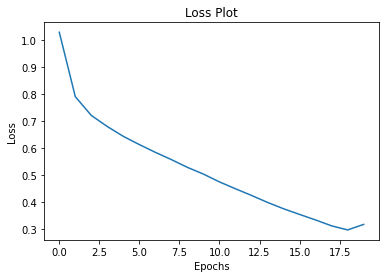

In [30]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [31]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [32]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> men sitting at a table with open pizza boxes eating pizza <end>
Prediction Caption: a man sitting on top of their glasses <end>


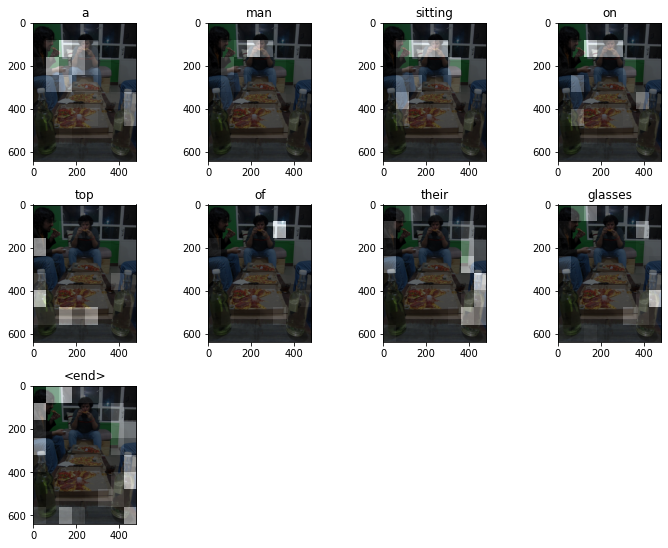

In [33]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


Prediction Caption: a man smiling in a suit and a hat and bottle and a photo holding a tie <end>


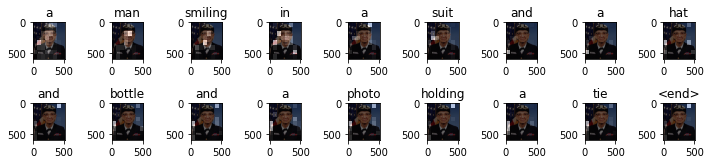

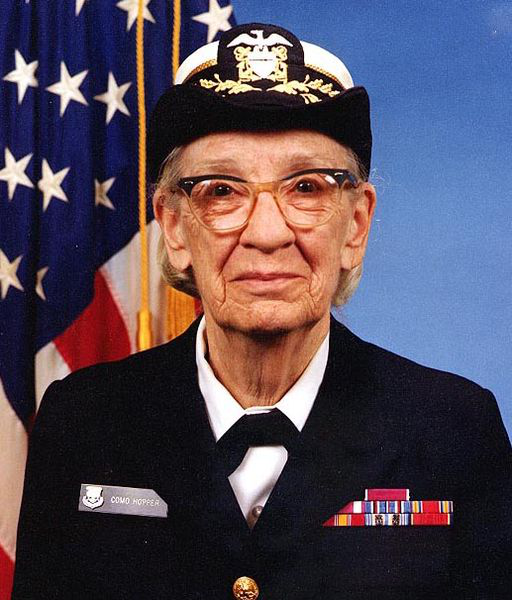

In [34]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.